In [1]:
import numpy as np
import pandas as pd
import scipy.signal as signal
import datetime as dt
import numpy as np
import glob
import os
import math
from pandas import read_csv
import xarray as xr
from metpy.plots import add_metpy_logo, Hodograph, SkewT
import matplotlib.pyplot as plt
from metpy.calc import bulk_shear,wind_speed,wind_components,wind_direction,storm_relative_helicity
from metpy.units import units

import pyart
import numpy as np
from datetime import timedelta
import glob
from radarcalc import *
import matplotlib.pyplot as plt
import pandas as pd
import metpy.calc as mpcalc
import metpy
import metpy.plots
from metpy.units import units
import cartopy.crs as ccrs
import cartopy
import gc
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import pyproj
import matplotlib.dates as mdates
import matplotlib as mpl
geodesic = pyproj.Geod(ellps='WGS84')

C:\Users\julia\Downloads\VADs stuff\radarcalc.py:81: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit


In [2]:
#Makes a 4 panel with corrected/uncorrected VAD PPIs and Hodographs

# FOR KA1
##########################################################################################
# kagps = pd.read_csv('E:\\Lapenta\\20220523\\KaRadars\\GPS_Ka1_20220523.txt', dtype=str)
# kascan = pd.read_csv('E:\\Lapenta\\20220523\\KaRadars\\20220523_Ka1_scan_log.txt', dtype=str,
#                      parse_dates=[0])
# vad_fileska = sorted(glob.glob('E:\\Lapenta\\20220523\\KaRadars\\product_raw_ka1\\*.nc'))
###########################################################################################

# FOR KA2
##############################################################################################
kagps = pd.read_csv('E:\\Lapenta\\20220523\\KaRadars\\GPS_Ka2_20220523.txt', dtype=str) #reads in gps data as a pandas data frame
kascan = pd.read_csv('E:\\Lapenta\\20220523\\KaRadars\\20220523_Ka2_scan_log.txt', dtype=str,
                     parse_dates=[0]) #reads in ka scan log-- scan log shows what type of scan it is as pandas data frame
vad_fileska = sorted(glob.glob('E:\\Lapenta\\20220523\\KaRadars\\product_raw_ka2\\*.nc')) # looks for .nc files-- which are the netcdf files from VADs notebook-- and sorts them numerically
################################################################################################
for thefile in vad_fileska:

    radar = pyart.io.read_cfradial(thefile) #reads netcdf file
    print(thefile,radar.fixed_angle['data']) #sanity check, prints out file and angle we're looking at
    
    #exactly what we did in VADs notebook
    kagps['ddmmyy']+kagps['hhmmss[UTC]']
    kagps['datetime'] = [datetime.strptime(d,'%d%m%y%H%M%S') for d in kagps['ddmmyy']+kagps['hhmmss[UTC]']]
    beginscanindex = kagps.loc[kagps['datetime'] == datetime.strptime(radar.time['units'],'seconds since %Y-%m-%dT%H:%M:%SZ')].index+np.amin(np.unique(radar.time['data']))
    endscanindex = kagps.loc[kagps['datetime'] == datetime.strptime(radar.time['units'],'seconds since %Y-%m-%dT%H:%M:%SZ')].index+np.amax(np.unique(radar.time['data']))
    dfscan = kagps.iloc[beginscanindex[0].astype(int):endscanindex[0].astype(int)]
    dfscan = dfscan.astype({'Bearing[degrees]': 'float'})
    speed = dfscan['Velocity[knots]'].astype(float).mean() #takes velocity column and avergaes all entries to see what avg speed is

    if int(kascan.loc[kascan['Datetime'] == dfscan.datetime.values[0]].Deployment.values[0]) != 0: #checking if in deployment
        bearing = float(kascan.loc[kascan['Datetime'] == dfscan.datetime.values[0]].Heading.values[0]) #if in deployment takes heading from file as it should be correct, alex quality controlled it)
    else:
        bearing = dfscan['Bearing[degrees]'].mean() #if not in deployment, we take the mean of the bearing for accuracy
    
    #josh's quality control, fixes any mistakes from wonky gps during deployment
    if bearing == 80.06703703703703:
        bearing = 190
    elif (bearing == 64.25037037037036):
        bearing = 9.980000000000002
    elif (bearing == 89.28925925925924):
        bearing = 92.6
    elif bearing == 269.9640740740741:
        bearing = 90.6
    elif bearing == 206.84615384615387:
        bearing = 149.0
    elif bearing == 263.8211111111111:
        bearing = 90.2
        
    print('Bearing used: '+str(bearing)) #another sanity check
    
    #print('latitude',dfscan['Latitude'].astype(float).mean(),'+-',dfscan['Latitude'].astype(float).var()) 
    lat = dfscan['Latitude'].astype(float).mean() #takes mean of latitude column and labels itself lat
    #print('longitude',dfscan['Longitude'].astype(float).mean(),'+-',dfscan['Longitude'].astype(float).var())
    lon = dfscan['Longitude'].astype(float).mean()
    
    display = pyart.graph.RadarMapDisplay(radar) #takes radar file we're looking at and maps it to radar display
    
    fig = plt.figure(figsize=(20, 20),facecolor='white') #creating canvas 
    
    ax1 = fig.add_subplot(2,2,1) #makes space for 2x2 plots aka 4 plots, addresses first location of plot, top left
    display.plot_ppi('corrected_velocity', 0, cmap='pyart_balance', ax=ax1, vmin=-40., vmax=40.,
                         colorbar_label=r'Radial Velocity [m s$^{-1}$]', title='Uncorrected Radial Velocity') #uses display variable we made above and plots uncorrected bearing ppi

    
    VAD = pyart.retrieve.vad_browning(radar, 'corrected_velocity', z_want=np.arange(50,5001,10),gatefilter=None) #makes VAD with radar, corrected--dealiased-- velocity, starts at 50 m ends at 5000 m, incrememts of 10m
    vadu = VAD.u_wind*1.94384 #takes u component of VAD and converts into knots which is what the *1.94384 is
    vadv = VAD.v_wind*1.94384
    
    ax3 = fig.add_subplot(2,2,3) #looking at 3rd plot which is at bottom left

    hodo = metpy.plots.Hodograph(ax3,component_range=80.) #creates the hodograph and plots onto 3rd plot, component range is max concentric circle
    hodo.add_grid(increment=5) #plots concentric circles at increment of 5 knots

    hodo.plot(vadu,vadv) #plots u and v components onto hodograph
    ax3.set_xlabel('U-component Wind [knots]') #adds labels for graph which is UNCORRECTED bearing
    ax3.set_ylabel('V-component Wind [knots]')
    ax3.set_title(thefile[-18:-3]+' Uncorrected VAD')
    
    (radar.azimuth['data'])+=(bearing)%360 #bearing correction, takes current azimuth from radar data and adds bearing to it to make it new azimuth, %360 limits data to 0 to 360 to keep in angle units
        
    ax2 = fig.add_subplot(2,2,2) 
    display.plot_ppi('corrected_velocity', 0, cmap='pyart_balance', ax=ax2, vmin=-40., vmax=40.,
                         colorbar_label=r'Radial Velocity [m s$^{-1}$]', title='Radial Velocity') #plots corrected ppi


    VAD = pyart.retrieve.vad_browning(radar, 'corrected_velocity', z_want=np.arange(50,5001,10),gatefilter=None) #makes bearing corrected VAD, same as above process
    vadu = VAD.u_wind*1.94384
    vadv = VAD.v_wind*1.94384
    
    ax4 = fig.add_subplot(2,2,4)

    hodo = metpy.plots.Hodograph(ax4,component_range=80.) #makes hodograph
    hodo.add_grid(increment=5)

    hodo.plot(vadu,vadv)
    ax4.set_xlabel('U-component Wind [knots]')
    ax4.set_ylabel('V-component Wind [knots]')
    ax4.set_title(thefile[-18:-3]+' VAD')

    for i,z in enumerate([0,95,195,295,395,495]): #makes hodograph look pretty, for every kilometer--"95m"-- labels it
        if np.isnan(vadu[z]): #if u component is empty-- NaN-- pass it
            pass
        else:
            circle = plt.Circle((vadu[z], vadv[z]), radius=1.5,color='k',zorder=30) #plots black circle at location
            ax4.add_patch(circle) #bottom right plot, bearing-corrected plot, adds patch to it
            label = ax4.annotate(i, xy=(vadu[z], vadv[z]), fontsize=12, ha="center",va='center',color='white',zorder=30,weight="bold")
            #labels kilometer youre at, ha tells you horizontal placement
            
    #CHANGE DIRECTORY
    plt.savefig('E:/Lapenta/20220523/hodos/ka2/'+thefile[-18:-3]+'.png',bbox_inches='tight',format='png',dpi=300) #saves figure for each time as separate file
    plt.close('all') #closes the plot
    fig.clf() #closes the figure so it wont show you all the figures after creation


FileNotFoundError: [Errno 2] No such file or directory: 'E:\\Lapenta\\20220523\\KaRadars\\GPS_Ka2_20220523.txt'

In [2]:
#Read in storm location csv

storm_location = pd.read_csv('E:/Lapenta/20220523/StormLocationMorton.csv', header=0)
storm_location['Date']=storm_location['Date'].astype(str).str.zfill(8)
storm_location['Time']=storm_location['Time'].astype(str).str.zfill(8)
#storm_location['Date']=storm_location['Date'].astype(str).str[:6]+str(20)+storm_location['Date'].astype(str).str[-2:]
storm_location['datetime'] = pd.to_datetime(storm_location['Date'].astype(str)+storm_location['Time'].astype(str),format='%m/%d/%Y%H:%M:%S')

In [3]:
#Calculate storm motion

decimalhour=[]
decimalsec=[]
for i in np.arange(0,len(storm_location),1):
    (h, m, s) = storm_location.loc[i].Time.split(':')
    result = int(h) + int(m)/60 + int(s)/3600
    result1 = int(h) * 3600 + int(m) * 60 + int(s)
    decimalsec.append(result1)
    decimalhour.append(result)
storm_location['decimalhour']=decimalhour
storm_location['decimalsec']=decimalsec


from math import sin, cos, sqrt, atan2, radians

def calc_velocity(lat1,lon1,lat2,lon2,time1,time2):
    R = 6371 # Radius of the earth in km
    dLat = radians(lat2-lat1)
    dLon = radians(lon2-lon1)
    rLat1 = radians(lat1)
    rLat2 = radians(lat2)
    a = sin(dLat/2) * sin(dLat/2) + cos(rLat1) * cos(rLat2) * sin(dLon/2) * sin(dLon/2) 
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    d = R * c * 1000 # Distance in m
    return d / (time2 - time1)

def get_bearing(lat1, long1, lat2, long2):
    dLon = (long2 - long1)
    x = cos(radians(lat2)) * sin(radians(dLon))
    y = cos(radians(lat1)) * sin(radians(lat2)) - sin(radians(lat1)) * cos(radians(lat2)) * cos(radians(dLon))
    brng = np.arctan2(x,y)
    brng = (np.degrees(brng)+180) % 360

    return brng

velocity1=[]
direction1=[]
for i in np.arange(0,len(storm_location)-1,1):
    velocity = calc_velocity(storm_location.loc[i].Lat,storm_location.loc[i].Lon,
                             storm_location.loc[i+1].Lat,storm_location.loc[i+1].Lon,
                             storm_location.loc[i].decimalsec,storm_location.loc[i+1].decimalsec)
    velocity1.append(velocity)
    direction = get_bearing(storm_location.loc[i].Lat,storm_location.loc[i].Lon,
                             storm_location.loc[i+1].Lat,storm_location.loc[i+1].Lon)
    direction1.append(direction)
velocity1 = np.append([np.nan],velocity1)
direction1 = np.append([np.nan],direction1)
storm_location['storm_vel']=velocity1 #m/s
storm_location['storm_dir']=(direction1) #deg

## Below takes dealised ka files made from VADS.ipynb, bearing corrects it and calculates different shear layers

In [4]:
ka1gps = pd.read_csv('E:\\Lapenta\\20220523\\KaRadars\\GPS_Ka1_20220523.txt', dtype=str)
ka1scan = pd.read_csv('E:\\Lapenta\\20220523\\KaRadars\\20220523_Ka1_scan_log.txt', dtype=str,
                     parse_dates=[0])
vad_fileska1 = sorted(glob.glob('E:\\Lapenta\\20220523\\KaRadars\\product_raw_ka1\\*.nc'))

ka2gps = pd.read_csv('E:\\Lapenta\\20220523\\KaRadars\\GPS_Ka2_20220523.txt', dtype=str)
ka2scan = pd.read_csv('E:\\Lapenta\\20220523\\KaRadars\\20220523_Ka2_scan_log.txt', dtype=str,
                     parse_dates=[0])
vad_fileska2 = sorted(glob.glob('E:\\Lapenta\\20220523\\KaRadars\\product_raw_ka2\\*.nc'))


In [43]:
#CHANGE directories

ka1gps = pd.read_csv('E:\\Lapenta\\20220523\\KaRadars\\GPS_Ka1_20220523.txt', dtype=str)
ka1scan = pd.read_csv('E:\\Lapenta\\20220523\\KaRadars\\20220523_Ka1_scan_log.txt', dtype=str,
                     parse_dates=[0])
vad_fileska1 = sorted(glob.glob('E:\\Lapenta\\20220523\\KaRadars\\product_raw_ka1\\*.nc'))

geodesic = pyproj.Geod(ellps='WGS84')
#plt.rcParams["figure.figsize"] = [20, 20]
#plt.rcParams["figure.autolayout"] = True
fig, ax = plt.subplots(3,2, figsize=(20,18),sharey=True,sharex='col')
ax[0,0].grid()
ax[0,1].grid()
ax[1,0].grid()
ax[1,1].grid()
ax[2,0].grid()
ax[2,1].grid()

norm = mpl.colors.Normalize(vmin=mdates.date2num(storm_location.datetime)[0], vmax=mdates.date2num(storm_location.datetime[len(storm_location)-1]))


for thefile in vad_fileska1[9:]:

    radar = pyart.io.read_cfradial(thefile)
    print(thefile,radar.fixed_angle['data'])
    
    
    ka1gps['ddmmyy']+ka1gps['hhmmss[UTC]']
    ka1gps['datetime'] = [datetime.strptime(d,'%d%m%y%H%M%S') for d in ka1gps['ddmmyy']+ka1gps['hhmmss[UTC]']]
    beginscanindex = ka1gps.loc[ka1gps['datetime'] == datetime.strptime(radar.time['units'],'seconds since %Y-%m-%dT%H:%M:%SZ')].index+np.amin(np.unique(radar.time['data']))
    endscanindex = ka1gps.loc[ka1gps['datetime'] == datetime.strptime(radar.time['units'],'seconds since %Y-%m-%dT%H:%M:%SZ')].index+np.amax(np.unique(radar.time['data']))
    dfscan = ka1gps.iloc[beginscanindex[0].astype(int):endscanindex[0].astype(int)]
    dfscan = dfscan.astype({'Bearing[degrees]': 'float'})

    speed = dfscan['Velocity[knots]'].astype(float).mean()
        
    #Get Bearing from deployment log or gps file
    if int(ka1scan.loc[ka1scan['Datetime'] == dfscan.datetime.values[0]].Deployment.values[0]) != 0:
        bearing = float(ka1scan.loc[ka1scan['Datetime'] == dfscan.datetime.values[0]].Heading.values[0])
    else:
        bearing = dfscan['Bearing[degrees]'].mean()
        
    #Manual Corrections
    if bearing == 80.06703703703703:
        bearing = 190
    elif (bearing == 64.25037037037036):
        bearing = 9.980000000000002
    elif (bearing == 89.28925925925924):
        bearing = 92.6
    elif bearing == 269.9640740740741:
        bearing = 90.6
    elif bearing == 206.84615384615387:
        bearing = 149.0
    elif bearing == 263.8211111111111:
        bearing = 90.2
    
    print('Bearing used: '+str(bearing))
    
    
    lat = dfscan['Latitude'].astype(float).mean()
    lon = dfscan['Longitude'].astype(float).mean()
    
    display = pyart.graph.RadarMapDisplay(radar)
    
    #Bearing Correction
    radar.azimuth['data']+=(bearing)%360
    
    #Get VAD
    VAD = pyart.retrieve.vad_browning(radar, 'corrected_velocity', z_want=np.arange(50,5001,10),gatefilter=None)
    u1 = VAD.u_wind
    v1 = VAD.v_wind
    
    #Get Different Shear Layers
    u_shear = [u1[5]-u1[0],u1[15]-u1[0],u1[25]-u1[0]
                   ,u1[35]-u1[0],u1[45]-u1[0],u1[55]-u1[0]
                   ,u1[65]-u1[0],u1[75]-u1[0],u1[85]-u1[0]
                   ,u1[95]-u1[0]]

    v_shear = [v1[5]-v1[0],v1[15]-v1[0],v1[25]-v1[0]
               ,v1[35]-v1[0],v1[45]-v1[0],v1[55]-v1[0]
               ,v1[65]-v1[0],v1[75]-v1[0],v1[85]-v1[0]
               ,v1[95]-v1[0]]
    wspd_shear = wind_speed(u_shear*units('m/s'),v_shear*units('m/s'))
    
    fwd_azimuth,back_azimuth,distance = geodesic.inv(dfscan['Longitude'].values[0], dfscan['Latitude'].values[0], 
                                                         storm_location.iloc[(storm_location['datetime']
                                                                              -dfscan['datetime'].values[0]).abs().argsort()[:1]]['Lon'].values, 
                                                         storm_location.iloc[(storm_location['datetime']
                                                                              -dfscan['datetime'].values[0]).abs().argsort()[:1]]['Lat'].values)

    dist = distance/1000
    bear = back_azimuth
    c = dfscan['datetime'].values[0]
    
    if bear<0:
        bear=bear+360
    print(wspd_shear[0],wspd_shear[4],wspd_shear[9],dist,bear)
    
    img=ax[2,0].scatter(dist,wspd_shear[9], c=mdates.date2num(c), marker = 'o', cmap='plasma', alpha=0.5, s=75, norm=norm)
    ax[1,0].scatter(dist,wspd_shear[4], c=mdates.date2num(c), marker = 'o', cmap='plasma', alpha=0.5, s=75, norm=norm)
    ax[0,0].scatter(dist,wspd_shear[0], c=mdates.date2num(c), marker = 'o', cmap='plasma', alpha=0.5, s=75, norm=norm)

    ax[2,1].scatter(bear,wspd_shear[9], c=mdates.date2num(c), marker = 'o', cmap='plasma', alpha=0.5, s=75, norm=norm)
    ax[1,1].scatter(bear,wspd_shear[4], c=mdates.date2num(c), marker = 'o', cmap='plasma', alpha=0.5, s=75, norm=norm)
    ax[0,1].scatter(bear,wspd_shear[0], c=mdates.date2num(c), marker = 'o', cmap='plasma', alpha=0.5, s=75, norm=norm)   

#CHANGE DIRECTORIES    
ka2gps = pd.read_csv('E:\\Lapenta\\20220523\\KaRadars\\GPS_Ka2_20220523.txt', dtype=str)
ka2scan = pd.read_csv('E:\\Lapenta\\20220523\\KaRadars\\20220523_Ka2_scan_log.txt', dtype=str,
                     parse_dates=[0])
vad_fileska2 = sorted(glob.glob('E:\\Lapenta\\20220523\\KaRadars\\product_raw_ka2\\*.nc'))


#Make same changes as above
for thefile in vad_fileska2[28:]:

    radar = pyart.io.read_cfradial(thefile)
    print(thefile,radar.fixed_angle['data'])
    
    
    ka2gps['ddmmyy']+ka2gps['hhmmss[UTC]']
    ka2gps['datetime'] = [datetime.strptime(d,'%d%m%y%H%M%S') for d in ka2gps['ddmmyy']+ka2gps['hhmmss[UTC]']]
    beginscanindex = ka2gps.loc[ka2gps['datetime'] == datetime.strptime(radar.time['units'],'seconds since %Y-%m-%dT%H:%M:%SZ')].index+np.amin(np.unique(radar.time['data']))
    endscanindex = ka2gps.loc[ka2gps['datetime'] == datetime.strptime(radar.time['units'],'seconds since %Y-%m-%dT%H:%M:%SZ')].index+np.amax(np.unique(radar.time['data']))
    dfscan = ka2gps.iloc[beginscanindex[0].astype(int):endscanindex[0].astype(int)]
    dfscan = dfscan.astype({'Bearing[degrees]': 'float'})

    speed = dfscan['Velocity[knots]'].astype(float).mean()

    if int(ka2scan.loc[ka2scan['Datetime'] == dfscan.datetime.values[0]].Deployment.values[0]) != 0:
        bearing = float(ka2scan.loc[ka2scan['Datetime'] == dfscan.datetime.values[0]].Heading.values[0])
    else:
        bearing = dfscan['Bearing[degrees]'].mean()
        
    if bearing == 80.06703703703703:
        bearing = 190
    elif (bearing == 64.25037037037036):
        bearing = 9.980000000000002
    elif (bearing == 89.28925925925924):
        bearing = 92.6
    elif bearing == 269.9640740740741:
        bearing = 90.6
    elif bearing == 206.84615384615387:
        bearing = 149.0
    elif bearing == 263.8211111111111:
        bearing = 90.2
 
    print('Bearing used: '+str(bearing))
    
    lat = dfscan['Latitude'].astype(float).mean()
    lon = dfscan['Longitude'].astype(float).mean()
    
    display = pyart.graph.RadarMapDisplay(radar)
    
    radar.azimuth['data']+=(bearing)%360
    

    VAD = pyart.retrieve.vad_browning(radar, 'corrected_velocity', z_want=np.arange(50,5001,10),gatefilter=None)
    u1 = VAD.u_wind
    v1 = VAD.v_wind
    
    u_shear = [u1[5]-u1[0],u1[15]-u1[0],u1[25]-u1[0]
                   ,u1[35]-u1[0],u1[45]-u1[0],u1[55]-u1[0]
                   ,u1[65]-u1[0],u1[75]-u1[0],u1[85]-u1[0]
                   ,u1[95]-u1[0]]

    v_shear = [v1[5]-v1[0],v1[15]-v1[0],v1[25]-v1[0]
               ,v1[35]-v1[0],v1[45]-v1[0],v1[55]-v1[0]
               ,v1[65]-v1[0],v1[75]-v1[0],v1[85]-v1[0]
               ,v1[95]-v1[0]]
    wspd_shear = wind_speed(u_shear*units('m/s'),v_shear*units('m/s'))

    fwd_azimuth,back_azimuth,distance = geodesic.inv(dfscan['Longitude'].values[0], dfscan['Latitude'].values[0], 
                                                         storm_location.iloc[(storm_location['datetime']
                                                                              -dfscan['datetime'].values[0]).abs().argsort()[:1]]['Lon'].values, 
                                                         storm_location.iloc[(storm_location['datetime']
                                                                              -dfscan['datetime'].values[0]).abs().argsort()[:1]]['Lat'].values)

    dist = distance/1000
    bear = back_azimuth
    c = dfscan['datetime'].values[0]
    
    if bear<0:
        bear=bear+360
        
    print(wspd_shear[0],wspd_shear[4],wspd_shear[9],dist,bear)
    img=ax[2,0].scatter(dist,wspd_shear[9], c=mdates.date2num(c), marker = 'o', cmap='plasma', alpha=0.5, s=75, norm=norm)
    ax[1,0].scatter(dist,wspd_shear[4], c=mdates.date2num(c), marker = 'o', cmap='plasma', alpha=0.5, s=75, norm=norm)
    ax[0,0].scatter(dist,wspd_shear[0], c=mdates.date2num(c), marker = 'o', cmap='plasma', alpha=0.5, s=75, norm=norm)

    ax[2,1].scatter(bear,wspd_shear[9], c=mdates.date2num(c), marker = 'o', cmap='plasma', alpha=0.5, s=75, norm=norm)
    ax[1,1].scatter(bear,wspd_shear[4], c=mdates.date2num(c), marker = 'o', cmap='plasma', alpha=0.5, s=75, norm=norm)
    ax[0,1].scatter(bear,wspd_shear[0], c=mdates.date2num(c), marker = 'o', cmap='plasma', alpha=0.5, s=75, norm=norm)   

    
    
    
    
    
ax[0,0].invert_xaxis()
ax[1,0].invert_xaxis()
ax[2,0].invert_xaxis()
ax[2,0].set_xlabel('Distance from Center of Storm (km)', fontsize=12, fontweight='bold')
ax[2,1].set_xlabel('Bearing from Center of Storm (deg)', fontsize=12, fontweight='bold')
ax[0,0].set_ylabel('0-100m Shear (m/s)', fontsize=12, fontweight='bold')
ax[1,0].set_ylabel('0-500m Shear (m/s)', fontsize=12, fontweight='bold')
ax[2,0].set_ylabel('0-1km Shear (m/s)', fontsize=12, fontweight='bold')

cbar = fig.colorbar(img, ax=ax[2, 0], location='bottom',pad=0.2)
ff = mdates.num2date(cbar.ax.get_xticks())
fff = [date_obj.strftime('%H:%M:%S') for date_obj in ff]
cbar.ax.set_xticklabels(fff, fontsize=10, fontweight='bold')
cbar.set_label('Time during Intensive Operating Period (HH:MM:SS UTC)', fontsize=12, fontweight='bold')

cbar = fig.colorbar(img, ax=ax[2, 1], location='bottom',pad=0.2)
ff = mdates.num2date(cbar.ax.get_xticks())
fff = [date_obj.strftime('%H:%M:%S') for date_obj in ff]
cbar.ax.set_xticklabels(fff, fontsize=10, fontweight='bold')
cbar.set_label('Time during Intensive Operating Period (HH:MM:SS UTC)', fontsize=12, fontweight='bold')


plt.savefig('E:/Lapenta/20220523/Figs/ka_shearlayer.png',bbox_inches='tight',format='png',dpi=300)
plt.close('all')
fig.clf()


E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222551.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
7.595554351806641 meter / second 9.870407104492188 meter / second 10.965500831604004 meter / second [29.69361084] 27.26290998543527
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222620.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
7.2395219802856445 meter / second 9.72143840789795 meter / second 11.001836776733398 meter / second [29.69349878] 27.26342377414653
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222649.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
7.379119396209717 meter / second 9.181769371032715 meter / second 10.435731887817383 meter / second [29.69426188] 27.264873188248657
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222718.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
7.78202486038208 meter / second 9.96402359008789 meter / second 10.749303817749023 meter / second [29.69443189] 27.265507484939803
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222747.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
7.37658166885376 meter / second 9.804030418395996 meter / second 10.879328727722168 meter / second [25.89464316] 23.598627612160954
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222816.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
6.705663681030273 meter / second 9.449240684509277 meter / second 10.64968204498291 meter / second [25.89461583] 23.599101133513415
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222845.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6010.0  meters
min height 0.0  meters
6.474790096282959 meter / second 9.621376991271973 meter / second 10.585755348205566 meter / second [25.8950068] 23.60229827322621
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222914.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
6.782453536987305 meter / second 9.380778312683105 meter / second 10.35678482055664 meter / second [25.89508107] 23.602673281354384
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222943.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
7.040159225463867 meter / second 8.925653457641602 meter / second 9.842536926269531 meter / second [25.89495216] 23.603245311425155
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223013.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
6.949613571166992 meter / second 9.17158031463623 meter / second 9.61306381225586 meter / second [25.89495216] 23.603245311425155
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223042.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
6.6460795402526855 meter / second 8.69205093383789 meter / second 8.595727920532227 meter / second [25.8949893] 23.603432814795582
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223111.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
7.3634843826293945 meter / second 9.553918838500977 meter / second 8.875597953796387 meter / second [25.89506358] 23.603807819922963
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223140.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
7.414078235626221 meter / second 9.879952430725098 meter / second 8.722475051879883 meter / second [25.89513786] 23.604182822893762
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223209.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
7.640163898468018 meter / second 9.05644702911377 meter / second 8.7449369430542 meter / second [25.89503627] 23.60428133908718
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223238.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6036.0  meters
min height 0.0  meters
7.501395225524902 meter / second 7.646573543548584 meter / second 8.10477352142334 meter / second [22.31687641] 23.212464274627678
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223307.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
5.347088813781738 meter / second 6.498300075531006 meter / second 9.108508110046387 meter / second [22.31687641] 23.212464274627678
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223336.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
3.727437973022461 meter / second 9.040151596069336 meter / second 12.316469192504883 meter / second [22.3169495] 23.21290072665721
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223405.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
2.971078395843506 meter / second 9.970120429992676 meter / second 16.69550895690918 meter / second [22.3169495] 23.21290072665721
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223434.nc [37.001953 45.      ]
Bearing used: 190


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 5992.0  meters
min height 0.0  meters
2.1004035472869873 meter / second 9.001938819885254 meter / second 16.70770835876465 meter / second [22.32106421] 23.212237274295205
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523224032.nc [37.001953 45.      ]
Bearing used: 9.980000000000002


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
4.787405967712402 meter / second 11.20851993560791 meter / second 8.457930564880371 meter / second [25.21235411] 11.965855114399801
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523224101.nc [37.001953 45.      ]
Bearing used: 9.980000000000002


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6001.0  meters
min height 0.0  meters
5.03794527053833 meter / second 8.729578971862793 meter / second 5.244338035583496 meter / second [25.21213711] 11.96595990968629
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523224130.nc [37.001953 45.      ]
Bearing used: 92.6


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
5.715755939483643 meter / second 7.000988483428955 meter / second 1.2142610549926758 meter / second [25.20713522] 11.97310291355194
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523232822.nc [37.001953 45.      ]
Bearing used: 177.76296296296297


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
4.568909168243408 meter / second 4.781547546386719 meter / second 3.741668224334717 meter / second [19.39433298] 75.62631829516147
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523232852.nc [37.001953 45.      ]
Bearing used: 180.39961538461537


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6009.0  meters
min height 0.0  meters
4.269521236419678 meter / second 4.782710552215576 meter / second 3.3412749767303467 meter / second [19.39185832] 75.67179638402378
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523232921.nc [37.001953 45.      ]
Bearing used: 180.77923076923076


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6008.0  meters
min height 0.0  meters
4.445515155792236 meter / second 5.21711540222168 meter / second 3.827857732772827 meter / second [19.384452] 75.74504233926842
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523232950.nc [37.001953 45.      ]
Bearing used: 149.0


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
3.7903218269348145 meter / second 4.084147930145264 meter / second 3.036881685256958 meter / second [19.38346661] 75.75884716620045
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523233019.nc [37.001953 45.      ]
Bearing used: 90.6


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6008.0  meters
min height 0.0  meters
4.048617839813232 meter / second 6.294620990753174 meter / second 4.293613910675049 meter / second [19.38659031] 75.75576210788208
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220524000309.nc [37.001953 45.      ]
Bearing used: 90.2


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 5999.0  meters
min height 0.0  meters
4.401492595672607 meter / second 10.12828254699707 meter / second 11.136366844177246 meter / second [17.21288922] 110.71647052341325
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222547.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
7.268186569213867 meter / second 12.364740371704102 meter / second 12.759955406188965 meter / second [37.47005918] 44.85916746348542
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222617.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
9.199492454528809 meter / second 12.949646949768066 meter / second 12.993866920471191 meter / second [37.47005918] 44.85916746348542
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222647.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
8.968218803405762 meter / second 13.532629013061523 meter / second 13.709111213684082 meter / second [37.46956281] 44.860327252393745
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222718.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
8.995964050292969 meter / second 12.226017951965332 meter / second 13.467469215393066 meter / second [37.46956281] 44.860327252393745
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222748.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
9.229752540588379 meter / second 13.624309539794922 meter / second 13.850748062133789 meter / second [33.29504445] 44.151757676227135
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222818.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
8.631678581237793 meter / second 12.590092658996582 meter / second 13.269853591918945 meter / second [33.29491524] 44.151529739708906
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222848.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
8.684652328491211 meter / second 12.475001335144043 meter / second 13.468521118164062 meter / second [33.29491524] 44.151529739708906
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222919.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
8.68989086151123 meter / second 12.602174758911133 meter / second 13.885615348815918 meter / second [33.29499463] 44.15139644941365
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222949.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
9.016087532043457 meter / second 13.59412670135498 meter / second 14.725069046020508 meter / second [33.29493003] 44.15128248050473
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223019.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
9.236886978149414 meter / second 13.772994041442871 meter / second 13.840415000915527 meter / second [33.29485063] 44.15141577078518
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223050.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
8.239383697509766 meter / second 14.605195045471191 meter / second 14.694265365600586 meter / second [33.29485063] 44.15141577078518
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223120.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6012.0  meters
min height 0.0  meters
7.870065689086914 meter / second 14.48773193359375 meter / second 14.565727233886719 meter / second [33.29469184] 44.15168235325683
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223150.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
8.003246307373047 meter / second 14.981045722961426 meter / second 14.969828605651855 meter / second [33.29469184] 44.15168235325683
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223220.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6008.0  meters
min height 0.0  meters
8.309374809265137 meter / second 14.111577987670898 meter / second 14.427522659301758 meter / second [33.29456262] 44.151454414022226
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223250.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
8.849954605102539 meter / second 13.717098236083984 meter / second 13.865392684936523 meter / second [29.90932807] 46.287284987534406
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223321.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
8.713027954101562 meter / second 13.628050804138184 meter / second 13.815364837646484 meter / second [29.90919402] 46.2870406069342
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223351.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
8.973125457763672 meter / second 13.853462219238281 meter / second 14.227582931518555 meter / second [29.90919402] 46.2870406069342
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223421.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
9.2372465133667 meter / second 14.10618782043457 meter / second 13.919462203979492 meter / second [29.90904109] 46.28734844759589
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223452.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
9.321738243103027 meter / second 13.023818016052246 meter / second 13.447983741760254 meter / second [29.90904109] 46.28734844759589
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223522.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
9.575560569763184 meter / second 13.730940818786621 meter / second 13.66813850402832 meter / second [29.90904109] 46.28734844759589
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223552.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
9.338936805725098 meter / second 13.605866432189941 meter / second 13.76732063293457 meter / second [29.90904109] 46.28734844759589
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223622.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
9.463680267333984 meter / second 13.28653621673584 meter / second 13.406952857971191 meter / second [29.90904109] 46.28734844759589
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223652.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
9.241029739379883 meter / second 13.082144737243652 meter / second 13.605469703674316 meter / second [29.90904109] 46.28734844759589
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223722.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
9.177560806274414 meter / second 12.932602882385254 meter / second 13.587747573852539 meter / second [29.90904109] 46.28734844759589
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223753.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
8.315797805786133 meter / second 12.60370922088623 meter / second 13.389595985412598 meter / second [26.15765206] 45.50378718983188
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223823.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
8.875943183898926 meter / second 12.848214149475098 meter / second 13.717816352844238 meter / second [26.15802852] 45.50323440860703
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223852.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
9.35938835144043 meter / second 13.351022720336914 meter / second 14.012301445007324 meter / second [26.15816077] 45.50351791392157
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223922.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
9.277898788452148 meter / second 13.31282901763916 meter / second 13.228720664978027 meter / second [26.15816077] 45.50351791392157
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223953.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
8.914802551269531 meter / second 12.771319389343262 meter / second 12.1893892288208 meter / second [26.15816077] 45.50351791392157
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224023.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
8.75022029876709 meter / second 12.671448707580566 meter / second 11.785013198852539 meter / second [26.15802852] 45.50323440860703
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224053.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6008.0  meters
min height 0.0  meters
8.37890338897705 meter / second 11.734755516052246 meter / second 10.921680450439453 meter / second [26.15802852] 45.50323440860703
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224123.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6001.0  meters
min height 0.0  meters
8.152846336364746 meter / second 11.542803764343262 meter / second 10.40513801574707 meter / second [26.15802852] 45.50323440860703
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224153.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
7.781613349914551 meter / second 10.792219161987305 meter / second 9.4568452835083 meter / second [26.15754275] 45.50287289831178
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224223.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
7.8138651847839355 meter / second 10.38520336151123 meter / second 9.262252807617188 meter / second [26.15754275] 45.50287289831178
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224253.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
7.701096534729004 meter / second 9.465328216552734 meter / second 8.500260353088379 meter / second [24.01552095] 48.91975883365507
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224324.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
7.0921101570129395 meter / second 9.109164237976074 meter / second 8.430924415588379 meter / second [24.01552095] 48.91975883365507
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224354.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
7.008446216583252 meter / second 8.766317367553711 meter / second 9.755304336547852 meter / second [24.01552095] 48.91975883365507
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224425.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
7.095061779022217 meter / second 8.79167652130127 meter / second 9.744839668273926 meter / second [24.01552095] 48.91975883365507
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224455.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
6.880831718444824 meter / second 9.26870059967041 meter / second 10.045748710632324 meter / second [24.01552095] 48.91975883365507
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224524.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
6.678352355957031 meter / second 7.694295883178711 meter / second 9.728164672851562 meter / second [24.01552095] 48.91975883365507
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224554.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
3.731204032897949 meter / second 9.344244956970215 meter / second 11.132369041442871 meter / second [24.0153755] 48.92015844957865
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224624.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
2.708683729171753 meter / second 8.56330394744873 meter / second 12.338310241699219 meter / second [24.0153755] 48.92015844957865
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224655.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
2.8264358043670654 meter / second 8.687858581542969 meter / second 12.659524917602539 meter / second [24.01530277] 48.92035825935403
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224726.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
2.7599282264709473 meter / second 9.083490371704102 meter / second 13.339409828186035 meter / second [24.01530277] 48.92035825935403
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224756.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
2.744412422180176 meter / second 9.536609649658203 meter / second 13.032794952392578 meter / second [21.98273748] 53.36469771104575
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224826.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
2.376204252243042 meter / second 10.495658874511719 meter / second 11.732850074768066 meter / second [21.98260543] 53.365162332666586
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224856.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
2.4611055850982666 meter / second 12.031778335571289 meter / second 12.665406227111816 meter / second [21.98253108] 53.36501879288842
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224927.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
2.9207684993743896 meter / second 9.690727233886719 meter / second 12.876279830932617 meter / second [21.98246506] 53.36525110614407
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224957.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6004.0  meters
min height 0.0  meters
3.5724010467529297 meter / second 4.506844520568848 meter / second 10.589362144470215 meter / second [21.98246506] 53.36525110614407
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523225027.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6012.0  meters
min height 0.0  meters
2.3085663318634033 meter / second 5.221638202667236 meter / second 14.454930305480957 meter / second [21.98246506] 53.36525110614407
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523225057.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
2.6616976261138916 meter / second 5.8162994384765625 meter / second 14.779378890991211 meter / second [21.98231637] 53.36496402438074
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523225128.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6008.0  meters
min height 0.0  meters
2.159130096435547 meter / second 6.975030422210693 meter / second 11.293928146362305 meter / second [21.98231637] 53.36496402438074
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523225158.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
7.483412742614746 meter / second 4.356271743774414 meter / second 5.937160015106201 meter / second [21.98231637] 53.36496402438074
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523225228.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
7.426307678222656 meter / second 2.468108892440796 meter / second 6.103599548339844 meter / second [21.98216767] 53.364676938725225
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523225258.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
6.904540538787842 meter / second 6.187681674957275 meter / second 8.03001594543457 meter / second [20.14931661] 54.209213878258
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523225328.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
7.359816074371338 meter / second 9.747589111328125 meter / second 10.556075096130371 meter / second [20.14918718] 54.20972620592141
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523225358.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
2.5790293216705322 meter / second 10.740971565246582 meter / second 7.166455268859863 meter / second [20.14911203] 54.209572709330544


C:\Users\joshu\AppData\Local\Temp\ipykernel_24088\3720464000.py:218: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_xticklabels(fff, fontsize=10, fontweight='bold')
C:\Users\joshu\AppData\Local\Temp\ipykernel_24088\3720464000.py:224: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_xticklabels(fff, fontsize=10, fontweight='bold')


## Same as above but for storm relative helicity

In [44]:
ka1gps = pd.read_csv('E:\\Lapenta\\20220523\\KaRadars\\GPS_Ka1_20220523.txt', dtype=str)
ka1scan = pd.read_csv('E:\\Lapenta\\20220523\\KaRadars\\20220523_Ka1_scan_log.txt', dtype=str,
                     parse_dates=[0])
vad_fileska1 = sorted(glob.glob('E:\\Lapenta\\20220523\\KaRadars\\product_raw_ka1\\*.nc'))

geodesic = pyproj.Geod(ellps='WGS84')
#plt.rcParams["figure.figsize"] = [20, 20]
#plt.rcParams["figure.autolayout"] = True
fig, ax = plt.subplots(3,2, figsize=(20,18),sharey=True,sharex='col')
ax[0,0].grid()
ax[0,1].grid()
ax[1,0].grid()
ax[1,1].grid()
ax[2,0].grid()
ax[2,1].grid()

norm = mpl.colors.Normalize(vmin=mdates.date2num(storm_location.datetime)[0], vmax=mdates.date2num(storm_location.datetime[len(storm_location)-1]))


for thefile in vad_fileska1[9:]:

    radar = pyart.io.read_cfradial(thefile)
    print(thefile,radar.fixed_angle['data'])
    
    
    ka1gps['ddmmyy']+ka1gps['hhmmss[UTC]']
    ka1gps['datetime'] = [datetime.strptime(d,'%d%m%y%H%M%S') for d in ka1gps['ddmmyy']+ka1gps['hhmmss[UTC]']]
    beginscanindex = ka1gps.loc[ka1gps['datetime'] == datetime.strptime(radar.time['units'],'seconds since %Y-%m-%dT%H:%M:%SZ')].index+np.amin(np.unique(radar.time['data']))
    endscanindex = ka1gps.loc[ka1gps['datetime'] == datetime.strptime(radar.time['units'],'seconds since %Y-%m-%dT%H:%M:%SZ')].index+np.amax(np.unique(radar.time['data']))
    dfscan = ka1gps.iloc[beginscanindex[0].astype(int):endscanindex[0].astype(int)]
    dfscan = dfscan.astype({'Bearing[degrees]': 'float'})

    #print('velocity [kts]',dfscan['Velocity[knots]'].astype(float).mean(),'+-',dfscan['Velocity[knots]'].astype(float).var())
    speed = dfscan['Velocity[knots]'].astype(float).mean()
    #print('bearing',dfscan['Bearing[degrees]'].astype(float).mean(),'+-',dfscan['Bearing[degrees]'].astype(float).var())
    
#    bearing = 84.6
    if int(ka1scan.loc[ka1scan['Datetime'] == dfscan.datetime.values[0]].Deployment.values[0]) != 0:
        bearing = float(ka1scan.loc[ka1scan['Datetime'] == dfscan.datetime.values[0]].Heading.values[0])
    else:
        bearing = dfscan['Bearing[degrees]'].mean()
        
    if bearing == 80.06703703703703:
        bearing = 190
    elif (bearing == 64.25037037037036):
        bearing = 9.980000000000002
    elif (bearing == 89.28925925925924):
        bearing = 92.6
    elif bearing == 269.9640740740741:
        bearing = 90.6
    elif bearing == 206.84615384615387:
        bearing = 149.0
    elif bearing == 263.8211111111111:
        bearing = 90.2
    
    print('Bearing used: '+str(bearing))
    
    #print('latitude',dfscan['Latitude'].astype(float).mean(),'+-',dfscan['Latitude'].astype(float).var())
    lat = dfscan['Latitude'].astype(float).mean()
    #print('longitude',dfscan['Longitude'].astype(float).mean(),'+-',dfscan['Longitude'].astype(float).var())
    lon = dfscan['Longitude'].astype(float).mean()
    
    display = pyart.graph.RadarMapDisplay(radar)
    
    radar.azimuth['data']+=(bearing)%360
#     if (bearing>=0)&(bearing<=90):
#         (radar.azimuth['data'])+=(bearing*(-1)+90)%360
#     else:
#         (radar.azimuth['data'])+=360-(bearing*(-1)+90)%360

    VAD = pyart.retrieve.vad_browning(radar, 'corrected_velocity', z_want=np.arange(50,5001,10),gatefilter=None)
    u1 = VAD.u_wind
    v1 = VAD.v_wind
    z1 = VAD.height
    u_storm,v_storm = (wind_components(storm_location.iloc[(storm_location['datetime']-dfscan['datetime'].values[0]).abs().argsort()[:1]]['storm_vel'].values 
                                    * units('m/s'), 
                                   storm_location.iloc[(storm_location['datetime']-dfscan['datetime'].values[0]).abs().argsort()[:1]]['storm_dir'].values 
                                    * units.deg))
    #print(u_storm,v_storm)

    SRH1km = storm_relative_helicity(z1*units('m'),units.Quantity(u1,'m/s'),units.Quantity(v1,'m/s'),
                                  1*units('km'),storm_u=u_storm,storm_v=v_storm)[2]
    SRH500m = storm_relative_helicity(z1*units('m'),units.Quantity(u1,'m/s'),units.Quantity(v1,'m/s'),
                                  500*units('m'),storm_u=u_storm,storm_v=v_storm)[2]
    SRH100m = storm_relative_helicity(z1*units('m'),units.Quantity(u1,'m/s'),units.Quantity(v1,'m/s'),
                                  100*units('m'),storm_u=u_storm,storm_v=v_storm)[2]
    
    fwd_azimuth,back_azimuth,distance = geodesic.inv(dfscan['Longitude'].values[0], dfscan['Latitude'].values[0], 
                                                     storm_location.iloc[(storm_location['datetime']
                                                                          -dfscan['datetime'].values[0]).abs().argsort()[:1]]['Lon'].values, 
                                                     storm_location.iloc[(storm_location['datetime']
                                                                          -dfscan['datetime'].values[0]).abs().argsort()[:1]]['Lat'].values)

    dist = distance/1000
    bear = back_azimuth
    c = dfscan['datetime'].values[0]

    if bear<0:
        bear=bear+360
    img=ax[2,0].scatter(dist,SRH1km, c=mdates.date2num(c), marker = 'o', cmap='plasma', alpha=0.5, s=75, norm=norm)
    ax[1,0].scatter(dist,SRH500m, c=mdates.date2num(c), marker = 'o', cmap='plasma', alpha=0.5, s=75, norm=norm)
    ax[0,0].scatter(dist,SRH100m, c=mdates.date2num(c), marker = 'o', cmap='plasma', alpha=0.5, s=75, norm=norm)

    ax[2,1].scatter(bear,SRH1km, c=mdates.date2num(c), marker = 'o', cmap='plasma', alpha=0.5, s=75, norm=norm)
    ax[1,1].scatter(bear,SRH500m, c=mdates.date2num(c), marker = 'o', cmap='plasma', alpha=0.5, s=75, norm=norm)
    ax[0,1].scatter(bear,SRH100m, c=mdates.date2num(c), marker = 'o', cmap='plasma', alpha=0.5, s=75, norm=norm)   

    
ka2gps = pd.read_csv('E:\\Lapenta\\20220523\\KaRadars\\GPS_Ka2_20220523.txt', dtype=str)
ka2scan = pd.read_csv('E:\\Lapenta\\20220523\\KaRadars\\20220523_Ka2_scan_log.txt', dtype=str,
                     parse_dates=[0])
vad_fileska2 = sorted(glob.glob('E:\\Lapenta\\20220523\\KaRadars\\product_raw_ka2\\*.nc'))

for thefile in vad_fileska2[28:]:

    radar = pyart.io.read_cfradial(thefile)
    print(thefile,radar.fixed_angle['data'])
    
    
    ka2gps['ddmmyy']+ka2gps['hhmmss[UTC]']
    ka2gps['datetime'] = [datetime.strptime(d,'%d%m%y%H%M%S') for d in ka2gps['ddmmyy']+ka2gps['hhmmss[UTC]']]
    beginscanindex = ka2gps.loc[ka2gps['datetime'] == datetime.strptime(radar.time['units'],'seconds since %Y-%m-%dT%H:%M:%SZ')].index+np.amin(np.unique(radar.time['data']))
    endscanindex = ka2gps.loc[ka2gps['datetime'] == datetime.strptime(radar.time['units'],'seconds since %Y-%m-%dT%H:%M:%SZ')].index+np.amax(np.unique(radar.time['data']))
    dfscan = ka2gps.iloc[beginscanindex[0].astype(int):endscanindex[0].astype(int)]
    dfscan = dfscan.astype({'Bearing[degrees]': 'float'})

    #print('velocity [kts]',dfscan['Velocity[knots]'].astype(float).mean(),'+-',dfscan['Velocity[knots]'].astype(float).var())
    speed = dfscan['Velocity[knots]'].astype(float).mean()
    #print('bearing',dfscan['Bearing[degrees]'].astype(float).mean(),'+-',dfscan['Bearing[degrees]'].astype(float).var())
    
#    bearing = 84.6
    if int(ka2scan.loc[ka2scan['Datetime'] == dfscan.datetime.values[0]].Deployment.values[0]) != 0:
        bearing = float(ka2scan.loc[ka2scan['Datetime'] == dfscan.datetime.values[0]].Heading.values[0])
    else:
        bearing = dfscan['Bearing[degrees]'].mean()
        
    if bearing == 80.06703703703703:
        bearing = 190
    elif (bearing == 64.25037037037036):
        bearing = 9.980000000000002
    elif (bearing == 89.28925925925924):
        bearing = 92.6
    elif bearing == 269.9640740740741:
        bearing = 90.6
    elif bearing == 206.84615384615387:
        bearing = 149.0
    elif bearing == 263.8211111111111:
        bearing = 90.2
 
    print('Bearing used: '+str(bearing))
    
    #print('latitude',dfscan['Latitude'].astype(float).mean(),'+-',dfscan['Latitude'].astype(float).var())
    lat = dfscan['Latitude'].astype(float).mean()
    #print('longitude',dfscan['Longitude'].astype(float).mean(),'+-',dfscan['Longitude'].astype(float).var())
    lon = dfscan['Longitude'].astype(float).mean()
    
    display = pyart.graph.RadarMapDisplay(radar)
    
    radar.azimuth['data']+=(bearing)%360
    
#     if (bearing>=0)&(bearing<=90):
#         (radar.azimuth['data'])+=(bearing*(-1)+90)%360
#     else:
#         (radar.azimuth['data'])+=360-(bearing*(-1)+90)%360

    VAD = pyart.retrieve.vad_browning(radar, 'corrected_velocity', z_want=np.arange(50,5001,10),gatefilter=None)
    u1 = VAD.u_wind
    v1 = VAD.v_wind
    z1 = VAD.height
    u_storm,v_storm = (wind_components(storm_location.iloc[(storm_location['datetime']-dfscan['datetime'].values[0]).abs().argsort()[:1]]['storm_vel'].values 
                                    * units('m/s'), 
                                   storm_location.iloc[(storm_location['datetime']-dfscan['datetime'].values[0]).abs().argsort()[:1]]['storm_dir'].values 
                                    * units.deg))
        #print(u_storm,v_storm)

    SRH1km = storm_relative_helicity(z1*units('m'),units.Quantity(u1,'m/s'),units.Quantity(v1,'m/s'),
                                  1*units('km'),storm_u=u_storm,storm_v=v_storm)[2]
    SRH500m = storm_relative_helicity(z1*units('m'),units.Quantity(u1,'m/s'),units.Quantity(v1,'m/s'),
                                  500*units('m'),storm_u=u_storm,storm_v=v_storm)[2]
    SRH100m = storm_relative_helicity(z1*units('m'),units.Quantity(u1,'m/s'),units.Quantity(v1,'m/s'),
                                  100*units('m'),storm_u=u_storm,storm_v=v_storm)[2]

    fwd_azimuth,back_azimuth,distance = geodesic.inv(dfscan['Longitude'].values[0], dfscan['Latitude'].values[0], 
                                                     storm_location.iloc[(storm_location['datetime']
                                                                          -dfscan['datetime'].values[0]).abs().argsort()[:1]]['Lon'].values, 
                                                     storm_location.iloc[(storm_location['datetime']
                                                                          -dfscan['datetime'].values[0]).abs().argsort()[:1]]['Lat'].values)

    dist = distance/1000
    bear = back_azimuth
    c = dfscan['datetime'].values[0]
    
    if bear<0:
        bear = bear+360
    
    img=ax[2,0].scatter(dist,SRH1km, c=mdates.date2num(c), marker = 'o', cmap='plasma', alpha=0.5, s=75, norm=norm)
    ax[1,0].scatter(dist,SRH500m, c=mdates.date2num(c), marker = 'o', cmap='plasma', alpha=0.5, s=75, norm=norm)
    ax[0,0].scatter(dist,SRH100m, c=mdates.date2num(c), marker = 'o', cmap='plasma', alpha=0.5, s=75, norm=norm)

    ax[2,1].scatter(bear,SRH1km, c=mdates.date2num(c), marker = 'o', cmap='plasma', alpha=0.5, s=75, norm=norm)
    ax[1,1].scatter(bear,SRH500m, c=mdates.date2num(c), marker = 'o', cmap='plasma', alpha=0.5, s=75, norm=norm)
    ax[0,1].scatter(bear,SRH100m, c=mdates.date2num(c), marker = 'o', cmap='plasma', alpha=0.5, s=75, norm=norm)   

ax[0,0].invert_xaxis()
ax[1,0].invert_xaxis()
ax[2,0].invert_xaxis()
ax[2,0].set_xlabel('Distance from Center of Storm (km)', fontsize=12, fontweight='bold')
ax[2,1].set_xlabel('Bearing from Center of Storm (deg)', fontsize=12, fontweight='bold')
ax[0,0].set_ylabel('0-100m SRH (m2/s2)', fontsize=12, fontweight='bold')
ax[1,0].set_ylabel('0-500m SRH (m2/s2)', fontsize=12, fontweight='bold')
ax[2,0].set_ylabel('0-1km SRH (m2/s2)', fontsize=12, fontweight='bold')

cbar = fig.colorbar(img, ax=ax[2, 0], location='bottom',pad=0.2)
ff = mdates.num2date(cbar.ax.get_xticks())
fff = [date_obj.strftime('%H:%M:%S') for date_obj in ff]
cbar.ax.set_xticklabels(fff, fontsize=10, fontweight='bold')
cbar.set_label('Time during Intensive Operating Period (HH:MM:SS UTC)', fontsize=12, fontweight='bold')

cbar = fig.colorbar(img, ax=ax[2, 1], location='bottom',pad=0.2)
ff = mdates.num2date(cbar.ax.get_xticks())
fff = [date_obj.strftime('%H:%M:%S') for date_obj in ff]
cbar.ax.set_xticklabels(fff, fontsize=10, fontweight='bold')
cbar.set_label('Time during Intensive Operating Period (HH:MM:SS UTC)', fontsize=12, fontweight='bold')


plt.savefig('E:/Lapenta/20220523/Figs/ka_SRHlayer.png',bbox_inches='tight',format='png',dpi=300)
plt.close('all')
fig.clf()


E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222551.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222620.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222649.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222718.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222747.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222816.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222845.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6010.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222914.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222943.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223013.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223042.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223111.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223140.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223209.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223238.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6036.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223307.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223336.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223405.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223434.nc [37.001953 45.      ]
Bearing used: 190


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 5992.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523224032.nc [37.001953 45.      ]
Bearing used: 9.980000000000002


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523224101.nc [37.001953 45.      ]
Bearing used: 9.980000000000002


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6001.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523224130.nc [37.001953 45.      ]
Bearing used: 92.6


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523232822.nc [37.001953 45.      ]
Bearing used: 177.76296296296297


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523232852.nc [37.001953 45.      ]
Bearing used: 180.39961538461537


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6009.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523232921.nc [37.001953 45.      ]
Bearing used: 180.77923076923076


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6008.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523232950.nc [37.001953 45.      ]
Bearing used: 149.0


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523233019.nc [37.001953 45.      ]
Bearing used: 90.6


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6008.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220524000309.nc [37.001953 45.      ]
Bearing used: 90.2


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 5999.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222547.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222617.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222647.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222718.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222748.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222818.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222848.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222919.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222949.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223019.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223050.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223120.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6012.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223150.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223220.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6008.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223250.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223321.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223351.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223421.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223452.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223522.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223552.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223622.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223652.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223722.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223753.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223823.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223852.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223922.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223953.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224023.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224053.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6008.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224123.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6001.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224153.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224223.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224253.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224324.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224354.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224425.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224455.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224524.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224554.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224624.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224655.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224726.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224756.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224826.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224856.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224927.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224957.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6004.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523225027.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6012.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523225057.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523225128.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6008.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523225158.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523225228.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523225258.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523225328.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523225358.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters


C:\Users\joshu\AppData\Local\Temp\ipykernel_24088\3515659708.py:211: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_xticklabels(fff, fontsize=10, fontweight='bold')
C:\Users\joshu\AppData\Local\Temp\ipykernel_24088\3515659708.py:217: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_xticklabels(fff, fontsize=10, fontweight='bold')


## Random Stuff

E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222551.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222620.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222649.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222718.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222747.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222816.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222845.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6010.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222914.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222943.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223013.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223042.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223111.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223140.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223209.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223238.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6036.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223307.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223336.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223405.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223434.nc [37.001953 45.      ]
Bearing used: 190


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 5992.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523224032.nc [37.001953 45.      ]
Bearing used: 9.980000000000002


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523224101.nc [37.001953 45.      ]
Bearing used: 9.980000000000002


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6001.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523224130.nc [37.001953 45.      ]
Bearing used: 92.6


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523232822.nc [37.001953 45.      ]
Bearing used: 177.76296296296297


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523232852.nc [37.001953 45.      ]
Bearing used: 180.39961538461537


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6009.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523232921.nc [37.001953 45.      ]
Bearing used: 180.77923076923076


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6008.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523232950.nc [37.001953 45.      ]
Bearing used: 149.0


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523233019.nc [37.001953 45.      ]
Bearing used: 90.6


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6008.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220524000309.nc [37.001953 45.      ]
Bearing used: 90.2


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 5999.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222547.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222617.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222647.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222718.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222748.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222818.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222848.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222919.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222949.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223019.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223050.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223120.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6012.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223150.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223220.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6008.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223250.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223321.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223351.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223421.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223452.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223522.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223552.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223622.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223652.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223722.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223753.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223823.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223852.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223922.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223953.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224023.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224053.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6008.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224123.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6001.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224153.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224223.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224253.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224324.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224354.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224425.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224455.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224524.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224554.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224624.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224655.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224726.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224756.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224826.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224856.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224927.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224957.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6004.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523225027.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6012.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523225057.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523225128.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6008.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523225158.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523225228.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523225258.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523225328.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523225358.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters


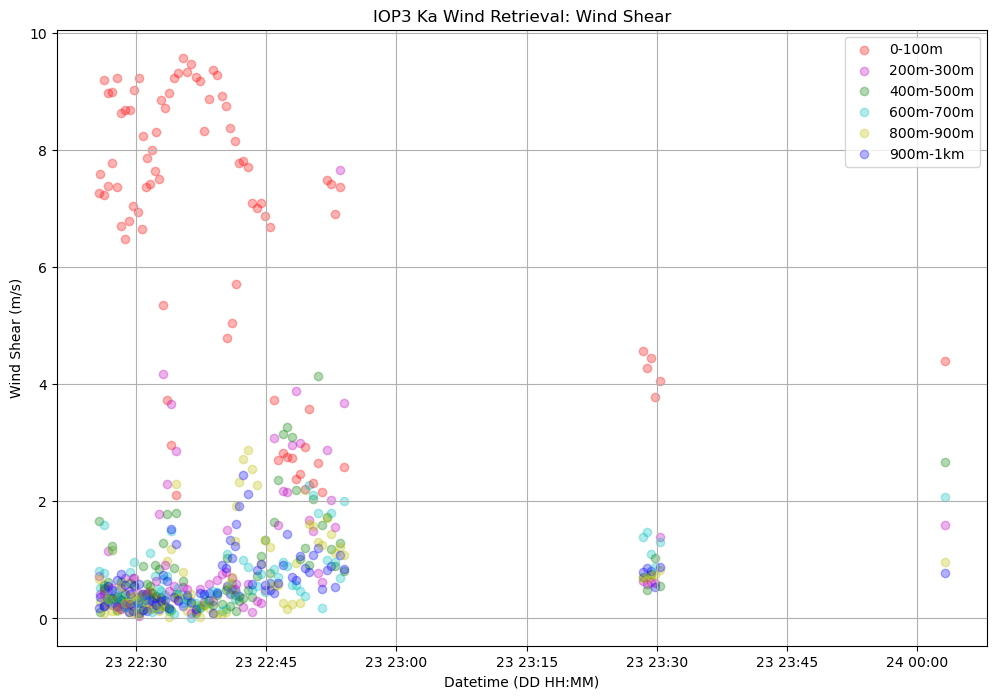

In [24]:
fig,ax = plt.subplots(figsize=[12,8],ncols=1)
ax.grid()
for thefile in vad_fileska1[9:]:

    radar = pyart.io.read_cfradial(thefile)
    print(thefile,radar.fixed_angle['data'])
    
    
    ka1gps['ddmmyy']+ka1gps['hhmmss[UTC]']
    ka1gps['datetime'] = [datetime.strptime(d,'%d%m%y%H%M%S') for d in ka1gps['ddmmyy']+ka1gps['hhmmss[UTC]']]
    beginscanindex = ka1gps.loc[ka1gps['datetime'] == datetime.strptime(radar.time['units'],'seconds since %Y-%m-%dT%H:%M:%SZ')].index+np.amin(np.unique(radar.time['data']))
    endscanindex = ka1gps.loc[ka1gps['datetime'] == datetime.strptime(radar.time['units'],'seconds since %Y-%m-%dT%H:%M:%SZ')].index+np.amax(np.unique(radar.time['data']))
    dfscan = ka1gps.iloc[beginscanindex[0].astype(int):endscanindex[0].astype(int)]
    dfscan = dfscan.astype({'Bearing[degrees]': 'float'})

    #print('velocity [kts]',dfscan['Velocity[knots]'].astype(float).mean(),'+-',dfscan['Velocity[knots]'].astype(float).var())
    speed = dfscan['Velocity[knots]'].astype(float).mean()
    #print('bearing',dfscan['Bearing[degrees]'].astype(float).mean(),'+-',dfscan['Bearing[degrees]'].astype(float).var())
    
#    bearing = 84.6
    if int(ka1scan.loc[ka1scan['Datetime'] == dfscan.datetime.values[0]].Deployment.values[0]) != 0:
        bearing = float(ka1scan.loc[ka1scan['Datetime'] == dfscan.datetime.values[0]].Heading.values[0])
    else:
        bearing = dfscan['Bearing[degrees]'].mean()
        
    if bearing == 80.06703703703703:
        bearing = 190
    elif (bearing == 64.25037037037036):
        bearing = 9.980000000000002
    elif (bearing == 89.28925925925924):
        bearing = 92.6
    elif bearing == 269.9640740740741:
        bearing = 90.6
    elif bearing == 206.84615384615387:
        bearing = 149.0
    elif bearing == 263.8211111111111:
        bearing = 90.2
    
    print('Bearing used: '+str(bearing))
    
    #print('latitude',dfscan['Latitude'].astype(float).mean(),'+-',dfscan['Latitude'].astype(float).var())
    lat = dfscan['Latitude'].astype(float).mean()
    #print('longitude',dfscan['Longitude'].astype(float).mean(),'+-',dfscan['Longitude'].astype(float).var())
    lon = dfscan['Longitude'].astype(float).mean()
    
    display = pyart.graph.RadarMapDisplay(radar)
    
    radar.azimuth['data']+=(bearing)%360
#     if (bearing>=0)&(bearing<=90):
#         (radar.azimuth['data'])+=(bearing*(-1)+90)%360
#     else:
#         (radar.azimuth['data'])+=360-(bearing*(-1)+90)%360

    VAD = pyart.retrieve.vad_browning(radar, 'corrected_velocity', z_want=np.arange(50,5001,10),gatefilter=None)
    u1 = VAD.u_wind
    v1 = VAD.v_wind
    
    
    u_shear = [u1[5]-u1[0],u1[15]-u1[5],u1[25]-u1[15]
               ,u1[35]-u1[25],u1[45]-u1[35],u1[55]-u1[45]
               ,u1[65]-u1[55],u1[75]-u1[65],u1[85]-u1[75]
               ,u1[95]-u1[85]]

    v_shear = [v1[5]-v1[0],v1[15]-v1[5],v1[25]-v1[15]
               ,v1[35]-v1[25],v1[45]-v1[35],v1[55]-v1[45]
               ,v1[65]-v1[55],v1[75]-v1[65],v1[85]-v1[75]
               ,v1[95]-v1[85]]
    wspd_shear = wind_speed(u_shear*units('m/s'),v_shear*units('m/s'))
    z_shear = np.arange(0.1,1.1,0.1)
    
    fwd_azimuth,back_azimuth,distance = geodesic.inv(dfscan['Longitude'].values[0], dfscan['Latitude'].values[0], 
                                                         storm_location.iloc[(storm_location['datetime']
                                                                              -dfscan['datetime'].values[0]).abs().argsort()[:1]]['Lon'].values, 
                                                         storm_location.iloc[(storm_location['datetime']
                                                                              -dfscan['datetime'].values[0]).abs().argsort()[:1]]['Lat'].values)

    dist = distance/1000
    bear = back_azimuth
    c = dfscan['datetime'].values[0]
    
    if bear == np.nan:
        continue
        
    line1=ax.scatter(dfscan['datetime'].values[0],wspd_shear[0],color='r',alpha=0.3)
    line2=ax.scatter(dfscan['datetime'].values[0],wspd_shear[2],color='m',alpha=0.3)
    line3=ax.scatter(dfscan['datetime'].values[0],wspd_shear[4],color='g',alpha=0.3)
    line4=ax.scatter(dfscan['datetime'].values[0],wspd_shear[6],color='c',alpha=0.3)
    line5=ax.scatter(dfscan['datetime'].values[0],wspd_shear[8],color='y',alpha=0.3)
    line6=ax.scatter(dfscan['datetime'].values[0],wspd_shear[9],color='b',alpha=0.3)
    

for thefile in vad_fileska2[28:]:

    radar = pyart.io.read_cfradial(thefile)
    print(thefile,radar.fixed_angle['data'])
    
    
    ka2gps['ddmmyy']+ka2gps['hhmmss[UTC]']
    ka2gps['datetime'] = [datetime.strptime(d,'%d%m%y%H%M%S') for d in ka2gps['ddmmyy']+ka2gps['hhmmss[UTC]']]
    beginscanindex = ka2gps.loc[ka2gps['datetime'] == datetime.strptime(radar.time['units'],'seconds since %Y-%m-%dT%H:%M:%SZ')].index+np.amin(np.unique(radar.time['data']))
    endscanindex = ka2gps.loc[ka2gps['datetime'] == datetime.strptime(radar.time['units'],'seconds since %Y-%m-%dT%H:%M:%SZ')].index+np.amax(np.unique(radar.time['data']))
    dfscan = ka2gps.iloc[beginscanindex[0].astype(int):endscanindex[0].astype(int)]
    dfscan = dfscan.astype({'Bearing[degrees]': 'float'})

    #print('velocity [kts]',dfscan['Velocity[knots]'].astype(float).mean(),'+-',dfscan['Velocity[knots]'].astype(float).var())
    speed = dfscan['Velocity[knots]'].astype(float).mean()
    #print('bearing',dfscan['Bearing[degrees]'].astype(float).mean(),'+-',dfscan['Bearing[degrees]'].astype(float).var())
    
#    bearing = 84.6
    if int(ka2scan.loc[ka2scan['Datetime'] == dfscan.datetime.values[0]].Deployment.values[0]) != 0:
        bearing = float(ka2scan.loc[ka2scan['Datetime'] == dfscan.datetime.values[0]].Heading.values[0])
    else:
        bearing = dfscan['Bearing[degrees]'].mean()
        
    if bearing == 80.06703703703703:
        bearing = 190
    elif (bearing == 64.25037037037036):
        bearing = 9.980000000000002
    elif (bearing == 89.28925925925924):
        bearing = 92.6
    elif bearing == 269.9640740740741:
        bearing = 90.6
    elif bearing == 206.84615384615387:
        bearing = 149.0
    elif bearing == 263.8211111111111:
        bearing = 90.2
 
    print('Bearing used: '+str(bearing))
    
    #print('latitude',dfscan['Latitude'].astype(float).mean(),'+-',dfscan['Latitude'].astype(float).var())
    lat = dfscan['Latitude'].astype(float).mean()
    #print('longitude',dfscan['Longitude'].astype(float).mean(),'+-',dfscan['Longitude'].astype(float).var())
    lon = dfscan['Longitude'].astype(float).mean()
    
    display = pyart.graph.RadarMapDisplay(radar)
    
    radar.azimuth['data']+=(bearing)%360
    
#     if (bearing>=0)&(bearing<=90):
#         (radar.azimuth['data'])+=(bearing*(-1)+90)%360
#     else:
#         (radar.azimuth['data'])+=360-(bearing*(-1)+90)%360

    VAD = pyart.retrieve.vad_browning(radar, 'corrected_velocity', z_want=np.arange(50,5001,10),gatefilter=None)
    u1 = VAD.u_wind
    v1 = VAD.v_wind
    
    u_shear = [u1[5]-u1[0],u1[15]-u1[5],u1[25]-u1[15]
               ,u1[35]-u1[25],u1[45]-u1[35],u1[55]-u1[45]
               ,u1[65]-u1[55],u1[75]-u1[65],u1[85]-u1[75]
               ,u1[95]-u1[85]]

    v_shear = [v1[5]-v1[0],v1[15]-v1[5],v1[25]-v1[15]
               ,v1[35]-v1[25],v1[45]-v1[35],v1[55]-v1[45]
               ,v1[65]-v1[55],v1[75]-v1[65],v1[85]-v1[75]
               ,v1[95]-v1[85]]
    wspd_shear = wind_speed(u_shear*units('m/s'),v_shear*units('m/s'))
    z_shear = np.arange(0.1,1.1,0.1)
    
    fwd_azimuth,back_azimuth,distance = geodesic.inv(dfscan['Longitude'].values[0], dfscan['Latitude'].values[0], 
                                                         storm_location.iloc[(storm_location['datetime']
                                                                              -dfscan['datetime'].values[0]).abs().argsort()[:1]]['Lon'].values, 
                                                         storm_location.iloc[(storm_location['datetime']
                                                                              -dfscan['datetime'].values[0]).abs().argsort()[:1]]['Lat'].values)

    dist = distance/1000
    bear = back_azimuth
    c = dfscan['datetime'].values[0]
    
    if bear == np.nan:
        continue
        
    line1=ax.scatter(dfscan['datetime'].values[0],wspd_shear[0],color='r',alpha=0.3)
    line2=ax.scatter(dfscan['datetime'].values[0],wspd_shear[2],color='m',alpha=0.3)
    line3=ax.scatter(dfscan['datetime'].values[0],wspd_shear[4],color='g',alpha=0.3)
    line4=ax.scatter(dfscan['datetime'].values[0],wspd_shear[6],color='c',alpha=0.3)
    line5=ax.scatter(dfscan['datetime'].values[0],wspd_shear[8],color='y',alpha=0.3)
    line6=ax.scatter(dfscan['datetime'].values[0],wspd_shear[9],color='b',alpha=0.3)
    
ax.legend([line1, line2, line3, line4, line5, line6], ['0-100m','200m-300m','400m-500m','600m-700m','800m-900m','900m-1km'])    
ax.set_xlabel('Datetime (DD HH:MM)')
ax.set_ylabel('Wind Shear (m/s)')
ax.set_title('IOP3 Ka Wind Retrieval: Wind Shear')
#ax.set_xlim([lidar_storm.iloc[0].datetime, pd.to_datetime('2022/06/12 23:03:00',format='%Y/%m/%d %H:%M:%S')])
#ax.set_ylim([0,50])
plt.savefig('E:/Lapenta/20220523/Figs/IOP3_ka_difshear.png',bbox_inches='tight',format='png',dpi=300)
plt.show()

E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222551.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222620.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222649.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222718.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222747.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222816.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222845.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6010.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222914.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222943.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223013.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223042.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223111.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223140.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223209.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223238.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6036.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223307.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223336.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223405.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223434.nc [37.001953 45.      ]
Bearing used: 190


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 5992.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523224032.nc [37.001953 45.      ]
Bearing used: 9.980000000000002


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523224101.nc [37.001953 45.      ]
Bearing used: 9.980000000000002


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6001.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523224130.nc [37.001953 45.      ]
Bearing used: 92.6


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523232822.nc [37.001953 45.      ]
Bearing used: 177.76296296296297


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523232852.nc [37.001953 45.      ]
Bearing used: 180.39961538461537


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6009.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523232921.nc [37.001953 45.      ]
Bearing used: 180.77923076923076


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6008.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523232950.nc [37.001953 45.      ]
Bearing used: 149.0


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523233019.nc [37.001953 45.      ]
Bearing used: 90.6


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6008.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220524000309.nc [37.001953 45.      ]
Bearing used: 90.2


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 5999.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222547.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222617.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222647.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222718.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222748.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222818.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222848.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222919.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222949.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223019.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223050.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223120.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6012.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223150.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223220.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6008.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223250.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223321.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223351.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223421.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223452.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223522.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223552.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223622.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223652.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223722.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223753.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223823.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223852.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223922.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223953.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224023.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224053.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6008.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224123.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6001.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224153.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224223.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224253.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224324.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224354.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224425.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224455.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224524.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224554.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224624.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224655.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224726.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224756.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224826.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224856.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224927.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224957.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6004.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523225027.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6012.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523225057.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523225128.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6008.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523225158.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523225228.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523225258.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523225328.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523225358.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters


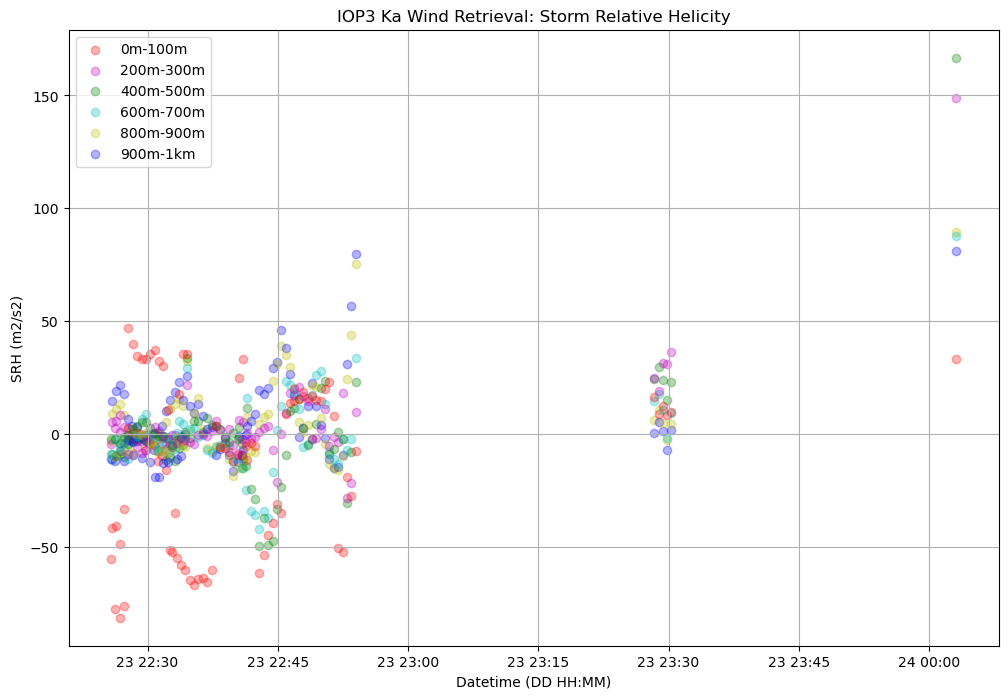

In [25]:
fig,ax = plt.subplots(figsize=[12,8],ncols=1)
ax.grid()
for thefile in vad_fileska1[9:]:

    radar = pyart.io.read_cfradial(thefile)
    print(thefile,radar.fixed_angle['data'])
    
    
    ka1gps['ddmmyy']+ka1gps['hhmmss[UTC]']
    ka1gps['datetime'] = [datetime.strptime(d,'%d%m%y%H%M%S') for d in ka1gps['ddmmyy']+ka1gps['hhmmss[UTC]']]
    beginscanindex = ka1gps.loc[ka1gps['datetime'] == datetime.strptime(radar.time['units'],'seconds since %Y-%m-%dT%H:%M:%SZ')].index+np.amin(np.unique(radar.time['data']))
    endscanindex = ka1gps.loc[ka1gps['datetime'] == datetime.strptime(radar.time['units'],'seconds since %Y-%m-%dT%H:%M:%SZ')].index+np.amax(np.unique(radar.time['data']))
    dfscan = ka1gps.iloc[beginscanindex[0].astype(int):endscanindex[0].astype(int)]
    dfscan = dfscan.astype({'Bearing[degrees]': 'float'})

    #print('velocity [kts]',dfscan['Velocity[knots]'].astype(float).mean(),'+-',dfscan['Velocity[knots]'].astype(float).var())
    speed = dfscan['Velocity[knots]'].astype(float).mean()
    #print('bearing',dfscan['Bearing[degrees]'].astype(float).mean(),'+-',dfscan['Bearing[degrees]'].astype(float).var())
    
#    bearing = 84.6
    if int(ka1scan.loc[ka1scan['Datetime'] == dfscan.datetime.values[0]].Deployment.values[0]) != 0:
        bearing = float(ka1scan.loc[ka1scan['Datetime'] == dfscan.datetime.values[0]].Heading.values[0])
    else:
        bearing = dfscan['Bearing[degrees]'].mean()
        
    if bearing == 80.06703703703703:
        bearing = 190
    elif (bearing == 64.25037037037036):
        bearing = 9.980000000000002
    elif (bearing == 89.28925925925924):
        bearing = 92.6
    elif bearing == 269.9640740740741:
        bearing = 90.6
    elif bearing == 206.84615384615387:
        bearing = 149.0
    elif bearing == 263.8211111111111:
        bearing = 90.2
    
    print('Bearing used: '+str(bearing))
    
    #print('latitude',dfscan['Latitude'].astype(float).mean(),'+-',dfscan['Latitude'].astype(float).var())
    lat = dfscan['Latitude'].astype(float).mean()
    #print('longitude',dfscan['Longitude'].astype(float).mean(),'+-',dfscan['Longitude'].astype(float).var())
    lon = dfscan['Longitude'].astype(float).mean()
    
    display = pyart.graph.RadarMapDisplay(radar)
    
    radar.azimuth['data']+=(bearing)%360
#     if (bearing>=0)&(bearing<=90):
#         (radar.azimuth['data'])+=(bearing*(-1)+90)%360
#     else:
#         (radar.azimuth['data'])+=360-(bearing*(-1)+90)%360

    VAD = pyart.retrieve.vad_browning(radar, 'corrected_velocity', z_want=np.arange(50,5001,10),gatefilter=None)
    u1 = VAD.u_wind
    v1 = VAD.v_wind
    z1 = VAD.height

    u_storm,v_storm = (wind_components(storm_location.iloc[(storm_location['datetime']-dfscan['datetime'].values[0]).abs().argsort()[:1]]['storm_vel'].values 
                                * units('m/s'), 
                               storm_location.iloc[(storm_location['datetime']-dfscan['datetime'].values[0]).abs().argsort()[:1]]['storm_dir'].values 
                                * units.deg))
    
    
    SRH1km = storm_relative_helicity(z1*units('m'),units.Quantity(u1,'m/s'),units.Quantity(v1,'m/s'),
                                  1*units('km'),bottom=900*units('m'),storm_u=u_storm,storm_v=v_storm)[2]
    SRH900m = storm_relative_helicity(z1*units('m'),units.Quantity(u1,'m/s'),units.Quantity(v1,'m/s'),
                                  900*units('m'),bottom=800*units('m'),storm_u=u_storm,storm_v=v_storm)[2]
    SRH700m = storm_relative_helicity(z1*units('m'),units.Quantity(u1,'m/s'),units.Quantity(v1,'m/s'),
                                  700*units('m'),bottom=600*units('m'),storm_u=u_storm,storm_v=v_storm)[2]
    SRH500m = storm_relative_helicity(z1*units('m'),units.Quantity(u1,'m/s'),units.Quantity(v1,'m/s'),
                                  500*units('m'),bottom=400*units('m'),storm_u=u_storm,storm_v=v_storm)[2]
    SRH300m = storm_relative_helicity(z1*units('m'),units.Quantity(u1,'m/s'),units.Quantity(v1,'m/s'),
                                  300*units('m'),bottom=200*units('m'),storm_u=u_storm,storm_v=v_storm)[2]
    SRH100m = storm_relative_helicity(z1*units('m'),units.Quantity(u1,'m/s'),units.Quantity(v1,'m/s'),
                                  100*units('m'),bottom=0*units('m'),storm_u=u_storm,storm_v=v_storm)[2]
    
    fwd_azimuth,back_azimuth,distance = geodesic.inv(dfscan['Longitude'].values[0], dfscan['Latitude'].values[0], 
                                                         storm_location.iloc[(storm_location['datetime']
                                                                              -dfscan['datetime'].values[0]).abs().argsort()[:1]]['Lon'].values, 
                                                         storm_location.iloc[(storm_location['datetime']
                                                                              -dfscan['datetime'].values[0]).abs().argsort()[:1]]['Lat'].values)

    dist = distance/1000
    bear = back_azimuth
    c = dfscan['datetime'].values[0]
    if bear == np.nan:
        continue
    
    line1=ax.scatter(dfscan['datetime'].values[0],SRH1km,color='b',alpha=0.3)
    line2=ax.scatter(dfscan['datetime'].values[0],SRH900m,color='y',alpha=0.3)
    line3=ax.scatter(dfscan['datetime'].values[0],SRH700m,color='c',alpha=0.3)
    line4=ax.scatter(dfscan['datetime'].values[0],SRH500m,color='g',alpha=0.3)
    line5=ax.scatter(dfscan['datetime'].values[0],SRH300m,color='m',alpha=0.3)
    line6=ax.scatter(dfscan['datetime'].values[0],SRH100m,color='r',alpha=0.3)

    
for thefile in vad_fileska2[28:]:

    radar = pyart.io.read_cfradial(thefile)
    print(thefile,radar.fixed_angle['data'])
    
    
    ka2gps['ddmmyy']+ka2gps['hhmmss[UTC]']
    ka2gps['datetime'] = [datetime.strptime(d,'%d%m%y%H%M%S') for d in ka2gps['ddmmyy']+ka2gps['hhmmss[UTC]']]
    beginscanindex = ka2gps.loc[ka2gps['datetime'] == datetime.strptime(radar.time['units'],'seconds since %Y-%m-%dT%H:%M:%SZ')].index+np.amin(np.unique(radar.time['data']))
    endscanindex = ka2gps.loc[ka2gps['datetime'] == datetime.strptime(radar.time['units'],'seconds since %Y-%m-%dT%H:%M:%SZ')].index+np.amax(np.unique(radar.time['data']))
    dfscan = ka2gps.iloc[beginscanindex[0].astype(int):endscanindex[0].astype(int)]
    dfscan = dfscan.astype({'Bearing[degrees]': 'float'})

    #print('velocity [kts]',dfscan['Velocity[knots]'].astype(float).mean(),'+-',dfscan['Velocity[knots]'].astype(float).var())
    speed = dfscan['Velocity[knots]'].astype(float).mean()
    #print('bearing',dfscan['Bearing[degrees]'].astype(float).mean(),'+-',dfscan['Bearing[degrees]'].astype(float).var())
    
#    bearing = 84.6
    if int(ka2scan.loc[ka2scan['Datetime'] == dfscan.datetime.values[0]].Deployment.values[0]) != 0:
        bearing = float(ka2scan.loc[ka2scan['Datetime'] == dfscan.datetime.values[0]].Heading.values[0])
    else:
        bearing = dfscan['Bearing[degrees]'].mean()
        
    if bearing == 80.06703703703703:
        bearing = 190
    elif (bearing == 64.25037037037036):
        bearing = 9.980000000000002
    elif (bearing == 89.28925925925924):
        bearing = 92.6
    elif bearing == 269.9640740740741:
        bearing = 90.6
    elif bearing == 206.84615384615387:
        bearing = 149.0
    elif bearing == 263.8211111111111:
        bearing = 90.2
 
    print('Bearing used: '+str(bearing))
    
    #print('latitude',dfscan['Latitude'].astype(float).mean(),'+-',dfscan['Latitude'].astype(float).var())
    lat = dfscan['Latitude'].astype(float).mean()
    #print('longitude',dfscan['Longitude'].astype(float).mean(),'+-',dfscan['Longitude'].astype(float).var())
    lon = dfscan['Longitude'].astype(float).mean()
    
    display = pyart.graph.RadarMapDisplay(radar)
    
    radar.azimuth['data']+=(bearing)%360
    
#     if (bearing>=0)&(bearing<=90):
#         (radar.azimuth['data'])+=(bearing*(-1)+90)%360
#     else:
#         (radar.azimuth['data'])+=360-(bearing*(-1)+90)%360

    VAD = pyart.retrieve.vad_browning(radar, 'corrected_velocity', z_want=np.arange(50,5001,10),gatefilter=None)
    u1 = VAD.u_wind
    v1 = VAD.v_wind
    z1 = VAD.height
    u_storm,v_storm = (wind_components(storm_location.iloc[(storm_location['datetime']-dfscan['datetime'].values[0]).abs().argsort()[:1]]['storm_vel'].values 
                                * units('m/s'), 
                               storm_location.iloc[(storm_location['datetime']-dfscan['datetime'].values[0]).abs().argsort()[:1]]['storm_dir'].values 
                                * units.deg))
    
    
    SRH1km = storm_relative_helicity(z1*units('m'),units.Quantity(u1,'m/s'),units.Quantity(v1,'m/s'),
                                  1*units('km'),bottom=900*units('m'),storm_u=u_storm,storm_v=v_storm)[2]
    SRH900m = storm_relative_helicity(z1*units('m'),units.Quantity(u1,'m/s'),units.Quantity(v1,'m/s'),
                                  900*units('m'),bottom=800*units('m'),storm_u=u_storm,storm_v=v_storm)[2]
    SRH700m = storm_relative_helicity(z1*units('m'),units.Quantity(u1,'m/s'),units.Quantity(v1,'m/s'),
                                  700*units('m'),bottom=600*units('m'),storm_u=u_storm,storm_v=v_storm)[2]
    SRH500m = storm_relative_helicity(z1*units('m'),units.Quantity(u1,'m/s'),units.Quantity(v1,'m/s'),
                                  500*units('m'),bottom=400*units('m'),storm_u=u_storm,storm_v=v_storm)[2]
    SRH300m = storm_relative_helicity(z1*units('m'),units.Quantity(u1,'m/s'),units.Quantity(v1,'m/s'),
                                  300*units('m'),bottom=200*units('m'),storm_u=u_storm,storm_v=v_storm)[2]
    SRH100m = storm_relative_helicity(z1*units('m'),units.Quantity(u1,'m/s'),units.Quantity(v1,'m/s'),
                                  100*units('m'),bottom=0*units('m'),storm_u=u_storm,storm_v=v_storm)[2]
    
    fwd_azimuth,back_azimuth,distance = geodesic.inv(dfscan['Longitude'].values[0], dfscan['Latitude'].values[0], 
                                                         storm_location.iloc[(storm_location['datetime']
                                                                              -dfscan['datetime'].values[0]).abs().argsort()[:1]]['Lon'].values, 
                                                         storm_location.iloc[(storm_location['datetime']
                                                                              -dfscan['datetime'].values[0]).abs().argsort()[:1]]['Lat'].values)

    dist = distance/1000
    bear = back_azimuth
    c = dfscan['datetime'].values[0]
    if bear == np.nan:
        continue
    
    line1=ax.scatter(dfscan['datetime'].values[0],SRH1km,color='b',alpha=0.3)
    line2=ax.scatter(dfscan['datetime'].values[0],SRH900m,color='y',alpha=0.3)
    line3=ax.scatter(dfscan['datetime'].values[0],SRH700m,color='c',alpha=0.3)
    line4=ax.scatter(dfscan['datetime'].values[0],SRH500m,color='g',alpha=0.3)
    line5=ax.scatter(dfscan['datetime'].values[0],SRH300m,color='m',alpha=0.3)
    line6=ax.scatter(dfscan['datetime'].values[0],SRH100m,color='r',alpha=0.3)

ax.legend([line6,line5,line4,line3,line2,line1], ['0m-100m','200m-300m','400m-500m','600m-700m','800m-900m','900m-1km'])    
ax.set_xlabel('Datetime (DD HH:MM)')
ax.set_ylabel('SRH (m2/s2)')
ax.set_title('IOP3 Ka Wind Retrieval: Storm Relative Helicity')
#ax.set_xlim([lidar_storm.iloc[0].datetime, pd.to_datetime('2022/06/12 23:03:00',format='%Y/%m/%d %H:%M:%S')])
#ax.set_ylim([-700,700])
plt.savefig('E:/Lapenta/20220523/Figs/IOP3_kaSRH_layers.png',bbox_inches='tight',format='png',dpi=300)
plt.show()

In [19]:
ds = xr.open_dataset('E:/Lapenta/20220523/Lidar/dltruckdlcsmwindsDL2.d1.20220523.000000.cdf',decode_times=False)
ds['time'] = [dt.datetime.utcfromtimestamp(ds['base_time'].values + s) for s in ds['time_offset'].values]

ds1 = xr.open_dataset('E:/Lapenta/20220523/Lidar/dltruckdlcsmwindsDL2.d1.20220524.000000.cdf',decode_times=False)
ds1['time'] = [dt.datetime.utcfromtimestamp(ds1['base_time'].values + s) for s in ds1['time_offset'].values]

testing = xr.concat([ds,ds1.isel(time=slice(0,283))],dim='time')
# testing1 = testing.where(testing.wspd < 40, drop=True)
# testing2 = testing1.where(testing1.r_sq > 0.95, drop=True)
# testing3 = testing2.where(testing2.height < 3, drop=True)
# testing44 = testing3.where(testing3.intensity < 1.01, drop=True)

In [20]:
df = pd.read_csv('E:/Lapenta/20220523/Lidar/Lidar_220523_QC_met.dat', names=['ID','Time','Lat','Lon','Alt','Tfast','Tslow','RH','P','Dir','Spd','qc1','qc2','qc3','qc4'], delim_whitespace=True)

In [21]:
Hours = df.Time
Minutes = 60 * (Hours % 1)
Seconds = 60 * (Minutes % 1)
time_new1=[]
for i,j,k in zip(Hours, Minutes, Seconds):
    if i > 23.99999:
        Hours = i%24
        time_new = "2022/05/24 %02d:%02d:%02d" % (Hours,j,k)
        time_new1.append(time_new)
    else:
        time_new = "2022/05/23 %d:%02d:%02d" % (i,j,k)
        time_new1.append(time_new)
df['datetime']=pd.to_datetime(time_new1,format='%Y/%m/%d %H:%M:%S')

In [22]:
lidarObs=df.loc[(df.qc2==1)&(df.qc3==0)]
lidar_storm = lidarObs.iloc[((lidarObs['datetime']-storm_location['datetime'][0]).abs().argsort()[:1].values[0]):
                           ((lidarObs['datetime']-storm_location['datetime'][len(storm_location)-1]).abs().argsort()[:1].values[0])+1]

2022-05-23T19:18:58.000000000 5.946837214471928 [80.3544994]
2022-05-23T19:19:27.873418000 6.8827447929337415 [80.3544994]
2022-05-23T19:19:57.822785000 6.243869886998038 [80.3544994]
2022-05-23T19:20:27.825000000 6.1494484976018935 [80.3544994]
2022-05-23T19:20:57.784810000 8.304115806459397 [80.3544994]
2022-05-23T19:21:26.042253000 9.50609042591393 [80.3544994]
2022-05-23T19:22:02.087719000 9.029137272463327 [80.3544994]
2022-05-23T19:22:27.800000000 8.372343893423947 [80.3544994]
2022-05-23T19:22:57.759494000 11.59227721926624 [80.3544994]
2022-05-23T19:23:27.949367000 7.4434619664778365 [80.3544994]
2022-05-23T19:23:57.734177000 8.444610829852161 [80.3544994]
2022-05-23T19:24:27.848101000 6.398113876991821 [80.3544994]
2022-05-23T19:25:00.200000000 7.032575439018585 [80.3544994]
2022-05-23T19:25:27.708861000 8.881351225595433 [80.3544994]
2022-05-23T19:25:57.962025000 8.37278364479298 [80.3544994]
2022-05-23T19:26:27.696203000 7.32985698800823 [80.3544994]
2022-05-23T19:26:57.7848

C:\Users\joshu\AppData\Local\Temp\ipykernel_23160\340414205.py:97: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_xticklabels(fff, fontsize=10, fontweight='bold')
C:\Users\joshu\AppData\Local\Temp\ipykernel_23160\340414205.py:103: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_xticklabels(fff, fontsize=10, fontweight='bold')
C:\Users\joshu\.conda\envs\ox\Lib\site-packages\numpy\ma\extras.py:290: UserWarning: Warning: converting a masked element to nan.
  _d = func(tuple([np.asarray(a) for a in x]), *args, **params)
C:\Users\joshu\.conda\envs\ox\Lib\site-packages\numpy\core\fromnumeric.py:2009: UserWarning: Warning: converting a masked element to nan.
  result = asarray(a).shape


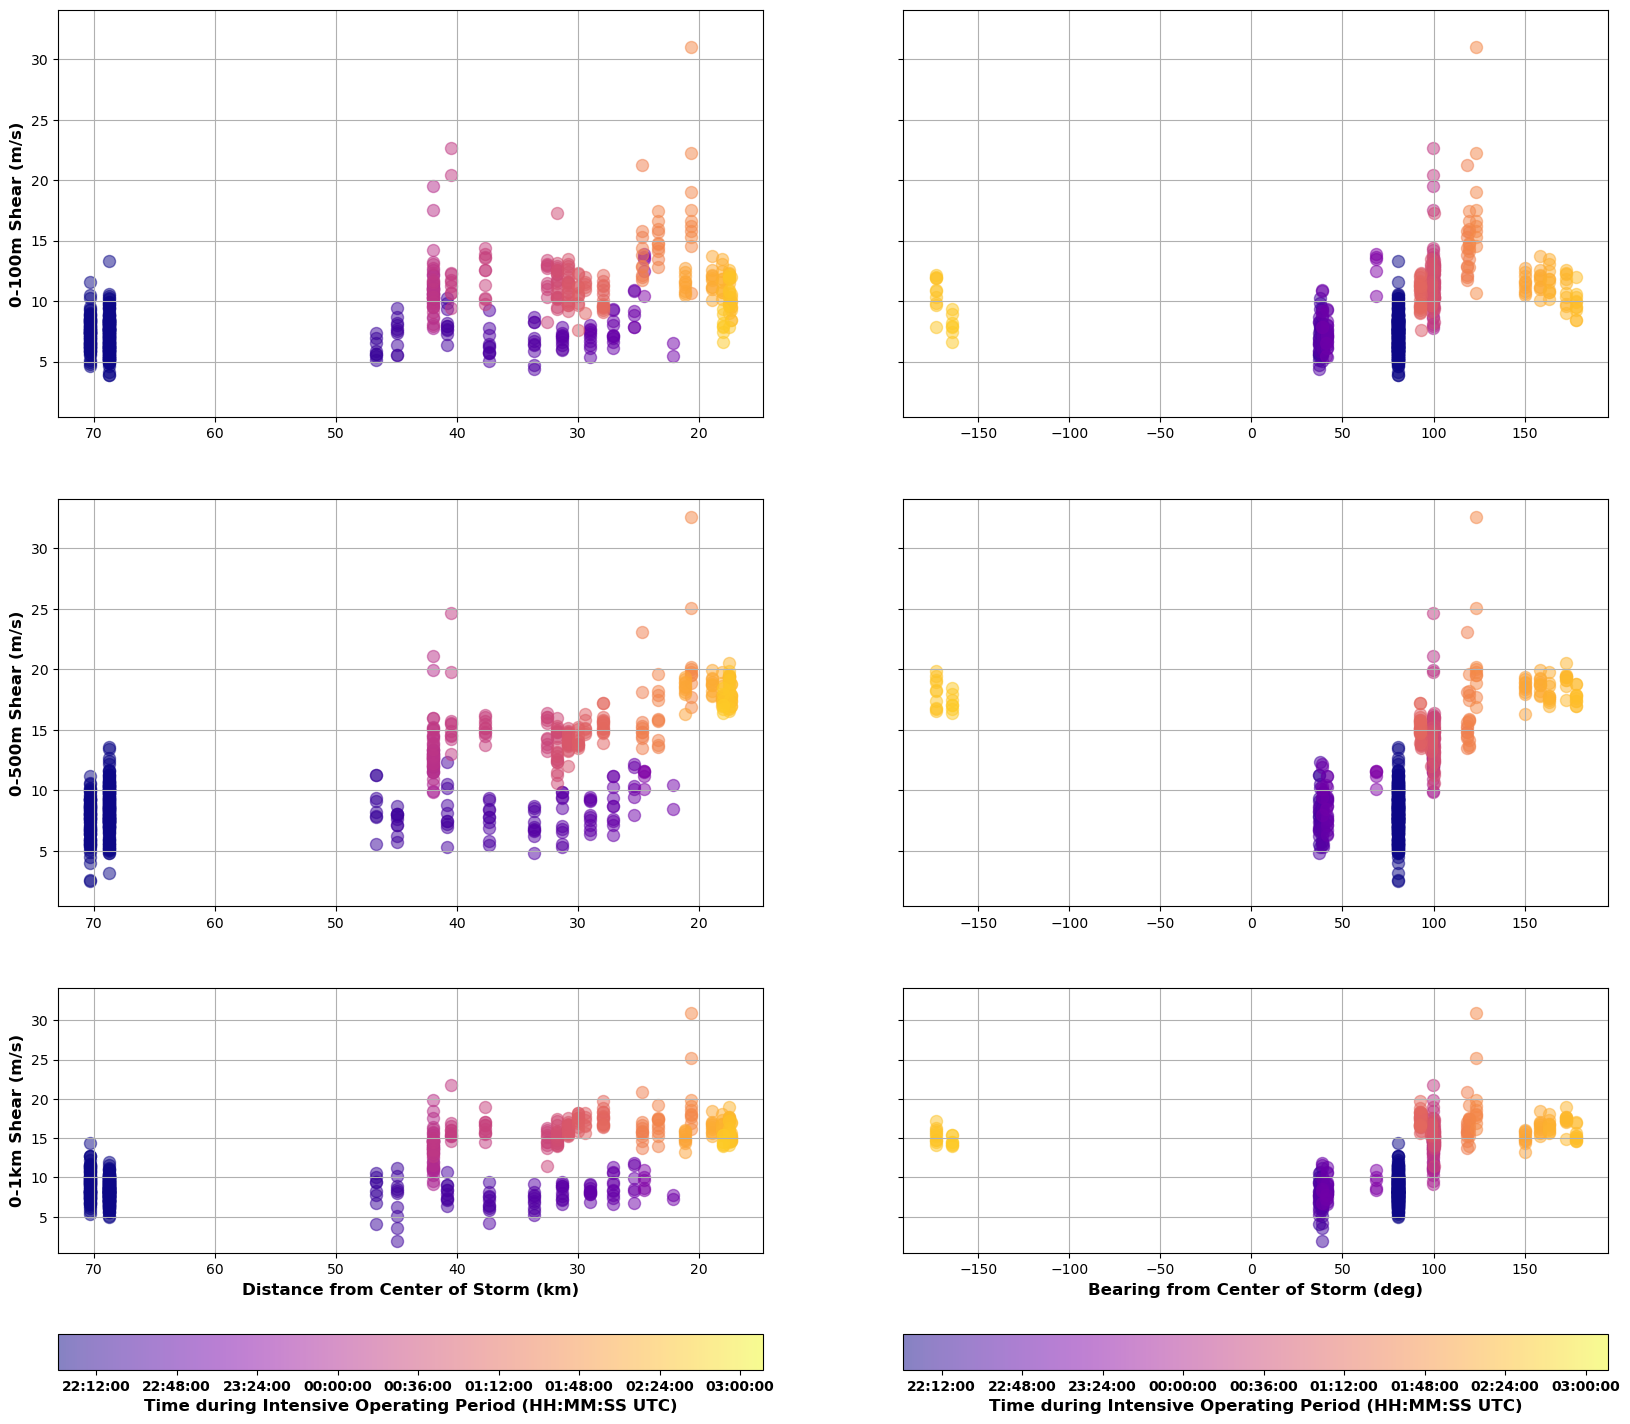

In [39]:
geodesic = pyproj.Geod(ellps='WGS84')
#plt.rcParams["figure.figsize"] = [20, 20]
#plt.rcParams["figure.autolayout"] = True
fig, ax = plt.subplots(3,2, figsize=(20,18),sharey=True)
ax[0,0].grid()
ax[0,1].grid()
ax[1,0].grid()
ax[1,1].grid()
ax[2,0].grid()
ax[2,1].grid()

norm = mpl.colors.Normalize(vmin=mdates.date2num(storm_location.datetime)[0], vmax=mdates.date2num(storm_location.datetime[len(storm_location)-1]))
for i in np.arange(0,len(testing.time)-2):
#     if i == 178:
#         continue
#     else:
    test = testing.isel(time=slice(i, i+1))
    #print(test.time.values)
#     test1 = test.where(test.wspd < 40, drop=True)
#     test2 = test1.where(test1.r_sq > 0.95, drop=True)
#     test3 = test2.where(test2.height < 3, drop=True)
#     test4 = test3.where(test3.intensity < 1.01, drop=True)

    u_mob,v_mob = (wind_components(lidar_storm.iloc[(lidar_storm['datetime']-test.time.values[0]).abs().argsort()[:1]]['Spd'].values 
                                * units('knots').to((units.m)/(units.s)), 
                               lidar_storm.iloc[(lidar_storm['datetime']-test.time.values[0]).abs().argsort()[:1]]['Dir'].values 
                                * units.deg))
    u = test['u'][0].values[2:]
    v = test['v'][0].values[2:]
    z = test['height'].values[2:]

    u = np.insert(u, 0, u_mob.magnitude, axis=0)
    v = np.insert(v, 0, v_mob.magnitude, axis=0)
    z = np.insert(z, 0, 0., axis=0)

    # define data with variable attributes
    data_vars = {'u':(['height'], u, 
                             {'units': 'm/s', 
                              'long_name':'ucomponent'}),
                 'v':(['height'], v, 
                             {'units': 'm/s', 
                              'long_name':'vcomponent'})}

    # define coordinates
    coords = {'height': (['height'], z)}

    # create dataset
    testnew = xr.Dataset(data_vars=data_vars, coords=coords)

    u1 = testnew['u'].interp(height=np.arange(0,3.010,0.010))
    v1 = testnew['v'].interp(height=np.arange(0,3.010,0.010))
    z1 = np.arange(0,3.010,0.010)
    u_shear = [u1[10].values-u1[0].values,u1[20].values-u1[0].values,u1[30].values-u1[0].values
               ,u1[40].values-u1[0].values,u1[50].values-u1[0].values,u1[60].values-u1[0].values
               ,u1[70].values-u1[0].values,u1[80].values-u1[0].values,u1[90].values-u1[0].values
               ,u1[100].values-u1[0].values]

    v_shear = [v1[10].values-v1[0].values,v1[20].values-v1[0].values,v1[30].values-v1[0].values
               ,v1[40].values-v1[0].values,v1[50].values-v1[0].values,v1[60].values-v1[0].values
               ,v1[70].values-v1[0].values,v1[80].values-v1[0].values,v1[90].values-v1[0].values
               ,v1[100].values-v1[0].values]
    wspd_shear = wind_speed(u_shear*units('m/s'),v_shear*units('m/s'))
    z_shear = np.arange(0.1,1.1,0.1)
    fwd_azimuth,back_azimuth,distance = geodesic.inv(test.lon.values, test.lat.values, 
                                                         storm_location.iloc[(storm_location['datetime']
                                                                              -test.time.values[0]).abs().argsort()[:1]]['Lon'].values, 
                                                         storm_location.iloc[(storm_location['datetime']
                                                                              -test.time.values[0]).abs().argsort()[:1]]['Lat'].values)

    dist = distance/1000
    bear = back_azimuth
    c = test.time.values[0]
    
    if bear<0:
        bear = bear+360
    
    img=ax[2,0].scatter(dist,wspd_shear[9], c=mdates.date2num(c), marker = 'o', cmap='plasma', alpha=0.5, s=75, norm=norm)
    ax[1,0].scatter(dist,wspd_shear[4], c=mdates.date2num(c), marker = 'o', cmap='plasma', alpha=0.5, s=75, norm=norm)
    ax[0,0].scatter(dist,wspd_shear[0], c=mdates.date2num(c), marker = 'o', cmap='plasma', alpha=0.5, s=75, norm=norm)

    ax[2,1].scatter(bear,wspd_shear[9], c=mdates.date2num(c), marker = 'o', cmap='plasma', alpha=0.5, s=75, norm=norm)
    ax[1,1].scatter(bear,wspd_shear[4], c=mdates.date2num(c), marker = 'o', cmap='plasma', alpha=0.5, s=75, norm=norm)
    ax[0,1].scatter(bear,wspd_shear[0], c=mdates.date2num(c), marker = 'o', cmap='plasma', alpha=0.5, s=75, norm=norm)   

ax[0,0].invert_xaxis()
ax[1,0].invert_xaxis()
ax[2,0].invert_xaxis()
ax[2,0].set_xlabel('Distance from Center of Storm (km)', fontsize=12, fontweight='bold')
ax[2,1].set_xlabel('Bearing from Center of Storm (deg)', fontsize=12, fontweight='bold')
ax[0,0].set_ylabel('0-100m Shear (m/s)', fontsize=12, fontweight='bold')
ax[1,0].set_ylabel('0-500m Shear (m/s)', fontsize=12, fontweight='bold')
ax[2,0].set_ylabel('0-1km Shear (m/s)', fontsize=12, fontweight='bold')

cbar = fig.colorbar(img, ax=ax[2, 0], location='bottom',pad=0.2)
ff = mdates.num2date(cbar.ax.get_xticks())
fff = [date_obj.strftime('%H:%M:%S') for date_obj in ff]
cbar.ax.set_xticklabels(fff, fontsize=10, fontweight='bold')
cbar.set_label('Time during Intensive Operating Period (HH:MM:SS UTC)', fontsize=12, fontweight='bold')

cbar = fig.colorbar(img, ax=ax[2, 1], location='bottom',pad=0.2)
ff = mdates.num2date(cbar.ax.get_xticks())
fff = [date_obj.strftime('%H:%M:%S') for date_obj in ff]
cbar.ax.set_xticklabels(fff, fontsize=10, fontweight='bold')
cbar.set_label('Time during Intensive Operating Period (HH:MM:SS UTC)', fontsize=12, fontweight='bold')

    
plt.savefig('E:/Lapenta/20220523/Figs/IOP3_lidarshear_4d.png',bbox_inches='tight',format='png',dpi=300)
plt.show()

C:\Users\joshu\.conda\envs\ox\Lib\site-packages\numpy\ma\extras.py:290: UserWarning: Warning: converting a masked element to nan.
  _d = func(tuple([np.asarray(a) for a in x]), *args, **params)
C:\Users\joshu\.conda\envs\ox\Lib\site-packages\numpy\core\fromnumeric.py:2009: UserWarning: Warning: converting a masked element to nan.
  result = asarray(a).shape


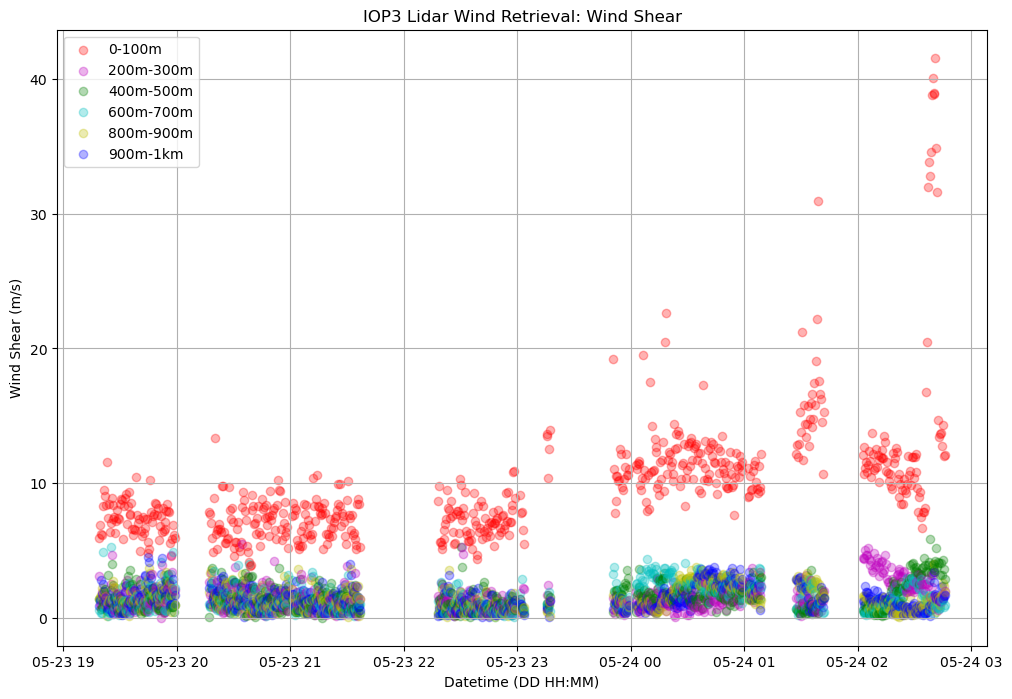

In [69]:
fig,ax = plt.subplots(figsize=[12,8],ncols=1)
ax.grid()
geodesic = pyproj.Geod(ellps='WGS84')
for i in np.arange(0,len(testing.time)-2):
    
    test = testing.isel(time=slice(i, i+1))
    #print(test.time.values)
#     test1 = test.where(test.wspd < 40, drop=True)
#     test2 = test1.where(test1.r_sq > 0.95, drop=True)
#     test3 = test2.where(test2.height < 3, drop=True)
#     test4 = test3.where(test3.intensity < 1.01, drop=True)
    
    u_mob,v_mob = (wind_components(lidar_storm.iloc[(lidar_storm['datetime']-test.time.values[0]).abs().argsort()[:1]]['Spd'].values 
                                * units('knots').to((units.m)/(units.s)), 
                               lidar_storm.iloc[(lidar_storm['datetime']-test.time.values[0]).abs().argsort()[:1]]['Dir'].values 
                                * units.deg))
    u = test['u'][0].values[2:]
    v = test['v'][0].values[2:]
    z = test['height'].values[2:]

    u = np.insert(u, 0, u_mob.magnitude, axis=0)
    v = np.insert(v, 0, v_mob.magnitude, axis=0)
    z = np.insert(z, 0, 0., axis=0)

    # define data with variable attributes
    data_vars = {'u':(['height'], u, 
                             {'units': 'm/s', 
                              'long_name':'ucomponent'}),
                 'v':(['height'], v, 
                             {'units': 'm/s', 
                              'long_name':'vcomponent'})}

    # define coordinates
    coords = {'height': (['height'], z)}

    # create dataset
    testnew = xr.Dataset(data_vars=data_vars, coords=coords)

    u1 = testnew['u'].interp(height=np.arange(0,3.010,0.010))
    v1 = testnew['v'].interp(height=np.arange(0,3.010,0.010))
    z1 = np.arange(0,3.010,0.010)
    u_shear = [u1[10].values-u1[0].values,u1[20].values-u1[10].values,u1[30].values-u1[20].values
               ,u1[40].values-u1[30].values,u1[50].values-u1[40].values,u1[60].values-u1[50].values
               ,u1[70].values-u1[60].values,u1[80].values-u1[70].values,u1[90].values-u1[80].values
               ,u1[100].values-u1[90].values]

    v_shear = [v1[10].values-v1[0].values,v1[20].values-v1[10].values,v1[30].values-v1[20].values
               ,v1[40].values-v1[30].values,v1[50].values-v1[40].values,v1[60].values-v1[50].values
               ,v1[70].values-v1[60].values,v1[80].values-v1[70].values,v1[90].values-v1[80].values
               ,v1[100].values-v1[90].values]
    wspd_shear = wind_speed(u_shear*units('m/s'),v_shear*units('m/s'))
    z_shear = np.arange(0.1,1.1,0.1)
    
    fwd_azimuth,back_azimuth,distance = geodesic.inv(test.lon.values, test.lat.values, 
                                                         storm_location.iloc[(storm_location['datetime']
                                                                              -test.time.values[0]).abs().argsort()[:1]]['Lon'].values, 
                                                         storm_location.iloc[(storm_location['datetime']
                                                                              -test.time.values[0]).abs().argsort()[:1]]['Lat'].values)

    dist = distance/1000
    bear = back_azimuth
    c = test.time.values[0]

    
    line1=ax.scatter(test.time.values,wspd_shear[0],color='r',alpha=0.3)
    line2=ax.scatter(test.time.values,wspd_shear[2],color='m',alpha=0.3)
    line3=ax.scatter(test.time.values,wspd_shear[4],color='g',alpha=0.3)
    line4=ax.scatter(test.time.values,wspd_shear[6],color='c',alpha=0.3)
    line5=ax.scatter(test.time.values,wspd_shear[8],color='y',alpha=0.3)
    line6=ax.scatter(test.time.values,wspd_shear[9],color='b',alpha=0.3)
ax.legend([line1, line2, line3, line4, line5, line6], ['0-100m','200m-300m','400m-500m','600m-700m','800m-900m','900m-1km'])    
ax.set_xlabel('Datetime (DD HH:MM)')
ax.set_ylabel('Wind Shear (m/s)')
ax.set_title('IOP3 Lidar Wind Retrieval: Wind Shear')
#ax.set_xlim([lidar_storm.iloc[0].datetime, pd.to_datetime('2022/06/12 23:03:00',format='%Y/%m/%d %H:%M:%S')])
#ax.set_ylim([0,50])
plt.savefig('E:/Lapenta/20220523/Figs/IOP3_lidarshear_difshear.png',bbox_inches='tight',format='png',dpi=300)
plt.show()

C:\Users\joshu\AppData\Local\Temp\ipykernel_23160\1867289223.py:97: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_xticklabels(fff, fontsize=10, fontweight='bold')
C:\Users\joshu\AppData\Local\Temp\ipykernel_23160\1867289223.py:103: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_xticklabels(fff, fontsize=10, fontweight='bold')
C:\Users\joshu\.conda\envs\ox\Lib\site-packages\numpy\ma\extras.py:290: UserWarning: Warning: converting a masked element to nan.
  _d = func(tuple([np.asarray(a) for a in x]), *args, **params)
C:\Users\joshu\.conda\envs\ox\Lib\site-packages\numpy\core\fromnumeric.py:2009: UserWarning: Warning: converting a masked element to nan.
  result = asarray(a).shape


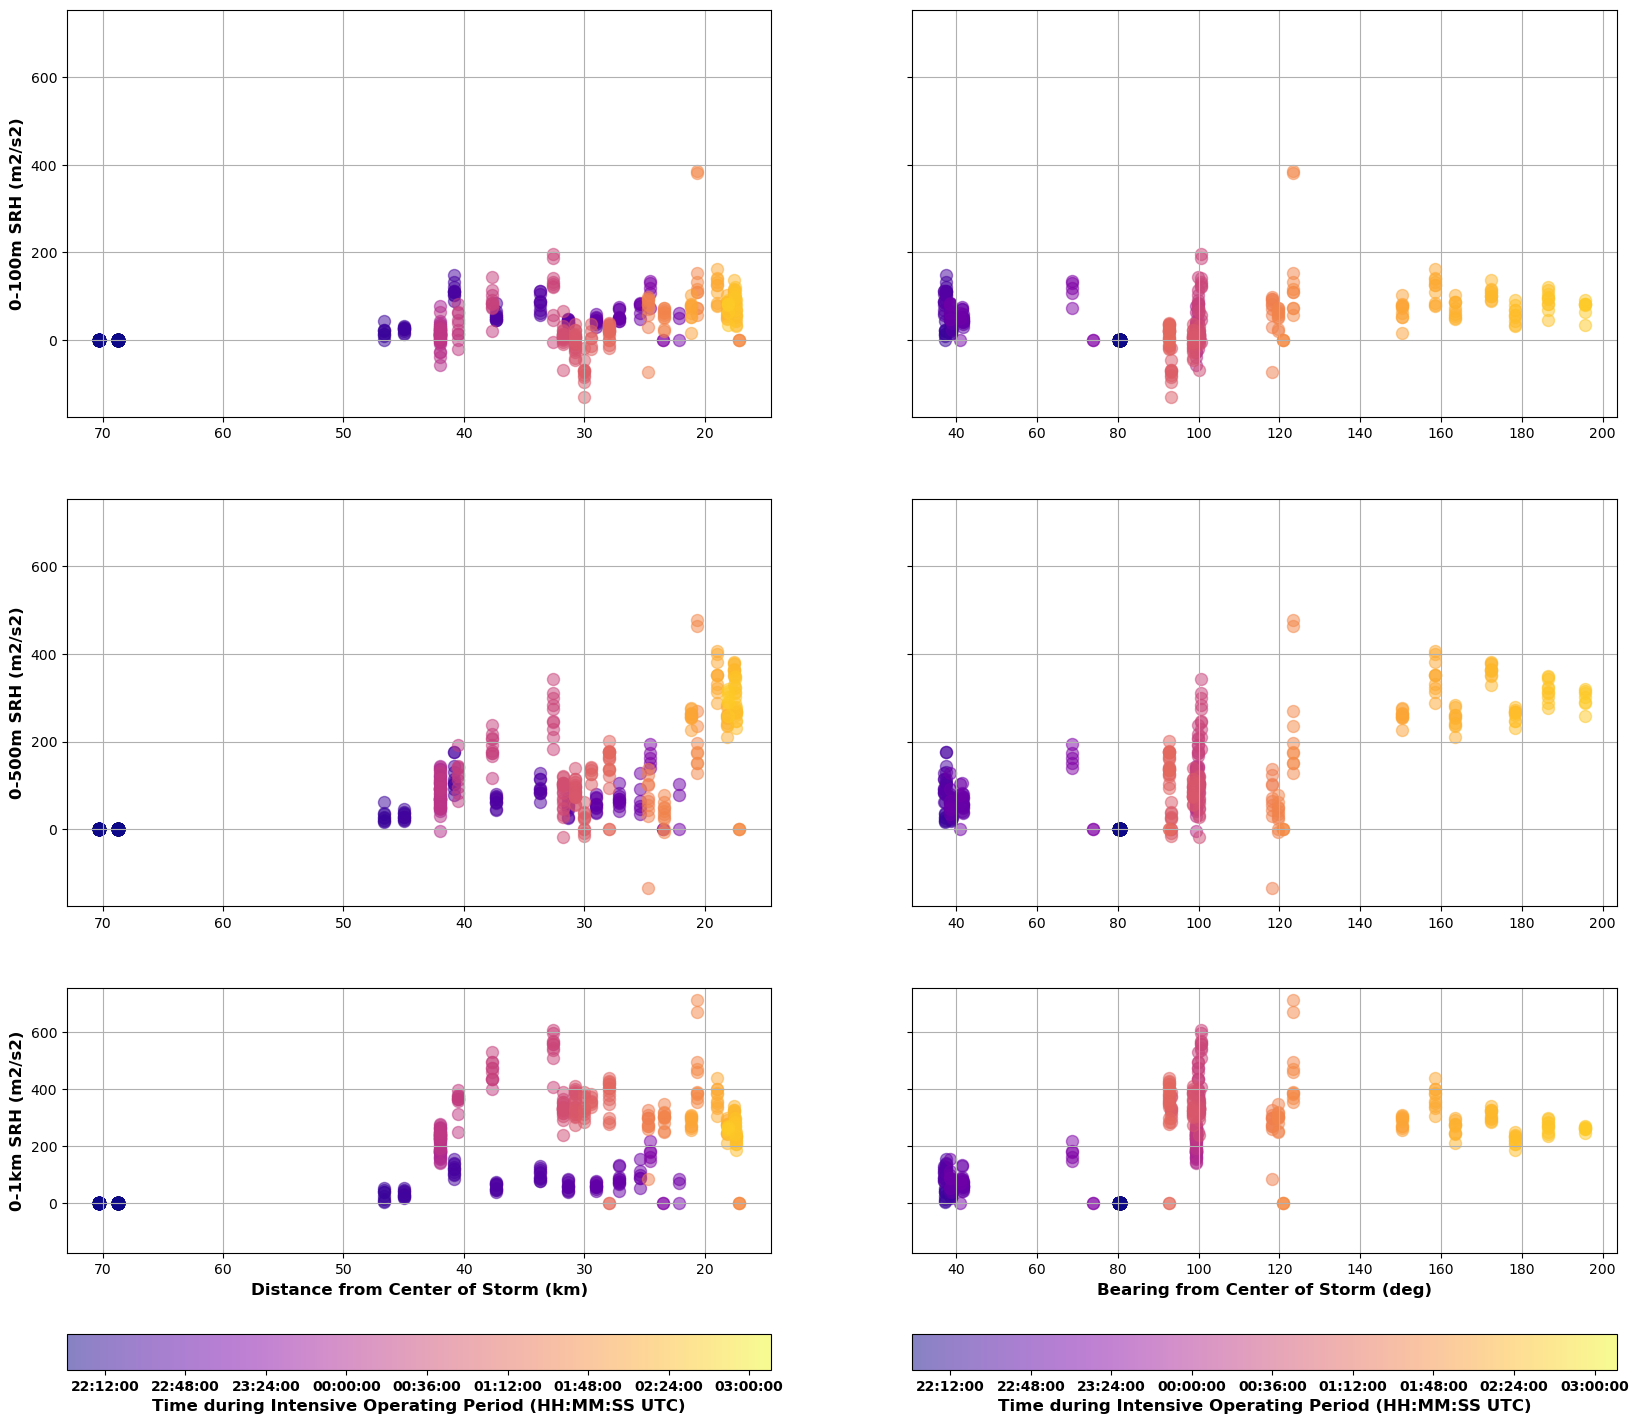

In [33]:
geodesic = pyproj.Geod(ellps='WGS84')
#plt.rcParams["figure.figsize"] = [20, 20]
#plt.rcParams["figure.autolayout"] = True
fig, ax = plt.subplots(3,2, figsize=(20,18),sharey=True)
ax[0,0].grid()
ax[0,1].grid()
ax[1,0].grid()
ax[1,1].grid()
ax[2,0].grid()
ax[2,1].grid()

norm = mpl.colors.Normalize(vmin=mdates.date2num(storm_location.datetime)[0], vmax=mdates.date2num(storm_location.datetime[len(storm_location)-1]))

for i in np.arange(0,len(testing.time)-2):
#     if i == 178:
#         continue
#     else:
        
    test = testing.isel(time=slice(i, i+1))

    u_mob,v_mob = (wind_components(lidar_storm.iloc[(lidar_storm['datetime']-test.time.values[0]).abs().argsort()[:1]]['Spd'].values 
                                * units('knots').to((units.m)/(units.s)), 
                               lidar_storm.iloc[(lidar_storm['datetime']-test.time.values[0]).abs().argsort()[:1]]['Dir'].values 
                                * units.deg))
    u = test['u'][0].values[2:]
    v = test['v'][0].values[2:]
    z = test['height'].values[2:]

    u = np.insert(u, 0, u_mob.magnitude, axis=0)
    v = np.insert(v, 0, v_mob.magnitude, axis=0)
    z = np.insert(z, 0, 0., axis=0)

    # define data with variable attributes
    data_vars = {'u':(['height'], u, 
                             {'units': 'm/s', 
                              'long_name':'ucomponent'}),
                 'v':(['height'], v, 
                             {'units': 'm/s', 
                              'long_name':'vcomponent'})}

    # define coordinates
    coords = {'height': (['height'], z)}

    # create dataset
    testnew = xr.Dataset(data_vars=data_vars, coords=coords)

    u1 = testnew['u'].interp(height=np.arange(0,3.010,0.010))
    v1 = testnew['v'].interp(height=np.arange(0,3.010,0.010))
    z1 = np.arange(0,3.010,0.010)

    u_storm,v_storm = (wind_components(storm_location.iloc[(storm_location['datetime']-test.time.values[0]).abs().argsort()[:1]]['storm_vel'].values 
                                * units('m/s'), 
                               storm_location.iloc[(storm_location['datetime']-test.time.values[0]).abs().argsort()[:1]]['storm_dir'].values 
                                * units.deg))
    #print(u_storm,v_storm)

    SRH1km = storm_relative_helicity(z1*units('km'),u1*units('m/s'),v1*units('m/s'),
                                  1*units('km'),storm_u=u_storm,storm_v=v_storm)[2]
    SRH500m = storm_relative_helicity(z1*units('km'),u1*units('m/s'),v1*units('m/s'),
                                  500*units('m'),storm_u=u_storm,storm_v=v_storm)[2]
    SRH100m = storm_relative_helicity(z1*units('km'),u1*units('m/s'),v1*units('m/s'),
                                  100*units('m'),storm_u=u_storm,storm_v=v_storm)[2]

    fwd_azimuth,back_azimuth,distance = geodesic.inv(test.lon.values, test.lat.values, 
                                                     storm_location.iloc[(storm_location['datetime']
                                                                          -test.time.values[0]).abs().argsort()[:1]]['Lon'].values, 
                                                     storm_location.iloc[(storm_location['datetime']
                                                                          -test.time.values[0]).abs().argsort()[:1]]['Lat'].values)

    dist = distance/1000
    bear = back_azimuth
    c = test.time.values[0]

    if bear<0:
        bear = bear+360

    img=ax[2,0].scatter(dist,SRH1km, c=mdates.date2num(c), marker = 'o', cmap='plasma', alpha=0.5, s=75, norm=norm)
    ax[1,0].scatter(dist,SRH500m, c=mdates.date2num(c), marker = 'o', cmap='plasma', alpha=0.5, s=75, norm=norm)
    ax[0,0].scatter(dist,SRH100m, c=mdates.date2num(c), marker = 'o', cmap='plasma', alpha=0.5, s=75, norm=norm)

    ax[2,1].scatter(bear,SRH1km, c=mdates.date2num(c), marker = 'o', cmap='plasma', alpha=0.5, s=75, norm=norm)
    ax[1,1].scatter(bear,SRH500m, c=mdates.date2num(c), marker = 'o', cmap='plasma', alpha=0.5, s=75, norm=norm)
    ax[0,1].scatter(bear,SRH100m, c=mdates.date2num(c), marker = 'o', cmap='plasma', alpha=0.5, s=75, norm=norm)   

ax[0,0].invert_xaxis()
ax[1,0].invert_xaxis()
ax[2,0].invert_xaxis()
ax[2,0].set_xlabel('Distance from Center of Storm (km)', fontsize=12, fontweight='bold')
ax[2,1].set_xlabel('Bearing from Center of Storm (deg)', fontsize=12, fontweight='bold')
ax[0,0].set_ylabel('0-100m SRH (m2/s2)', fontsize=12, fontweight='bold')
ax[1,0].set_ylabel('0-500m SRH (m2/s2)', fontsize=12, fontweight='bold')
ax[2,0].set_ylabel('0-1km SRH (m2/s2)', fontsize=12, fontweight='bold')

cbar = fig.colorbar(img, ax=ax[2, 0], location='bottom',pad=0.2)
ff = mdates.num2date(cbar.ax.get_xticks())
fff = [date_obj.strftime('%H:%M:%S') for date_obj in ff]
cbar.ax.set_xticklabels(fff, fontsize=10, fontweight='bold')
cbar.set_label('Time during Intensive Operating Period (HH:MM:SS UTC)', fontsize=12, fontweight='bold')

cbar = fig.colorbar(img, ax=ax[2, 1], location='bottom',pad=0.2)
ff = mdates.num2date(cbar.ax.get_xticks())
fff = [date_obj.strftime('%H:%M:%S') for date_obj in ff]
cbar.ax.set_xticklabels(fff, fontsize=10, fontweight='bold')
cbar.set_label('Time during Intensive Operating Period (HH:MM:SS UTC)', fontsize=12, fontweight='bold')


plt.savefig('E:/Lapenta/20220523/Figs/IOP3_lidarSRH_4d.png',bbox_inches='tight',format='png',dpi=300)
#ax.legend([img,img1,img2], ['0-100m', '0-500m', '0-1km'])  
plt.show()

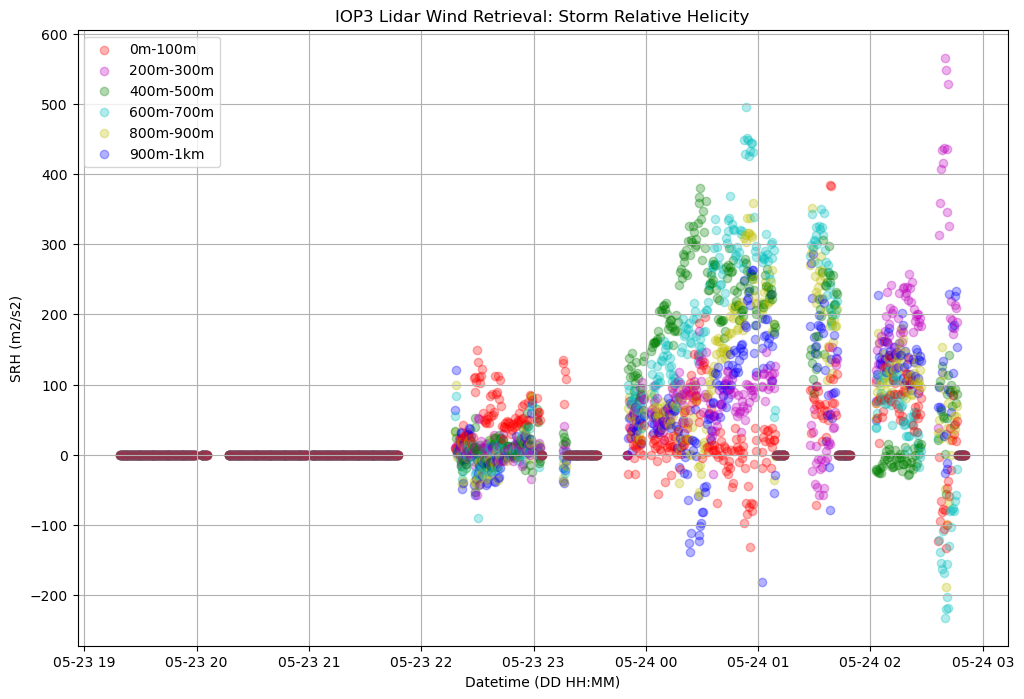

In [29]:
fig,ax = plt.subplots(figsize=[12,8],ncols=1)
ax.grid()

for i in np.arange(0,len(testing.time)-2):
    test = testing.isel(time=slice(i, i+1))
    #print(test.time.values)
#     test1 = test.where(test.wspd < 40, drop=True)
#     test2 = test1.where(test1.r_sq > 0.95, drop=True)
#     test3 = test2.where(test2.height < 3, drop=True)
#     test4 = test3.where(test3.intensity < 1.01, drop=True)
    
    u_mob,v_mob = (wind_components(lidar_storm.iloc[(lidar_storm['datetime']-test.time.values[0]).abs().argsort()[:1]]['Spd'].values 
                                * units('knots').to((units.m)/(units.s)), 
                               lidar_storm.iloc[(lidar_storm['datetime']-test.time.values[0]).abs().argsort()[:1]]['Dir'].values 
                                * units.deg))
    u = test['u'][0].values[2:]
    v = test['v'][0].values[2:]
    z = test['height'].values[2:]

    u = np.insert(u, 0, u_mob.magnitude, axis=0)
    v = np.insert(v, 0, v_mob.magnitude, axis=0)
    z = np.insert(z, 0, 0., axis=0)

    # define data with variable attributes
    data_vars = {'u':(['height'], u, 
                             {'units': 'm/s', 
                              'long_name':'ucomponent'}),
                 'v':(['height'], v, 
                             {'units': 'm/s', 
                              'long_name':'vcomponent'})}

    # define coordinates
    coords = {'height': (['height'], z)}

    # create dataset
    testnew = xr.Dataset(data_vars=data_vars, coords=coords)

    u1 = testnew['u'].interp(height=np.arange(0,3.010,0.010))
    v1 = testnew['v'].interp(height=np.arange(0,3.010,0.010))
    z1 = np.arange(0,3.010,0.010)
    
    u_storm,v_storm = (wind_components(storm_location.iloc[(storm_location['datetime']-test.time.values[0]).abs().argsort()[:1]]['storm_vel'].values 
                                * units('m/s'), 
                               storm_location.iloc[(storm_location['datetime']-test.time.values[0]).abs().argsort()[:1]]['storm_dir'].values 
                                * units.deg))
    
    
    SRH1km = storm_relative_helicity(z1*units('km'),u1*units('m/s'),v1*units('m/s'),
                                  1*units('km'),bottom=900*units('m'),storm_u=u_storm,storm_v=v_storm)[2]
    SRH900m = storm_relative_helicity(z1*units('km'),u1*units('m/s'),v1*units('m/s'),
                                  900*units('m'),bottom=800*units('m'),storm_u=u_storm,storm_v=v_storm)[2]
    SRH700m = storm_relative_helicity(z1*units('km'),u1*units('m/s'),v1*units('m/s'),
                                  700*units('m'),bottom=600*units('m'),storm_u=u_storm,storm_v=v_storm)[2]
    SRH500m = storm_relative_helicity(z1*units('km'),u1*units('m/s'),v1*units('m/s'),
                                  500*units('m'),bottom=400*units('m'),storm_u=u_storm,storm_v=v_storm)[2]
    SRH300m = storm_relative_helicity(z1*units('km'),u1*units('m/s'),v1*units('m/s'),
                                  300*units('m'),bottom=200*units('m'),storm_u=u_storm,storm_v=v_storm)[2]
    SRH100m = storm_relative_helicity(z1*units('km'),u1*units('m/s'),v1*units('m/s'),
                                  100*units('m'),bottom=0*units('m'),storm_u=u_storm,storm_v=v_storm)[2]
    
    fwd_azimuth,back_azimuth,distance = geodesic.inv(test.lon.values, test.lat.values, 
                                                     storm_location.iloc[(storm_location['datetime']
                                                                          -test.time.values[0]).abs().argsort()[:1]]['Lon'].values, 
                                                     storm_location.iloc[(storm_location['datetime']
                                                                          -test.time.values[0]).abs().argsort()[:1]]['Lat'].values)

    dist = distance/1000
    bear = back_azimuth
    c = test.time.values[0]

    if bear == np.nan:
        continue

    
    line1=ax.scatter(test.time.values,SRH1km,color='b',alpha=0.3)
    line2=ax.scatter(test.time.values,SRH900m,color='y',alpha=0.3)
    line3=ax.scatter(test.time.values,SRH700m,color='c',alpha=0.3)
    line4=ax.scatter(test.time.values,SRH500m,color='g',alpha=0.3)
    line5=ax.scatter(test.time.values,SRH300m,color='m',alpha=0.3)
    line6=ax.scatter(test.time.values,SRH100m,color='r',alpha=0.3)

ax.legend([line6,line5,line4,line3,line2,line1], ['0m-100m','200m-300m','400m-500m','600m-700m','800m-900m','900m-1km'])    
ax.set_xlabel('Datetime (DD HH:MM)')
ax.set_ylabel('SRH (m2/s2)')
ax.set_title('IOP3 Lidar Wind Retrieval: Storm Relative Helicity')
#ax.set_xlim([lidar_storm.iloc[0].datetime, pd.to_datetime('2022/06/12 23:03:00',format='%Y/%m/%d %H:%M:%S')])
#ax.set_ylim([-700,700])
plt.savefig('E:/Lapenta/20220523/Figs/IOP3_lidarSRH_layers.png',bbox_inches='tight',format='png',dpi=300)
plt.show()

In [30]:
geodesic = pyproj.Geod(ellps='WGS84')
#plt.rcParams["figure.figsize"] = [20, 20]
#plt.rcParams["figure.autolayout"] = True
fig, ax = plt.subplots(3,2, figsize=(20,18),sharey=True)
ax[0,0].grid()
ax[0,1].grid()
ax[1,0].grid()
ax[1,1].grid()
ax[2,0].grid()
ax[2,1].grid()

norm = mpl.colors.Normalize(vmin=mdates.date2num(storm_location.datetime)[0], vmax=mdates.date2num(storm_location.datetime[len(storm_location)-1]))


for thefile in vad_fileska1[9:]:

    radar = pyart.io.read_cfradial(thefile)
    print(thefile,radar.fixed_angle['data'])
    
    
    ka1gps['ddmmyy']+ka1gps['hhmmss[UTC]']
    ka1gps['datetime'] = [datetime.strptime(d,'%d%m%y%H%M%S') for d in ka1gps['ddmmyy']+ka1gps['hhmmss[UTC]']]
    beginscanindex = ka1gps.loc[ka1gps['datetime'] == datetime.strptime(radar.time['units'],'seconds since %Y-%m-%dT%H:%M:%SZ')].index+np.amin(np.unique(radar.time['data']))
    endscanindex = ka1gps.loc[ka1gps['datetime'] == datetime.strptime(radar.time['units'],'seconds since %Y-%m-%dT%H:%M:%SZ')].index+np.amax(np.unique(radar.time['data']))
    dfscan = ka1gps.iloc[beginscanindex[0].astype(int):endscanindex[0].astype(int)]
    dfscan = dfscan.astype({'Bearing[degrees]': 'float'})

    #print('velocity [kts]',dfscan['Velocity[knots]'].astype(float).mean(),'+-',dfscan['Velocity[knots]'].astype(float).var())
    speed = dfscan['Velocity[knots]'].astype(float).mean()
    #print('bearing',dfscan['Bearing[degrees]'].astype(float).mean(),'+-',dfscan['Bearing[degrees]'].astype(float).var())
    
#    bearing = 84.6
    if int(ka1scan.loc[ka1scan['Datetime'] == dfscan.datetime.values[0]].Deployment.values[0]) != 0:
        bearing = float(ka1scan.loc[ka1scan['Datetime'] == dfscan.datetime.values[0]].Heading.values[0])
    else:
        bearing = dfscan['Bearing[degrees]'].mean()
        
    if bearing == 80.06703703703703:
        bearing = 190
    elif (bearing == 64.25037037037036):
        bearing = 9.980000000000002
    elif (bearing == 89.28925925925924):
        bearing = 92.6
    elif bearing == 269.9640740740741:
        bearing = 90.6
    elif bearing == 206.84615384615387:
        bearing = 149.0
    elif bearing == 263.8211111111111:
        bearing = 90.2
    
    print('Bearing used: '+str(bearing))
    
    #print('latitude',dfscan['Latitude'].astype(float).mean(),'+-',dfscan['Latitude'].astype(float).var())
    lat = dfscan['Latitude'].astype(float).mean()
    #print('longitude',dfscan['Longitude'].astype(float).mean(),'+-',dfscan['Longitude'].astype(float).var())
    lon = dfscan['Longitude'].astype(float).mean()
    
    display = pyart.graph.RadarMapDisplay(radar)
    
    radar.azimuth['data']+=(bearing)%360
#     if (bearing>=0)&(bearing<=90):
#         (radar.azimuth['data'])+=(bearing*(-1)+90)%360
#     else:
#         (radar.azimuth['data'])+=360-(bearing*(-1)+90)%360

    VAD = pyart.retrieve.vad_browning(radar, 'corrected_velocity', z_want=np.arange(50,5001,10),gatefilter=None)
    u1 = VAD.u_wind
    v1 = VAD.v_wind

    
    u_shear = [u1[5]-u1[0],u1[15]-u1[0],u1[25]-u1[0]
                   ,u1[35]-u1[0],u1[45]-u1[0],u1[55]-u1[0]
                   ,u1[65]-u1[0],u1[75]-u1[0],u1[85]-u1[0]
                   ,u1[95]-u1[0]]

    v_shear = [v1[5]-v1[0],v1[15]-v1[0],v1[25]-v1[0]
               ,v1[35]-v1[0],v1[45]-v1[0],v1[55]-v1[0]
               ,v1[65]-v1[0],v1[75]-v1[0],v1[85]-v1[0]
               ,v1[95]-v1[0]]
    wspd_shear = wind_speed(u_shear*units('m/s'),v_shear*units('m/s'))
    #z_shear = np.arange(0.1,1.1,0.1)
    fwd_azimuth,back_azimuth,distance = geodesic.inv(dfscan['Longitude'].values[0], dfscan['Latitude'].values[0], 
                                                         storm_location.iloc[(storm_location['datetime']
                                                                              -dfscan['datetime'].values[0]).abs().argsort()[:1]]['Lon'].values, 
                                                         storm_location.iloc[(storm_location['datetime']
                                                                              -dfscan['datetime'].values[0]).abs().argsort()[:1]]['Lat'].values)

    dist = distance/1000
    bear = back_azimuth
    c = dfscan['datetime'].values[0]

    if bear<0:
        continue
    
    img=ax[2,0].scatter(dist,wspd_shear[9], c=mdates.date2num(c), marker = 'o', cmap='plasma', alpha=0.5, s=75, norm=norm)
    ax[1,0].scatter(dist,wspd_shear[4], c=mdates.date2num(c), marker = 'o', cmap='plasma', alpha=0.5, s=75, norm=norm)
    ax[0,0].scatter(dist,wspd_shear[0], c=mdates.date2num(c), marker = 'o', cmap='plasma', alpha=0.5, s=75, norm=norm)

    ax[2,1].scatter(bear,wspd_shear[9], c=mdates.date2num(c), marker = 'o', cmap='plasma', alpha=0.5, s=75, norm=norm)
    ax[1,1].scatter(bear,wspd_shear[4], c=mdates.date2num(c), marker = 'o', cmap='plasma', alpha=0.5, s=75, norm=norm)
    ax[0,1].scatter(bear,wspd_shear[0], c=mdates.date2num(c), marker = 'o', cmap='plasma', alpha=0.5, s=75, norm=norm)   

    

for thefile in vad_fileska2[28:]:

    radar = pyart.io.read_cfradial(thefile)
    print(thefile,radar.fixed_angle['data'])
    
    
    ka2gps['ddmmyy']+ka2gps['hhmmss[UTC]']
    ka2gps['datetime'] = [datetime.strptime(d,'%d%m%y%H%M%S') for d in ka2gps['ddmmyy']+ka2gps['hhmmss[UTC]']]
    beginscanindex = ka2gps.loc[ka2gps['datetime'] == datetime.strptime(radar.time['units'],'seconds since %Y-%m-%dT%H:%M:%SZ')].index+np.amin(np.unique(radar.time['data']))
    endscanindex = ka2gps.loc[ka2gps['datetime'] == datetime.strptime(radar.time['units'],'seconds since %Y-%m-%dT%H:%M:%SZ')].index+np.amax(np.unique(radar.time['data']))
    dfscan = ka2gps.iloc[beginscanindex[0].astype(int):endscanindex[0].astype(int)]
    dfscan = dfscan.astype({'Bearing[degrees]': 'float'})

    #print('velocity [kts]',dfscan['Velocity[knots]'].astype(float).mean(),'+-',dfscan['Velocity[knots]'].astype(float).var())
    speed = dfscan['Velocity[knots]'].astype(float).mean()
    #print('bearing',dfscan['Bearing[degrees]'].astype(float).mean(),'+-',dfscan['Bearing[degrees]'].astype(float).var())
    
#    bearing = 84.6
    if int(ka2scan.loc[ka2scan['Datetime'] == dfscan.datetime.values[0]].Deployment.values[0]) != 0:
        bearing = float(ka2scan.loc[ka2scan['Datetime'] == dfscan.datetime.values[0]].Heading.values[0])
    else:
        bearing = dfscan['Bearing[degrees]'].mean()
        
    if bearing == 80.06703703703703:
        bearing = 190
    elif (bearing == 64.25037037037036):
        bearing = 9.980000000000002
    elif (bearing == 89.28925925925924):
        bearing = 92.6
    elif bearing == 269.9640740740741:
        bearing = 90.6
    elif bearing == 206.84615384615387:
        bearing = 149.0
    elif bearing == 263.8211111111111:
        bearing = 90.2
 
    print('Bearing used: '+str(bearing))
    
    #print('latitude',dfscan['Latitude'].astype(float).mean(),'+-',dfscan['Latitude'].astype(float).var())
    lat = dfscan['Latitude'].astype(float).mean()
    #print('longitude',dfscan['Longitude'].astype(float).mean(),'+-',dfscan['Longitude'].astype(float).var())
    lon = dfscan['Longitude'].astype(float).mean()
    
    display = pyart.graph.RadarMapDisplay(radar)
    
    radar.azimuth['data']+=(bearing)%360
    
#     if (bearing>=0)&(bearing<=90):
#         (radar.azimuth['data'])+=(bearing*(-1)+90)%360
#     else:
#         (radar.azimuth['data'])+=360-(bearing*(-1)+90)%360

    VAD = pyart.retrieve.vad_browning(radar, 'corrected_velocity', z_want=np.arange(50,5001,10),gatefilter=None)
    u1 = VAD.u_wind
    v1 = VAD.v_wind
    
    u_shear = [u1[5]-u1[0],u1[15]-u1[0],u1[25]-u1[0]
                   ,u1[35]-u1[0],u1[45]-u1[0],u1[55]-u1[0]
                   ,u1[65]-u1[0],u1[75]-u1[0],u1[85]-u1[0]
                   ,u1[95]-u1[0]]

    v_shear = [v1[5]-v1[0],v1[15]-v1[0],v1[25]-v1[0]
               ,v1[35]-v1[0],v1[45]-v1[0],v1[55]-v1[0]
               ,v1[65]-v1[0],v1[75]-v1[0],v1[85]-v1[0]
               ,v1[95]-v1[0]]
    wspd_shear = wind_speed(u_shear*units('m/s'),v_shear*units('m/s'))
    #z_shear = np.arange(0.1,1.1,0.1)
    fwd_azimuth,back_azimuth,distance = geodesic.inv(dfscan['Longitude'].values[0], dfscan['Latitude'].values[0], 
                                                         storm_location.iloc[(storm_location['datetime']
                                                                              -dfscan['datetime'].values[0]).abs().argsort()[:1]]['Lon'].values, 
                                                         storm_location.iloc[(storm_location['datetime']
                                                                              -dfscan['datetime'].values[0]).abs().argsort()[:1]]['Lat'].values)

    dist = distance/1000
    bear = back_azimuth
    c = dfscan['datetime'].values[0]

    if bear<0:
        continue
    
    img=ax[2,0].scatter(dist,wspd_shear[9], c=mdates.date2num(c), marker = 'o', cmap='plasma', alpha=0.5, s=75, norm=norm)
    ax[1,0].scatter(dist,wspd_shear[4], c=mdates.date2num(c), marker = 'o', cmap='plasma', alpha=0.5, s=75, norm=norm)
    ax[0,0].scatter(dist,wspd_shear[0], c=mdates.date2num(c), marker = 'o', cmap='plasma', alpha=0.5, s=75, norm=norm)

    ax[2,1].scatter(bear,wspd_shear[9], c=mdates.date2num(c), marker = 'o', cmap='plasma', alpha=0.5, s=75, norm=norm)
    ax[1,1].scatter(bear,wspd_shear[4], c=mdates.date2num(c), marker = 'o', cmap='plasma', alpha=0.5, s=75, norm=norm)
    ax[0,1].scatter(bear,wspd_shear[0], c=mdates.date2num(c), marker = 'o', cmap='plasma', alpha=0.5, s=75, norm=norm)   

    
for i in np.arange(0,len(testing.time)-2):
#     if i == 178:
#         continue
#     else:
    test = testing.isel(time=slice(i, i+1))
    #print(test.time.values)
#     test1 = test.where(test.wspd < 40, drop=True)
#     test2 = test1.where(test1.r_sq > 0.95, drop=True)
#     test3 = test2.where(test2.height < 3, drop=True)
#     test4 = test3.where(test3.intensity < 1.01, drop=True)

    u_mob,v_mob = (wind_components(lidar_storm.iloc[(lidar_storm['datetime']-test.time.values[0]).abs().argsort()[:1]]['Spd'].values 
                                * units('knots').to((units.m)/(units.s)), 
                               lidar_storm.iloc[(lidar_storm['datetime']-test.time.values[0]).abs().argsort()[:1]]['Dir'].values 
                                * units.deg))
    u = test['u'][0].values[2:]
    v = test['v'][0].values[2:]
    z = test['height'].values[2:]

    u = np.insert(u, 0, u_mob.magnitude, axis=0)
    v = np.insert(v, 0, v_mob.magnitude, axis=0)
    z = np.insert(z, 0, 0., axis=0)

    # define data with variable attributes
    data_vars = {'u':(['height'], u, 
                             {'units': 'm/s', 
                              'long_name':'ucomponent'}),
                 'v':(['height'], v, 
                             {'units': 'm/s', 
                              'long_name':'vcomponent'})}

    # define coordinates
    coords = {'height': (['height'], z)}

    # create dataset
    testnew = xr.Dataset(data_vars=data_vars, coords=coords)

    u1 = testnew['u'].interp(height=np.arange(0,3.010,0.010))
    v1 = testnew['v'].interp(height=np.arange(0,3.010,0.010))
    z1 = np.arange(0,3.010,0.010)
    u_shear = [u1[10].values-u1[0].values,u1[20].values-u1[0].values,u1[30].values-u1[0].values
               ,u1[40].values-u1[0].values,u1[50].values-u1[0].values,u1[60].values-u1[0].values
               ,u1[70].values-u1[0].values,u1[80].values-u1[0].values,u1[90].values-u1[0].values
               ,u1[100].values-u1[0].values]

    v_shear = [v1[10].values-v1[0].values,v1[20].values-v1[0].values,v1[30].values-v1[0].values
               ,v1[40].values-v1[0].values,v1[50].values-v1[0].values,v1[60].values-v1[0].values
               ,v1[70].values-v1[0].values,v1[80].values-v1[0].values,v1[90].values-v1[0].values
               ,v1[100].values-v1[0].values]
    wspd_shear = wind_speed(u_shear*units('m/s'),v_shear*units('m/s'))
    z_shear = np.arange(0.1,1.1,0.1)
    fwd_azimuth,back_azimuth,distance = geodesic.inv(test.lon.values, test.lat.values, 
                                                         storm_location.iloc[(storm_location['datetime']
                                                                              -test.time.values[0]).abs().argsort()[:1]]['Lon'].values, 
                                                         storm_location.iloc[(storm_location['datetime']
                                                                              -test.time.values[0]).abs().argsort()[:1]]['Lat'].values)

    dist = distance/1000
    bear = back_azimuth
    c = test.time.values[0]

    if bear<0:
        bear = bear+360

    img=ax[2,0].scatter(dist,wspd_shear[9], c=mdates.date2num(c), marker = 'o', cmap='plasma', alpha=0.5, s=75, norm=norm)
    ax[1,0].scatter(dist,wspd_shear[4], c=mdates.date2num(c), marker = 'o', cmap='plasma', alpha=0.5, s=75, norm=norm)
    ax[0,0].scatter(dist,wspd_shear[0], c=mdates.date2num(c), marker = 'o', cmap='plasma', alpha=0.5, s=75, norm=norm)

    ax[2,1].scatter(bear,wspd_shear[9], c=mdates.date2num(c), marker = 'o', cmap='plasma', alpha=0.5, s=75, norm=norm)
    ax[1,1].scatter(bear,wspd_shear[4], c=mdates.date2num(c), marker = 'o', cmap='plasma', alpha=0.5, s=75, norm=norm)
    ax[0,1].scatter(bear,wspd_shear[0], c=mdates.date2num(c), marker = 'o', cmap='plasma', alpha=0.5, s=75, norm=norm)   

    
    
    
    
ax[0,0].invert_xaxis()
ax[1,0].invert_xaxis()
ax[2,0].invert_xaxis()
ax[2,0].set_xlabel('Distance from Center of Storm (km)', fontsize=14, fontweight='bold')
ax[2,1].set_xlabel('Bearing from Center of Storm (deg)', fontsize=14, fontweight='bold')
ax[0,0].set_ylabel('0-100m Shear (m/s)', fontsize=14, fontweight='bold')
ax[1,0].set_ylabel('0-500m Shear (m/s)', fontsize=14, fontweight='bold')
ax[2,0].set_ylabel('0-1km Shear (m/s)', fontsize=14, fontweight='bold')

cbar = fig.colorbar(img, ax=ax[2, 0], location='bottom',pad=0.2)
ff = mdates.num2date(cbar.ax.get_xticks())
fff = [date_obj.strftime('%H:%M:%S') for date_obj in ff]
cbar.ax.set_xticklabels(fff, fontsize=10, fontweight='bold')
cbar.set_label('Time during Intensive Operating Period (HH:MM:SS UTC)', fontsize=14, fontweight='bold')

torbegin=(mdates.date2num(tor_paths.start_tor))
torend=(mdates.date2num(tor_paths.end_tor))
for i,j in zip(torbegin,torend):
    cbar.ax.plot([i,j],[.5,.5],color='red',linewidth=3)

torbegin=(mdates.date2num(tor_paths.start_tor))
for i in np.arange(1,len(tor_paths)+1,1):
    cbar.ax.annotate(i, xy=(torbegin[i-1], np.linspace(0.5,0.5,len(torbegin))[i-1]), fontsize=7, ha="center",va='center',color='k',zorder=30,weight="bold")


cbar = fig.colorbar(img, ax=ax[2, 1], location='bottom',pad=0.2)
ff = mdates.num2date(cbar.ax.get_xticks())
fff = [date_obj.strftime('%H:%M:%S') for date_obj in ff]
cbar.ax.set_xticklabels(fff, fontsize=10, fontweight='bold')
cbar.set_label('Time during Intensive Operating Period (HH:MM:SS UTC)', fontsize=14, fontweight='bold')

torbegin=(mdates.date2num(tor_paths.start_tor))
torend=(mdates.date2num(tor_paths.end_tor))
for i,j in zip(torbegin,torend):
    cbar.ax.plot([i,j],[.5,.5],color='red',linewidth=3)

torbegin=(mdates.date2num(tor_paths.start_tor))
for i in np.arange(1,len(tor_paths)+1,1):
    cbar.ax.annotate(i, xy=(torbegin[i-1], np.linspace(0.5,0.5,len(torbegin))[i-1]), fontsize=7, ha="center",va='center',color='k',zorder=30,weight="bold")



plt.savefig('E:/Lapenta/20220523/Figs/kalidar_shearlayer.png',bbox_inches='tight',format='png',dpi=300)
plt.close('all')
fig.clf()


E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222551.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222620.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222649.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222718.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222747.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222816.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222845.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6010.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222914.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222943.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223013.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223042.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223111.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223140.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223209.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223238.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6036.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223307.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223336.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223405.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223434.nc [37.001953 45.      ]
Bearing used: 190


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 5992.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523224032.nc [37.001953 45.      ]
Bearing used: 9.980000000000002


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523224101.nc [37.001953 45.      ]
Bearing used: 9.980000000000002


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6001.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523224130.nc [37.001953 45.      ]
Bearing used: 92.6


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523232822.nc [37.001953 45.      ]
Bearing used: 177.76296296296297


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523232852.nc [37.001953 45.      ]
Bearing used: 180.39961538461537


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6009.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523232921.nc [37.001953 45.      ]
Bearing used: 180.77923076923076


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6008.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523232950.nc [37.001953 45.      ]
Bearing used: 149.0


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523233019.nc [37.001953 45.      ]
Bearing used: 90.6


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6008.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220524000309.nc [37.001953 45.      ]
Bearing used: 90.2


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 5999.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222547.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222617.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222647.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222718.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222748.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222818.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222848.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222919.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222949.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223019.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223050.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223120.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6012.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223150.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223220.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6008.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223250.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223321.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223351.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223421.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223452.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223522.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223552.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223622.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223652.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223722.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223753.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223823.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223852.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223922.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223953.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224023.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224053.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6008.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224123.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6001.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224153.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224223.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224253.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224324.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224354.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224425.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224455.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224524.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224554.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224624.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224655.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224726.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224756.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224826.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224856.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224927.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224957.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6004.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523225027.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6012.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523225057.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523225128.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6008.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523225158.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523225228.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523225258.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523225328.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523225358.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220524001616.nc [37.001953 45.      ]
Bearing used: 11.115384615384615


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220524001646.nc [37.001953 45.      ]
Bearing used: 86.4


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6010.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220524005159.nc [37.001953 45.      ]
Bearing used: 183.2255555555556


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220524005332.nc [37.001953 45.      ]
Bearing used: 91.9


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220524012032.nc [37.001953 45.      ]
Bearing used: 121.4


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220524015527.nc [37.001953 45.      ]
Bearing used: 90.5174074074074


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220524015557.nc [37.001953 45.      ]
Bearing used: 90.55703703703703


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220524015759.nc [37.001953 45.      ]
Bearing used: 90.91740740740742


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters


C:\Users\joshu\AppData\Local\Temp\ipykernel_34680\469297627.py:282: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_xticklabels(fff, fontsize=10, fontweight='bold')
C:\Users\joshu\AppData\Local\Temp\ipykernel_34680\469297627.py:298: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_xticklabels(fff, fontsize=10, fontweight='bold')
C:\Users\joshu\.conda\envs\ox\Lib\site-packages\numpy\ma\extras.py:290: UserWarning: Warning: converting a masked element to nan.
  _d = func(tuple([np.asarray(a) for a in x]), *args, **params)
C:\Users\joshu\.conda\envs\ox\Lib\site-packages\numpy\core\fromnumeric.py:2009: UserWarning: Warning: converting a masked element to nan.
  result = asarray(a).shape


E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222551.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222620.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222649.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222718.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222747.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222816.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222845.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6010.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222914.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222943.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223013.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223042.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223111.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223140.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223209.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223238.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6036.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223307.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223336.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223405.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223434.nc [37.001953 45.      ]
Bearing used: 190


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 5992.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523224032.nc [37.001953 45.      ]
Bearing used: 9.980000000000002


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523224101.nc [37.001953 45.      ]
Bearing used: 9.980000000000002


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6001.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523224130.nc [37.001953 45.      ]
Bearing used: 92.6


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523232822.nc [37.001953 45.      ]
Bearing used: 177.76296296296297


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523232852.nc [37.001953 45.      ]
Bearing used: 180.39961538461537


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6009.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523232921.nc [37.001953 45.      ]
Bearing used: 180.77923076923076


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6008.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523232950.nc [37.001953 45.      ]
Bearing used: 149.0


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523233019.nc [37.001953 45.      ]
Bearing used: 90.6


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6008.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220524000309.nc [37.001953 45.      ]
Bearing used: 90.2


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 5999.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222547.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222617.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222647.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222718.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222748.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222818.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222848.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222919.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222949.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223019.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223050.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223120.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6012.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223150.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223220.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6008.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223250.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223321.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223351.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223421.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223452.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223522.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223552.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223622.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223652.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223722.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223753.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223823.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223852.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223922.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223953.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224023.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224053.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6008.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224123.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6001.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224153.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224223.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224253.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224324.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224354.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224425.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224455.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224524.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224554.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224624.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224655.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224726.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224756.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224826.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224856.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224927.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224957.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6004.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523225027.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6012.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523225057.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523225128.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6008.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523225158.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523225228.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523225258.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523225328.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523225358.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220524001616.nc [37.001953 45.      ]
Bearing used: 11.115384615384615


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220524001646.nc [37.001953 45.      ]
Bearing used: 86.4


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6010.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220524005159.nc [37.001953 45.      ]
Bearing used: 183.2255555555556


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220524005332.nc [37.001953 45.      ]
Bearing used: 91.9


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220524012032.nc [37.001953 45.      ]
Bearing used: 121.4


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220524015527.nc [37.001953 45.      ]
Bearing used: 90.5174074074074


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220524015557.nc [37.001953 45.      ]
Bearing used: 90.55703703703703


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220524015759.nc [37.001953 45.      ]
Bearing used: 90.91740740740742


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\numpy\ma\extras.py:290: UserWarning: Warning: converting a masked element to nan.
  _d = func(tuple([np.asarray(a) for a in x]), *args, **params)
C:\Users\joshu\.conda\envs\ox\Lib\site-packages\numpy\core\fromnumeric.py:2009: UserWarning: Warning: converting a masked element to nan.
  result = asarray(a).shape


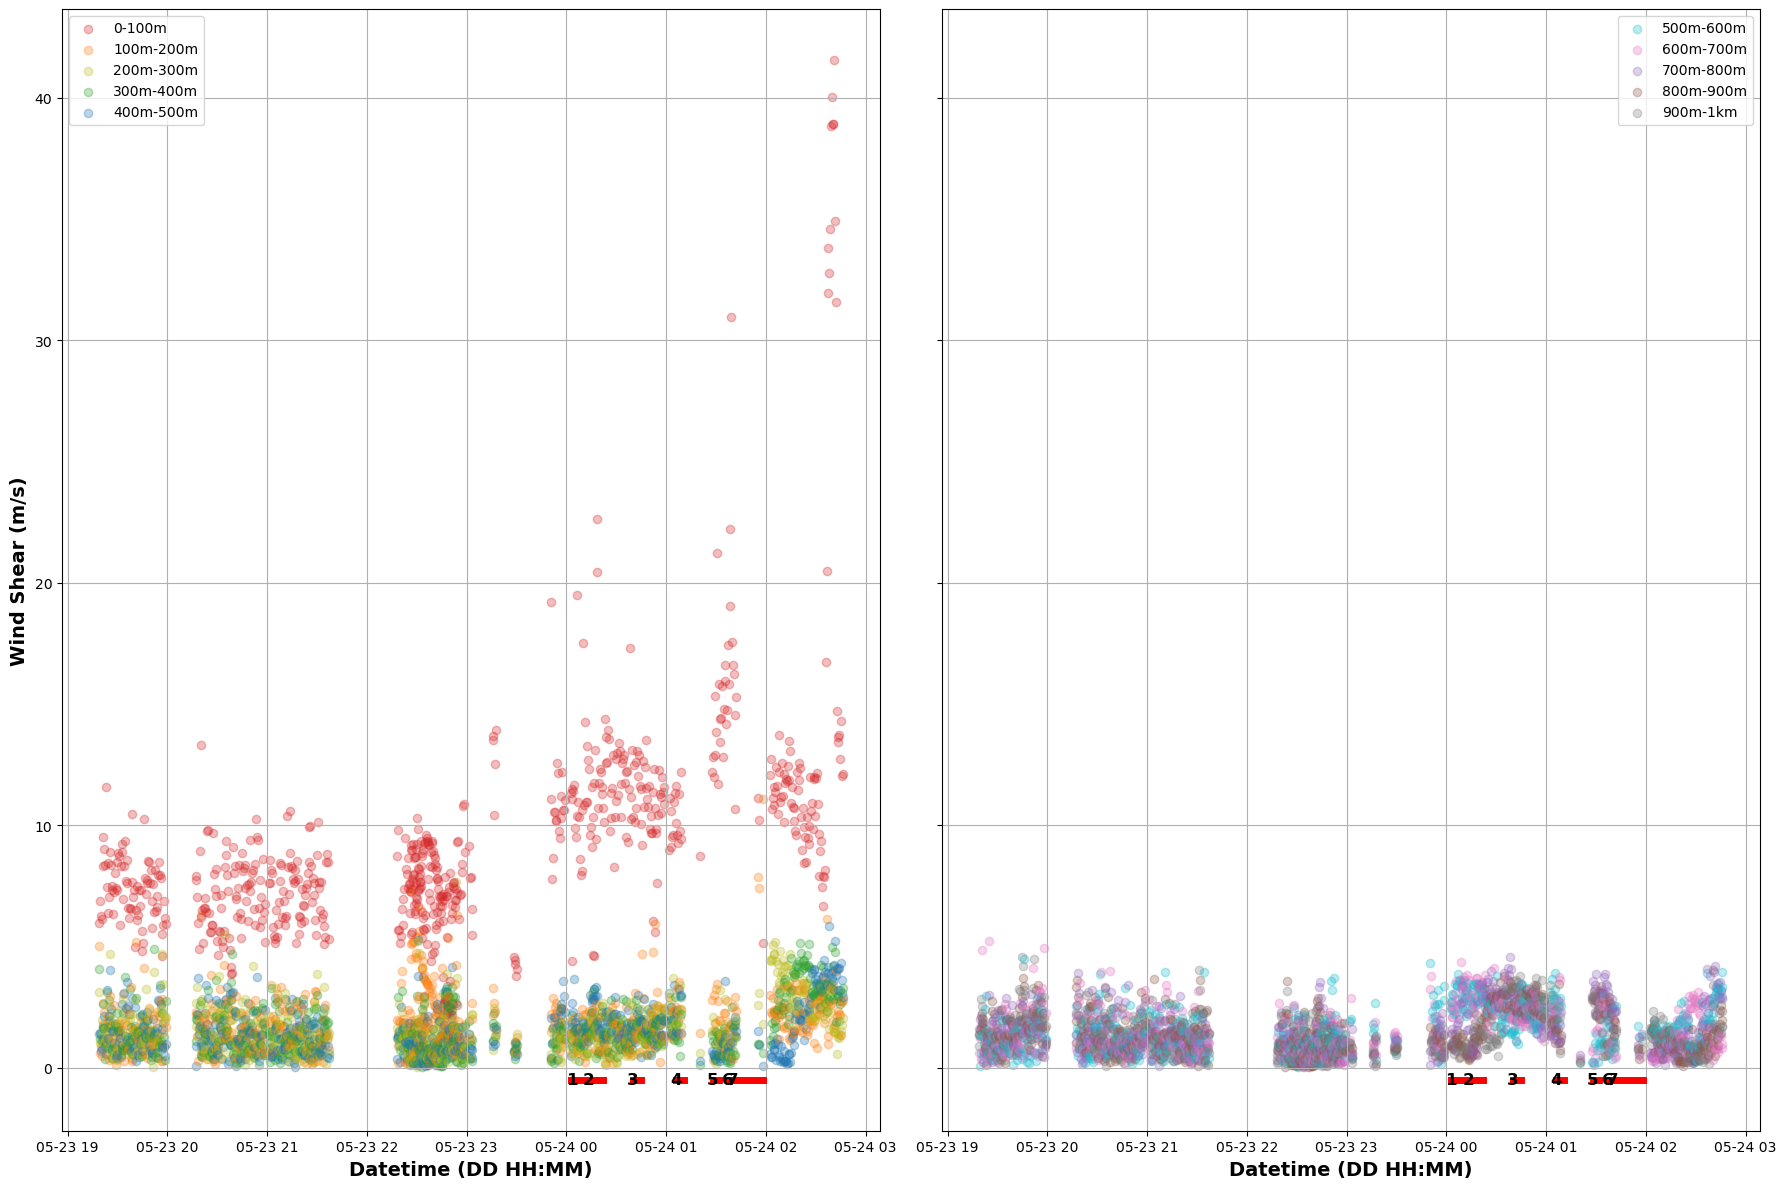

In [24]:
fig, ax = plt.subplots(1,2, figsize=(18,12),sharey=True)
ax[0].grid()
ax[1].grid()
for thefile in vad_fileska1[9:]:

    radar = pyart.io.read_cfradial(thefile)
    print(thefile,radar.fixed_angle['data'])
    
    
    ka1gps['ddmmyy']+ka1gps['hhmmss[UTC]']
    ka1gps['datetime'] = [datetime.strptime(d,'%d%m%y%H%M%S') for d in ka1gps['ddmmyy']+ka1gps['hhmmss[UTC]']]
    beginscanindex = ka1gps.loc[ka1gps['datetime'] == datetime.strptime(radar.time['units'],'seconds since %Y-%m-%dT%H:%M:%SZ')].index+np.amin(np.unique(radar.time['data']))
    endscanindex = ka1gps.loc[ka1gps['datetime'] == datetime.strptime(radar.time['units'],'seconds since %Y-%m-%dT%H:%M:%SZ')].index+np.amax(np.unique(radar.time['data']))
    dfscan = ka1gps.iloc[beginscanindex[0].astype(int):endscanindex[0].astype(int)]
    dfscan = dfscan.astype({'Bearing[degrees]': 'float'})

    #print('velocity [kts]',dfscan['Velocity[knots]'].astype(float).mean(),'+-',dfscan['Velocity[knots]'].astype(float).var())
    speed = dfscan['Velocity[knots]'].astype(float).mean()
    #print('bearing',dfscan['Bearing[degrees]'].astype(float).mean(),'+-',dfscan['Bearing[degrees]'].astype(float).var())
    
#    bearing = 84.6
    if int(ka1scan.loc[ka1scan['Datetime'] == dfscan.datetime.values[0]].Deployment.values[0]) != 0:
        bearing = float(ka1scan.loc[ka1scan['Datetime'] == dfscan.datetime.values[0]].Heading.values[0])
    else:
        bearing = dfscan['Bearing[degrees]'].mean()
        
    if bearing == 80.06703703703703:
        bearing = 190
    elif (bearing == 64.25037037037036):
        bearing = 9.980000000000002
    elif (bearing == 89.28925925925924):
        bearing = 92.6
    elif bearing == 269.9640740740741:
        bearing = 90.6
    elif bearing == 206.84615384615387:
        bearing = 149.0
    elif bearing == 263.8211111111111:
        bearing = 90.2
    
    print('Bearing used: '+str(bearing))
    
    #print('latitude',dfscan['Latitude'].astype(float).mean(),'+-',dfscan['Latitude'].astype(float).var())
    lat = dfscan['Latitude'].astype(float).mean()
    #print('longitude',dfscan['Longitude'].astype(float).mean(),'+-',dfscan['Longitude'].astype(float).var())
    lon = dfscan['Longitude'].astype(float).mean()
    
    display = pyart.graph.RadarMapDisplay(radar)
    
    radar.azimuth['data']+=(bearing)%360
#     if (bearing>=0)&(bearing<=90):
#         (radar.azimuth['data'])+=(bearing*(-1)+90)%360
#     else:
#         (radar.azimuth['data'])+=360-(bearing*(-1)+90)%360

    VAD = pyart.retrieve.vad_browning(radar, 'corrected_velocity', z_want=np.arange(50,5001,10),gatefilter=None)
    u1 = VAD.u_wind
    v1 = VAD.v_wind
   
    
    u_shear = [u1[5]-u1[0],u1[15]-u1[5],u1[25]-u1[15]
               ,u1[35]-u1[25],u1[45]-u1[35],u1[55]-u1[45]
               ,u1[65]-u1[55],u1[75]-u1[65],u1[85]-u1[75]
               ,u1[95]-u1[85]]

    v_shear = [v1[5]-v1[0],v1[15]-v1[5],v1[25]-v1[15]
               ,v1[35]-v1[25],v1[45]-v1[35],v1[55]-v1[45]
               ,v1[65]-v1[55],v1[75]-v1[65],v1[85]-v1[75]
               ,v1[95]-v1[85]]
    wspd_shear = wind_speed(u_shear*units('m/s'),v_shear*units('m/s'))
    z_shear = np.arange(0.1,1.1,0.1)
    
#     fwd_azimuth,back_azimuth,distance = geodesic.inv(test.lon.values, test.lat.values, 
#                                                          storm_location.iloc[(storm_location['datetime']
#                                                                               -test.time.values[0]).abs().argsort()[:1]]['Lon'].values, 
#                                                          storm_location.iloc[(storm_location['datetime']
#                                                                               -test.time.values[0]).abs().argsort()[:1]]['Lat'].values)

#     dist = distance/1000
#     bear = back_azimuth
#     c = test.time.values[0]

    if bear == np.nan:
        continue

    line1=ax[0].scatter(dfscan['datetime'].values[0],wspd_shear[0],color='tab:red',alpha=0.3)
    line2=ax[0].scatter(dfscan['datetime'].values[0],wspd_shear[1],color='tab:orange',alpha=0.3)
    line3=ax[0].scatter(dfscan['datetime'].values[0],wspd_shear[2],color='tab:olive',alpha=0.3)
    line4=ax[0].scatter(dfscan['datetime'].values[0],wspd_shear[3],color='tab:green',alpha=0.3)
    line5=ax[0].scatter(dfscan['datetime'].values[0],wspd_shear[4],color='tab:blue',alpha=0.3)
    line6=ax[1].scatter(dfscan['datetime'].values[0],wspd_shear[5],color='tab:cyan',alpha=0.3)
    line7=ax[1].scatter(dfscan['datetime'].values[0],wspd_shear[6],color='tab:pink',alpha=0.3)
    line8=ax[1].scatter(dfscan['datetime'].values[0],wspd_shear[7],color='tab:purple',alpha=0.3)
    line9=ax[1].scatter(dfscan['datetime'].values[0],wspd_shear[8],color='tab:brown',alpha=0.3)
    line10=ax[1].scatter(dfscan['datetime'].values[0],wspd_shear[9],color='tab:gray',alpha=0.3)
    
for thefile in vad_fileska2[28:]:

    radar = pyart.io.read_cfradial(thefile)
    print(thefile,radar.fixed_angle['data'])
    
    
    ka2gps['ddmmyy']+ka2gps['hhmmss[UTC]']
    ka2gps['datetime'] = [datetime.strptime(d,'%d%m%y%H%M%S') for d in ka2gps['ddmmyy']+ka2gps['hhmmss[UTC]']]
    beginscanindex = ka2gps.loc[ka2gps['datetime'] == datetime.strptime(radar.time['units'],'seconds since %Y-%m-%dT%H:%M:%SZ')].index+np.amin(np.unique(radar.time['data']))
    endscanindex = ka2gps.loc[ka2gps['datetime'] == datetime.strptime(radar.time['units'],'seconds since %Y-%m-%dT%H:%M:%SZ')].index+np.amax(np.unique(radar.time['data']))
    dfscan = ka2gps.iloc[beginscanindex[0].astype(int):endscanindex[0].astype(int)]
    dfscan = dfscan.astype({'Bearing[degrees]': 'float'})

    #print('velocity [kts]',dfscan['Velocity[knots]'].astype(float).mean(),'+-',dfscan['Velocity[knots]'].astype(float).var())
    speed = dfscan['Velocity[knots]'].astype(float).mean()
    #print('bearing',dfscan['Bearing[degrees]'].astype(float).mean(),'+-',dfscan['Bearing[degrees]'].astype(float).var())
    
#    bearing = 84.6
    if int(ka2scan.loc[ka2scan['Datetime'] == dfscan.datetime.values[0]].Deployment.values[0]) != 0:
        bearing = float(ka2scan.loc[ka2scan['Datetime'] == dfscan.datetime.values[0]].Heading.values[0])
    else:
        bearing = dfscan['Bearing[degrees]'].mean()
        
    if bearing == 80.06703703703703:
        bearing = 190
    elif (bearing == 64.25037037037036):
        bearing = 9.980000000000002
    elif (bearing == 89.28925925925924):
        bearing = 92.6
    elif bearing == 269.9640740740741:
        bearing = 90.6
    elif bearing == 206.84615384615387:
        bearing = 149.0
    elif bearing == 263.8211111111111:
        bearing = 90.2
 
    print('Bearing used: '+str(bearing))
    
    #print('latitude',dfscan['Latitude'].astype(float).mean(),'+-',dfscan['Latitude'].astype(float).var())
    lat = dfscan['Latitude'].astype(float).mean()
    #print('longitude',dfscan['Longitude'].astype(float).mean(),'+-',dfscan['Longitude'].astype(float).var())
    lon = dfscan['Longitude'].astype(float).mean()
    
    display = pyart.graph.RadarMapDisplay(radar)
    
    radar.azimuth['data']+=(bearing)%360
    
#     if (bearing>=0)&(bearing<=90):
#         (radar.azimuth['data'])+=(bearing*(-1)+90)%360
#     else:
#         (radar.azimuth['data'])+=360-(bearing*(-1)+90)%360

    VAD = pyart.retrieve.vad_browning(radar, 'corrected_velocity', z_want=np.arange(50,5001,10),gatefilter=None)
    u1 = VAD.u_wind
    v1 = VAD.v_wind
    
    u_shear = [u1[5]-u1[0],u1[15]-u1[5],u1[25]-u1[15]
               ,u1[35]-u1[25],u1[45]-u1[35],u1[55]-u1[45]
               ,u1[65]-u1[55],u1[75]-u1[65],u1[85]-u1[75]
               ,u1[95]-u1[85]]

    v_shear = [v1[5]-v1[0],v1[15]-v1[5],v1[25]-v1[15]
               ,v1[35]-v1[25],v1[45]-v1[35],v1[55]-v1[45]
               ,v1[65]-v1[55],v1[75]-v1[65],v1[85]-v1[75]
               ,v1[95]-v1[85]]
    wspd_shear = wind_speed(u_shear*units('m/s'),v_shear*units('m/s'))
    z_shear = np.arange(0.1,1.1,0.1)
    
#     fwd_azimuth,back_azimuth,distance = geodesic.inv(test.lon.values, test.lat.values, 
#                                                          storm_location.iloc[(storm_location['datetime']
#                                                                               -test.time.values[0]).abs().argsort()[:1]]['Lon'].values, 
#                                                          storm_location.iloc[(storm_location['datetime']
#                                                                               -test.time.values[0]).abs().argsort()[:1]]['Lat'].values)

#     dist = distance/1000
#     bear = back_azimuth
#     c = test.time.values[0]

    if bear == np.nan:
        continue

    line1=ax[0].scatter(dfscan['datetime'].values[0],wspd_shear[0],color='tab:red',alpha=0.3)
    line2=ax[0].scatter(dfscan['datetime'].values[0],wspd_shear[1],color='tab:orange',alpha=0.3)
    line3=ax[0].scatter(dfscan['datetime'].values[0],wspd_shear[2],color='tab:olive',alpha=0.3)
    line4=ax[0].scatter(dfscan['datetime'].values[0],wspd_shear[3],color='tab:green',alpha=0.3)
    line5=ax[0].scatter(dfscan['datetime'].values[0],wspd_shear[4],color='tab:blue',alpha=0.3)
    line6=ax[1].scatter(dfscan['datetime'].values[0],wspd_shear[5],color='tab:cyan',alpha=0.3)
    line7=ax[1].scatter(dfscan['datetime'].values[0],wspd_shear[6],color='tab:pink',alpha=0.3)
    line8=ax[1].scatter(dfscan['datetime'].values[0],wspd_shear[7],color='tab:purple',alpha=0.3)
    line9=ax[1].scatter(dfscan['datetime'].values[0],wspd_shear[8],color='tab:brown',alpha=0.3)
    line10=ax[1].scatter(dfscan['datetime'].values[0],wspd_shear[9],color='tab:gray',alpha=0.3)
    
for i in np.arange(0,len(testing.time)-2):
#     if i == 178:
#         continue
#     else:
    test = testing.isel(time=slice(i, i+1))
    #print(test.time.values)
#     test1 = test.where(test.wspd < 40, drop=True)
#     test2 = test1.where(test1.r_sq > 0.95, drop=True)
#     test3 = test2.where(test2.height < 3, drop=True)
#     test4 = test3.where(test3.intensity < 1.01, drop=True)

    u_mob,v_mob = (wind_components(lidar_storm.iloc[(lidar_storm['datetime']-test.time.values[0]).abs().argsort()[:1]]['Spd'].values 
                                * units('knots').to((units.m)/(units.s)), 
                               lidar_storm.iloc[(lidar_storm['datetime']-test.time.values[0]).abs().argsort()[:1]]['Dir'].values 
                                * units.deg))
    u = test['u'][0].values[2:]
    v = test['v'][0].values[2:]
    z = test['height'].values[2:]

    u = np.insert(u, 0, u_mob.magnitude, axis=0)
    v = np.insert(v, 0, v_mob.magnitude, axis=0)
    z = np.insert(z, 0, 0., axis=0)

    # define data with variable attributes
    data_vars = {'u':(['height'], u, 
                             {'units': 'm/s', 
                              'long_name':'ucomponent'}),
                 'v':(['height'], v, 
                             {'units': 'm/s', 
                              'long_name':'vcomponent'})}

    # define coordinates
    coords = {'height': (['height'], z)}

    # create dataset
    testnew = xr.Dataset(data_vars=data_vars, coords=coords)

    u1 = testnew['u'].interp(height=np.arange(0,3.010,0.010))
    v1 = testnew['v'].interp(height=np.arange(0,3.010,0.010))
    z1 = np.arange(0,3.010,0.010)
    u_shear = [u1[10].values-u1[0].values,u1[20].values-u1[10].values,u1[30].values-u1[20].values
               ,u1[40].values-u1[30].values,u1[50].values-u1[40].values,u1[60].values-u1[50].values
               ,u1[70].values-u1[60].values,u1[80].values-u1[70].values,u1[90].values-u1[80].values
               ,u1[100].values-u1[90].values]

    v_shear = [v1[10].values-v1[0].values,v1[20].values-v1[10].values,v1[30].values-v1[20].values
               ,v1[40].values-v1[30].values,v1[50].values-v1[40].values,v1[60].values-v1[50].values
               ,v1[70].values-v1[60].values,v1[80].values-v1[70].values,v1[90].values-v1[80].values
               ,v1[100].values-v1[90].values]
    
    
    wspd_shear = wind_speed(u_shear*units('m/s'),v_shear*units('m/s'))
    z_shear = np.arange(0.1,1.1,0.1)
    
    fwd_azimuth,back_azimuth,distance = geodesic.inv(test.lon.values, test.lat.values, 
                                                         storm_location.iloc[(storm_location['datetime']
                                                                              -test.time.values[0]).abs().argsort()[:1]]['Lon'].values, 
                                                         storm_location.iloc[(storm_location['datetime']
                                                                              -test.time.values[0]).abs().argsort()[:1]]['Lat'].values)

    dist = distance/1000
    bear = back_azimuth
    c = test.time.values[0]

    if bear == np.nan:
        continue
    
    line1=ax[0].scatter(test.time.values,wspd_shear[0],color='tab:red',alpha=0.3)
    line2=ax[0].scatter(test.time.values,wspd_shear[1],color='tab:orange',alpha=0.3)
    line3=ax[0].scatter(test.time.values,wspd_shear[2],color='tab:olive',alpha=0.3)
    line4=ax[0].scatter(test.time.values,wspd_shear[3],color='tab:green',alpha=0.3)
    line5=ax[0].scatter(test.time.values,wspd_shear[4],color='tab:blue',alpha=0.3)
    line6=ax[1].scatter(test.time.values,wspd_shear[5],color='tab:cyan',alpha=0.3)
    line7=ax[1].scatter(test.time.values,wspd_shear[6],color='tab:pink',alpha=0.3)
    line8=ax[1].scatter(test.time.values,wspd_shear[7],color='tab:purple',alpha=0.3)
    line9=ax[1].scatter(test.time.values,wspd_shear[8],color='tab:brown',alpha=0.3)
    line10=ax[1].scatter(test.time.values,wspd_shear[9],color='tab:gray',alpha=0.3)
    

for i,j in zip(tor_paths.start_tor,tor_paths.end_tor):
    ax[0].plot([i,j],[-.5,-.5],color='red',linewidth=5)
    ax[1].plot([i,j],[-.5,-.5],color='red',linewidth=5)


for i in np.arange(1,len(tor_paths)+1,1):
    ax[0].annotate(i, xy=(tor_paths.start_tor.iloc[i-1], np.linspace(-0.5,-0.5,len(tor_paths.start_tor))[i-1]), fontsize=12, ha="center",va='center',color='k',zorder=30,weight="bold")
    ax[1].annotate(i, xy=(tor_paths.start_tor.iloc[i-1], np.linspace(-0.5,-0.5,len(tor_paths.start_tor))[i-1]), fontsize=12, ha="center",va='center',color='k',zorder=30,weight="bold")

ax[0].legend([line1, line2, line3, line4, line5], ['0-100m','100m-200m','200m-300m','300m-400m','400m-500m'])    
ax[1].legend([line6, line7, line8, line9, line10], ['500m-600m','600m-700m','700m-800m','800m-900m','900m-1km'])    
ax[0].set_xlabel('Datetime (DD HH:MM)', fontsize=14, fontweight='bold')
ax[0].set_ylabel('Wind Shear (m/s)', fontsize=14, fontweight='bold')
ax[1].set_xlabel('Datetime (DD HH:MM)', fontsize=14, fontweight='bold')
# ax.set_title('IOP3 Ka+Lidar Wind Retrieval: Wind Shear')
#ax.set_xlim([lidar_storm.iloc[0].datetime, pd.to_datetime('2022/06/12 23:03:00',format='%Y/%m/%d %H:%M:%S')])
#ax.set_ylim([0,50])
fig.tight_layout()
plt.savefig('E:/Lapenta/20220523/Figs/IOP3_kalidar_difshear.png',bbox_inches='tight',format='png',dpi=300)
plt.show()

In [31]:
geodesic = pyproj.Geod(ellps='WGS84')
#plt.rcParams["figure.figsize"] = [20, 20]
#plt.rcParams["figure.autolayout"] = True
fig, ax = plt.subplots(3,2, figsize=(20,18),sharey=True)
ax[0,0].grid()
ax[0,1].grid()
ax[1,0].grid()
ax[1,1].grid()
ax[2,0].grid()
ax[2,1].grid()

norm = mpl.colors.Normalize(vmin=mdates.date2num(storm_location.datetime)[0], vmax=mdates.date2num(storm_location.datetime[len(storm_location)-1]))


for thefile in vad_fileska1[9:]:

    radar = pyart.io.read_cfradial(thefile)
    print(thefile,radar.fixed_angle['data'])
    
    
    ka1gps['ddmmyy']+ka1gps['hhmmss[UTC]']
    ka1gps['datetime'] = [datetime.strptime(d,'%d%m%y%H%M%S') for d in ka1gps['ddmmyy']+ka1gps['hhmmss[UTC]']]
    beginscanindex = ka1gps.loc[ka1gps['datetime'] == datetime.strptime(radar.time['units'],'seconds since %Y-%m-%dT%H:%M:%SZ')].index+np.amin(np.unique(radar.time['data']))
    endscanindex = ka1gps.loc[ka1gps['datetime'] == datetime.strptime(radar.time['units'],'seconds since %Y-%m-%dT%H:%M:%SZ')].index+np.amax(np.unique(radar.time['data']))
    dfscan = ka1gps.iloc[beginscanindex[0].astype(int):endscanindex[0].astype(int)]
    dfscan = dfscan.astype({'Bearing[degrees]': 'float'})

    #print('velocity [kts]',dfscan['Velocity[knots]'].astype(float).mean(),'+-',dfscan['Velocity[knots]'].astype(float).var())
    speed = dfscan['Velocity[knots]'].astype(float).mean()
    #print('bearing',dfscan['Bearing[degrees]'].astype(float).mean(),'+-',dfscan['Bearing[degrees]'].astype(float).var())
    
#    bearing = 84.6
    if int(ka1scan.loc[ka1scan['Datetime'] == dfscan.datetime.values[0]].Deployment.values[0]) != 0:
        bearing = float(ka1scan.loc[ka1scan['Datetime'] == dfscan.datetime.values[0]].Heading.values[0])
    else:
        bearing = dfscan['Bearing[degrees]'].mean()
        
    if bearing == 80.06703703703703:
        bearing = 190
    elif (bearing == 64.25037037037036):
        bearing = 9.980000000000002
    elif (bearing == 89.28925925925924):
        bearing = 92.6
    elif bearing == 269.9640740740741:
        bearing = 90.6
    elif bearing == 206.84615384615387:
        bearing = 149.0
    elif bearing == 263.8211111111111:
        bearing = 90.2
    
    print('Bearing used: '+str(bearing))
    
    #print('latitude',dfscan['Latitude'].astype(float).mean(),'+-',dfscan['Latitude'].astype(float).var())
    lat = dfscan['Latitude'].astype(float).mean()
    #print('longitude',dfscan['Longitude'].astype(float).mean(),'+-',dfscan['Longitude'].astype(float).var())
    lon = dfscan['Longitude'].astype(float).mean()
    
    display = pyart.graph.RadarMapDisplay(radar)
    
    radar.azimuth['data']+=(bearing)%360
#     if (bearing>=0)&(bearing<=90):
#         (radar.azimuth['data'])+=(bearing*(-1)+90)%360
#     else:
#         (radar.azimuth['data'])+=360-(bearing*(-1)+90)%360

    VAD = pyart.retrieve.vad_browning(radar, 'corrected_velocity', z_want=np.arange(50,5001,10),gatefilter=None)
    u1 = VAD.u_wind
    v1 = VAD.v_wind

    z1 = VAD.height
    u_storm,v_storm = (wind_components(storm_location.iloc[(storm_location['datetime']-dfscan['datetime'].values[0]).abs().argsort()[:1]]['storm_vel'].values 
                                    * units('m/s'), 
                                   storm_location.iloc[(storm_location['datetime']-dfscan['datetime'].values[0]).abs().argsort()[:1]]['storm_dir'].values 
                                    * units.deg))
    #print(u_storm,v_storm)

    SRH1km = storm_relative_helicity(z1*units('m'),units.Quantity(u1,'m/s'),units.Quantity(v1,'m/s'),
                                  1*units('km'),storm_u=u_storm,storm_v=v_storm)[2]
    SRH500m = storm_relative_helicity(z1*units('m'),units.Quantity(u1,'m/s'),units.Quantity(v1,'m/s'),
                                  500*units('m'),storm_u=u_storm,storm_v=v_storm)[2]
    SRH100m = storm_relative_helicity(z1*units('m'),units.Quantity(u1,'m/s'),units.Quantity(v1,'m/s'),
                                  100*units('m'),storm_u=u_storm,storm_v=v_storm)[2]
    
    fwd_azimuth,back_azimuth,distance = geodesic.inv(dfscan['Longitude'].values[0], dfscan['Latitude'].values[0], 
                                                     storm_location.iloc[(storm_location['datetime']
                                                                          -dfscan['datetime'].values[0]).abs().argsort()[:1]]['Lon'].values, 
                                                     storm_location.iloc[(storm_location['datetime']
                                                                          -dfscan['datetime'].values[0]).abs().argsort()[:1]]['Lat'].values)

    dist = distance/1000
    bear = back_azimuth
    c = dfscan['datetime'].values[0]
    
    if bear<0:
        bear = bear+360

    img=ax[2,0].scatter(dist,SRH1km, c=mdates.date2num(c), marker = 'o', cmap='plasma', alpha=0.5, s=75, norm=norm)
    ax[1,0].scatter(dist,SRH500m, c=mdates.date2num(c), marker = 'o', cmap='plasma', alpha=0.5, s=75, norm=norm)
    ax[0,0].scatter(dist,SRH100m, c=mdates.date2num(c), marker = 'o', cmap='plasma', alpha=0.5, s=75, norm=norm)

    ax[2,1].scatter(bear,SRH1km, c=mdates.date2num(c), marker = 'o', cmap='plasma', alpha=0.5, s=75, norm=norm)
    ax[1,1].scatter(bear,SRH500m, c=mdates.date2num(c), marker = 'o', cmap='plasma', alpha=0.5, s=75, norm=norm)
    ax[0,1].scatter(bear,SRH100m, c=mdates.date2num(c), marker = 'o', cmap='plasma', alpha=0.5, s=75, norm=norm)   

    

for thefile in vad_fileska2[28:]:

    radar = pyart.io.read_cfradial(thefile)
    print(thefile,radar.fixed_angle['data'])
    
    
    ka2gps['ddmmyy']+ka2gps['hhmmss[UTC]']
    ka2gps['datetime'] = [datetime.strptime(d,'%d%m%y%H%M%S') for d in ka2gps['ddmmyy']+ka2gps['hhmmss[UTC]']]
    beginscanindex = ka2gps.loc[ka2gps['datetime'] == datetime.strptime(radar.time['units'],'seconds since %Y-%m-%dT%H:%M:%SZ')].index+np.amin(np.unique(radar.time['data']))
    endscanindex = ka2gps.loc[ka2gps['datetime'] == datetime.strptime(radar.time['units'],'seconds since %Y-%m-%dT%H:%M:%SZ')].index+np.amax(np.unique(radar.time['data']))
    dfscan = ka2gps.iloc[beginscanindex[0].astype(int):endscanindex[0].astype(int)]
    dfscan = dfscan.astype({'Bearing[degrees]': 'float'})

    #print('velocity [kts]',dfscan['Velocity[knots]'].astype(float).mean(),'+-',dfscan['Velocity[knots]'].astype(float).var())
    speed = dfscan['Velocity[knots]'].astype(float).mean()
    #print('bearing',dfscan['Bearing[degrees]'].astype(float).mean(),'+-',dfscan['Bearing[degrees]'].astype(float).var())
    
#    bearing = 84.6
    if int(ka2scan.loc[ka2scan['Datetime'] == dfscan.datetime.values[0]].Deployment.values[0]) != 0:
        bearing = float(ka2scan.loc[ka2scan['Datetime'] == dfscan.datetime.values[0]].Heading.values[0])
    else:
        bearing = dfscan['Bearing[degrees]'].mean()
        
    if bearing == 80.06703703703703:
        bearing = 190
    elif (bearing == 64.25037037037036):
        bearing = 9.980000000000002
    elif (bearing == 89.28925925925924):
        bearing = 92.6
    elif bearing == 269.9640740740741:
        bearing = 90.6
    elif bearing == 206.84615384615387:
        bearing = 149.0
    elif bearing == 263.8211111111111:
        bearing = 90.2
 
    print('Bearing used: '+str(bearing))
    
    #print('latitude',dfscan['Latitude'].astype(float).mean(),'+-',dfscan['Latitude'].astype(float).var())
    lat = dfscan['Latitude'].astype(float).mean()
    #print('longitude',dfscan['Longitude'].astype(float).mean(),'+-',dfscan['Longitude'].astype(float).var())
    lon = dfscan['Longitude'].astype(float).mean()
    
    display = pyart.graph.RadarMapDisplay(radar)
    
    radar.azimuth['data']+=(bearing)%360
    
#     if (bearing>=0)&(bearing<=90):
#         (radar.azimuth['data'])+=(bearing*(-1)+90)%360
#     else:
#         (radar.azimuth['data'])+=360-(bearing*(-1)+90)%360

    VAD = pyart.retrieve.vad_browning(radar, 'corrected_velocity', z_want=np.arange(50,5001,10),gatefilter=None)
    u1 = VAD.u_wind
    v1 = VAD.v_wind
    z1 = VAD.height
    u_storm,v_storm = (wind_components(storm_location.iloc[(storm_location['datetime']-dfscan['datetime'].values[0]).abs().argsort()[:1]]['storm_vel'].values 
                                    * units('m/s'), 
                                   storm_location.iloc[(storm_location['datetime']-dfscan['datetime'].values[0]).abs().argsort()[:1]]['storm_dir'].values 
                                    * units.deg))
        #print(u_storm,v_storm)

    SRH1km = storm_relative_helicity(z1*units('m'),units.Quantity(u1,'m/s'),units.Quantity(v1,'m/s'),
                                  1*units('km'),storm_u=u_storm,storm_v=v_storm)[2]
    SRH500m = storm_relative_helicity(z1*units('m'),units.Quantity(u1,'m/s'),units.Quantity(v1,'m/s'),
                                  500*units('m'),storm_u=u_storm,storm_v=v_storm)[2]
    SRH100m = storm_relative_helicity(z1*units('m'),units.Quantity(u1,'m/s'),units.Quantity(v1,'m/s'),
                                  100*units('m'),storm_u=u_storm,storm_v=v_storm)[2]

    fwd_azimuth,back_azimuth,distance = geodesic.inv(dfscan['Longitude'].values[0], dfscan['Latitude'].values[0], 
                                                     storm_location.iloc[(storm_location['datetime']
                                                                          -dfscan['datetime'].values[0]).abs().argsort()[:1]]['Lon'].values, 
                                                     storm_location.iloc[(storm_location['datetime']
                                                                          -dfscan['datetime'].values[0]).abs().argsort()[:1]]['Lat'].values)

    dist = distance/1000
    bear = back_azimuth
    c = dfscan['datetime'].values[0]

    if bear<0:
        bear = bear+360
    
    img=ax[2,0].scatter(dist,SRH1km, c=mdates.date2num(c), marker = 'o', cmap='plasma', alpha=0.5, s=75, norm=norm)
    ax[1,0].scatter(dist,SRH500m, c=mdates.date2num(c), marker = 'o', cmap='plasma', alpha=0.5, s=75, norm=norm)
    ax[0,0].scatter(dist,SRH100m, c=mdates.date2num(c), marker = 'o', cmap='plasma', alpha=0.5, s=75, norm=norm)

    ax[2,1].scatter(bear,SRH1km, c=mdates.date2num(c), marker = 'o', cmap='plasma', alpha=0.5, s=75, norm=norm)
    ax[1,1].scatter(bear,SRH500m, c=mdates.date2num(c), marker = 'o', cmap='plasma', alpha=0.5, s=75, norm=norm)
    ax[0,1].scatter(bear,SRH100m, c=mdates.date2num(c), marker = 'o', cmap='plasma', alpha=0.5, s=75, norm=norm) 
    
for i in np.arange(0,len(testing.time)-2):
#     if i == 178:
#         continue
#     else:
        
    test = testing.isel(time=slice(i, i+1))

    u_mob,v_mob = (wind_components(lidar_storm.iloc[(lidar_storm['datetime']-test.time.values[0]).abs().argsort()[:1]]['Spd'].values 
                                * units('knots').to((units.m)/(units.s)), 
                               lidar_storm.iloc[(lidar_storm['datetime']-test.time.values[0]).abs().argsort()[:1]]['Dir'].values 
                                * units.deg))
    u = test['u'][0].values[2:]
    v = test['v'][0].values[2:]
    z = test['height'].values[2:]

    u = np.insert(u, 0, u_mob.magnitude, axis=0)
    v = np.insert(v, 0, v_mob.magnitude, axis=0)
    z = np.insert(z, 0, 0., axis=0)

    # define data with variable attributes
    data_vars = {'u':(['height'], u, 
                             {'units': 'm/s', 
                              'long_name':'ucomponent'}),
                 'v':(['height'], v, 
                             {'units': 'm/s', 
                              'long_name':'vcomponent'})}

    # define coordinates
    coords = {'height': (['height'], z)}

    # create dataset
    testnew = xr.Dataset(data_vars=data_vars, coords=coords)

    u1 = testnew['u'].interp(height=np.arange(0,3.010,0.010))
    v1 = testnew['v'].interp(height=np.arange(0,3.010,0.010))
    z1 = np.arange(0,3.010,0.010)

    u_storm,v_storm = (wind_components(storm_location.iloc[(storm_location['datetime']-test.time.values[0]).abs().argsort()[:1]]['storm_vel'].values 
                                * units('m/s'), 
                               storm_location.iloc[(storm_location['datetime']-test.time.values[0]).abs().argsort()[:1]]['storm_dir'].values 
                                * units.deg))
    #print(u_storm,v_storm)

    SRH1km = storm_relative_helicity(z1*units('km'),u1*units('m/s'),v1*units('m/s'),
                                  1*units('km'),storm_u=u_storm,storm_v=v_storm)[2]
    SRH500m = storm_relative_helicity(z1*units('km'),u1*units('m/s'),v1*units('m/s'),
                                  500*units('m'),storm_u=u_storm,storm_v=v_storm)[2]
    SRH100m = storm_relative_helicity(z1*units('km'),u1*units('m/s'),v1*units('m/s'),
                                  100*units('m'),storm_u=u_storm,storm_v=v_storm)[2]

    fwd_azimuth,back_azimuth,distance = geodesic.inv(test.lon.values, test.lat.values, 
                                                     storm_location.iloc[(storm_location['datetime']
                                                                          -test.time.values[0]).abs().argsort()[:1]]['Lon'].values, 
                                                     storm_location.iloc[(storm_location['datetime']
                                                                          -test.time.values[0]).abs().argsort()[:1]]['Lat'].values)

    dist = distance/1000
    bear = back_azimuth
    c = test.time.values[0]

    if bear<0:
        bear = bear+360
    
    img=ax[2,0].scatter(dist,SRH1km, c=mdates.date2num(c), marker = 'o', cmap='plasma', alpha=0.5, s=75, norm=norm)
    ax[1,0].scatter(dist,SRH500m, c=mdates.date2num(c), marker = 'o', cmap='plasma', alpha=0.5, s=75, norm=norm)
    ax[0,0].scatter(dist,SRH100m, c=mdates.date2num(c), marker = 'o', cmap='plasma', alpha=0.5, s=75, norm=norm)

    ax[2,1].scatter(bear,SRH1km, c=mdates.date2num(c), marker = 'o', cmap='plasma', alpha=0.5, s=75, norm=norm)
    ax[1,1].scatter(bear,SRH500m, c=mdates.date2num(c), marker = 'o', cmap='plasma', alpha=0.5, s=75, norm=norm)
    ax[0,1].scatter(bear,SRH100m, c=mdates.date2num(c), marker = 'o', cmap='plasma', alpha=0.5, s=75, norm=norm)   


ax[0,0].invert_xaxis()
ax[1,0].invert_xaxis()
ax[2,0].invert_xaxis()
ax[2,0].set_xlabel('Distance from Center of Storm (km)', fontsize=14, fontweight='bold')
ax[2,1].set_xlabel('Bearing from Center of Storm (deg)', fontsize=14, fontweight='bold')
ax[0,0].set_ylabel('0-100m SRH (m2/s2)', fontsize=14, fontweight='bold')
ax[1,0].set_ylabel('0-500m SRH (m2/s2)', fontsize=14, fontweight='bold')
ax[2,0].set_ylabel('0-1km SRH (m2/s2)', fontsize=14, fontweight='bold')

cbar = fig.colorbar(img, ax=ax[2, 0], location='bottom',pad=0.2)
ff = mdates.num2date(cbar.ax.get_xticks())
fff = [date_obj.strftime('%H:%M:%S') for date_obj in ff]
cbar.ax.set_xticklabels(fff, fontsize=10, fontweight='bold')
cbar.set_label('Time during Intensive Operating Period (HH:MM:SS UTC)', fontsize=14, fontweight='bold')

torbegin=(mdates.date2num(tor_paths.start_tor))
torend=(mdates.date2num(tor_paths.end_tor))
for i,j in zip(torbegin,torend):
    cbar.ax.plot([i,j],[.5,.5],color='red',linewidth=3)

torbegin=(mdates.date2num(tor_paths.start_tor))
for i in np.arange(1,len(tor_paths)+1,1):
    cbar.ax.annotate(i, xy=(torbegin[i-1], np.linspace(0.5,0.5,len(torbegin))[i-1]), fontsize=7, ha="center",va='center',color='k',zorder=30,weight="bold")


cbar = fig.colorbar(img, ax=ax[2, 1], location='bottom',pad=0.2)
ff = mdates.num2date(cbar.ax.get_xticks())
fff = [date_obj.strftime('%H:%M:%S') for date_obj in ff]
cbar.ax.set_xticklabels(fff, fontsize=10, fontweight='bold')
cbar.set_label('Time during Intensive Operating Period (HH:MM:SS UTC)', fontsize=14, fontweight='bold')

torbegin=(mdates.date2num(tor_paths.start_tor))
torend=(mdates.date2num(tor_paths.end_tor))
for i,j in zip(torbegin,torend):
    cbar.ax.plot([i,j],[.5,.5],color='red',linewidth=3)

torbegin=(mdates.date2num(tor_paths.start_tor))
for i in np.arange(1,len(tor_paths)+1,1):
    cbar.ax.annotate(i, xy=(torbegin[i-1], np.linspace(0.5,0.5,len(torbegin))[i-1]), fontsize=7, ha="center",va='center',color='k',zorder=30,weight="bold")



plt.savefig('E:/Lapenta/20220523/Figs/kalidar_SRHlayer.png',bbox_inches='tight',format='png',dpi=300)
plt.close('all')
fig.clf()

E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222551.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222620.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222649.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222718.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222747.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222816.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222845.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6010.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222914.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222943.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223013.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223042.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223111.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223140.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223209.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223238.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6036.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223307.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223336.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223405.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223434.nc [37.001953 45.      ]
Bearing used: 190


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 5992.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523224032.nc [37.001953 45.      ]
Bearing used: 9.980000000000002


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523224101.nc [37.001953 45.      ]
Bearing used: 9.980000000000002


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6001.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523224130.nc [37.001953 45.      ]
Bearing used: 92.6


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523232822.nc [37.001953 45.      ]
Bearing used: 177.76296296296297


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523232852.nc [37.001953 45.      ]
Bearing used: 180.39961538461537


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6009.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523232921.nc [37.001953 45.      ]
Bearing used: 180.77923076923076


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6008.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523232950.nc [37.001953 45.      ]
Bearing used: 149.0


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523233019.nc [37.001953 45.      ]
Bearing used: 90.6


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6008.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220524000309.nc [37.001953 45.      ]
Bearing used: 90.2


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 5999.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222547.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222617.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222647.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222718.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222748.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222818.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222848.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222919.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222949.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223019.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223050.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223120.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6012.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223150.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223220.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6008.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223250.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223321.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223351.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223421.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223452.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223522.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223552.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223622.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223652.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223722.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223753.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223823.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223852.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223922.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223953.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224023.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224053.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6008.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224123.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6001.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224153.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224223.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224253.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224324.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224354.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224425.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224455.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224524.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224554.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224624.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224655.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224726.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224756.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224826.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224856.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224927.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224957.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6004.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523225027.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6012.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523225057.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523225128.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6008.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523225158.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523225228.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523225258.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523225328.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523225358.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220524001616.nc [37.001953 45.      ]
Bearing used: 11.115384615384615


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220524001646.nc [37.001953 45.      ]
Bearing used: 86.4


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6010.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220524005159.nc [37.001953 45.      ]
Bearing used: 183.2255555555556


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220524005332.nc [37.001953 45.      ]
Bearing used: 91.9


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220524012032.nc [37.001953 45.      ]
Bearing used: 121.4


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220524015527.nc [37.001953 45.      ]
Bearing used: 90.5174074074074


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220524015557.nc [37.001953 45.      ]
Bearing used: 90.55703703703703


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220524015759.nc [37.001953 45.      ]
Bearing used: 90.91740740740742


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters


C:\Users\joshu\AppData\Local\Temp\ipykernel_34680\4188489104.py:281: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_xticklabels(fff, fontsize=10, fontweight='bold')
C:\Users\joshu\AppData\Local\Temp\ipykernel_34680\4188489104.py:297: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_xticklabels(fff, fontsize=10, fontweight='bold')
C:\Users\joshu\.conda\envs\ox\Lib\site-packages\numpy\ma\extras.py:290: UserWarning: Warning: converting a masked element to nan.
  _d = func(tuple([np.asarray(a) for a in x]), *args, **params)
C:\Users\joshu\.conda\envs\ox\Lib\site-packages\numpy\core\fromnumeric.py:2009: UserWarning: Warning: converting a masked element to nan.
  result = asarray(a).shape


E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222551.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222620.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222649.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222718.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222747.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222816.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222845.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6010.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222914.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222943.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223013.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223042.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223111.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223140.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223209.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223238.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6036.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223307.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223336.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223405.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223434.nc [37.001953 45.      ]
Bearing used: 190


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 5992.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523224032.nc [37.001953 45.      ]
Bearing used: 9.980000000000002


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523224101.nc [37.001953 45.      ]
Bearing used: 9.980000000000002


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6001.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523224130.nc [37.001953 45.      ]
Bearing used: 92.6


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523232822.nc [37.001953 45.      ]
Bearing used: 177.76296296296297


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523232852.nc [37.001953 45.      ]
Bearing used: 180.39961538461537


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6009.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523232921.nc [37.001953 45.      ]
Bearing used: 180.77923076923076


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6008.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523232950.nc [37.001953 45.      ]
Bearing used: 149.0


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523233019.nc [37.001953 45.      ]
Bearing used: 90.6


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6008.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220524000309.nc [37.001953 45.      ]
Bearing used: 90.2


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 5999.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222547.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222617.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222647.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222718.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222748.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222818.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222848.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222919.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222949.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223019.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223050.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223120.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6012.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223150.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223220.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6008.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223250.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223321.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223351.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223421.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223452.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223522.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223552.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223622.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223652.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223722.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223753.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223823.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223852.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223922.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223953.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224023.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224053.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6008.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224123.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6001.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224153.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224223.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224253.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224324.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224354.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224425.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224455.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224524.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224554.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224624.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224655.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224726.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224756.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224826.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224856.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224927.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224957.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6004.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523225027.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6012.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523225057.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523225128.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6008.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523225158.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523225228.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523225258.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523225328.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523225358.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220524001616.nc [37.001953 45.      ]
Bearing used: 11.115384615384615


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220524001646.nc [37.001953 45.      ]
Bearing used: 86.4


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6010.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220524005159.nc [37.001953 45.      ]
Bearing used: 183.2255555555556


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220524005332.nc [37.001953 45.      ]
Bearing used: 91.9


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220524012032.nc [37.001953 45.      ]
Bearing used: 121.4


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220524015527.nc [37.001953 45.      ]
Bearing used: 90.5174074074074


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220524015557.nc [37.001953 45.      ]
Bearing used: 90.55703703703703


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220524015759.nc [37.001953 45.      ]
Bearing used: 90.91740740740742


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters


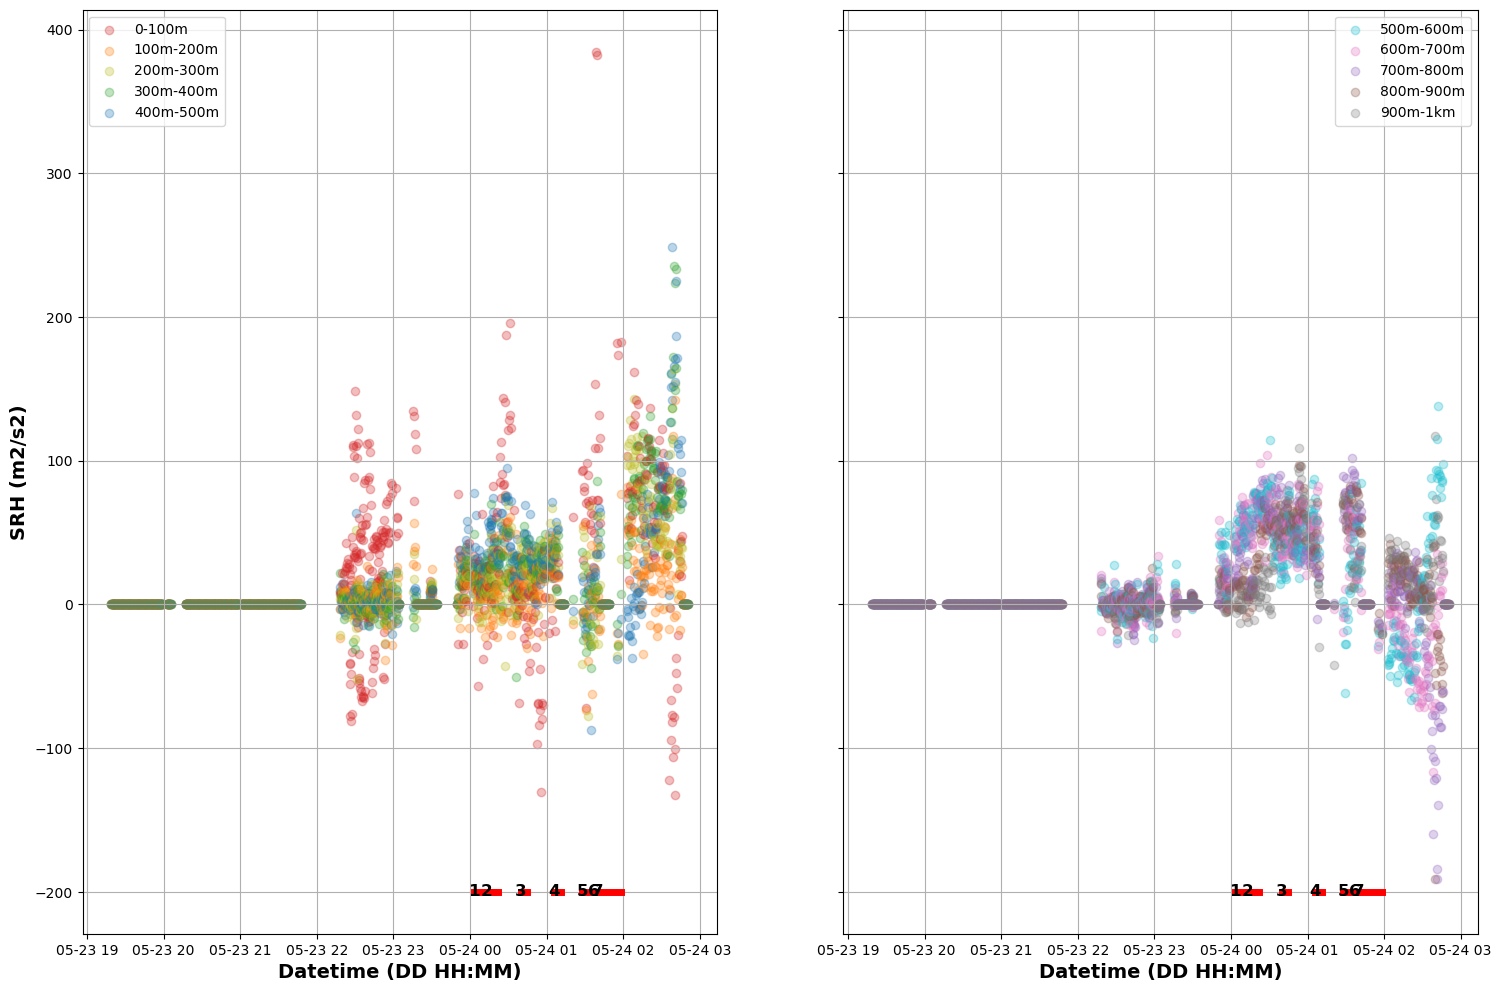

In [26]:
fig, ax = plt.subplots(1,2, figsize=(18,12),sharey=True)
ax[0].grid()
ax[1].grid()

for thefile in vad_fileska1[9:]:

    radar = pyart.io.read_cfradial(thefile)
    print(thefile,radar.fixed_angle['data'])
    
    
    ka1gps['ddmmyy']+ka1gps['hhmmss[UTC]']
    ka1gps['datetime'] = [datetime.strptime(d,'%d%m%y%H%M%S') for d in ka1gps['ddmmyy']+ka1gps['hhmmss[UTC]']]
    beginscanindex = ka1gps.loc[ka1gps['datetime'] == datetime.strptime(radar.time['units'],'seconds since %Y-%m-%dT%H:%M:%SZ')].index+np.amin(np.unique(radar.time['data']))
    endscanindex = ka1gps.loc[ka1gps['datetime'] == datetime.strptime(radar.time['units'],'seconds since %Y-%m-%dT%H:%M:%SZ')].index+np.amax(np.unique(radar.time['data']))
    dfscan = ka1gps.iloc[beginscanindex[0].astype(int):endscanindex[0].astype(int)]
    dfscan = dfscan.astype({'Bearing[degrees]': 'float'})

    #print('velocity [kts]',dfscan['Velocity[knots]'].astype(float).mean(),'+-',dfscan['Velocity[knots]'].astype(float).var())
    speed = dfscan['Velocity[knots]'].astype(float).mean()
    #print('bearing',dfscan['Bearing[degrees]'].astype(float).mean(),'+-',dfscan['Bearing[degrees]'].astype(float).var())
    
#    bearing = 84.6
    if int(ka1scan.loc[ka1scan['Datetime'] == dfscan.datetime.values[0]].Deployment.values[0]) != 0:
        bearing = float(ka1scan.loc[ka1scan['Datetime'] == dfscan.datetime.values[0]].Heading.values[0])
    else:
        bearing = dfscan['Bearing[degrees]'].mean()
        
    if bearing == 80.06703703703703:
        bearing = 190
    elif (bearing == 64.25037037037036):
        bearing = 9.980000000000002
    elif (bearing == 89.28925925925924):
        bearing = 92.6
    elif bearing == 269.9640740740741:
        bearing = 90.6
    elif bearing == 206.84615384615387:
        bearing = 149.0
    elif bearing == 263.8211111111111:
        bearing = 90.2
    
    print('Bearing used: '+str(bearing))
    
    #print('latitude',dfscan['Latitude'].astype(float).mean(),'+-',dfscan['Latitude'].astype(float).var())
    lat = dfscan['Latitude'].astype(float).mean()
    #print('longitude',dfscan['Longitude'].astype(float).mean(),'+-',dfscan['Longitude'].astype(float).var())
    lon = dfscan['Longitude'].astype(float).mean()
    
    display = pyart.graph.RadarMapDisplay(radar)
    
    radar.azimuth['data']+=(bearing)%360
#     if (bearing>=0)&(bearing<=90):
#         (radar.azimuth['data'])+=(bearing*(-1)+90)%360
#     else:
#         (radar.azimuth['data'])+=360-(bearing*(-1)+90)%360

    VAD = pyart.retrieve.vad_browning(radar, 'corrected_velocity', z_want=np.arange(50,5001,10),gatefilter=None)
    u1 = VAD.u_wind
    v1 = VAD.v_wind
    z1 = VAD.height

    u_storm,v_storm = (wind_components(storm_location.iloc[(storm_location['datetime']-dfscan['datetime'].values[0]).abs().argsort()[:1]]['storm_vel'].values 
                                * units('m/s'), 
                               storm_location.iloc[(storm_location['datetime']-dfscan['datetime'].values[0]).abs().argsort()[:1]]['storm_dir'].values 
                                * units.deg))
    
    
    SRH1km = storm_relative_helicity(z1*units('m'),units.Quantity(u1,'m/s'),units.Quantity(v1,'m/s'),
                                  100*units('m'),bottom=900*units('m'),storm_u=u_storm,storm_v=v_storm)[2]
    SRH900m = storm_relative_helicity(z1*units('m'),units.Quantity(u1,'m/s'),units.Quantity(v1,'m/s'),
                                  100*units('m'),bottom=800*units('m'),storm_u=u_storm,storm_v=v_storm)[2]
    SRH700m = storm_relative_helicity(z1*units('m'),units.Quantity(u1,'m/s'),units.Quantity(v1,'m/s'),
                                  100*units('m'),bottom=600*units('m'),storm_u=u_storm,storm_v=v_storm)[2]
    SRH500m = storm_relative_helicity(z1*units('m'),units.Quantity(u1,'m/s'),units.Quantity(v1,'m/s'),
                                  100*units('m'),bottom=400*units('m'),storm_u=u_storm,storm_v=v_storm)[2]
    SRH300m = storm_relative_helicity(z1*units('m'),units.Quantity(u1,'m/s'),units.Quantity(v1,'m/s'),
                                  100*units('m'),bottom=200*units('m'),storm_u=u_storm,storm_v=v_storm)[2]
    SRH100m = storm_relative_helicity(z1*units('m'),units.Quantity(u1,'m/s'),units.Quantity(v1,'m/s'),
                                  100*units('m'),bottom=0*units('m'),storm_u=u_storm,storm_v=v_storm)[2]
    SRH200m = storm_relative_helicity(z1*units('m'),units.Quantity(u1,'m/s'),units.Quantity(v1,'m/s'),
                                  100*units('m'),bottom=100*units('m'),storm_u=u_storm,storm_v=v_storm)[2]
    SRH400m = storm_relative_helicity(z1*units('m'),units.Quantity(u1,'m/s'),units.Quantity(v1,'m/s'),
                                  100*units('m'),bottom=300*units('m'),storm_u=u_storm,storm_v=v_storm)[2]
    SRH600m = storm_relative_helicity(z1*units('m'),units.Quantity(u1,'m/s'),units.Quantity(v1,'m/s'),
                                  100*units('m'),bottom=500*units('m'),storm_u=u_storm,storm_v=v_storm)[2]
    SRH800m = storm_relative_helicity(z1*units('m'),units.Quantity(u1,'m/s'),units.Quantity(v1,'m/s'),
                                  100*units('m'),bottom=700*units('m'),storm_u=u_storm,storm_v=v_storm)[2]
    
#     fwd_azimuth,back_azimuth,distance = geodesic.inv(test.lon.values, test.lat.values, 
#                                                      storm_location.iloc[(storm_location['datetime']
#                                                                           -test.time.values[0]).abs().argsort()[:1]]['Lon'].values, 
#                                                      storm_location.iloc[(storm_location['datetime']
#                                                                           -test.time.values[0]).abs().argsort()[:1]]['Lat'].values)

#     dist = distance/1000
#     bear = back_azimuth
#     c = test.time.values[0]

#     if bear == np.nan:
#         continue
    
    line1=ax[0].scatter(dfscan['datetime'].values[0],SRH100m,color='tab:red',alpha=0.3)
    line2=ax[0].scatter(dfscan['datetime'].values[0],SRH200m,color='tab:orange',alpha=0.3)
    line3=ax[0].scatter(dfscan['datetime'].values[0],SRH300m,color='tab:olive',alpha=0.3)
    line4=ax[0].scatter(dfscan['datetime'].values[0],SRH400m,color='tab:green',alpha=0.3)
    line5=ax[0].scatter(dfscan['datetime'].values[0],SRH500m,color='tab:blue',alpha=0.3)
    line6=ax[1].scatter(dfscan['datetime'].values[0],SRH600m,color='tab:cyan',alpha=0.3)
    line7=ax[1].scatter(dfscan['datetime'].values[0],SRH700m,color='tab:pink',alpha=0.3)
    line8=ax[1].scatter(dfscan['datetime'].values[0],SRH800m,color='tab:purple',alpha=0.3)
    line9=ax[1].scatter(dfscan['datetime'].values[0],SRH900m,color='tab:brown',alpha=0.3)
    line10=ax[1].scatter(dfscan['datetime'].values[0],SRH1km,color='tab:gray',alpha=0.3)

    

for thefile in vad_fileska2[28:]:

    radar = pyart.io.read_cfradial(thefile)
    print(thefile,radar.fixed_angle['data'])
    
    
    ka2gps['ddmmyy']+ka2gps['hhmmss[UTC]']
    ka2gps['datetime'] = [datetime.strptime(d,'%d%m%y%H%M%S') for d in ka2gps['ddmmyy']+ka2gps['hhmmss[UTC]']]
    beginscanindex = ka2gps.loc[ka2gps['datetime'] == datetime.strptime(radar.time['units'],'seconds since %Y-%m-%dT%H:%M:%SZ')].index+np.amin(np.unique(radar.time['data']))
    endscanindex = ka2gps.loc[ka2gps['datetime'] == datetime.strptime(radar.time['units'],'seconds since %Y-%m-%dT%H:%M:%SZ')].index+np.amax(np.unique(radar.time['data']))
    dfscan = ka2gps.iloc[beginscanindex[0].astype(int):endscanindex[0].astype(int)]
    dfscan = dfscan.astype({'Bearing[degrees]': 'float'})

    #print('velocity [kts]',dfscan['Velocity[knots]'].astype(float).mean(),'+-',dfscan['Velocity[knots]'].astype(float).var())
    speed = dfscan['Velocity[knots]'].astype(float).mean()
    #print('bearing',dfscan['Bearing[degrees]'].astype(float).mean(),'+-',dfscan['Bearing[degrees]'].astype(float).var())
    
#    bearing = 84.6
    if int(ka2scan.loc[ka2scan['Datetime'] == dfscan.datetime.values[0]].Deployment.values[0]) != 0:
        bearing = float(ka2scan.loc[ka2scan['Datetime'] == dfscan.datetime.values[0]].Heading.values[0])
    else:
        bearing = dfscan['Bearing[degrees]'].mean()
        
    if bearing == 80.06703703703703:
        bearing = 190
    elif (bearing == 64.25037037037036):
        bearing = 9.980000000000002
    elif (bearing == 89.28925925925924):
        bearing = 92.6
    elif bearing == 269.9640740740741:
        bearing = 90.6
    elif bearing == 206.84615384615387:
        bearing = 149.0
    elif bearing == 263.8211111111111:
        bearing = 90.2
 
    print('Bearing used: '+str(bearing))
    
    #print('latitude',dfscan['Latitude'].astype(float).mean(),'+-',dfscan['Latitude'].astype(float).var())
    lat = dfscan['Latitude'].astype(float).mean()
    #print('longitude',dfscan['Longitude'].astype(float).mean(),'+-',dfscan['Longitude'].astype(float).var())
    lon = dfscan['Longitude'].astype(float).mean()
    
    display = pyart.graph.RadarMapDisplay(radar)
    
    radar.azimuth['data']+=(bearing)%360
    
#     if (bearing>=0)&(bearing<=90):
#         (radar.azimuth['data'])+=(bearing*(-1)+90)%360
#     else:
#         (radar.azimuth['data'])+=360-(bearing*(-1)+90)%360

    VAD = pyart.retrieve.vad_browning(radar, 'corrected_velocity', z_want=np.arange(50,5001,10),gatefilter=None)
    u1 = VAD.u_wind
    v1 = VAD.v_wind
    z1 = VAD.height
    u_storm,v_storm = (wind_components(storm_location.iloc[(storm_location['datetime']-dfscan['datetime'].values[0]).abs().argsort()[:1]]['storm_vel'].values 
                                * units('m/s'), 
                               storm_location.iloc[(storm_location['datetime']-dfscan['datetime'].values[0]).abs().argsort()[:1]]['storm_dir'].values 
                                * units.deg))
    
    
    SRH1km = storm_relative_helicity(z1*units('m'),units.Quantity(u1,'m/s'),units.Quantity(v1,'m/s'),
                                  100*units('m'),bottom=900*units('m'),storm_u=u_storm,storm_v=v_storm)[2]
    SRH900m = storm_relative_helicity(z1*units('m'),units.Quantity(u1,'m/s'),units.Quantity(v1,'m/s'),
                                  100*units('m'),bottom=800*units('m'),storm_u=u_storm,storm_v=v_storm)[2]
    SRH700m = storm_relative_helicity(z1*units('m'),units.Quantity(u1,'m/s'),units.Quantity(v1,'m/s'),
                                  100*units('m'),bottom=600*units('m'),storm_u=u_storm,storm_v=v_storm)[2]
    SRH500m = storm_relative_helicity(z1*units('m'),units.Quantity(u1,'m/s'),units.Quantity(v1,'m/s'),
                                  100*units('m'),bottom=400*units('m'),storm_u=u_storm,storm_v=v_storm)[2]
    SRH300m = storm_relative_helicity(z1*units('m'),units.Quantity(u1,'m/s'),units.Quantity(v1,'m/s'),
                                  100*units('m'),bottom=200*units('m'),storm_u=u_storm,storm_v=v_storm)[2]
    SRH100m = storm_relative_helicity(z1*units('m'),units.Quantity(u1,'m/s'),units.Quantity(v1,'m/s'),
                                  100*units('m'),bottom=0*units('m'),storm_u=u_storm,storm_v=v_storm)[2]
    SRH200m = storm_relative_helicity(z1*units('m'),units.Quantity(u1,'m/s'),units.Quantity(v1,'m/s'),
                                  100*units('m'),bottom=100*units('m'),storm_u=u_storm,storm_v=v_storm)[2]
    SRH400m = storm_relative_helicity(z1*units('m'),units.Quantity(u1,'m/s'),units.Quantity(v1,'m/s'),
                                  100*units('m'),bottom=300*units('m'),storm_u=u_storm,storm_v=v_storm)[2]
    SRH600m = storm_relative_helicity(z1*units('m'),units.Quantity(u1,'m/s'),units.Quantity(v1,'m/s'),
                                  100*units('m'),bottom=500*units('m'),storm_u=u_storm,storm_v=v_storm)[2]
    SRH800m = storm_relative_helicity(z1*units('m'),units.Quantity(u1,'m/s'),units.Quantity(v1,'m/s'),
                                  100*units('m'),bottom=700*units('m'),storm_u=u_storm,storm_v=v_storm)[2]
    
#     fwd_azimuth,back_azimuth,distance = geodesic.inv(test.lon.values, test.lat.values, 
#                                                      storm_location.iloc[(storm_location['datetime']
#                                                                           -test.time.values[0]).abs().argsort()[:1]]['Lon'].values, 
#                                                      storm_location.iloc[(storm_location['datetime']
#                                                                           -test.time.values[0]).abs().argsort()[:1]]['Lat'].values)

#     dist = distance/1000
#     bear = back_azimuth
#     c = test.time.values[0]

#     if bear == np.nan:
#         continue
        
    line1=ax[0].scatter(dfscan['datetime'].values[0],SRH100m,color='tab:red',alpha=0.3)
    line2=ax[0].scatter(dfscan['datetime'].values[0],SRH200m,color='tab:orange',alpha=0.3)
    line3=ax[0].scatter(dfscan['datetime'].values[0],SRH300m,color='tab:olive',alpha=0.3)
    line4=ax[0].scatter(dfscan['datetime'].values[0],SRH400m,color='tab:green',alpha=0.3)
    line5=ax[0].scatter(dfscan['datetime'].values[0],SRH500m,color='tab:blue',alpha=0.3)
    line6=ax[1].scatter(dfscan['datetime'].values[0],SRH600m,color='tab:cyan',alpha=0.3)
    line7=ax[1].scatter(dfscan['datetime'].values[0],SRH700m,color='tab:pink',alpha=0.3)
    line8=ax[1].scatter(dfscan['datetime'].values[0],SRH800m,color='tab:purple',alpha=0.3)
    line9=ax[1].scatter(dfscan['datetime'].values[0],SRH900m,color='tab:brown',alpha=0.3)
    line10=ax[1].scatter(dfscan['datetime'].values[0],SRH1km,color='tab:gray',alpha=0.3)    
    
    
for i in np.arange(0,len(testing.time)-2):
#     if i == 178:
#         continue
#     else:
    test = testing.isel(time=slice(i, i+1))
    #print(test.time.values)
#     test1 = test.where(test.wspd < 40, drop=True)
#     test2 = test1.where(test1.r_sq > 0.95, drop=True)
#     test3 = test2.where(test2.height < 3, drop=True)
#     test4 = test3.where(test3.intensity < 1.01, drop=True)

    u_mob,v_mob = (wind_components(lidar_storm.iloc[(lidar_storm['datetime']-test.time.values[0]).abs().argsort()[:1]]['Spd'].values 
                                * units('knots').to((units.m)/(units.s)), 
                               lidar_storm.iloc[(lidar_storm['datetime']-test.time.values[0]).abs().argsort()[:1]]['Dir'].values 
                                * units.deg))
    u = test['u'][0].values[2:]
    v = test['v'][0].values[2:]
    z = test['height'].values[2:]

    u = np.insert(u, 0, u_mob.magnitude, axis=0)
    v = np.insert(v, 0, v_mob.magnitude, axis=0)
    z = np.insert(z, 0, 0., axis=0)

    # define data with variable attributes
    data_vars = {'u':(['height'], u, 
                             {'units': 'm/s', 
                              'long_name':'ucomponent'}),
                 'v':(['height'], v, 
                             {'units': 'm/s', 
                              'long_name':'vcomponent'})}

    # define coordinates
    coords = {'height': (['height'], z)}

    # create dataset
    testnew = xr.Dataset(data_vars=data_vars, coords=coords)

    u1 = testnew['u'].interp(height=np.arange(0,3.010,0.010))
    v1 = testnew['v'].interp(height=np.arange(0,3.010,0.010))
    z1 = np.arange(0,3.010,0.010)

    u_storm,v_storm = (wind_components(storm_location.iloc[(storm_location['datetime']-test.time.values[0]).abs().argsort()[:1]]['storm_vel'].values 
                                * units('m/s'), 
                               storm_location.iloc[(storm_location['datetime']-test.time.values[0]).abs().argsort()[:1]]['storm_dir'].values 
                                * units.deg))


    SRH1km = storm_relative_helicity(z1*units('km'),u1*units('m/s'),v1*units('m/s'),
                                  100*units('m'),bottom=900*units('m'),storm_u=u_storm,storm_v=v_storm)[2]
    SRH900m = storm_relative_helicity(z1*units('km'),u1*units('m/s'),v1*units('m/s'),
                                  100*units('m'),bottom=800*units('m'),storm_u=u_storm,storm_v=v_storm)[2]
    SRH700m = storm_relative_helicity(z1*units('km'),u1*units('m/s'),v1*units('m/s'),
                                  100*units('m'),bottom=600*units('m'),storm_u=u_storm,storm_v=v_storm)[2]
    SRH500m = storm_relative_helicity(z1*units('km'),u1*units('m/s'),v1*units('m/s'),
                                  100*units('m'),bottom=400*units('m'),storm_u=u_storm,storm_v=v_storm)[2]
    SRH300m = storm_relative_helicity(z1*units('km'),u1*units('m/s'),v1*units('m/s'),
                                  100*units('m'),bottom=200*units('m'),storm_u=u_storm,storm_v=v_storm)[2]
    SRH100m = storm_relative_helicity(z1*units('km'),u1*units('m/s'),v1*units('m/s'),
                                  100*units('m'),bottom=0*units('m'),storm_u=u_storm,storm_v=v_storm)[2]
    SRH200m = storm_relative_helicity(z1*units('km'),u1*units('m/s'),v1*units('m/s'),
                                  100*units('m'),bottom=100*units('m'),storm_u=u_storm,storm_v=v_storm)[2]
    SRH400m = storm_relative_helicity(z1*units('km'),u1*units('m/s'),v1*units('m/s'),
                                  100*units('m'),bottom=300*units('m'),storm_u=u_storm,storm_v=v_storm)[2]
    SRH600m = storm_relative_helicity(z1*units('km'),u1*units('m/s'),v1*units('m/s'),
                                  100*units('m'),bottom=500*units('m'),storm_u=u_storm,storm_v=v_storm)[2]
    SRH800m = storm_relative_helicity(z1*units('km'),u1*units('m/s'),v1*units('m/s'),
                                  100*units('m'),bottom=700*units('m'),storm_u=u_storm,storm_v=v_storm)[2]
    
    fwd_azimuth,back_azimuth,distance = geodesic.inv(test.lon.values, test.lat.values, 
                                                     storm_location.iloc[(storm_location['datetime']
                                                                          -test.time.values[0]).abs().argsort()[:1]]['Lon'].values, 
                                                     storm_location.iloc[(storm_location['datetime']
                                                                          -test.time.values[0]).abs().argsort()[:1]]['Lat'].values)

    dist = distance/1000
    bear = back_azimuth
    c = test.time.values[0]

    if bear == np.nan:
        continue

    line1=ax[0].scatter(test.time.values,SRH100m,color='tab:red',alpha=0.3)
    line2=ax[0].scatter(test.time.values,SRH200m,color='tab:orange',alpha=0.3)
    line3=ax[0].scatter(test.time.values,SRH300m,color='tab:olive',alpha=0.3)
    line4=ax[0].scatter(test.time.values,SRH400m,color='tab:green',alpha=0.3)
    line5=ax[0].scatter(test.time.values,SRH500m,color='tab:blue',alpha=0.3)
    line6=ax[1].scatter(test.time.values,SRH600m,color='tab:cyan',alpha=0.3)
    line7=ax[1].scatter(test.time.values,SRH700m,color='tab:pink',alpha=0.3)
    line8=ax[1].scatter(test.time.values,SRH800m,color='tab:purple',alpha=0.3)
    line9=ax[1].scatter(test.time.values,SRH900m,color='tab:brown',alpha=0.3)
    line10=ax[1].scatter(test.time.values,SRH1km,color='tab:gray',alpha=0.3)    
    

for i,j in zip(tor_paths.start_tor,tor_paths.end_tor):
    ax[0].plot([i,j],[-200,-200],color='red',linewidth=5)
    ax[1].plot([i,j],[-200,-200],color='red',linewidth=5)


for i in np.arange(1,len(tor_paths)+1,1):
    ax[0].annotate(i, xy=(tor_paths.start_tor.iloc[i-1], np.linspace(-200,-200,len(tor_paths.start_tor))[i-1]), fontsize=12, ha="center",va='center',color='k',zorder=30,weight="bold")
    ax[1].annotate(i, xy=(tor_paths.start_tor.iloc[i-1], np.linspace(-200,-200,len(tor_paths.start_tor))[i-1]), fontsize=12, ha="center",va='center',color='k',zorder=30,weight="bold")

ax[0].legend([line1, line2, line3, line4, line5], ['0-100m','100m-200m','200m-300m','300m-400m','400m-500m'])    
ax[1].legend([line6, line7, line8, line9, line10], ['500m-600m','600m-700m','700m-800m','800m-900m','900m-1km'])    
ax[0].set_xlabel('Datetime (DD HH:MM)', fontsize=14, fontweight='bold')
ax[1].set_xlabel('Datetime (DD HH:MM)', fontsize=14, fontweight='bold')
ax[0].set_ylabel('SRH (m2/s2)', fontsize=14, fontweight='bold')
#ax.set_title('IOP3 Ka+Lidar Wind Retrieval: Storm Relative Helicity')
#ax.set_xlim([lidar_storm.iloc[0].datetime, pd.to_datetime('2022/06/12 23:03:00',format='%Y/%m/%d %H:%M:%S')])
#ax.set_ylim([-700,700])
plt.savefig('E:/Lapenta/20220523/Figs/IOP3_kalidarSRH_layers.png',bbox_inches='tight',format='png',dpi=300)
plt.show()

# STATS

E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222551.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222620.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222649.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222718.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222747.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222816.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222845.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6010.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222914.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222943.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223013.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223042.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223111.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223140.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223209.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223238.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6036.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223307.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223336.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223405.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223434.nc [37.001953 45.      ]
Bearing used: 190


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 5992.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523224032.nc [37.001953 45.      ]
Bearing used: 9.980000000000002


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523224101.nc [37.001953 45.      ]
Bearing used: 9.980000000000002


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6001.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523224130.nc [37.001953 45.      ]
Bearing used: 92.6


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523232822.nc [37.001953 45.      ]
Bearing used: 177.76296296296297


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523232852.nc [37.001953 45.      ]
Bearing used: 180.39961538461537


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6009.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523232921.nc [37.001953 45.      ]
Bearing used: 180.77923076923076


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6008.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523232950.nc [37.001953 45.      ]
Bearing used: 149.0


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523233019.nc [37.001953 45.      ]
Bearing used: 90.6


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6008.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220524000309.nc [37.001953 45.      ]
Bearing used: 90.2


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 5999.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222547.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222617.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222647.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222718.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222748.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222818.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222848.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222919.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222949.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223019.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223050.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223120.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6012.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223150.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223220.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6008.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223250.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223321.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223351.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223421.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223452.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223522.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223552.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223622.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223652.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223722.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223753.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223823.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223852.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223922.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223953.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224023.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224053.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6008.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224123.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6001.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224153.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224223.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224253.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224324.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224354.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224425.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224455.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224524.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224554.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224624.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224655.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224726.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224756.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224826.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224856.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224927.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224957.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6004.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523225027.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6012.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523225057.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523225128.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6008.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523225158.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523225228.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523225258.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523225328.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523225358.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220524001616.nc [37.001953 45.      ]
Bearing used: 11.115384615384615


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220524001646.nc [37.001953 45.      ]
Bearing used: 86.4


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6010.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220524005159.nc [37.001953 45.      ]
Bearing used: 183.2255555555556


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220524005332.nc [37.001953 45.      ]
Bearing used: 91.9


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220524012032.nc [37.001953 45.      ]
Bearing used: 121.4


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220524015527.nc [37.001953 45.      ]
Bearing used: 90.5174074074074


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220524015557.nc [37.001953 45.      ]
Bearing used: 90.55703703703703


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220524015759.nc [37.001953 45.      ]
Bearing used: 90.91740740740742


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\numpy\ma\extras.py:290: UserWarning: Warning: converting a masked element to nan.
  _d = func(tuple([np.asarray(a) for a in x]), *args, **params)
C:\Users\joshu\.conda\envs\ox\Lib\site-packages\numpy\core\fromnumeric.py:2009: UserWarning: Warning: converting a masked element to nan.
  result = asarray(a).shape


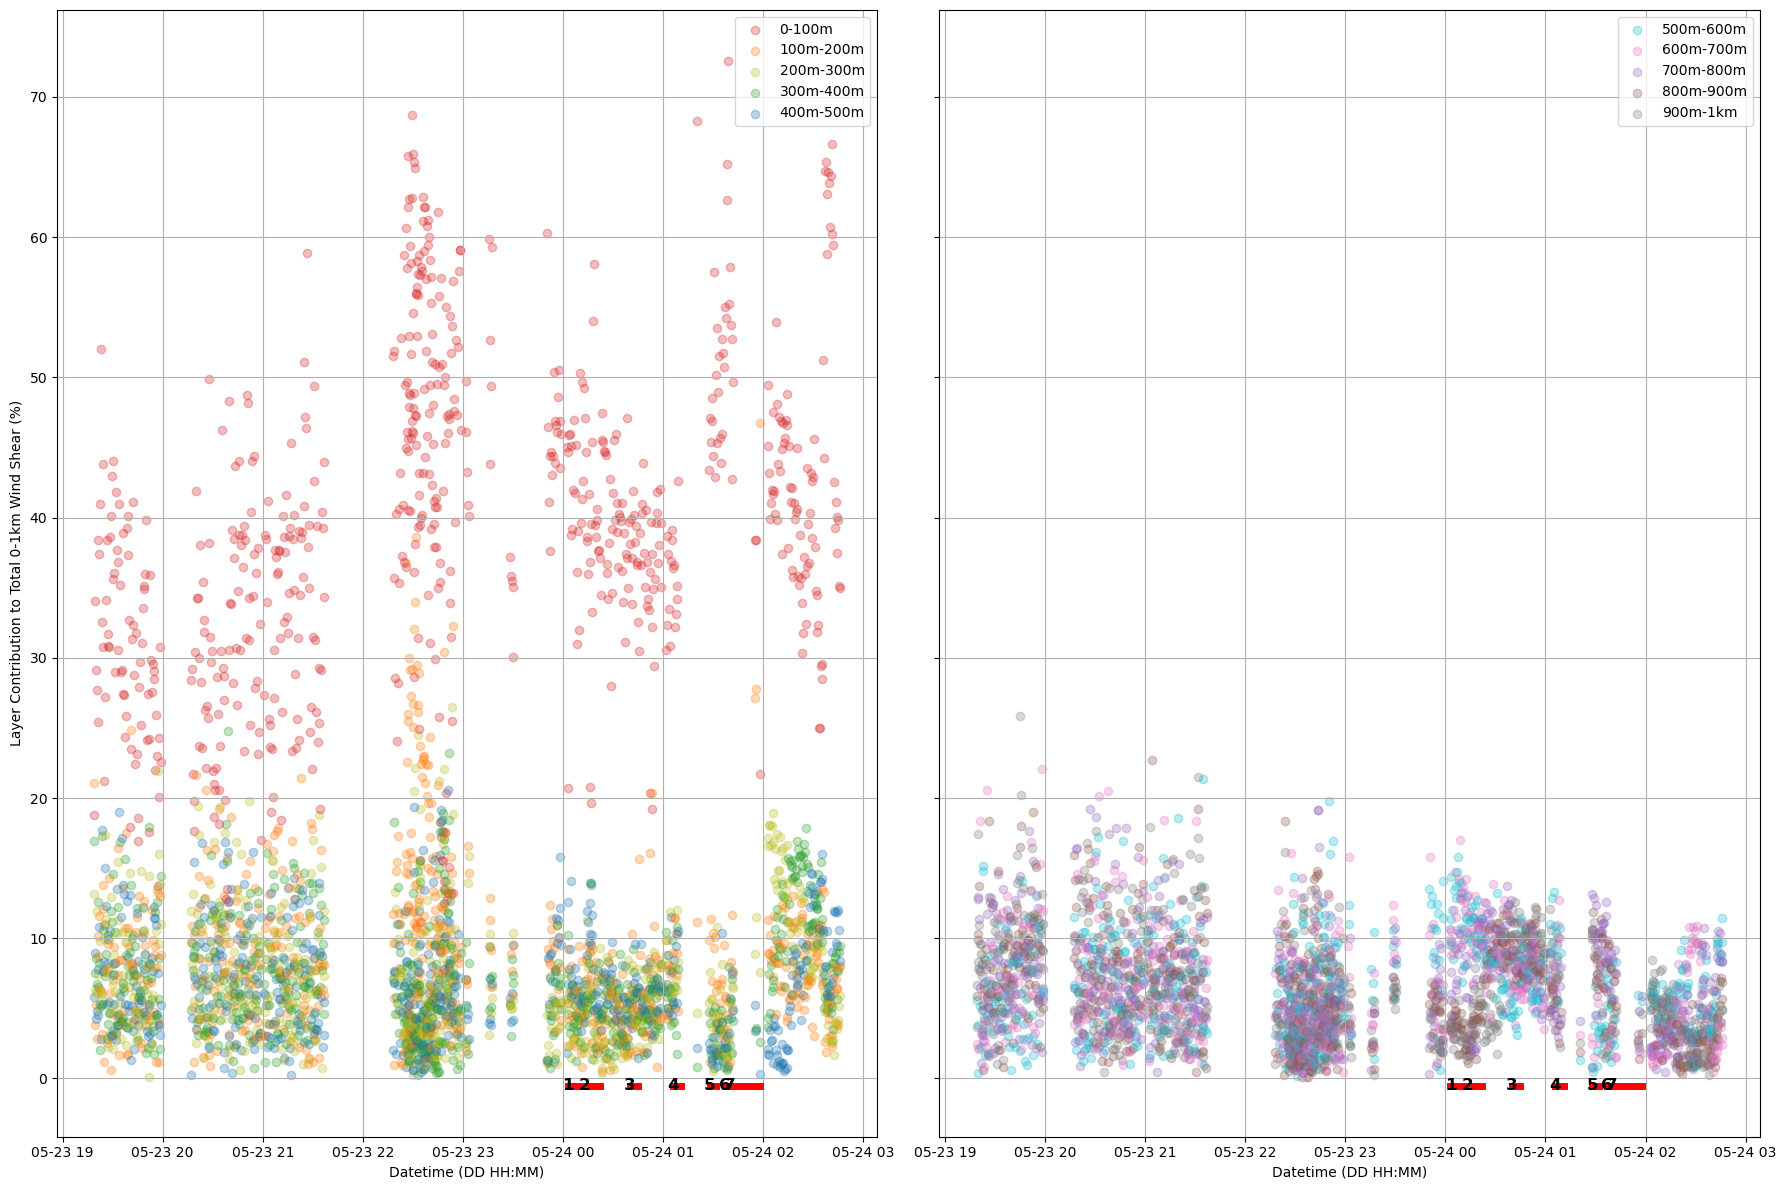

In [18]:
geodesic = pyproj.Geod(ellps='WGS84')

fig, ax = plt.subplots(1,2, figsize=(18,12),sharey=True)
ax[0].grid()
ax[1].grid()


for thefile in vad_fileska1[9:]:

    radar = pyart.io.read_cfradial(thefile)
    print(thefile,radar.fixed_angle['data'])
    
    
    ka1gps['ddmmyy']+ka1gps['hhmmss[UTC]']
    ka1gps['datetime'] = [datetime.strptime(d,'%d%m%y%H%M%S') for d in ka1gps['ddmmyy']+ka1gps['hhmmss[UTC]']]
    beginscanindex = ka1gps.loc[ka1gps['datetime'] == datetime.strptime(radar.time['units'],'seconds since %Y-%m-%dT%H:%M:%SZ')].index+np.amin(np.unique(radar.time['data']))
    endscanindex = ka1gps.loc[ka1gps['datetime'] == datetime.strptime(radar.time['units'],'seconds since %Y-%m-%dT%H:%M:%SZ')].index+np.amax(np.unique(radar.time['data']))
    dfscan = ka1gps.iloc[beginscanindex[0].astype(int):endscanindex[0].astype(int)]
    dfscan = dfscan.astype({'Bearing[degrees]': 'float'})

    #print('velocity [kts]',dfscan['Velocity[knots]'].astype(float).mean(),'+-',dfscan['Velocity[knots]'].astype(float).var())
    speed = dfscan['Velocity[knots]'].astype(float).mean()
    #print('bearing',dfscan['Bearing[degrees]'].astype(float).mean(),'+-',dfscan['Bearing[degrees]'].astype(float).var())
    
#    bearing = 84.6
    if int(ka1scan.loc[ka1scan['Datetime'] == dfscan.datetime.values[0]].Deployment.values[0]) != 0:
        bearing = float(ka1scan.loc[ka1scan['Datetime'] == dfscan.datetime.values[0]].Heading.values[0])
    else:
        bearing = dfscan['Bearing[degrees]'].mean()
        
    if bearing == 80.06703703703703:
        bearing = 190
    elif (bearing == 64.25037037037036):
        bearing = 9.980000000000002
    elif (bearing == 89.28925925925924):
        bearing = 92.6
    elif bearing == 269.9640740740741:
        bearing = 90.6
    elif bearing == 206.84615384615387:
        bearing = 149.0
    elif bearing == 263.8211111111111:
        bearing = 90.2
    
    print('Bearing used: '+str(bearing))
    
    #print('latitude',dfscan['Latitude'].astype(float).mean(),'+-',dfscan['Latitude'].astype(float).var())
    lat = dfscan['Latitude'].astype(float).mean()
    #print('longitude',dfscan['Longitude'].astype(float).mean(),'+-',dfscan['Longitude'].astype(float).var())
    lon = dfscan['Longitude'].astype(float).mean()
    
    display = pyart.graph.RadarMapDisplay(radar)
    
    radar.azimuth['data']+=(bearing)%360
#     if (bearing>=0)&(bearing<=90):
#         (radar.azimuth['data'])+=(bearing*(-1)+90)%360
#     else:
#         (radar.azimuth['data'])+=360-(bearing*(-1)+90)%360

    VAD = pyart.retrieve.vad_browning(radar, 'corrected_velocity', z_want=np.arange(50,5001,10),gatefilter=None)
    u1 = VAD.u_wind
    v1 = VAD.v_wind
   
    
    u_shear = [u1[5]-u1[0],u1[15]-u1[5],u1[25]-u1[15]
               ,u1[35]-u1[25],u1[45]-u1[35],u1[55]-u1[45]
               ,u1[65]-u1[55],u1[75]-u1[65],u1[85]-u1[75]
               ,u1[95]-u1[85]]

    v_shear = [v1[5]-v1[0],v1[15]-v1[5],v1[25]-v1[15]
               ,v1[35]-v1[25],v1[45]-v1[35],v1[55]-v1[45]
               ,v1[65]-v1[55],v1[75]-v1[65],v1[85]-v1[75]
               ,v1[95]-v1[85]]
    wspd_shear = wind_speed(u_shear*units('m/s'),v_shear*units('m/s'))
    z_shear = np.arange(0.1,1.1,0.1)
    
#     fwd_azimuth,back_azimuth,distance = geodesic.inv(test.lon.values, test.lat.values, 
#                                                          storm_location.iloc[(storm_location['datetime']
#                                                                               -test.time.values[0]).abs().argsort()[:1]]['Lon'].values, 
#                                                          storm_location.iloc[(storm_location['datetime']
#                                                                               -test.time.values[0]).abs().argsort()[:1]]['Lat'].values)

#     dist = distance/1000
#     bear = back_azimuth
#     c = test.time.values[0]

#     if bear == np.nan:
#         continue
    
    total_shear = np.nansum(np.array(wspd_shear))*units('m/s')      
    line1=ax[0].scatter(dfscan['datetime'].values[0],(wspd_shear[0]/total_shear)*100,color='tab:red',alpha=0.3)
    line2=ax[0].scatter(dfscan['datetime'].values[0],(wspd_shear[1]/total_shear)*100,color='tab:orange',alpha=0.3)
    line3=ax[0].scatter(dfscan['datetime'].values[0],(wspd_shear[2]/total_shear)*100,color='tab:olive',alpha=0.3)
    line4=ax[0].scatter(dfscan['datetime'].values[0],(wspd_shear[3]/total_shear)*100,color='tab:green',alpha=0.3)
    line5=ax[0].scatter(dfscan['datetime'].values[0],(wspd_shear[4]/total_shear)*100,color='tab:blue',alpha=0.3)
    line6=ax[1].scatter(dfscan['datetime'].values[0],(wspd_shear[5]/total_shear)*100,color='tab:cyan',alpha=0.3)
    line7=ax[1].scatter(dfscan['datetime'].values[0],(wspd_shear[6]/total_shear)*100,color='tab:pink',alpha=0.3)
    line8=ax[1].scatter(dfscan['datetime'].values[0],(wspd_shear[7]/total_shear)*100,color='tab:purple',alpha=0.3)
    line9=ax[1].scatter(dfscan['datetime'].values[0],(wspd_shear[8]/total_shear)*100,color='tab:brown',alpha=0.3)
    line10=ax[1].scatter(dfscan['datetime'].values[0],(wspd_shear[9]/total_shear)*100,color='tab:gray',alpha=0.3)
    
for thefile in vad_fileska2[28:]:

    radar = pyart.io.read_cfradial(thefile)
    print(thefile,radar.fixed_angle['data'])
    
    
    ka2gps['ddmmyy']+ka2gps['hhmmss[UTC]']
    ka2gps['datetime'] = [datetime.strptime(d,'%d%m%y%H%M%S') for d in ka2gps['ddmmyy']+ka2gps['hhmmss[UTC]']]
    beginscanindex = ka2gps.loc[ka2gps['datetime'] == datetime.strptime(radar.time['units'],'seconds since %Y-%m-%dT%H:%M:%SZ')].index+np.amin(np.unique(radar.time['data']))
    endscanindex = ka2gps.loc[ka2gps['datetime'] == datetime.strptime(radar.time['units'],'seconds since %Y-%m-%dT%H:%M:%SZ')].index+np.amax(np.unique(radar.time['data']))
    dfscan = ka2gps.iloc[beginscanindex[0].astype(int):endscanindex[0].astype(int)]
    dfscan = dfscan.astype({'Bearing[degrees]': 'float'})

    #print('velocity [kts]',dfscan['Velocity[knots]'].astype(float).mean(),'+-',dfscan['Velocity[knots]'].astype(float).var())
    speed = dfscan['Velocity[knots]'].astype(float).mean()
    #print('bearing',dfscan['Bearing[degrees]'].astype(float).mean(),'+-',dfscan['Bearing[degrees]'].astype(float).var())
    
#    bearing = 84.6
    if int(ka2scan.loc[ka2scan['Datetime'] == dfscan.datetime.values[0]].Deployment.values[0]) != 0:
        bearing = float(ka2scan.loc[ka2scan['Datetime'] == dfscan.datetime.values[0]].Heading.values[0])
    else:
        bearing = dfscan['Bearing[degrees]'].mean()
        
    if bearing == 80.06703703703703:
        bearing = 190
    elif (bearing == 64.25037037037036):
        bearing = 9.980000000000002
    elif (bearing == 89.28925925925924):
        bearing = 92.6
    elif bearing == 269.9640740740741:
        bearing = 90.6
    elif bearing == 206.84615384615387:
        bearing = 149.0
    elif bearing == 263.8211111111111:
        bearing = 90.2
 
    print('Bearing used: '+str(bearing))
    
    #print('latitude',dfscan['Latitude'].astype(float).mean(),'+-',dfscan['Latitude'].astype(float).var())
    lat = dfscan['Latitude'].astype(float).mean()
    #print('longitude',dfscan['Longitude'].astype(float).mean(),'+-',dfscan['Longitude'].astype(float).var())
    lon = dfscan['Longitude'].astype(float).mean()
    
    display = pyart.graph.RadarMapDisplay(radar)
    
    radar.azimuth['data']+=(bearing)%360
    
#     if (bearing>=0)&(bearing<=90):
#         (radar.azimuth['data'])+=(bearing*(-1)+90)%360
#     else:
#         (radar.azimuth['data'])+=360-(bearing*(-1)+90)%360

    VAD = pyart.retrieve.vad_browning(radar, 'corrected_velocity', z_want=np.arange(50,5001,10),gatefilter=None)
    u1 = VAD.u_wind
    v1 = VAD.v_wind
    
    u_shear = [u1[5]-u1[0],u1[15]-u1[5],u1[25]-u1[15]
               ,u1[35]-u1[25],u1[45]-u1[35],u1[55]-u1[45]
               ,u1[65]-u1[55],u1[75]-u1[65],u1[85]-u1[75]
               ,u1[95]-u1[85]]

    v_shear = [v1[5]-v1[0],v1[15]-v1[5],v1[25]-v1[15]
               ,v1[35]-v1[25],v1[45]-v1[35],v1[55]-v1[45]
               ,v1[65]-v1[55],v1[75]-v1[65],v1[85]-v1[75]
               ,v1[95]-v1[85]]
    wspd_shear = wind_speed(u_shear*units('m/s'),v_shear*units('m/s'))
    z_shear = np.arange(0.1,1.1,0.1)
    
#     fwd_azimuth,back_azimuth,distance = geodesic.inv(test.lon.values, test.lat.values, 
#                                                          storm_location.iloc[(storm_location['datetime']
#                                                                               -test.time.values[0]).abs().argsort()[:1]]['Lon'].values, 
#                                                          storm_location.iloc[(storm_location['datetime']
#                                                                               -test.time.values[0]).abs().argsort()[:1]]['Lat'].values)

#     dist = distance/1000
#     bear = back_azimuth
#     c = test.time.values[0]

#     if bear == np.nan:
#         continue

    total_shear = np.nansum(np.array(wspd_shear))*units('m/s')      
    line1=ax[0].scatter(dfscan['datetime'].values[0],(wspd_shear[0]/total_shear)*100,color='tab:red',alpha=0.3)
    line2=ax[0].scatter(dfscan['datetime'].values[0],(wspd_shear[1]/total_shear)*100,color='tab:orange',alpha=0.3)
    line3=ax[0].scatter(dfscan['datetime'].values[0],(wspd_shear[2]/total_shear)*100,color='tab:olive',alpha=0.3)
    line4=ax[0].scatter(dfscan['datetime'].values[0],(wspd_shear[3]/total_shear)*100,color='tab:green',alpha=0.3)
    line5=ax[0].scatter(dfscan['datetime'].values[0],(wspd_shear[4]/total_shear)*100,color='tab:blue',alpha=0.3)
    line6=ax[1].scatter(dfscan['datetime'].values[0],(wspd_shear[5]/total_shear)*100,color='tab:cyan',alpha=0.3)
    line7=ax[1].scatter(dfscan['datetime'].values[0],(wspd_shear[6]/total_shear)*100,color='tab:pink',alpha=0.3)
    line8=ax[1].scatter(dfscan['datetime'].values[0],(wspd_shear[7]/total_shear)*100,color='tab:purple',alpha=0.3)
    line9=ax[1].scatter(dfscan['datetime'].values[0],(wspd_shear[8]/total_shear)*100,color='tab:brown',alpha=0.3)
    line10=ax[1].scatter(dfscan['datetime'].values[0],(wspd_shear[9]/total_shear)*100,color='tab:gray',alpha=0.3)
    
for i in np.arange(0,len(testing.time)-2):
#     if i == 178:
#         continue
#     else:
    test = testing.isel(time=slice(i, i+1))
    #print(test.time.values)
#     test1 = test.where(test.wspd < 40, drop=True)
#     test2 = test1.where(test1.r_sq > 0.95, drop=True)
#     test3 = test2.where(test2.height < 3, drop=True)
#     test4 = test3.where(test3.intensity < 1.01, drop=True)

    u_mob,v_mob = (wind_components(lidar_storm.iloc[(lidar_storm['datetime']-test.time.values[0]).abs().argsort()[:1]]['Spd'].values 
                                * units('knots').to((units.m)/(units.s)), 
                               lidar_storm.iloc[(lidar_storm['datetime']-test.time.values[0]).abs().argsort()[:1]]['Dir'].values 
                                * units.deg))
    u = test['u'][0].values[2:]
    v = test['v'][0].values[2:]
    z = test['height'].values[2:]

    u = np.insert(u, 0, u_mob.magnitude, axis=0)
    v = np.insert(v, 0, v_mob.magnitude, axis=0)
    z = np.insert(z, 0, 0., axis=0)

    # define data with variable attributes
    data_vars = {'u':(['height'], u, 
                             {'units': 'm/s', 
                              'long_name':'ucomponent'}),
                 'v':(['height'], v, 
                             {'units': 'm/s', 
                              'long_name':'vcomponent'})}

    # define coordinates
    coords = {'height': (['height'], z)}

    # create dataset
    testnew = xr.Dataset(data_vars=data_vars, coords=coords)

    u1 = testnew['u'].interp(height=np.arange(0,3.010,0.010))
    v1 = testnew['v'].interp(height=np.arange(0,3.010,0.010))
    z1 = np.arange(0,3.010,0.010)
    u_shear = [u1[10].values-u1[0].values,u1[20].values-u1[10].values,u1[30].values-u1[20].values
               ,u1[40].values-u1[30].values,u1[50].values-u1[40].values,u1[60].values-u1[50].values
               ,u1[70].values-u1[60].values,u1[80].values-u1[70].values,u1[90].values-u1[80].values
               ,u1[100].values-u1[90].values]

    v_shear = [v1[10].values-v1[0].values,v1[20].values-v1[10].values,v1[30].values-v1[20].values
               ,v1[40].values-v1[30].values,v1[50].values-v1[40].values,v1[60].values-v1[50].values
               ,v1[70].values-v1[60].values,v1[80].values-v1[70].values,v1[90].values-v1[80].values
               ,v1[100].values-v1[90].values]
    
    
    wspd_shear = wind_speed(u_shear*units('m/s'),v_shear*units('m/s'))
    z_shear = np.arange(0.1,1.1,0.1)
    
    fwd_azimuth,back_azimuth,distance = geodesic.inv(test.lon.values, test.lat.values, 
                                                         storm_location.iloc[(storm_location['datetime']
                                                                              -test.time.values[0]).abs().argsort()[:1]]['Lon'].values, 
                                                         storm_location.iloc[(storm_location['datetime']
                                                                              -test.time.values[0]).abs().argsort()[:1]]['Lat'].values)

    dist = distance/1000
    bear = back_azimuth
    c = test.time.values[0]

    if bear == np.nan:
        continue

    total_shear = np.nansum(np.array(wspd_shear))*units('m/s')      
    line1=ax[0].scatter(test.time.values,(wspd_shear[0]/total_shear)*100,color='tab:red',alpha=0.3)
    line2=ax[0].scatter(test.time.values,(wspd_shear[1]/total_shear)*100,color='tab:orange',alpha=0.3)
    line3=ax[0].scatter(test.time.values,(wspd_shear[2]/total_shear)*100,color='tab:olive',alpha=0.3)
    line4=ax[0].scatter(test.time.values,(wspd_shear[3]/total_shear)*100,color='tab:green',alpha=0.3)
    line5=ax[0].scatter(test.time.values,(wspd_shear[4]/total_shear)*100,color='tab:blue',alpha=0.3)
    line6=ax[1].scatter(test.time.values,(wspd_shear[5]/total_shear)*100,color='tab:cyan',alpha=0.3)
    line7=ax[1].scatter(test.time.values,(wspd_shear[6]/total_shear)*100,color='tab:pink',alpha=0.3)
    line8=ax[1].scatter(test.time.values,(wspd_shear[7]/total_shear)*100,color='tab:purple',alpha=0.3)
    line9=ax[1].scatter(test.time.values,(wspd_shear[8]/total_shear)*100,color='tab:brown',alpha=0.3)
    line10=ax[1].scatter(test.time.values,(wspd_shear[9]/total_shear)*100,color='tab:gray',alpha=0.3)

    
    

for i,j in zip(tor_paths.start_tor,tor_paths.end_tor):
    ax[0].plot([i,j],[-.5,-.5],color='red',linewidth=5)
    ax[1].plot([i,j],[-.5,-.5],color='red',linewidth=5)


for i in np.arange(1,len(tor_paths)+1,1):
    ax[0].annotate(i, xy=(tor_paths.start_tor.iloc[i-1], np.linspace(-0.5,-0.5,len(tor_paths.start_tor))[i-1]), fontsize=12, ha="center",va='center',color='k',zorder=30,weight="bold")
    ax[1].annotate(i, xy=(tor_paths.start_tor.iloc[i-1], np.linspace(-0.5,-0.5,len(tor_paths.start_tor))[i-1]), fontsize=12, ha="center",va='center',color='k',zorder=30,weight="bold")

ax[0].legend([line1, line2, line3, line4, line5], ['0-100m','100m-200m','200m-300m','300m-400m','400m-500m'])    
ax[1].legend([line6, line7, line8, line9, line10], ['500m-600m','600m-700m','700m-800m','800m-900m','900m-1km'])    
ax[0].set_xlabel('Datetime (DD HH:MM)')
ax[0].set_ylabel('Layer Contribution to Total 0-1km Wind Shear (%)')
ax[1].set_xlabel('Datetime (DD HH:MM)')
# ax.set_title('IOP3 Ka+Lidar Wind Retrieval: Wind Shear')
#ax.set_xlim([lidar_storm.iloc[0].datetime, pd.to_datetime('2022/06/12 23:03:00',format='%Y/%m/%d %H:%M:%S')])
#ax.set_ylim([0,50])
fig.tight_layout()
plt.savefig('E:/Lapenta/20220523/Figs/IOP3_kalidar_percentshear.png',bbox_inches='tight',format='png',dpi=300)
plt.show()

E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222551.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222620.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222649.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222718.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222747.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222816.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222845.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6010.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222914.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222943.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223013.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223042.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223111.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223140.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223209.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223238.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6036.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223307.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223336.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223405.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223434.nc [37.001953 45.      ]
Bearing used: 190


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 5992.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523224032.nc [37.001953 45.      ]
Bearing used: 9.980000000000002


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523224101.nc [37.001953 45.      ]
Bearing used: 9.980000000000002


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6001.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523224130.nc [37.001953 45.      ]
Bearing used: 92.6


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523232822.nc [37.001953 45.      ]
Bearing used: 177.76296296296297


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523232852.nc [37.001953 45.      ]
Bearing used: 180.39961538461537


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6009.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523232921.nc [37.001953 45.      ]
Bearing used: 180.77923076923076


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6008.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523232950.nc [37.001953 45.      ]
Bearing used: 149.0


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523233019.nc [37.001953 45.      ]
Bearing used: 90.6


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6008.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220524000309.nc [37.001953 45.      ]
Bearing used: 90.2


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 5999.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222547.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222617.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222647.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222718.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222748.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222818.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222848.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222919.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222949.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223019.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223050.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223120.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6012.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223150.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223220.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6008.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223250.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223321.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223351.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223421.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223452.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223522.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223552.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223622.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223652.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223722.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223753.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223823.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223852.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223922.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223953.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224023.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224053.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6008.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224123.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6001.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224153.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224223.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224253.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224324.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224354.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224425.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224455.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224524.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224554.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224624.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224655.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224726.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224756.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224826.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224856.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224927.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224957.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6004.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523225027.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6012.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523225057.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523225128.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6008.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523225158.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523225228.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523225258.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523225328.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523225358.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220524001616.nc [37.001953 45.      ]
Bearing used: 11.115384615384615


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220524001646.nc [37.001953 45.      ]
Bearing used: 86.4


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6010.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220524005159.nc [37.001953 45.      ]
Bearing used: 183.2255555555556


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220524005332.nc [37.001953 45.      ]
Bearing used: 91.9


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220524012032.nc [37.001953 45.      ]
Bearing used: 121.4


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220524015527.nc [37.001953 45.      ]
Bearing used: 90.5174074074074


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220524015557.nc [37.001953 45.      ]
Bearing used: 90.55703703703703


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220524015759.nc [37.001953 45.      ]
Bearing used: 90.91740740740742


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters


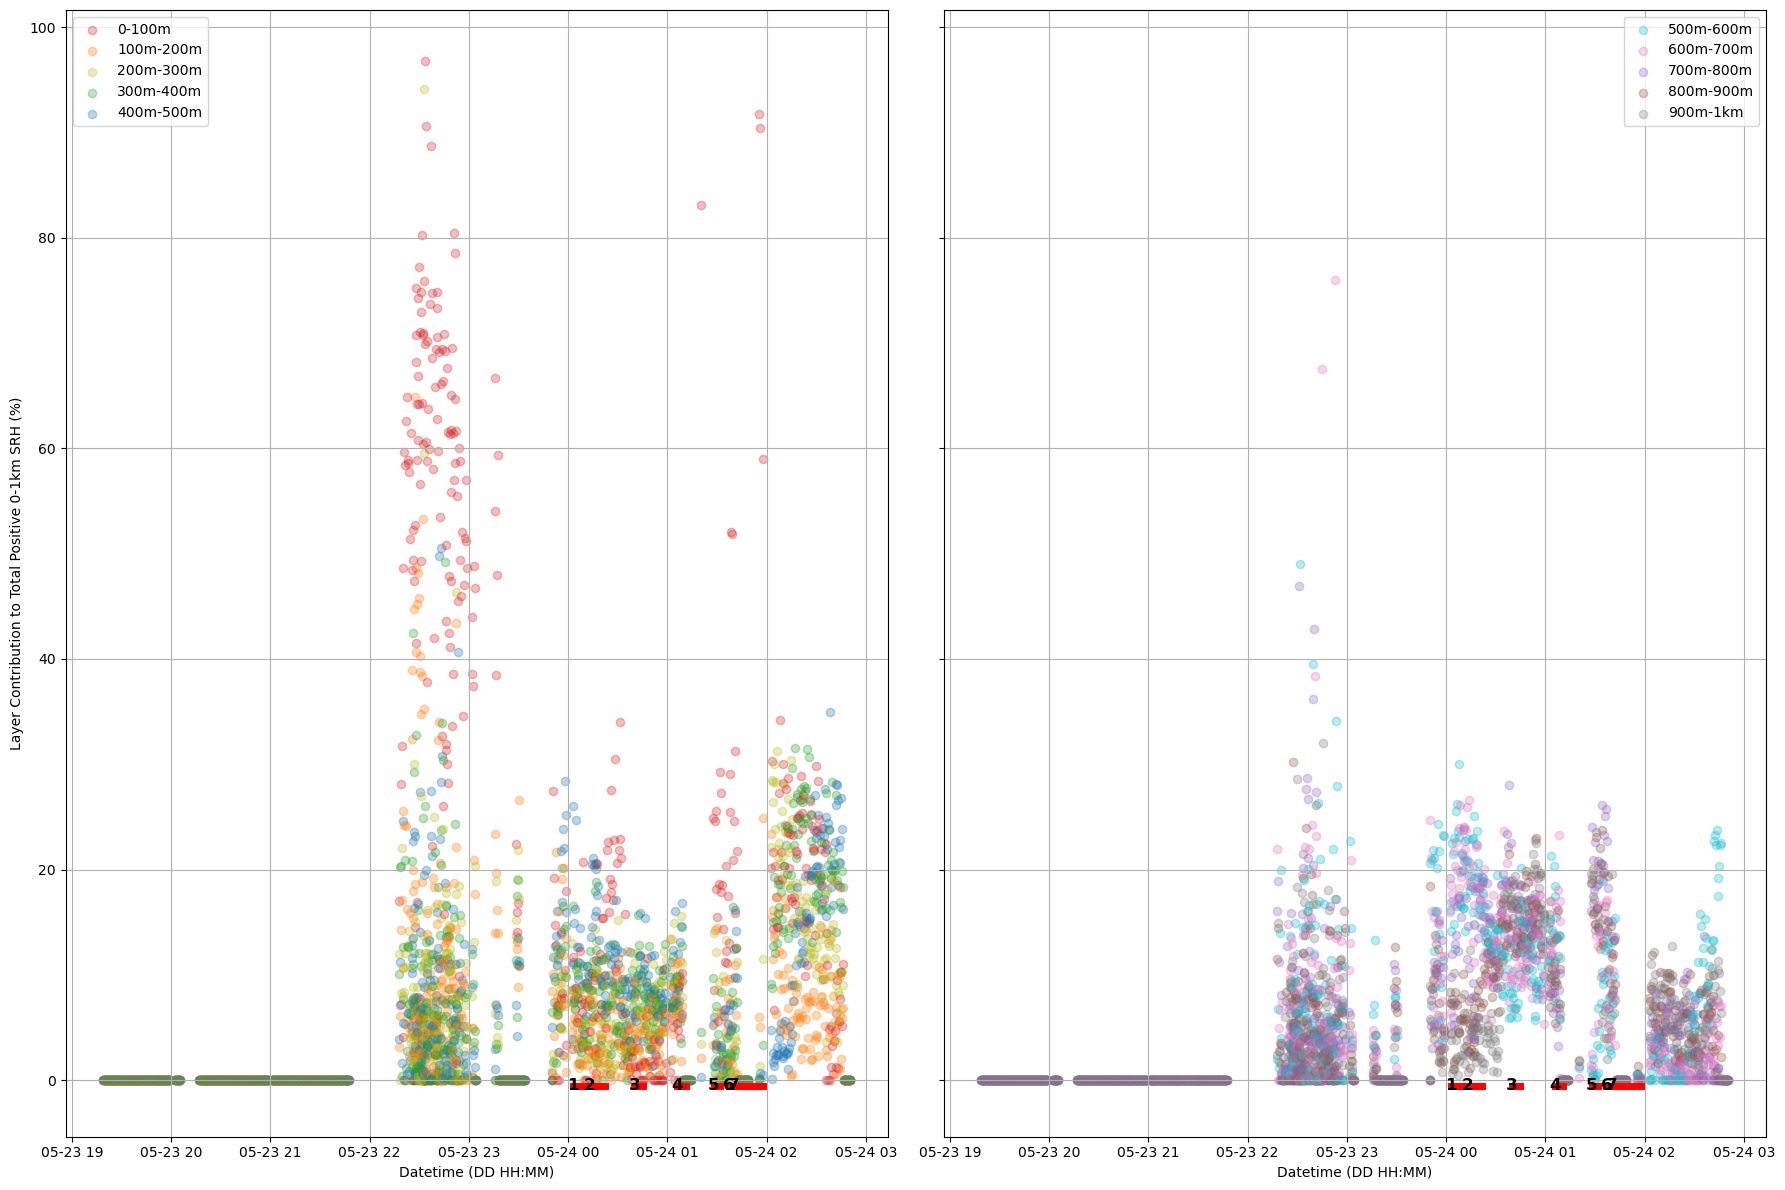

In [34]:
fig, ax = plt.subplots(1,2, figsize=(18,12),sharey=True)
ax[0].grid()
ax[1].grid()

for thefile in vad_fileska1[9:]:

    radar = pyart.io.read_cfradial(thefile)
    print(thefile,radar.fixed_angle['data'])
    
    
    ka1gps['ddmmyy']+ka1gps['hhmmss[UTC]']
    ka1gps['datetime'] = [datetime.strptime(d,'%d%m%y%H%M%S') for d in ka1gps['ddmmyy']+ka1gps['hhmmss[UTC]']]
    beginscanindex = ka1gps.loc[ka1gps['datetime'] == datetime.strptime(radar.time['units'],'seconds since %Y-%m-%dT%H:%M:%SZ')].index+np.amin(np.unique(radar.time['data']))
    endscanindex = ka1gps.loc[ka1gps['datetime'] == datetime.strptime(radar.time['units'],'seconds since %Y-%m-%dT%H:%M:%SZ')].index+np.amax(np.unique(radar.time['data']))
    dfscan = ka1gps.iloc[beginscanindex[0].astype(int):endscanindex[0].astype(int)]
    dfscan = dfscan.astype({'Bearing[degrees]': 'float'})

    #print('velocity [kts]',dfscan['Velocity[knots]'].astype(float).mean(),'+-',dfscan['Velocity[knots]'].astype(float).var())
    speed = dfscan['Velocity[knots]'].astype(float).mean()
    #print('bearing',dfscan['Bearing[degrees]'].astype(float).mean(),'+-',dfscan['Bearing[degrees]'].astype(float).var())
    
#    bearing = 84.6
    if int(ka1scan.loc[ka1scan['Datetime'] == dfscan.datetime.values[0]].Deployment.values[0]) != 0:
        bearing = float(ka1scan.loc[ka1scan['Datetime'] == dfscan.datetime.values[0]].Heading.values[0])
    else:
        bearing = dfscan['Bearing[degrees]'].mean()
        
    if bearing == 80.06703703703703:
        bearing = 190
    elif (bearing == 64.25037037037036):
        bearing = 9.980000000000002
    elif (bearing == 89.28925925925924):
        bearing = 92.6
    elif bearing == 269.9640740740741:
        bearing = 90.6
    elif bearing == 206.84615384615387:
        bearing = 149.0
    elif bearing == 263.8211111111111:
        bearing = 90.2
    
    print('Bearing used: '+str(bearing))
    
    #print('latitude',dfscan['Latitude'].astype(float).mean(),'+-',dfscan['Latitude'].astype(float).var())
    lat = dfscan['Latitude'].astype(float).mean()
    #print('longitude',dfscan['Longitude'].astype(float).mean(),'+-',dfscan['Longitude'].astype(float).var())
    lon = dfscan['Longitude'].astype(float).mean()
    
    display = pyart.graph.RadarMapDisplay(radar)
    
    radar.azimuth['data']+=(bearing)%360
#     if (bearing>=0)&(bearing<=90):
#         (radar.azimuth['data'])+=(bearing*(-1)+90)%360
#     else:
#         (radar.azimuth['data'])+=360-(bearing*(-1)+90)%360

    VAD = pyart.retrieve.vad_browning(radar, 'corrected_velocity', z_want=np.arange(50,5001,10),gatefilter=None)
    u1 = VAD.u_wind
    v1 = VAD.v_wind
    z1 = VAD.height

    u_storm,v_storm = (wind_components(storm_location.iloc[(storm_location['datetime']-dfscan['datetime'].values[0]).abs().argsort()[:1]]['storm_vel'].values 
                                * units('m/s'), 
                               storm_location.iloc[(storm_location['datetime']-dfscan['datetime'].values[0]).abs().argsort()[:1]]['storm_dir'].values 
                                * units.deg))
    
    
    SRH1km = storm_relative_helicity(z1*units('m'),units.Quantity(u1,'m/s'),units.Quantity(v1,'m/s'),
                                  100*units('m'),bottom=900*units('m'),storm_u=u_storm,storm_v=v_storm)[0]
    SRH900m = storm_relative_helicity(z1*units('m'),units.Quantity(u1,'m/s'),units.Quantity(v1,'m/s'),
                                  100*units('m'),bottom=800*units('m'),storm_u=u_storm,storm_v=v_storm)[0]
    SRH700m = storm_relative_helicity(z1*units('m'),units.Quantity(u1,'m/s'),units.Quantity(v1,'m/s'),
                                  100*units('m'),bottom=600*units('m'),storm_u=u_storm,storm_v=v_storm)[0]
    SRH500m = storm_relative_helicity(z1*units('m'),units.Quantity(u1,'m/s'),units.Quantity(v1,'m/s'),
                                  100*units('m'),bottom=400*units('m'),storm_u=u_storm,storm_v=v_storm)[0]
    SRH300m = storm_relative_helicity(z1*units('m'),units.Quantity(u1,'m/s'),units.Quantity(v1,'m/s'),
                                  100*units('m'),bottom=200*units('m'),storm_u=u_storm,storm_v=v_storm)[0]
    SRH100m = storm_relative_helicity(z1*units('m'),units.Quantity(u1,'m/s'),units.Quantity(v1,'m/s'),
                                  100*units('m'),bottom=0*units('m'),storm_u=u_storm,storm_v=v_storm)[0]
    SRH200m = storm_relative_helicity(z1*units('m'),units.Quantity(u1,'m/s'),units.Quantity(v1,'m/s'),
                                  100*units('m'),bottom=100*units('m'),storm_u=u_storm,storm_v=v_storm)[0]
    SRH400m = storm_relative_helicity(z1*units('m'),units.Quantity(u1,'m/s'),units.Quantity(v1,'m/s'),
                                  100*units('m'),bottom=300*units('m'),storm_u=u_storm,storm_v=v_storm)[0]
    SRH600m = storm_relative_helicity(z1*units('m'),units.Quantity(u1,'m/s'),units.Quantity(v1,'m/s'),
                                  100*units('m'),bottom=500*units('m'),storm_u=u_storm,storm_v=v_storm)[0]
    SRH800m = storm_relative_helicity(z1*units('m'),units.Quantity(u1,'m/s'),units.Quantity(v1,'m/s'),
                                  100*units('m'),bottom=700*units('m'),storm_u=u_storm,storm_v=v_storm)[0]
    
#     fwd_azimuth,back_azimuth,distance = geodesic.inv(test.lon.values, test.lat.values, 
#                                                      storm_location.iloc[(storm_location['datetime']
#                                                                           -test.time.values[0]).abs().argsort()[:1]]['Lon'].values, 
#                                                      storm_location.iloc[(storm_location['datetime']
#                                                                           -test.time.values[0]).abs().argsort()[:1]]['Lat'].values)

#     dist = distance/1000
#     bear = back_azimuth
#     c = test.time.values[0]

#     if bear == np.nan:
#         continue
    
    total_srh = storm_relative_helicity(z1*units('m'),units.Quantity(u1,'m/s'),units.Quantity(v1,'m/s'),
                                  1*units('km'),bottom=0*units('m'),storm_u=u_storm,storm_v=v_storm)[0]
    if total_srh.magnitude == 0.0:
        line1=ax[0].scatter(dfscan['datetime'].values[0],0,color='tab:red',alpha=0.3)
        line2=ax[0].scatter(dfscan['datetime'].values[0],0,color='tab:orange',alpha=0.3)
        line3=ax[0].scatter(dfscan['datetime'].values[0],0,color='tab:olive',alpha=0.3)
        line4=ax[0].scatter(dfscan['datetime'].values[0],0,color='tab:green',alpha=0.3)
        line5=ax[0].scatter(dfscan['datetime'].values[0],0,color='tab:blue',alpha=0.3)
        line6=ax[1].scatter(dfscan['datetime'].values[0],0,color='tab:cyan',alpha=0.3)
        line7=ax[1].scatter(dfscan['datetime'].values[0],0,color='tab:pink',alpha=0.3)
        line8=ax[1].scatter(dfscan['datetime'].values[0],0,color='tab:purple',alpha=0.3)
        line9=ax[1].scatter(dfscan['datetime'].values[0],0,color='tab:brown',alpha=0.3)
        line10=ax[1].scatter(dfscan['datetime'].values[0],0,color='tab:gray',alpha=0.3)
    else:
        line1=ax[0].scatter(dfscan['datetime'].values[0],(SRH100m/total_srh)*100,color='tab:red',alpha=0.3)
        line2=ax[0].scatter(dfscan['datetime'].values[0],(SRH200m/total_srh)*100,color='tab:orange',alpha=0.3)
        line3=ax[0].scatter(dfscan['datetime'].values[0],(SRH300m/total_srh)*100,color='tab:olive',alpha=0.3)
        line4=ax[0].scatter(dfscan['datetime'].values[0],(SRH400m/total_srh)*100,color='tab:green',alpha=0.3)
        line5=ax[0].scatter(dfscan['datetime'].values[0],(SRH500m/total_srh)*100,color='tab:blue',alpha=0.3)
        line6=ax[1].scatter(dfscan['datetime'].values[0],(SRH600m/total_srh)*100,color='tab:cyan',alpha=0.3)
        line7=ax[1].scatter(dfscan['datetime'].values[0],(SRH700m/total_srh)*100,color='tab:pink',alpha=0.3)
        line8=ax[1].scatter(dfscan['datetime'].values[0],(SRH800m/total_srh)*100,color='tab:purple',alpha=0.3)
        line9=ax[1].scatter(dfscan['datetime'].values[0],(SRH900m/total_srh)*100,color='tab:brown',alpha=0.3)
        line10=ax[1].scatter(dfscan['datetime'].values[0],(SRH1km/total_srh)*100,color='tab:gray',alpha=0.3)

    

for thefile in vad_fileska2[28:]:

    radar = pyart.io.read_cfradial(thefile)
    print(thefile,radar.fixed_angle['data'])
    
    
    ka2gps['ddmmyy']+ka2gps['hhmmss[UTC]']
    ka2gps['datetime'] = [datetime.strptime(d,'%d%m%y%H%M%S') for d in ka2gps['ddmmyy']+ka2gps['hhmmss[UTC]']]
    beginscanindex = ka2gps.loc[ka2gps['datetime'] == datetime.strptime(radar.time['units'],'seconds since %Y-%m-%dT%H:%M:%SZ')].index+np.amin(np.unique(radar.time['data']))
    endscanindex = ka2gps.loc[ka2gps['datetime'] == datetime.strptime(radar.time['units'],'seconds since %Y-%m-%dT%H:%M:%SZ')].index+np.amax(np.unique(radar.time['data']))
    dfscan = ka2gps.iloc[beginscanindex[0].astype(int):endscanindex[0].astype(int)]
    dfscan = dfscan.astype({'Bearing[degrees]': 'float'})

    #print('velocity [kts]',dfscan['Velocity[knots]'].astype(float).mean(),'+-',dfscan['Velocity[knots]'].astype(float).var())
    speed = dfscan['Velocity[knots]'].astype(float).mean()
    #print('bearing',dfscan['Bearing[degrees]'].astype(float).mean(),'+-',dfscan['Bearing[degrees]'].astype(float).var())
    
#    bearing = 84.6
    if int(ka2scan.loc[ka2scan['Datetime'] == dfscan.datetime.values[0]].Deployment.values[0]) != 0:
        bearing = float(ka2scan.loc[ka2scan['Datetime'] == dfscan.datetime.values[0]].Heading.values[0])
    else:
        bearing = dfscan['Bearing[degrees]'].mean()
        
    if bearing == 80.06703703703703:
        bearing = 190
    elif (bearing == 64.25037037037036):
        bearing = 9.980000000000002
    elif (bearing == 89.28925925925924):
        bearing = 92.6
    elif bearing == 269.9640740740741:
        bearing = 90.6
    elif bearing == 206.84615384615387:
        bearing = 149.0
    elif bearing == 263.8211111111111:
        bearing = 90.2
 
    print('Bearing used: '+str(bearing))
    
    #print('latitude',dfscan['Latitude'].astype(float).mean(),'+-',dfscan['Latitude'].astype(float).var())
    lat = dfscan['Latitude'].astype(float).mean()
    #print('longitude',dfscan['Longitude'].astype(float).mean(),'+-',dfscan['Longitude'].astype(float).var())
    lon = dfscan['Longitude'].astype(float).mean()
    
    display = pyart.graph.RadarMapDisplay(radar)
    
    radar.azimuth['data']+=(bearing)%360
    
#     if (bearing>=0)&(bearing<=90):
#         (radar.azimuth['data'])+=(bearing*(-1)+90)%360
#     else:
#         (radar.azimuth['data'])+=360-(bearing*(-1)+90)%360

    VAD = pyart.retrieve.vad_browning(radar, 'corrected_velocity', z_want=np.arange(50,5001,10),gatefilter=None)
    u1 = VAD.u_wind
    v1 = VAD.v_wind
    z1 = VAD.height
    u_storm,v_storm = (wind_components(storm_location.iloc[(storm_location['datetime']-dfscan['datetime'].values[0]).abs().argsort()[:1]]['storm_vel'].values 
                                * units('m/s'), 
                               storm_location.iloc[(storm_location['datetime']-dfscan['datetime'].values[0]).abs().argsort()[:1]]['storm_dir'].values 
                                * units.deg))
    
    
    SRH1km = storm_relative_helicity(z1*units('m'),units.Quantity(u1,'m/s'),units.Quantity(v1,'m/s'),
                                  100*units('m'),bottom=900*units('m'),storm_u=u_storm,storm_v=v_storm)[0]
    SRH900m = storm_relative_helicity(z1*units('m'),units.Quantity(u1,'m/s'),units.Quantity(v1,'m/s'),
                                  100*units('m'),bottom=800*units('m'),storm_u=u_storm,storm_v=v_storm)[0]
    SRH700m = storm_relative_helicity(z1*units('m'),units.Quantity(u1,'m/s'),units.Quantity(v1,'m/s'),
                                  100*units('m'),bottom=600*units('m'),storm_u=u_storm,storm_v=v_storm)[0]
    SRH500m = storm_relative_helicity(z1*units('m'),units.Quantity(u1,'m/s'),units.Quantity(v1,'m/s'),
                                  100*units('m'),bottom=400*units('m'),storm_u=u_storm,storm_v=v_storm)[0]
    SRH300m = storm_relative_helicity(z1*units('m'),units.Quantity(u1,'m/s'),units.Quantity(v1,'m/s'),
                                  100*units('m'),bottom=200*units('m'),storm_u=u_storm,storm_v=v_storm)[0]
    SRH100m = storm_relative_helicity(z1*units('m'),units.Quantity(u1,'m/s'),units.Quantity(v1,'m/s'),
                                  100*units('m'),bottom=0*units('m'),storm_u=u_storm,storm_v=v_storm)[0]
    SRH200m = storm_relative_helicity(z1*units('m'),units.Quantity(u1,'m/s'),units.Quantity(v1,'m/s'),
                                  100*units('m'),bottom=100*units('m'),storm_u=u_storm,storm_v=v_storm)[0]
    SRH400m = storm_relative_helicity(z1*units('m'),units.Quantity(u1,'m/s'),units.Quantity(v1,'m/s'),
                                  100*units('m'),bottom=300*units('m'),storm_u=u_storm,storm_v=v_storm)[0]
    SRH600m = storm_relative_helicity(z1*units('m'),units.Quantity(u1,'m/s'),units.Quantity(v1,'m/s'),
                                  100*units('m'),bottom=500*units('m'),storm_u=u_storm,storm_v=v_storm)[0]
    SRH800m = storm_relative_helicity(z1*units('m'),units.Quantity(u1,'m/s'),units.Quantity(v1,'m/s'),
                                  100*units('m'),bottom=700*units('m'),storm_u=u_storm,storm_v=v_storm)[0]
    
#     fwd_azimuth,back_azimuth,distance = geodesic.inv(test.lon.values, test.lat.values, 
#                                                      storm_location.iloc[(storm_location['datetime']
#                                                                           -test.time.values[0]).abs().argsort()[:1]]['Lon'].values, 
#                                                      storm_location.iloc[(storm_location['datetime']
#                                                                           -test.time.values[0]).abs().argsort()[:1]]['Lat'].values)

#     dist = distance/1000
#     bear = back_azimuth
#     c = test.time.values[0]

#     if bear == np.nan:
#         continue
        
    total_srh = storm_relative_helicity(z1*units('m'),units.Quantity(u1,'m/s'),units.Quantity(v1,'m/s'),
                                  1*units('km'),bottom=0*units('m'),storm_u=u_storm,storm_v=v_storm)[0]
    if total_srh.magnitude == 0.0:
        line1=ax[0].scatter(dfscan['datetime'].values[0],0,color='tab:red',alpha=0.3)
        line2=ax[0].scatter(dfscan['datetime'].values[0],0,color='tab:orange',alpha=0.3)
        line3=ax[0].scatter(dfscan['datetime'].values[0],0,color='tab:olive',alpha=0.3)
        line4=ax[0].scatter(dfscan['datetime'].values[0],0,color='tab:green',alpha=0.3)
        line5=ax[0].scatter(dfscan['datetime'].values[0],0,color='tab:blue',alpha=0.3)
        line6=ax[1].scatter(dfscan['datetime'].values[0],0,color='tab:cyan',alpha=0.3)
        line7=ax[1].scatter(dfscan['datetime'].values[0],0,color='tab:pink',alpha=0.3)
        line8=ax[1].scatter(dfscan['datetime'].values[0],0,color='tab:purple',alpha=0.3)
        line9=ax[1].scatter(dfscan['datetime'].values[0],0,color='tab:brown',alpha=0.3)
        line10=ax[1].scatter(dfscan['datetime'].values[0],0,color='tab:gray',alpha=0.3)
    else:
        line1=ax[0].scatter(dfscan['datetime'].values[0],(SRH100m/total_srh)*100,color='tab:red',alpha=0.3)
        line2=ax[0].scatter(dfscan['datetime'].values[0],(SRH200m/total_srh)*100,color='tab:orange',alpha=0.3)
        line3=ax[0].scatter(dfscan['datetime'].values[0],(SRH300m/total_srh)*100,color='tab:olive',alpha=0.3)
        line4=ax[0].scatter(dfscan['datetime'].values[0],(SRH400m/total_srh)*100,color='tab:green',alpha=0.3)
        line5=ax[0].scatter(dfscan['datetime'].values[0],(SRH500m/total_srh)*100,color='tab:blue',alpha=0.3)
        line6=ax[1].scatter(dfscan['datetime'].values[0],(SRH600m/total_srh)*100,color='tab:cyan',alpha=0.3)
        line7=ax[1].scatter(dfscan['datetime'].values[0],(SRH700m/total_srh)*100,color='tab:pink',alpha=0.3)
        line8=ax[1].scatter(dfscan['datetime'].values[0],(SRH800m/total_srh)*100,color='tab:purple',alpha=0.3)
        line9=ax[1].scatter(dfscan['datetime'].values[0],(SRH900m/total_srh)*100,color='tab:brown',alpha=0.3)
        line10=ax[1].scatter(dfscan['datetime'].values[0],(SRH1km/total_srh)*100,color='tab:gray',alpha=0.3)
    
    
for i in np.arange(0,len(testing.time)-2):
#     if i == 178:
#         continue
#     else:
    test = testing.isel(time=slice(i, i+1))
    #print(test.time.values)
#     test1 = test.where(test.wspd < 40, drop=True)
#     test2 = test1.where(test1.r_sq > 0.95, drop=True)
#     test3 = test2.where(test2.height < 3, drop=True)
#     test4 = test3.where(test3.intensity < 1.01, drop=True)

    u_mob,v_mob = (wind_components(lidar_storm.iloc[(lidar_storm['datetime']-test.time.values[0]).abs().argsort()[:1]]['Spd'].values 
                                * units('knots').to((units.m)/(units.s)), 
                               lidar_storm.iloc[(lidar_storm['datetime']-test.time.values[0]).abs().argsort()[:1]]['Dir'].values 
                                * units.deg))
    u = test['u'][0].values[2:]
    v = test['v'][0].values[2:]
    z = test['height'].values[2:]

    u = np.insert(u, 0, u_mob.magnitude, axis=0)
    v = np.insert(v, 0, v_mob.magnitude, axis=0)
    z = np.insert(z, 0, 0., axis=0)

    # define data with variable attributes
    data_vars = {'u':(['height'], u, 
                             {'units': 'm/s', 
                              'long_name':'ucomponent'}),
                 'v':(['height'], v, 
                             {'units': 'm/s', 
                              'long_name':'vcomponent'})}

    # define coordinates
    coords = {'height': (['height'], z)}

    # create dataset
    testnew = xr.Dataset(data_vars=data_vars, coords=coords)

    u1 = testnew['u'].interp(height=np.arange(0,3.010,0.010))
    v1 = testnew['v'].interp(height=np.arange(0,3.010,0.010))
    z1 = np.arange(0,3.010,0.010)

    u_storm,v_storm = (wind_components(storm_location.iloc[(storm_location['datetime']-test.time.values[0]).abs().argsort()[:1]]['storm_vel'].values 
                                * units('m/s'), 
                               storm_location.iloc[(storm_location['datetime']-test.time.values[0]).abs().argsort()[:1]]['storm_dir'].values 
                                * units.deg))


    SRH1km = storm_relative_helicity(z1*units('km'),u1*units('m/s'),v1*units('m/s'),
                                  100*units('m'),bottom=900*units('m'),storm_u=u_storm,storm_v=v_storm)[0]
    SRH900m = storm_relative_helicity(z1*units('km'),u1*units('m/s'),v1*units('m/s'),
                                  100*units('m'),bottom=800*units('m'),storm_u=u_storm,storm_v=v_storm)[0]
    SRH700m = storm_relative_helicity(z1*units('km'),u1*units('m/s'),v1*units('m/s'),
                                  100*units('m'),bottom=600*units('m'),storm_u=u_storm,storm_v=v_storm)[0]
    SRH500m = storm_relative_helicity(z1*units('km'),u1*units('m/s'),v1*units('m/s'),
                                  100*units('m'),bottom=400*units('m'),storm_u=u_storm,storm_v=v_storm)[0]
    SRH300m = storm_relative_helicity(z1*units('km'),u1*units('m/s'),v1*units('m/s'),
                                  100*units('m'),bottom=200*units('m'),storm_u=u_storm,storm_v=v_storm)[0]
    SRH100m = storm_relative_helicity(z1*units('km'),u1*units('m/s'),v1*units('m/s'),
                                  100*units('m'),bottom=0*units('m'),storm_u=u_storm,storm_v=v_storm)[0]
    SRH200m = storm_relative_helicity(z1*units('km'),u1*units('m/s'),v1*units('m/s'),
                                  100*units('m'),bottom=100*units('m'),storm_u=u_storm,storm_v=v_storm)[0]
    SRH400m = storm_relative_helicity(z1*units('km'),u1*units('m/s'),v1*units('m/s'),
                                  100*units('m'),bottom=300*units('m'),storm_u=u_storm,storm_v=v_storm)[0]
    SRH600m = storm_relative_helicity(z1*units('km'),u1*units('m/s'),v1*units('m/s'),
                                  100*units('m'),bottom=500*units('m'),storm_u=u_storm,storm_v=v_storm)[0]
    SRH800m = storm_relative_helicity(z1*units('km'),u1*units('m/s'),v1*units('m/s'),
                                  100*units('m'),bottom=700*units('m'),storm_u=u_storm,storm_v=v_storm)[0]
    
    fwd_azimuth,back_azimuth,distance = geodesic.inv(test.lon.values, test.lat.values, 
                                                     storm_location.iloc[(storm_location['datetime']
                                                                          -test.time.values[0]).abs().argsort()[:1]]['Lon'].values, 
                                                     storm_location.iloc[(storm_location['datetime']
                                                                          -test.time.values[0]).abs().argsort()[:1]]['Lat'].values)

    dist = distance/1000
    bear = back_azimuth
    c = test.time.values[0]

    if bear == np.nan:
        continue

    total_srh = storm_relative_helicity(z1*units('km'),u1*units('m/s'),v1*units('m/s'),
                                  1*units('km'),bottom=0*units('m'),storm_u=u_storm,storm_v=v_storm)[0]
    if total_srh.magnitude == 0.0:
        line1=ax[0].scatter(test.time.values,0,color='tab:red',alpha=0.3)
        line2=ax[0].scatter(test.time.values,0,color='tab:orange',alpha=0.3)
        line3=ax[0].scatter(test.time.values,0,color='tab:olive',alpha=0.3)
        line4=ax[0].scatter(test.time.values,0,color='tab:green',alpha=0.3)
        line5=ax[0].scatter(test.time.values,0,color='tab:blue',alpha=0.3)
        line6=ax[1].scatter(test.time.values,0,color='tab:cyan',alpha=0.3)
        line7=ax[1].scatter(test.time.values,0,color='tab:pink',alpha=0.3)
        line8=ax[1].scatter(test.time.values,0,color='tab:purple',alpha=0.3)
        line9=ax[1].scatter(test.time.values,0,color='tab:brown',alpha=0.3)
        line10=ax[1].scatter(test.time.values,0,color='tab:gray',alpha=0.3)
    else:
        line1=ax[0].scatter(test.time.values,(SRH100m/total_srh)*100,color='tab:red',alpha=0.3)
        line2=ax[0].scatter(test.time.values,(SRH200m/total_srh)*100,color='tab:orange',alpha=0.3)
        line3=ax[0].scatter(test.time.values,(SRH300m/total_srh)*100,color='tab:olive',alpha=0.3)
        line4=ax[0].scatter(test.time.values,(SRH400m/total_srh)*100,color='tab:green',alpha=0.3)
        line5=ax[0].scatter(test.time.values,(SRH500m/total_srh)*100,color='tab:blue',alpha=0.3)
        line6=ax[1].scatter(test.time.values,(SRH600m/total_srh)*100,color='tab:cyan',alpha=0.3)
        line7=ax[1].scatter(test.time.values,(SRH700m/total_srh)*100,color='tab:pink',alpha=0.3)
        line8=ax[1].scatter(test.time.values,(SRH800m/total_srh)*100,color='tab:purple',alpha=0.3)
        line9=ax[1].scatter(test.time.values,(SRH900m/total_srh)*100,color='tab:brown',alpha=0.3)
        line10=ax[1].scatter(test.time.values,(SRH1km/total_srh)*100,color='tab:gray',alpha=0.3)
    


for i,j in zip(tor_paths.start_tor,tor_paths.end_tor):
    ax[0].plot([i,j],[-.5,-.5],color='red',linewidth=5)
    ax[1].plot([i,j],[-.5,-.5],color='red',linewidth=5)


for i in np.arange(1,len(tor_paths)+1,1):
    ax[0].annotate(i, xy=(tor_paths.start_tor.iloc[i-1], np.linspace(-.5,-.5,len(tor_paths.start_tor))[i-1]), fontsize=12, ha="center",va='center',color='k',zorder=30,weight="bold")
    ax[1].annotate(i, xy=(tor_paths.start_tor.iloc[i-1], np.linspace(-.5,-.5,len(tor_paths.start_tor))[i-1]), fontsize=12, ha="center",va='center',color='k',zorder=30,weight="bold")

ax[0].legend([line1, line2, line3, line4, line5], ['0-100m','100m-200m','200m-300m','300m-400m','400m-500m'])    
ax[1].legend([line6, line7, line8, line9, line10], ['500m-600m','600m-700m','700m-800m','800m-900m','900m-1km'])    
ax[0].set_xlabel('Datetime (DD HH:MM)')
ax[1].set_xlabel('Datetime (DD HH:MM)')
ax[0].set_ylabel('Layer Contribution to Total Positive 0-1km SRH (%)')
#ax.set_title('IOP3 Ka+Lidar Wind Retrieval: Storm Relative Helicity')
#ax.set_xlim([lidar_storm.iloc[0].datetime, pd.to_datetime('2022/06/12 23:03:00',format='%Y/%m/%d %H:%M:%S')])
#ax.set_ylim([-700,700])
fig.tight_layout()
plt.savefig('E:/Lapenta/20220523/Figs/IOP3_kalidarSRH_percentpositive.png',bbox_inches='tight',format='png',dpi=300)
plt.show()

E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222551.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
2022-05-23T22:25:51.000000000 12.530742645263672 meter / second
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222620.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
2022-05-23T22:26:20.000000000 12.529570579528809 meter / second
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222649.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
2022-05-23T22:26:49.000000000 11.879326820373535 meter / second
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222718.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
2022-05-23T22:27:18.000000000 11.833571434020996 meter / second
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222747.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
2022-05-23T22:27:47.000000000 11.758074760437012 meter / second
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222816.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
2022-05-23T22:28:16.000000000 11.293875694274902 meter / second
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222845.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6010.0  meters
min height 0.0  meters
2022-05-23T22:28:45.000000000 11.131926536560059 meter / second
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222914.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
2022-05-23T22:29:14.000000000 10.797658920288086 meter / second
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222943.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
2022-05-23T22:29:43.000000000 10.245587348937988 meter / second
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223013.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
2022-05-23T22:30:13.000000000 10.539735794067383 meter / second
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223042.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
2022-05-23T22:30:42.000000000 10.173995018005371 meter / second
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223111.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
2022-05-23T22:31:11.000000000 11.337207794189453 meter / second
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223140.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
2022-05-23T22:31:40.000000000 13.248649597167969 meter / second
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223209.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
2022-05-23T22:32:09.000000000 13.64226245880127 meter / second
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223238.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6036.0  meters
min height 0.0  meters
2022-05-23T22:32:38.000000000 12.866440773010254 meter / second
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223307.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
2022-05-23T22:33:07.000000000 17.013383865356445 meter / second
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223336.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
2022-05-23T22:33:36.000000000 14.970919609069824 meter / second
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223405.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
2022-05-23T22:34:05.000000000 19.056108474731445 meter / second
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223434.nc [37.001953 45.      ]
Bearing used: 190


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 5992.0  meters
min height 0.0  meters
2022-05-23T22:34:34.000000000 18.83690071105957 meter / second
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523224032.nc [37.001953 45.      ]
Bearing used: 9.980000000000002


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
2022-05-23T22:40:32.000000000 15.426603317260742 meter / second
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523224101.nc [37.001953 45.      ]
Bearing used: 9.980000000000002


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6001.0  meters
min height 0.0  meters
2022-05-23T22:41:01.000000000 12.857674598693848 meter / second
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523224130.nc [37.001953 45.      ]
Bearing used: 92.6


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
2022-05-23T22:41:30.000000000 13.49919605255127 meter / second
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523232822.nc [37.001953 45.      ]
Bearing used: 177.76296296296297


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
2022-05-23T23:28:22.000000000 12.288321495056152 meter / second
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523232852.nc [37.001953 45.      ]
Bearing used: 180.39961538461537


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6009.0  meters
min height 0.0  meters
2022-05-23T23:28:52.000000000 11.925907135009766 meter / second
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523232921.nc [37.001953 45.      ]
Bearing used: 180.77923076923076


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6008.0  meters
min height 0.0  meters
2022-05-23T23:29:21.000000000 12.53070068359375 meter / second
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523232950.nc [37.001953 45.      ]
Bearing used: 149.0


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
2022-05-23T23:29:50.000000000 10.80518913269043 meter / second
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523233019.nc [37.001953 45.      ]
Bearing used: 90.6


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6008.0  meters
min height 0.0  meters
2022-05-23T23:30:19.000000000 13.462116241455078 meter / second
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220524000309.nc [37.001953 45.      ]
Bearing used: 90.2


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 5999.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222547.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
[7.268186569213867 7.3244709968566895 0.7281728982925415 0.3806767165660858 1.6616965532302856 0.43340614438056946 0.8157103061676025 0.452128142118454 0.6740875244140625 0.17487505078315735] meter / second
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222617.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
[9.199492454528809 4.4990644454956055 0.4100320041179657 1.4453085660934448 0.517147421836853 1.457271933555603 1.595471978187561 0.5071962475776672 0.09951841831207275 0.21326246857643127] meter / second
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222647.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
[8.968218803405762 5.1023268699646 1.152982234954834 0.7493777871131897 0.3471008539199829 1.200657606124878 0.3076268136501312 0.9394017457962036 0.3356955349445343 0.548076868057251] meter / second
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222718.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
[8.995964050292969 5.129599571228027 0.5263057947158813 0.5811818242073059 1.232577919960022 0.47604310512542725 1.163392424583435 0.351781964302063 1.1623003482818604 0.4919778108596802] meter / second
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222748.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
[9.229752540588379 5.230957508087158 0.2046252340078354 0.5440768003463745 0.3618741035461426 0.30556750297546387 0.46529045701026917 0.2975333034992218 0.12875325977802277 0.6577311754226685] meter / second
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222818.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
[8.631678581237793 5.16810417175293 0.15547341108322144 0.6110138893127441 0.6275305151939392 0.5153095126152039 0.34127119183540344 0.36960524320602417 0.5464155077934265 0.7534367442131042] meter / second
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222848.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
[8.684652328491211 4.579073429107666 0.2477608472108841 0.5849884152412415 0.4197385609149933 0.6826724410057068 0.19217641651630402 0.5802348852157593 0.2669506072998047 0.5642560720443726] meter / second
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222919.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
[8.68989086151123 5.4067301750183105 0.2459920197725296 1.2057689428329468 0.6012935638427734 0.7098339796066284 0.7870025038719177 0.11876244097948074 0.34660425782203674 0.41679686307907104] meter / second
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222949.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
[9.016087532043457 4.726541996002197 0.6859755516052246 0.6579044461250305 0.5795747637748718 0.5995227098464966 0.9645805358886719 0.680836021900177 0.3909994959831238 0.55927574634552] meter / second
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223019.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
[9.236886978149414 4.518535614013672 0.03916575759649277 0.4229615330696106 0.10033922642469406 0.6150444149971008 0.2758500277996063 0.7912827134132385 0.3249565064907074 0.5960389375686646] meter / second
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223050.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
[8.239383697509766 5.398795127868652 0.4099592864513397 0.319387823343277 0.8902802467346191 0.03560628369450569 0.41793379187583923 0.8371056914329529 0.17054781317710876 0.14160871505737305] meter / second
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223120.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6012.0  meters
min height 0.0  meters
[7.870065689086914 5.650899887084961 0.42758452892303467 0.5380932688713074 0.5928654670715332 0.649044930934906 0.33387255668640137 0.19498954713344574 0.24084827303886414 0.13527068495750427] meter / second
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223150.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
[8.003246307373047 6.539766788482666 0.17992794513702393 0.4552019536495209 0.42826035618782043 0.6092040538787842 0.10850246250629425 0.15467600524425507 0.15721505880355835 0.29373663663864136] meter / second
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223220.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6008.0  meters
min height 0.0  meters
[8.309374809265137 4.62578821182251 0.6463966369628906 0.5587926506996155 0.38564977049827576 0.33976253867149353 0.18160052597522736 0.2247450202703476 0.19222299754619598 0.23671865463256836] meter / second
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223250.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
[8.849954605102539 4.109375 0.36007198691368103 0.19882851839065552 0.35651007294654846 0.2981081008911133 0.4704953730106354 0.2744198739528656 0.2060355842113495 0.3054109215736389] meter / second
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223321.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
[8.713027954101562 4.071059226989746 0.9092350602149963 0.038303080946207047 0.22029663622379303 0.466801255941391 0.4028026759624481 0.2520380914211273 0.19498595595359802 0.32036441564559937] meter / second
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223351.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
[8.973125457763672 4.417693614959717 0.4697258174419403 0.37804538011550903 0.16586905717849731 0.3205644488334656 0.1227794736623764 0.23478473722934723 0.017778050154447556 0.17544656991958618] meter / second
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223421.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
[9.2372465133667 3.8232216835021973 0.5502414703369141 0.5585685968399048 0.8591211438179016 0.1866064965724945 0.0727018266916275 0.10666956007480621 0.35303935408592224 0.36763063073158264] meter / second
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223452.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
[9.321738243103027 3.6134378910064697 0.29075783491134644 0.3203463852405548 0.4103130102157593 0.4896518886089325 0.5291653275489807 0.4582831859588623 0.3552940785884857 0.3200567662715912] meter / second
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223522.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
[9.575560569763184 3.576970100402832 0.5404219031333923 0.3455031216144562 0.6412417888641357 0.4968987703323364 0.25674882531166077 0.18899671733379364 0.7972962856292725 0.2087121456861496] meter / second
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223552.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
[9.338936805725098 3.4706828594207764 0.5083811283111572 0.10306745022535324 0.3644059896469116 0.13744160532951355 0.3184528052806854 0.4903568625450134 0.13620077073574066 0.40977025032043457] meter / second
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223622.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
[9.463680267333984 3.4501242637634277 0.09868056327104568 0.20820635557174683 0.27006882429122925 0.46667230129241943 0.013239589519798756 0.3871020972728729 0.41508543491363525 0.28244611620903015] meter / second
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223652.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
[9.241029739379883 3.4245500564575195 0.12110554426908493 0.29739516973495483 0.10065680742263794 0.5746998190879822 0.27130359411239624 0.45391377806663513 0.22843272984027863 0.16130588948726654] meter / second
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223722.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
[9.177560806274414 3.1133944988250732 0.49529609084129333 0.21639008820056915 0.18723377585411072 0.4718928039073944 0.20575015246868134 0.4412485957145691 0.018146036192774773 0.44025835394859314] meter / second
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223753.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
[8.315797805786133 3.2722415924072266 0.28786811232566833 0.6157804131507874 0.2274748980998993 0.6653046011924744 0.37610793113708496 0.19019901752471924 0.22268962860107422 0.41357433795928955] meter / second
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223823.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
[8.875943183898926 2.944720983505249 0.5895228981971741 0.29976126551628113 0.31539902091026306 0.3493384122848511 0.2661817967891693 0.34713876247406006 0.18198467791080475 0.4353013336658478] meter / second
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223852.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
[9.35938835144043 3.4189140796661377 0.3053705394268036 0.2907436788082123 0.23055319488048553 0.41647636890411377 0.46316805481910706 0.6315076351165771 0.08239839226007462 0.09572649747133255] meter / second
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223922.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
[9.277898788452148 3.0698628425598145 0.6550254225730896 0.8060064315795898 0.3980070650577545 0.22364917397499084 0.44869357347488403 0.2056266963481903 0.07915691286325455 0.4396110773086548] meter / second
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223953.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
[8.914802551269531 2.767207622528076 0.7548872232437134 0.5222992897033691 0.23924805223941803 0.4114692509174347 0.13591593503952026 0.11677262932062149 0.07146036624908447 0.915672779083252] meter / second
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224023.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
[8.75022029876709 2.578836441040039 0.7982473373413086 0.784791886806488 0.4919920861721039 0.2080511748790741 0.1602746546268463 0.2405443787574768 0.11937645822763443 0.8603740930557251] meter / second
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224053.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6008.0  meters
min height 0.0  meters
[8.37890338897705 2.1685194969177246 0.4243738353252411 0.7002063393592834 0.216757133603096 0.21152466535568237 0.4313279390335083 0.174096018075943 0.6036232113838196 1.346873164176941] meter / second
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224123.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6001.0  meters
min height 0.0  meters
[8.152846336364746 2.5084338188171387 0.4998110234737396 0.693230152130127 0.39491209387779236 0.5125961899757385 0.33606991171836853 0.288745641708374 1.3188046216964722 1.2437814474105835] meter / second
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224153.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
[7.781613349914551 2.299827814102173 0.3842976987361908 0.26650649309158325 0.2918745279312134 0.18599241971969604 0.38236111402511597 1.3454636335372925 2.3223023414611816 1.9272286891937256] meter / second
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224223.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
[7.8138651847839355 2.13956880569458 0.20341001451015472 0.24049293994903564 0.35104894638061523 0.4015037417411804 1.002055048942566 1.6266196966171265 2.7316715717315674 2.450007677078247] meter / second
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224253.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
[7.701096534729004 1.8381065130233765 0.5910152792930603 0.28280866146087646 0.48174959421157837 0.13281914591789246 0.8825214505195618 2.5600569248199463 2.8778083324432373 2.127596616744995] meter / second
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224324.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
[7.0921101570129395 2.2655446529388428 0.11210638284683228 0.1827801764011383 0.3616257309913635 0.45009735226631165 0.48450958728790283 3.3303513526916504 2.5454816818237305 0.5930046439170837] meter / second
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224354.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
[7.008446216583252 2.9291634559631348 0.29165118932724 0.07377300411462784 0.7216094136238098 0.27823296189308167 0.5538488030433655 3.53597354888916 2.27421498298645 0.8233985900878906] meter / second
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224425.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
[7.095061779022217 2.5459370613098145 0.2635367810726166 0.15866491198539734 1.0736358165740967 0.7913233041763306 0.7516893148422241 2.8725788593292236 0.9382734894752502 0.9294394254684448] meter / second
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224455.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
[6.880831718444824 4.121423721313477 0.48490574955940247 1.473535180091858 1.3387484550476074 1.705913782119751 0.4543253779411316 1.2906873226165771 1.3464810848236084 0.5730979442596436] meter / second
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224524.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
[6.678352355957031 1.3386785984039307 0.6073333621025085 0.06049693003296852 0.7849457263946533 0.704695463180542 0.605591356754303 0.6592188477516174 1.2197297811508179 0.4947482943534851] meter / second
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224554.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
[3.731204032897949 1.375508427619934 3.0773847103118896 2.1747422218322754 1.6497056484222412 0.5393904447555542 0.8397244215011597 0.11684185266494751 0.551234781742096 0.42707762122154236] meter / second
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224624.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
[2.708683729171753 1.3467321395874023 1.5987135171890259 2.605863094329834 2.3666632175445557 1.8583921194076538 0.7041242718696594 0.45770135521888733 0.5771586894989014 0.6103427410125732] meter / second
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224655.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
[2.8264358043670654 0.628787100315094 2.172365427017212 3.003427505493164 3.1484363079071045 1.807638168334961 0.9595198035240173 0.7146475911140442 0.2656179368495941 0.9132876396179199] meter / second
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224726.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
[2.7599282264709473 1.3252192735671997 2.1650593280792236 3.1146559715270996 3.2620837688446045 1.7784146070480347 0.8936885595321655 0.7632850408554077 0.16500413417816162 1.4494919776916504] meter / second
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224756.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
[2.744412422180176 1.3668653964996338 2.956005096435547 3.3514225482940674 3.1008360385894775 2.0655789375305176 0.5681524276733398 0.5623070597648621 0.2530938684940338 0.7015799283981323] meter / second
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224826.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
[2.376204252243042 2.1067981719970703 3.878472328186035 2.997030735015869 2.2003285884857178 1.3888438940048218 0.5733001232147217 0.445475310087204 0.940735399723053 0.6589367985725403] meter / second
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224856.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
[2.4611055850982666 5.326469898223877 2.9928786754608154 2.5584545135498047 1.023271918296814 0.5608866214752197 0.46994689106941223 0.7846289277076721 0.2697145938873291 1.0668126344680786] meter / second
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224927.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
[2.9207684993743896 2.913184642791748 2.202889919281006 2.2372331619262695 1.2004129886627197 0.7743276953697205 0.38456740975379944 0.9371840953826904 2.186415195465088 0.8670588135719299] meter / second
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224957.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6004.0  meters
min height 0.0  meters
[3.5724010467529297 1.023801565170288 1.6747137308120728 2.47585391998291 0.9063556790351868 1.3054219484329224 2.2738771438598633 1.9121880531311035 1.6209608316421509 0.7975372672080994] meter / second
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523225027.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6012.0  meters
min height 0.0  meters
[2.3085663318634033 1.0147674083709717 1.4871580600738525 1.17147696018219 2.041404962539673 3.5888471603393555 2.113112688064575 1.7453604936599731 1.5763884782791138 1.087334156036377] meter / second
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523225057.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
[2.6616976261138916 0.903056263923645 0.77053302526474 2.3688976764678955 4.135176658630371 3.2137391567230225 1.807208776473999 1.7397583723068237 1.3133031129837036 1.197609782218933] meter / second
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523225128.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6008.0  meters
min height 0.0  meters
[2.159130096435547 1.9137005805969238 0.6299081444740295 3.3151309490203857 1.5961352586746216 1.6424298286437988 0.17746715247631073 1.0877248048782349 1.259761095046997 0.5065455436706543] meter / second
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523225158.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
[7.483412742614746 0.47794997692108154 2.877695083618164 2.6227262020111084 1.7416576147079468 1.4911998510360718 1.0013021230697632 0.44768959283828735 1.7121257781982422 0.82618248462677] meter / second
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523225228.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
[7.426307678222656 0.5257062911987305 2.0225183963775635 1.6434094905853271 1.190564751625061 3.701037883758545 1.8027321100234985 1.2277764081954956 1.4360448122024536 0.9046717286109924] meter / second
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523225258.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
[6.904540538787842 3.466966152191162 1.5555824041366577 2.894301652908325 0.8883111476898193 2.154869556427002 0.9705764651298523 1.4206258058547974 1.1196528673171997 0.5340923070907593] meter / second
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523225328.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
[7.359816074371338 4.235728740692139 7.656333923339844 2.68314266204834 1.284407377243042 1.5781739950180054 0.6850530505180359 1.1334660053253174 1.2136375904083252 1.077690601348877] meter / second
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523225358.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
[2.5790293216705322 6.292358875274658 3.6795544624328613 1.4639813899993896 0.8095741271972656 0.49794524908065796 1.9996618032455444 0.26286885142326355 1.0898749828338623 0.8457903861999512] meter / second
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220524001616.nc [37.001953 45.      ]
Bearing used: 11.115384615384615


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
[4.665074825286865 2.0396764278411865 2.0123043060302734 3.122922420501709 2.8054912090301514 2.584670066833496 2.2740657329559326 1.5015572309494019 0.6953835487365723 0.7129959464073181] meter / second
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220524001646.nc [37.001953 45.      ]
Bearing used: 86.4


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6010.0  meters
min height 0.0  meters
[4.609738349914551 1.8633065223693848 2.2981808185577393 3.2286510467529297 3.261172294616699 2.69211483001709 2.2373721599578857 1.265620231628418 0.9228017330169678 1.054404377937317] meter / second
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220524005159.nc [37.001953 45.      ]
Bearing used: 183.2255555555556


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
[6.047168254852295 4.778839588165283 1.527733325958252 2.1357815265655518 1.9008287191390991 1.7936193943023682 2.695890426635742 3.013145685195923 3.1420035362243652 2.6983423233032227] meter / second
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220524005332.nc [37.001953 45.      ]
Bearing used: 91.9


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
[5.609236717224121 5.938351631164551 1.4084986448287964 0.8280680179595947 1.7929190397262573 1.7835551500320435 2.169004201889038 3.0998330116271973 3.239036798477173 3.3221871852874756] meter / second
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220524012032.nc [37.001953 45.      ]
Bearing used: 121.4


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
[8.71568489074707 1.4221081733703613 0.5921427607536316 0.10848398506641388 0.27583548426628113 0.1727147400379181 0.3927271366119385 0.5241087675094604 0.24113932251930237 0.323853999376297] meter / second
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220524015527.nc [37.001953 45.      ]
Bearing used: 90.5174074074074


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
[11.118462562561035 7.852248668670654 2.573291301727295 0.9763715863227844 1.526761531829834 1.7214208841323853 0.7132394909858704 0.9138880372047424 0.7982302904129028 0.7498158812522888] meter / second
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220524015557.nc [37.001953 45.      ]
Bearing used: 90.55703703703703


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
[10.224459648132324 7.400768280029297 3.069120407104492 0.960506796836853 0.9286422729492188 1.2796480655670166 1.2786909341812134 0.5231432914733887 0.3608107566833496 0.6031405329704285] meter / second
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220524015759.nc [37.001953 45.      ]
Bearing used: 90.91740740740742


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
[5.1352057456970215 11.060931205749512 1.7982817888259888 0.6122304797172546 0.0714060366153717 1.3017691373825073 0.4369754195213318 1.3953858613967896 0.7603201866149902 1.0963002443313599] meter / second


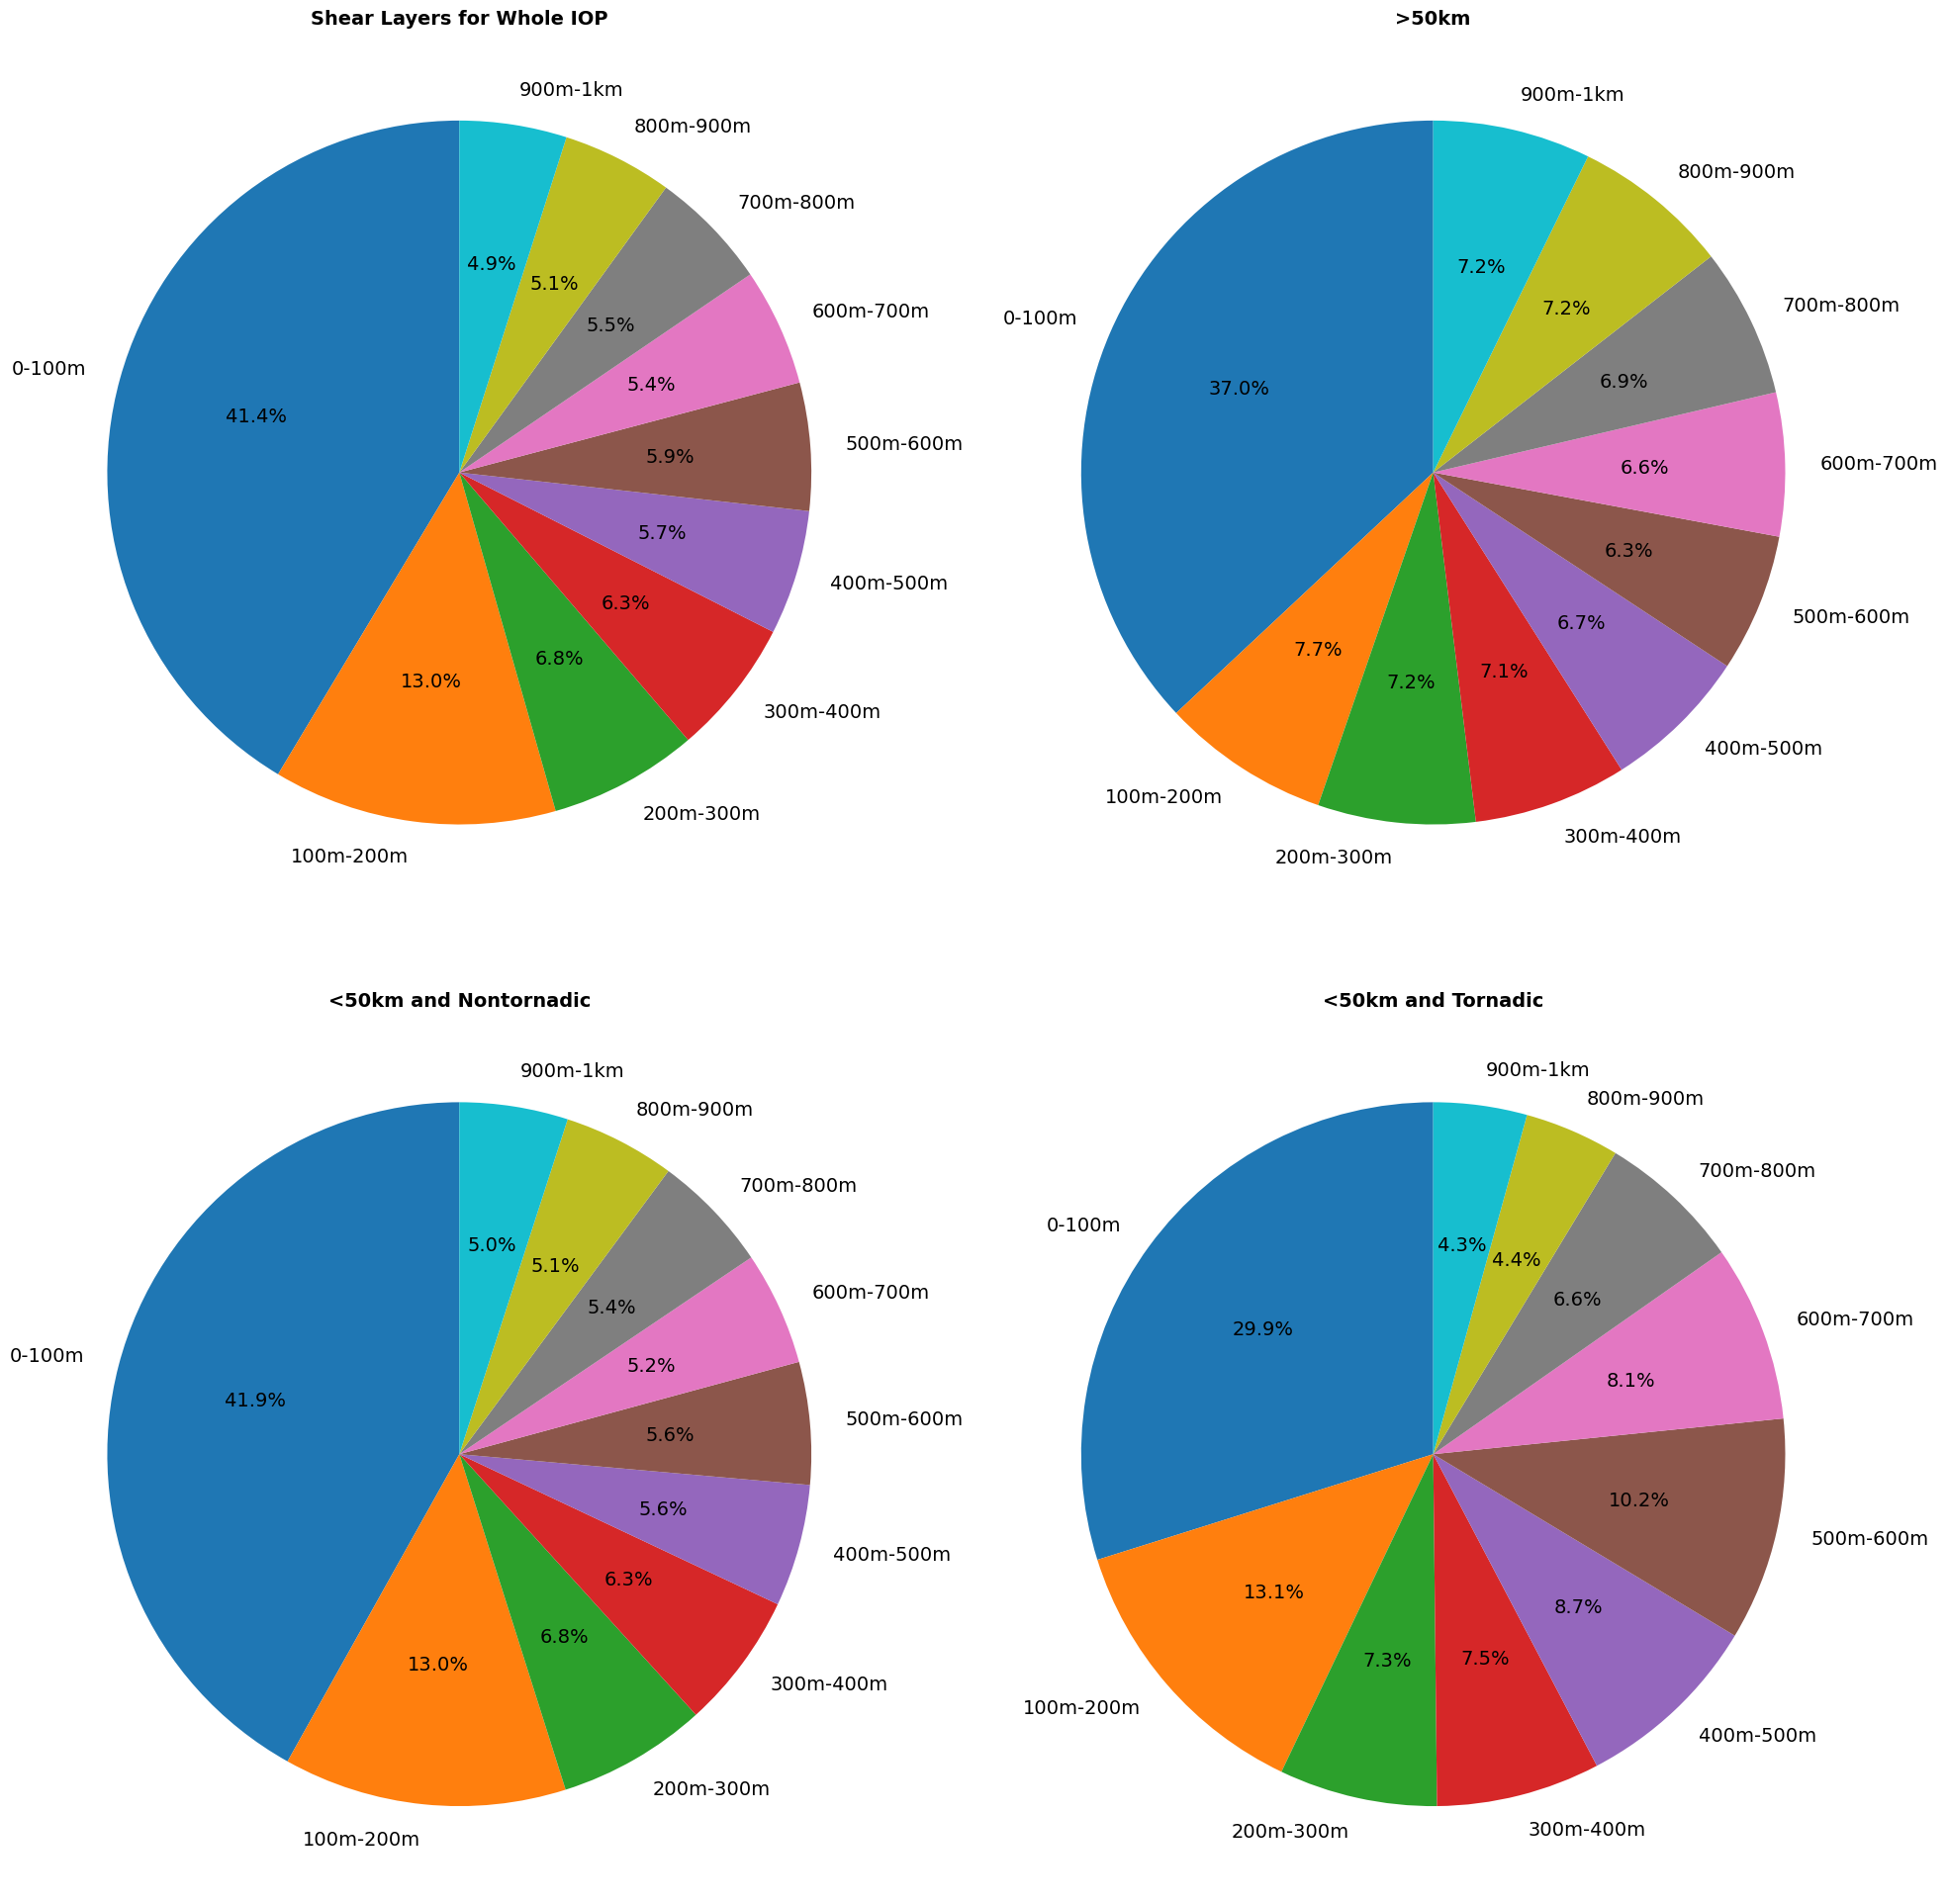

In [33]:
percent0_ka1 = 0
percent1_ka1 = 0
percent2_ka1 = 0
percent3_ka1 = 0
percent4_ka1 = 0
percent5_ka1 = 0
percent6_ka1 = 0
percent7_ka1 = 0
percent8_ka1 = 0
percent9_ka1 = 0
p0_ka1_T = 0
p1_ka1_T = 0
p2_ka1_T = 0
p3_ka1_T = 0
p4_ka1_T = 0
p5_ka1_T = 0
p6_ka1_T = 0
p7_ka1_T = 0
p8_ka1_T = 0
p9_ka1_T = 0
p0_ka1_NT = 0
p1_ka1_NT = 0
p2_ka1_NT = 0
p3_ka1_NT = 0
p4_ka1_NT = 0
p5_ka1_NT = 0
p6_ka1_NT = 0
p7_ka1_NT = 0
p8_ka1_NT = 0
p9_ka1_NT = 0
p0_ka1_50 = 0
p1_ka1_50 = 0
p2_ka1_50 = 0
p3_ka1_50 = 0
p4_ka1_50 = 0
p5_ka1_50 = 0
p6_ka1_50 = 0
p7_ka1_50 = 0
p8_ka1_50 = 0
p9_ka1_50 = 0
p50_countka1=0
p50T_countka1=0
p50NT_countka1=0
percent_countka1 = 0


for thefile in vad_fileska1[9:]:
    radar = pyart.io.read_cfradial(thefile)
    print(thefile,radar.fixed_angle['data'])
    
    
    ka1gps['ddmmyy']+ka1gps['hhmmss[UTC]']
    ka1gps['datetime'] = [datetime.strptime(d,'%d%m%y%H%M%S') for d in ka1gps['ddmmyy']+ka1gps['hhmmss[UTC]']]
    beginscanindex = ka1gps.loc[ka1gps['datetime'] == datetime.strptime(radar.time['units'],'seconds since %Y-%m-%dT%H:%M:%SZ')].index+np.amin(np.unique(radar.time['data']))
    endscanindex = ka1gps.loc[ka1gps['datetime'] == datetime.strptime(radar.time['units'],'seconds since %Y-%m-%dT%H:%M:%SZ')].index+np.amax(np.unique(radar.time['data']))
    dfscan = ka1gps.iloc[beginscanindex[0].astype(int):endscanindex[0].astype(int)]
    dfscan = dfscan.astype({'Bearing[degrees]': 'float'})

    #print('velocity [kts]',dfscan['Velocity[knots]'].astype(float).mean(),'+-',dfscan['Velocity[knots]'].astype(float).var())
    speed = dfscan['Velocity[knots]'].astype(float).mean()
    #print('bearing',dfscan['Bearing[degrees]'].astype(float).mean(),'+-',dfscan['Bearing[degrees]'].astype(float).var())
    
#    bearing = 84.6
    if int(ka1scan.loc[ka1scan['Datetime'] == dfscan.datetime.values[0]].Deployment.values[0]) != 0:
        bearing = float(ka1scan.loc[ka1scan['Datetime'] == dfscan.datetime.values[0]].Heading.values[0])
    else:
        bearing = dfscan['Bearing[degrees]'].mean()
        
    if bearing == 80.06703703703703:
        bearing = 190
    elif (bearing == 64.25037037037036):
        bearing = 9.980000000000002
    elif (bearing == 89.28925925925924):
        bearing = 92.6
    elif bearing == 269.9640740740741:
        bearing = 90.6
    elif bearing == 206.84615384615387:
        bearing = 149.0
    elif bearing == 263.8211111111111:
        bearing = 90.2
    
    print('Bearing used: '+str(bearing))
    
    #print('latitude',dfscan['Latitude'].astype(float).mean(),'+-',dfscan['Latitude'].astype(float).var())
    lat = dfscan['Latitude'].astype(float).mean()
    #print('longitude',dfscan['Longitude'].astype(float).mean(),'+-',dfscan['Longitude'].astype(float).var())
    lon = dfscan['Longitude'].astype(float).mean()
    
    display = pyart.graph.RadarMapDisplay(radar)
    
    radar.azimuth['data']+=(bearing)%360
#     if (bearing>=0)&(bearing<=90):
#         (radar.azimuth['data'])+=(bearing*(-1)+90)%360
#     else:
#         (radar.azimuth['data'])+=360-(bearing*(-1)+90)%360

    VAD = pyart.retrieve.vad_browning(radar, 'corrected_velocity', z_want=np.arange(50,5001,10),gatefilter=None)
    u1 = VAD.u_wind
    v1 = VAD.v_wind
   
    
    u_shear = [u1[5]-u1[0],u1[15]-u1[5],u1[25]-u1[15]
               ,u1[35]-u1[25],u1[45]-u1[35],u1[55]-u1[45]
               ,u1[65]-u1[55],u1[75]-u1[65],u1[85]-u1[75]
               ,u1[95]-u1[85]]

    v_shear = [v1[5]-v1[0],v1[15]-v1[5],v1[25]-v1[15]
               ,v1[35]-v1[25],v1[45]-v1[35],v1[55]-v1[45]
               ,v1[65]-v1[55],v1[75]-v1[65],v1[85]-v1[75]
               ,v1[95]-v1[85]]
    wspd_shear = wind_speed(u_shear*units('m/s'),v_shear*units('m/s'))
    z_shear = np.arange(0.1,1.1,0.1)
    
    fwd_azimuth,back_azimuth,distance = geodesic.inv(dfscan['Longitude'].values[0], dfscan['Latitude'].values[0], 
                                                     storm_location.iloc[(storm_location['datetime']
                                                                          -dfscan['datetime'].values[0]).abs().argsort()[:1]]['Lon'].values, 
                                                     storm_location.iloc[(storm_location['datetime']
                                                                          -dfscan['datetime'].values[0]).abs().argsort()[:1]]['Lat'].values)

    dist = distance/1000
    bear = back_azimuth
    c = dfscan['datetime'].values[0]
    #print(c,dist,np.logical_and(c>=tor_paths.start_tor,c<=tor_paths.end_tor).any())
    if bear == np.nan:
        continue
    
    if math.isnan(wspd_shear[0].magnitude) == True:
        wspd_shear[0]=0.00001*units('m/s')
    if math.isnan(wspd_shear[1].magnitude) == True:
        wspd_shear[1]=0.00001*units('m/s')
    if math.isnan(wspd_shear[2].magnitude) == True:
        wspd_shear[2]=0.00001*units('m/s')
    if math.isnan(wspd_shear[3].magnitude) == True:
        wspd_shear[3]=0.00001*units('m/s')
    if math.isnan(wspd_shear[4].magnitude) == True:
        wspd_shear[4]=0.00001*units('m/s')
    if math.isnan(wspd_shear[5].magnitude) == True:
        wspd_shear[5]=0.00001*units('m/s')
    if math.isnan(wspd_shear[6].magnitude) == True:
        wspd_shear[6]=0.00001*units('m/s')
    if math.isnan(wspd_shear[7].magnitude) == True:
        wspd_shear[7]=0.00001*units('m/s')
    if math.isnan(wspd_shear[8].magnitude) == True:
        wspd_shear[8]=0.00001*units('m/s')
    if math.isnan(wspd_shear[9].magnitude) == True:
        wspd_shear[9]=0.00001*units('m/s')
        
    
     
    if dist >= 50.0:
        total_shear = np.nansum(np.array(wspd_shear))*units('m/s')
        p50_countka1+=1 
        p0_ka1_50 += ((wspd_shear[0]/total_shear)*100)
        p1_ka1_50 += ((wspd_shear[1]/total_shear)*100)
        p2_ka1_50 += ((wspd_shear[2]/total_shear)*100)
        p3_ka1_50 += ((wspd_shear[3]/total_shear)*100)
        p4_ka1_50 += ((wspd_shear[4]/total_shear)*100)
        p5_ka1_50 += ((wspd_shear[5]/total_shear)*100)
        p6_ka1_50 += ((wspd_shear[6]/total_shear)*100)
        p7_ka1_50 += ((wspd_shear[7]/total_shear)*100)
        p8_ka1_50 += ((wspd_shear[8]/total_shear)*100)
        p9_ka1_50 += ((wspd_shear[9]/total_shear)*100)
    
    if np.logical_and((dist < 50.0),(np.logical_and(c>=tor_paths.start_tor,c<=tor_paths.end_tor).any()==True)):
        total_shear = np.nansum(np.array(wspd_shear))*units('m/s')
        p50T_countka1 +=1
        p0_ka1_T += ((wspd_shear[0]/total_shear)*100)
        p1_ka1_T += ((wspd_shear[1]/total_shear)*100)
        p2_ka1_T += ((wspd_shear[2]/total_shear)*100)
        p3_ka1_T += ((wspd_shear[3]/total_shear)*100)
        p4_ka1_T += ((wspd_shear[4]/total_shear)*100)
        p5_ka1_T += ((wspd_shear[5]/total_shear)*100)
        p6_ka1_T += ((wspd_shear[6]/total_shear)*100)
        p7_ka1_T += ((wspd_shear[7]/total_shear)*100)
        p8_ka1_T += ((wspd_shear[8]/total_shear)*100)
        p9_ka1_T += ((wspd_shear[9]/total_shear)*100)
                            
    if np.logical_and((dist < 50.0),(np.logical_and(c>=tor_paths.start_tor,c<=tor_paths.end_tor).any()==True))==False:
        total_shear = np.nansum(np.array(wspd_shear))*units('m/s')
        p50NT_countka1+=1
        print(c,total_shear)
        p0_ka1_NT += ((wspd_shear[0]/total_shear)*100)
        p1_ka1_NT += ((wspd_shear[1]/total_shear)*100)
        p2_ka1_NT += ((wspd_shear[2]/total_shear)*100)
        p3_ka1_NT += ((wspd_shear[3]/total_shear)*100)
        p4_ka1_NT += ((wspd_shear[4]/total_shear)*100)
        p5_ka1_NT += ((wspd_shear[5]/total_shear)*100)
        p6_ka1_NT += ((wspd_shear[6]/total_shear)*100)
        p7_ka1_NT += ((wspd_shear[7]/total_shear)*100)
        p8_ka1_NT += ((wspd_shear[8]/total_shear)*100)
        p9_ka1_NT += ((wspd_shear[9]/total_shear)*100)

    total_shear = np.nansum(np.array(wspd_shear))*units('m/s')
    percent_countka1+=1
    percent0_ka1+=((wspd_shear[0]/total_shear)*100)
    percent1_ka1+=((wspd_shear[1]/total_shear)*100)
    percent2_ka1+=((wspd_shear[2]/total_shear)*100)
    percent3_ka1+=((wspd_shear[3]/total_shear)*100)
    percent4_ka1+=((wspd_shear[4]/total_shear)*100)
    percent5_ka1+=((wspd_shear[5]/total_shear)*100)
    percent6_ka1+=((wspd_shear[6]/total_shear)*100)
    percent7_ka1+=((wspd_shear[7]/total_shear)*100)
    percent8_ka1+=((wspd_shear[8]/total_shear)*100)
    percent9_ka1+=((wspd_shear[9]/total_shear)*100)
        
percent0_ka2 = 0
percent1_ka2 = 0
percent2_ka2 = 0
percent3_ka2 = 0
percent4_ka2 = 0
percent5_ka2 = 0
percent6_ka2 = 0
percent7_ka2 = 0
percent8_ka2 = 0
percent9_ka2 = 0
p0_ka2_T = 0
p1_ka2_T = 0
p2_ka2_T = 0
p3_ka2_T = 0
p4_ka2_T = 0
p5_ka2_T = 0
p6_ka2_T = 0
p7_ka2_T = 0
p8_ka2_T = 0
p9_ka2_T = 0
p0_ka2_NT = 0
p1_ka2_NT = 0
p2_ka2_NT = 0
p3_ka2_NT = 0
p4_ka2_NT = 0
p5_ka2_NT = 0
p6_ka2_NT = 0
p7_ka2_NT = 0
p8_ka2_NT = 0
p9_ka2_NT = 0
p0_ka2_50 = 0
p1_ka2_50 = 0
p2_ka2_50 = 0
p3_ka2_50 = 0
p4_ka2_50 = 0
p5_ka2_50 = 0
p6_ka2_50 = 0
p7_ka2_50 = 0
p8_ka2_50 = 0
p9_ka2_50 = 0
p50_countka2=0
p50T_countka2=0
p50NT_countka2=0
percent_countka2 = 0
        
for thefile in vad_fileska2[28:]:
    radar = pyart.io.read_cfradial(thefile)
    print(thefile,radar.fixed_angle['data'])
    
    
    ka2gps['ddmmyy']+ka2gps['hhmmss[UTC]']
    ka2gps['datetime'] = [datetime.strptime(d,'%d%m%y%H%M%S') for d in ka2gps['ddmmyy']+ka2gps['hhmmss[UTC]']]
    beginscanindex = ka2gps.loc[ka2gps['datetime'] == datetime.strptime(radar.time['units'],'seconds since %Y-%m-%dT%H:%M:%SZ')].index+np.amin(np.unique(radar.time['data']))
    endscanindex = ka2gps.loc[ka2gps['datetime'] == datetime.strptime(radar.time['units'],'seconds since %Y-%m-%dT%H:%M:%SZ')].index+np.amax(np.unique(radar.time['data']))
    dfscan = ka2gps.iloc[beginscanindex[0].astype(int):endscanindex[0].astype(int)]
    dfscan = dfscan.astype({'Bearing[degrees]': 'float'})

    #print('velocity [kts]',dfscan['Velocity[knots]'].astype(float).mean(),'+-',dfscan['Velocity[knots]'].astype(float).var())
    speed = dfscan['Velocity[knots]'].astype(float).mean()
    #print('bearing',dfscan['Bearing[degrees]'].astype(float).mean(),'+-',dfscan['Bearing[degrees]'].astype(float).var())
    
#    bearing = 84.6
    if int(ka2scan.loc[ka2scan['Datetime'] == dfscan.datetime.values[0]].Deployment.values[0]) != 0:
        bearing = float(ka2scan.loc[ka2scan['Datetime'] == dfscan.datetime.values[0]].Heading.values[0])
    else:
        bearing = dfscan['Bearing[degrees]'].mean()
        
    if bearing == 80.06703703703703:
        bearing = 190
    elif (bearing == 64.25037037037036):
        bearing = 9.980000000000002
    elif (bearing == 89.28925925925924):
        bearing = 92.6
    elif bearing == 269.9640740740741:
        bearing = 90.6
    elif bearing == 206.84615384615387:
        bearing = 149.0
    elif bearing == 263.8211111111111:
        bearing = 90.2
 
    print('Bearing used: '+str(bearing))
    
    #print('latitude',dfscan['Latitude'].astype(float).mean(),'+-',dfscan['Latitude'].astype(float).var())
    lat = dfscan['Latitude'].astype(float).mean()
    #print('longitude',dfscan['Longitude'].astype(float).mean(),'+-',dfscan['Longitude'].astype(float).var())
    lon = dfscan['Longitude'].astype(float).mean()
    
    display = pyart.graph.RadarMapDisplay(radar)
    
    radar.azimuth['data']+=(bearing)%360
    
#     if (bearing>=0)&(bearing<=90):
#         (radar.azimuth['data'])+=(bearing*(-1)+90)%360
#     else:
#         (radar.azimuth['data'])+=360-(bearing*(-1)+90)%360

    VAD = pyart.retrieve.vad_browning(radar, 'corrected_velocity', z_want=np.arange(50,5001,10),gatefilter=None)
    u1 = VAD.u_wind
    v1 = VAD.v_wind
    
    u_shear = [u1[5]-u1[0],u1[15]-u1[5],u1[25]-u1[15]
               ,u1[35]-u1[25],u1[45]-u1[35],u1[55]-u1[45]
               ,u1[65]-u1[55],u1[75]-u1[65],u1[85]-u1[75]
               ,u1[95]-u1[85]]

    v_shear = [v1[5]-v1[0],v1[15]-v1[5],v1[25]-v1[15]
               ,v1[35]-v1[25],v1[45]-v1[35],v1[55]-v1[45]
               ,v1[65]-v1[55],v1[75]-v1[65],v1[85]-v1[75]
               ,v1[95]-v1[85]]
    wspd_shear = wind_speed(u_shear*units('m/s'),v_shear*units('m/s'))
    z_shear = np.arange(0.1,1.1,0.1)
    
    fwd_azimuth,back_azimuth,distance = geodesic.inv(dfscan['Longitude'].values[0], dfscan['Latitude'].values[0], 
                                                     storm_location.iloc[(storm_location['datetime']
                                                                          -dfscan['datetime'].values[0]).abs().argsort()[:1]]['Lon'].values, 
                                                     storm_location.iloc[(storm_location['datetime']
                                                                          -dfscan['datetime'].values[0]).abs().argsort()[:1]]['Lat'].values)

    dist = distance/1000
    bear = back_azimuth
    c = dfscan['datetime'].values[0]
    print(wspd_shear)
    if bear == np.nan:
        continue

    if math.isnan(wspd_shear[0].magnitude) == True:
        wspd_shear[0]=0.00001*units('m/s')
    if math.isnan(wspd_shear[1].magnitude) == True:
        wspd_shear[1]=0.00001*units('m/s')
    if math.isnan(wspd_shear[2].magnitude) == True:
        wspd_shear[2]=0.00001*units('m/s')
    if math.isnan(wspd_shear[3].magnitude) == True:
        wspd_shear[3]=0.00001*units('m/s')
    if math.isnan(wspd_shear[4].magnitude) == True:
        wspd_shear[4]=0.00001*units('m/s')
    if math.isnan(wspd_shear[5].magnitude) == True:
        wspd_shear[5]=0.00001*units('m/s')
    if math.isnan(wspd_shear[6].magnitude) == True:
        wspd_shear[6]=0.00001*units('m/s')
    if math.isnan(wspd_shear[7].magnitude) == True:
        wspd_shear[7]=0.00001*units('m/s')
    if math.isnan(wspd_shear[8].magnitude) == True:
        wspd_shear[8]=0.00001*units('m/s')
    if math.isnan(wspd_shear[9].magnitude) == True:
        wspd_shear[9]=0.00001*units('m/s')
        

     
    if dist >= 50.0:
        total_shear = np.nansum(np.array(wspd_shear))*units('m/s')
        p50_countka2+=1 
        p0_ka2_50 += ((wspd_shear[0]/total_shear)*100)
        p1_ka2_50 += ((wspd_shear[1]/total_shear)*100)
        p2_ka2_50 += ((wspd_shear[2]/total_shear)*100)
        p3_ka2_50 += ((wspd_shear[3]/total_shear)*100)
        p4_ka2_50 += ((wspd_shear[4]/total_shear)*100)
        p5_ka2_50 += ((wspd_shear[5]/total_shear)*100)
        p6_ka2_50 += ((wspd_shear[6]/total_shear)*100)
        p7_ka2_50 += ((wspd_shear[7]/total_shear)*100)
        p8_ka2_50 += ((wspd_shear[8]/total_shear)*100)
        p9_ka2_50 += ((wspd_shear[9]/total_shear)*100)
    
    if np.logical_and((dist < 50.0),(np.logical_and(c>=tor_paths.start_tor,c<=tor_paths.end_tor).any()==True)):
        total_shear = np.nansum(np.array(wspd_shear))*units('m/s')
        p50T_countka2 +=1
        p0_ka2_T += ((wspd_shear[0]/total_shear)*100)
        p1_ka2_T += ((wspd_shear[1]/total_shear)*100)
        p2_ka2_T += ((wspd_shear[2]/total_shear)*100)
        p3_ka2_T += ((wspd_shear[3]/total_shear)*100)
        p4_ka2_T += ((wspd_shear[4]/total_shear)*100)
        p5_ka2_T += ((wspd_shear[5]/total_shear)*100)
        p6_ka2_T += ((wspd_shear[6]/total_shear)*100)
        p7_ka2_T += ((wspd_shear[7]/total_shear)*100)
        p8_ka2_T += ((wspd_shear[8]/total_shear)*100)
        p9_ka2_T += ((wspd_shear[9]/total_shear)*100)
                            
    if np.logical_and((dist < 50.0),(np.logical_and(c>=tor_paths.start_tor,c<=tor_paths.end_tor).any()==True))==False:
        total_shear = np.nansum(np.array(wspd_shear))*units('m/s')
        p50NT_countka2+=1
        p0_ka2_NT += ((wspd_shear[0]/total_shear)*100)
        p1_ka2_NT += ((wspd_shear[1]/total_shear)*100)
        p2_ka2_NT += ((wspd_shear[2]/total_shear)*100)
        p3_ka2_NT += ((wspd_shear[3]/total_shear)*100)
        p4_ka2_NT += ((wspd_shear[4]/total_shear)*100)
        p5_ka2_NT += ((wspd_shear[5]/total_shear)*100)
        p6_ka2_NT += ((wspd_shear[6]/total_shear)*100)
        p7_ka2_NT += ((wspd_shear[7]/total_shear)*100)
        p8_ka2_NT += ((wspd_shear[8]/total_shear)*100)
        p9_ka2_NT += ((wspd_shear[9]/total_shear)*100)

    total_shear = np.nansum(np.array(wspd_shear))*units('m/s')
    percent_countka2+=1
    percent0_ka2+=((wspd_shear[0]/total_shear)*100)
    percent1_ka2+=((wspd_shear[1]/total_shear)*100)
    percent2_ka2+=((wspd_shear[2]/total_shear)*100)
    percent3_ka2+=((wspd_shear[3]/total_shear)*100)
    percent4_ka2+=((wspd_shear[4]/total_shear)*100)
    percent5_ka2+=((wspd_shear[5]/total_shear)*100)
    percent6_ka2+=((wspd_shear[6]/total_shear)*100)
    percent7_ka2+=((wspd_shear[7]/total_shear)*100)
    percent8_ka2+=((wspd_shear[8]/total_shear)*100)
    percent9_ka2+=((wspd_shear[9]/total_shear)*100)


percent0_lidar = 0
percent1_lidar = 0
percent2_lidar = 0
percent3_lidar = 0
percent4_lidar = 0
percent5_lidar = 0
percent6_lidar = 0
percent7_lidar = 0
percent8_lidar = 0
percent9_lidar = 0
p0_lidar_T = 0
p1_lidar_T = 0
p2_lidar_T = 0
p3_lidar_T = 0
p4_lidar_T = 0
p5_lidar_T = 0
p6_lidar_T = 0
p7_lidar_T = 0
p8_lidar_T = 0
p9_lidar_T = 0
p0_lidar_NT = 0
p1_lidar_NT = 0
p2_lidar_NT = 0
p3_lidar_NT = 0
p4_lidar_NT = 0
p5_lidar_NT = 0
p6_lidar_NT = 0
p7_lidar_NT = 0
p8_lidar_NT = 0
p9_lidar_NT = 0
p0_lidar_50 = 0
p1_lidar_50 = 0
p2_lidar_50 = 0
p3_lidar_50 = 0
p4_lidar_50 = 0
p5_lidar_50 = 0
p6_lidar_50 = 0
p7_lidar_50 = 0
p8_lidar_50 = 0
p9_lidar_50 = 0
p50_count=0
p50T_count=0
p50NT_count=0
percent_count = 0


for i in np.arange(0,len(testing.time)-2):
#     if i == 178:
#         continue
#     else:
    test = testing.isel(time=slice(i, i+1))
    #print(test.time.values)
#     test1 = test.where(test.wspd < 40, drop=True)
#     test2 = test1.where(test1.r_sq > 0.95, drop=True)
#     test3 = test2.where(test2.height < 3, drop=True)
#     test4 = test3.where(test3.intensity < 1.01, drop=True)

    u_mob,v_mob = (wind_components(lidar_storm.iloc[(lidar_storm['datetime']-test.time.values[0]).abs().argsort()[:1]]['Spd'].values 
                                * units('knots').to((units.m)/(units.s)), 
                               lidar_storm.iloc[(lidar_storm['datetime']-test.time.values[0]).abs().argsort()[:1]]['Dir'].values 
                                * units.deg))
    u = test['u'][0].values[2:]
    v = test['v'][0].values[2:]
    z = test['height'].values[2:]

    u = np.insert(u, 0, u_mob.magnitude, axis=0)
    v = np.insert(v, 0, v_mob.magnitude, axis=0)
    z = np.insert(z, 0, 0., axis=0)

    # define data with variable attributes
    data_vars = {'u':(['height'], u, 
                             {'units': 'm/s', 
                              'long_name':'ucomponent'}),
                 'v':(['height'], v, 
                             {'units': 'm/s', 
                              'long_name':'vcomponent'})}

    # define coordinates
    coords = {'height': (['height'], z)}

    # create dataset
    testnew = xr.Dataset(data_vars=data_vars, coords=coords)

    u1 = testnew['u'].interp(height=np.arange(0,3.010,0.010))
    v1 = testnew['v'].interp(height=np.arange(0,3.010,0.010))
    z1 = np.arange(0,3.010,0.010)
    u_shear = [u1[10].values-u1[0].values,u1[20].values-u1[10].values,u1[30].values-u1[20].values
               ,u1[40].values-u1[30].values,u1[50].values-u1[40].values,u1[60].values-u1[50].values
               ,u1[70].values-u1[60].values,u1[80].values-u1[70].values,u1[90].values-u1[80].values
               ,u1[100].values-u1[90].values]

    v_shear = [v1[10].values-v1[0].values,v1[20].values-v1[10].values,v1[30].values-v1[20].values
               ,v1[40].values-v1[30].values,v1[50].values-v1[40].values,v1[60].values-v1[50].values
               ,v1[70].values-v1[60].values,v1[80].values-v1[70].values,v1[90].values-v1[80].values
               ,v1[100].values-v1[90].values]
    
    
    wspd_shear = wind_speed(u_shear*units('m/s'),v_shear*units('m/s'))
    z_shear = np.arange(0.1,1.1,0.1)
    
    fwd_azimuth,back_azimuth,distance = geodesic.inv(test.lon.values, test.lat.values, 
                                                         storm_location.iloc[(storm_location['datetime']
                                                                              -test.time.values[0]).abs().argsort()[:1]]['Lon'].values, 
                                                         storm_location.iloc[(storm_location['datetime']
                                                                              -test.time.values[0]).abs().argsort()[:1]]['Lat'].values)

    dist = distance/1000
    bear = back_azimuth
    c = test.time.values[0]

    if bear == np.nan:
        continue
    
    if math.isnan(wspd_shear[0].magnitude) == True:
        wspd_shear[0]=0.00001*units('m/s')
    if math.isnan(wspd_shear[1].magnitude) == True:
        wspd_shear[1]=0.00001*units('m/s')
    if math.isnan(wspd_shear[2].magnitude) == True:
        wspd_shear[2]=0.00001*units('m/s')
    if math.isnan(wspd_shear[3].magnitude) == True:
        wspd_shear[3]=0.00001*units('m/s')
    if math.isnan(wspd_shear[4].magnitude) == True:
        wspd_shear[4]=0.00001*units('m/s')
    if math.isnan(wspd_shear[5].magnitude) == True:
        wspd_shear[5]=0.00001*units('m/s')
    if math.isnan(wspd_shear[6].magnitude) == True:
        wspd_shear[6]=0.00001*units('m/s')
    if math.isnan(wspd_shear[7].magnitude) == True:
        wspd_shear[7]=0.00001*units('m/s')
    if math.isnan(wspd_shear[8].magnitude) == True:
        wspd_shear[8]=0.00001*units('m/s')
    if math.isnan(wspd_shear[9].magnitude) == True:
        wspd_shear[9]=0.00001*units('m/s')
        

     
    if dist >= 50.0:
        total_shear = np.nansum(np.array(wspd_shear))*units('m/s')
        p50_count+=1 
        p0_lidar_50 += ((wspd_shear[0]/total_shear)*100)
        p1_lidar_50 += ((wspd_shear[1]/total_shear)*100)
        p2_lidar_50 += ((wspd_shear[2]/total_shear)*100)
        p3_lidar_50 += ((wspd_shear[3]/total_shear)*100)
        p4_lidar_50 += ((wspd_shear[4]/total_shear)*100)
        p5_lidar_50 += ((wspd_shear[5]/total_shear)*100)
        p6_lidar_50 += ((wspd_shear[6]/total_shear)*100)
        p7_lidar_50 += ((wspd_shear[7]/total_shear)*100)
        p8_lidar_50 += ((wspd_shear[8]/total_shear)*100)
        p9_lidar_50 += ((wspd_shear[9]/total_shear)*100)
        
    
    if np.logical_and((dist < 50.0),(np.logical_and(c>=tor_paths.start_tor,c<=tor_paths.end_tor).any()==True)):
        total_shear = np.nansum(np.array(wspd_shear))*units('m/s')
        p50T_count +=1
        p0_lidar_T += ((wspd_shear[0]/total_shear)*100)
        p1_lidar_T += ((wspd_shear[1]/total_shear)*100)
        p2_lidar_T += ((wspd_shear[2]/total_shear)*100)
        p3_lidar_T += ((wspd_shear[3]/total_shear)*100)
        p4_lidar_T += ((wspd_shear[4]/total_shear)*100)
        p5_lidar_T += ((wspd_shear[5]/total_shear)*100)
        p6_lidar_T += ((wspd_shear[6]/total_shear)*100)
        p7_lidar_T += ((wspd_shear[7]/total_shear)*100)
        p8_lidar_T += ((wspd_shear[8]/total_shear)*100)
        p9_lidar_T += ((wspd_shear[9]/total_shear)*100)
                            
    if np.logical_and((dist < 50.0),(np.logical_and(c>=tor_paths.start_tor,c<=tor_paths.end_tor).any()==True))==False:
        total_shear = np.nansum(np.array(wspd_shear))*units('m/s')
        p50NT_count+=1
        p0_lidar_NT += ((wspd_shear[0]/total_shear)*100)
        p1_lidar_NT += ((wspd_shear[1]/total_shear)*100)
        p2_lidar_NT += ((wspd_shear[2]/total_shear)*100)
        p3_lidar_NT += ((wspd_shear[3]/total_shear)*100)
        p4_lidar_NT += ((wspd_shear[4]/total_shear)*100)
        p5_lidar_NT += ((wspd_shear[5]/total_shear)*100)
        p6_lidar_NT += ((wspd_shear[6]/total_shear)*100)
        p7_lidar_NT += ((wspd_shear[7]/total_shear)*100)
        p8_lidar_NT += ((wspd_shear[8]/total_shear)*100)
        p9_lidar_NT += ((wspd_shear[9]/total_shear)*100)

    total_shear = np.nansum(np.array(wspd_shear))*units('m/s')
    percent_count+=1
    percent0_lidar+=((wspd_shear[0]/total_shear)*100)
    percent1_lidar+=((wspd_shear[1]/total_shear)*100)
    percent2_lidar+=((wspd_shear[2]/total_shear)*100)
    percent3_lidar+=((wspd_shear[3]/total_shear)*100)
    percent4_lidar+=((wspd_shear[4]/total_shear)*100)
    percent5_lidar+=((wspd_shear[5]/total_shear)*100)
    percent6_lidar+=((wspd_shear[6]/total_shear)*100)
    percent7_lidar+=((wspd_shear[7]/total_shear)*100)
    percent8_lidar+=((wspd_shear[8]/total_shear)*100)
    percent9_lidar+=((wspd_shear[9]/total_shear)*100)

percent0=((percent0_lidar/(percent_count))+(percent0_ka1/(percent_countka1))+(percent0_ka2/(percent_countka2)))/3
percent1=((percent1_lidar/(percent_count))+(percent1_ka1/(percent_countka1))+(percent1_ka2/(percent_countka2)))/3
percent2=((percent2_lidar/(percent_count))+(percent2_ka1/(percent_countka1))+(percent2_ka2/(percent_countka2)))/3
percent3=((percent3_lidar/(percent_count))+(percent3_ka1/(percent_countka1))+(percent3_ka2/(percent_countka2)))/3
percent4=((percent4_lidar/(percent_count))+(percent4_ka1/(percent_countka1))+(percent4_ka2/(percent_countka2)))/3
percent5=((percent5_lidar/(percent_count))+(percent5_ka1/(percent_countka1))+(percent5_ka2/(percent_countka2)))/3
percent6=((percent6_lidar/(percent_count))+(percent6_ka1/(percent_countka1))+(percent6_ka2/(percent_countka2)))/3
percent7=((percent7_lidar/(percent_count))+(percent7_ka1/(percent_countka1))+(percent7_ka2/(percent_countka2)))/3
percent8=((percent8_lidar/(percent_count))+(percent8_ka1/(percent_countka1))+(percent8_ka2/(percent_countka2)))/3
percent9=((percent9_lidar/(percent_count))+(percent9_ka1/(percent_countka1))+(percent9_ka2/(percent_countka2)))/3


#### Ka's were not doing vads >50km this day
p0_50=((p0_lidar_50/(p50_count)))
p1_50=((p1_lidar_50/(p50_count)))
p2_50=((p2_lidar_50/(p50_count)))
p3_50=((p3_lidar_50/(p50_count)))
p4_50=((p4_lidar_50/(p50_count)))
p5_50=((p5_lidar_50/(p50_count)))
p6_50=((p6_lidar_50/(p50_count)))
p7_50=((p7_lidar_50/(p50_count)))
p8_50=((p8_lidar_50/(p50_count)))
p9_50=((p9_lidar_50/(p50_count)))

p0_NT=((p0_lidar_NT/(p50NT_count))+(p0_ka1_NT/(p50NT_countka1))+(p0_ka2_NT/(p50NT_countka2)))/3
p1_NT=((p1_lidar_NT/(p50NT_count))+(p1_ka1_NT/(p50NT_countka1))+(p1_ka2_NT/(p50NT_countka2)))/3
p2_NT=((p2_lidar_NT/(p50NT_count))+(p2_ka1_NT/(p50NT_countka1))+(p2_ka2_NT/(p50NT_countka2)))/3
p3_NT=((p3_lidar_NT/(p50NT_count))+(p3_ka1_NT/(p50NT_countka1))+(p3_ka2_NT/(p50NT_countka2)))/3
p4_NT=((p4_lidar_NT/(p50NT_count))+(p4_ka1_NT/(p50NT_countka1))+(p4_ka2_NT/(p50NT_countka2)))/3
p5_NT=((p5_lidar_NT/(p50NT_count))+(p5_ka1_NT/(p50NT_countka1))+(p5_ka2_NT/(p50NT_countka2)))/3
p6_NT=((p6_lidar_NT/(p50NT_count))+(p6_ka1_NT/(p50NT_countka1))+(p6_ka2_NT/(p50NT_countka2)))/3
p7_NT=((p7_lidar_NT/(p50NT_count))+(p7_ka1_NT/(p50NT_countka1))+(p7_ka2_NT/(p50NT_countka2)))/3
p8_NT=((p8_lidar_NT/(p50NT_count))+(p8_ka1_NT/(p50NT_countka1))+(p8_ka2_NT/(p50NT_countka2)))/3
p9_NT=((p9_lidar_NT/(p50NT_count))+(p9_ka1_NT/(p50NT_countka1))+(p9_ka2_NT/(p50NT_countka2)))/3

p0_T=((p0_lidar_T/(p50T_count))+(p0_ka1_T/(p50T_countka1))+(p0_ka2_T/(p50T_countka2)))/3
p1_T=((p1_lidar_T/(p50T_count))+(p1_ka1_T/(p50T_countka1))+(p1_ka2_T/(p50T_countka2)))/3
p2_T=((p2_lidar_T/(p50T_count))+(p2_ka1_T/(p50T_countka1))+(p2_ka2_T/(p50T_countka2)))/3
p3_T=((p3_lidar_T/(p50T_count))+(p3_ka1_T/(p50T_countka1))+(p3_ka2_T/(p50T_countka2)))/3
p4_T=((p4_lidar_T/(p50T_count))+(p4_ka1_T/(p50T_countka1))+(p4_ka2_T/(p50T_countka2)))/3
p5_T=((p5_lidar_T/(p50T_count))+(p5_ka1_T/(p50T_countka1))+(p5_ka2_T/(p50T_countka2)))/3
p6_T=((p6_lidar_T/(p50T_count))+(p6_ka1_T/(p50T_countka1))+(p6_ka2_T/(p50T_countka2)))/3
p7_T=((p7_lidar_T/(p50T_count))+(p7_ka1_T/(p50T_countka1))+(p7_ka2_T/(p50T_countka2)))/3
p8_T=((p8_lidar_T/(p50T_count))+(p8_ka1_T/(p50T_countka1))+(p8_ka2_T/(p50T_countka2)))/3
p9_T=((p9_lidar_T/(p50T_count))+(p9_ka1_T/(p50T_countka1))+(p9_ka2_T/(p50T_countka2)))/3


fig, axs = plt.subplots(figsize=[20,20],ncols=2,nrows=2)
percents = np.array([percent0,percent1,percent2,percent3,percent4,percent5,percent6,percent7,percent8,percent9])
fifty = np.array([p0_50,p1_50,p2_50,p3_50,p4_50,p5_50,p6_50,p7_50,p8_50,p9_50])
tornadic = np.array([p0_T,p1_T,p2_T,p3_T,p4_T,p5_T,p6_T,p7_T,p8_T,p9_T])
nontornadic = np.array([p0_NT,p1_NT,p2_NT,p3_NT,p4_NT,p5_NT,p6_NT,p7_NT,p8_NT,p9_NT])
labels_per = ['0-100m','100m-200m','200m-300m','300m-400m','400m-500m','500m-600m','600m-700m','700m-800m','800m-900m','900m-1km']
axs[0,0].pie(percents, labels = labels_per, autopct='%1.1f%%',startangle = 90,textprops={'fontsize': 14})
axs[0,0].set_title('Shear Layers for Whole IOP', fontsize=14, fontweight='bold')
axs[0,1].pie(fifty, labels = labels_per, autopct='%1.1f%%',startangle = 90,textprops={'fontsize': 14})
axs[0,1].set_title('>50km', fontsize=14, fontweight='bold')
axs[1,0].pie(nontornadic, labels = labels_per, autopct='%1.1f%%',startangle = 90,textprops={'fontsize': 14})
axs[1,0].set_title('<50km and Nontornadic', fontsize=14, fontweight='bold')
axs[1,1].pie(tornadic, labels = labels_per, autopct='%1.1f%%',startangle = 90,textprops={'fontsize': 14})
axs[1,1].set_title('<50km and Tornadic', fontsize=14, fontweight='bold')

fig.tight_layout()
plt.savefig('E:/Lapenta/20220523/Figs/IOP3_kalidar_shearpie.png',bbox_inches='tight',format='png',dpi=300)
plt.show()

E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222551.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222620.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222649.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222718.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222747.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222816.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222845.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6010.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222914.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523222943.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223013.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223042.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223111.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223140.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223209.nc [37.001953 45.      ]
Bearing used: 179.22999999999993


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223238.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6036.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223307.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223336.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223405.nc [37.001953 45.      ]
Bearing used: 179.22999999999996


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523223434.nc [37.001953 45.      ]
Bearing used: 190


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 5992.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523224032.nc [37.001953 45.      ]
Bearing used: 9.980000000000002


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523224101.nc [37.001953 45.      ]
Bearing used: 9.980000000000002


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6001.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523224130.nc [37.001953 45.      ]
Bearing used: 92.6


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523232822.nc [37.001953 45.      ]
Bearing used: 177.76296296296297


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523232852.nc [37.001953 45.      ]
Bearing used: 180.39961538461537


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6009.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523232921.nc [37.001953 45.      ]
Bearing used: 180.77923076923076


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6008.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523232950.nc [37.001953 45.      ]
Bearing used: 149.0


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220523233019.nc [37.001953 45.      ]
Bearing used: 90.6


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6008.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka1\Ka1220524000309.nc [37.001953 45.      ]
Bearing used: 90.2


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 5999.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222547.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222617.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222647.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222718.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222748.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222818.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222848.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222919.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523222949.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223019.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223050.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223120.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6012.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223150.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223220.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6008.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223250.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223321.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223351.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223421.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223452.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223522.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223552.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223622.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223652.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223722.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223753.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223823.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223852.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223922.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523223953.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224023.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224053.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6008.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224123.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6001.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224153.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224223.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224253.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224324.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224354.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224425.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224455.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224524.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224554.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224624.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224655.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224726.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224756.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224826.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224856.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224927.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523224957.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6004.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523225027.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6012.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523225057.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523225128.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6008.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523225158.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523225228.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523225258.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523225328.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220523225358.nc [37.001953 45.      ]
Bearing used: 0.3499999999999999


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220524001616.nc [37.001953 45.      ]
Bearing used: 11.115384615384615


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220524001646.nc [37.001953 45.      ]
Bearing used: 86.4


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6010.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220524005159.nc [37.001953 45.      ]
Bearing used: 183.2255555555556


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220524005332.nc [37.001953 45.      ]
Bearing used: 91.9


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6002.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220524012032.nc [37.001953 45.      ]
Bearing used: 121.4


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220524015527.nc [37.001953 45.      ]
Bearing used: 90.5174074074074


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220524015557.nc [37.001953 45.      ]
Bearing used: 90.55703703703703


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters
E:\Lapenta\20220523\KaRadars\product_raw_ka2\Ka2220524015759.nc [37.001953 45.      ]
Bearing used: 90.91740740740742


C:\Users\joshu\.conda\envs\ox\Lib\site-packages\pyart\retrieve\vad.py:336: RuntimeWarning: Mean of empty slice
  mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)


max height 6005.0  meters
min height 0.0  meters


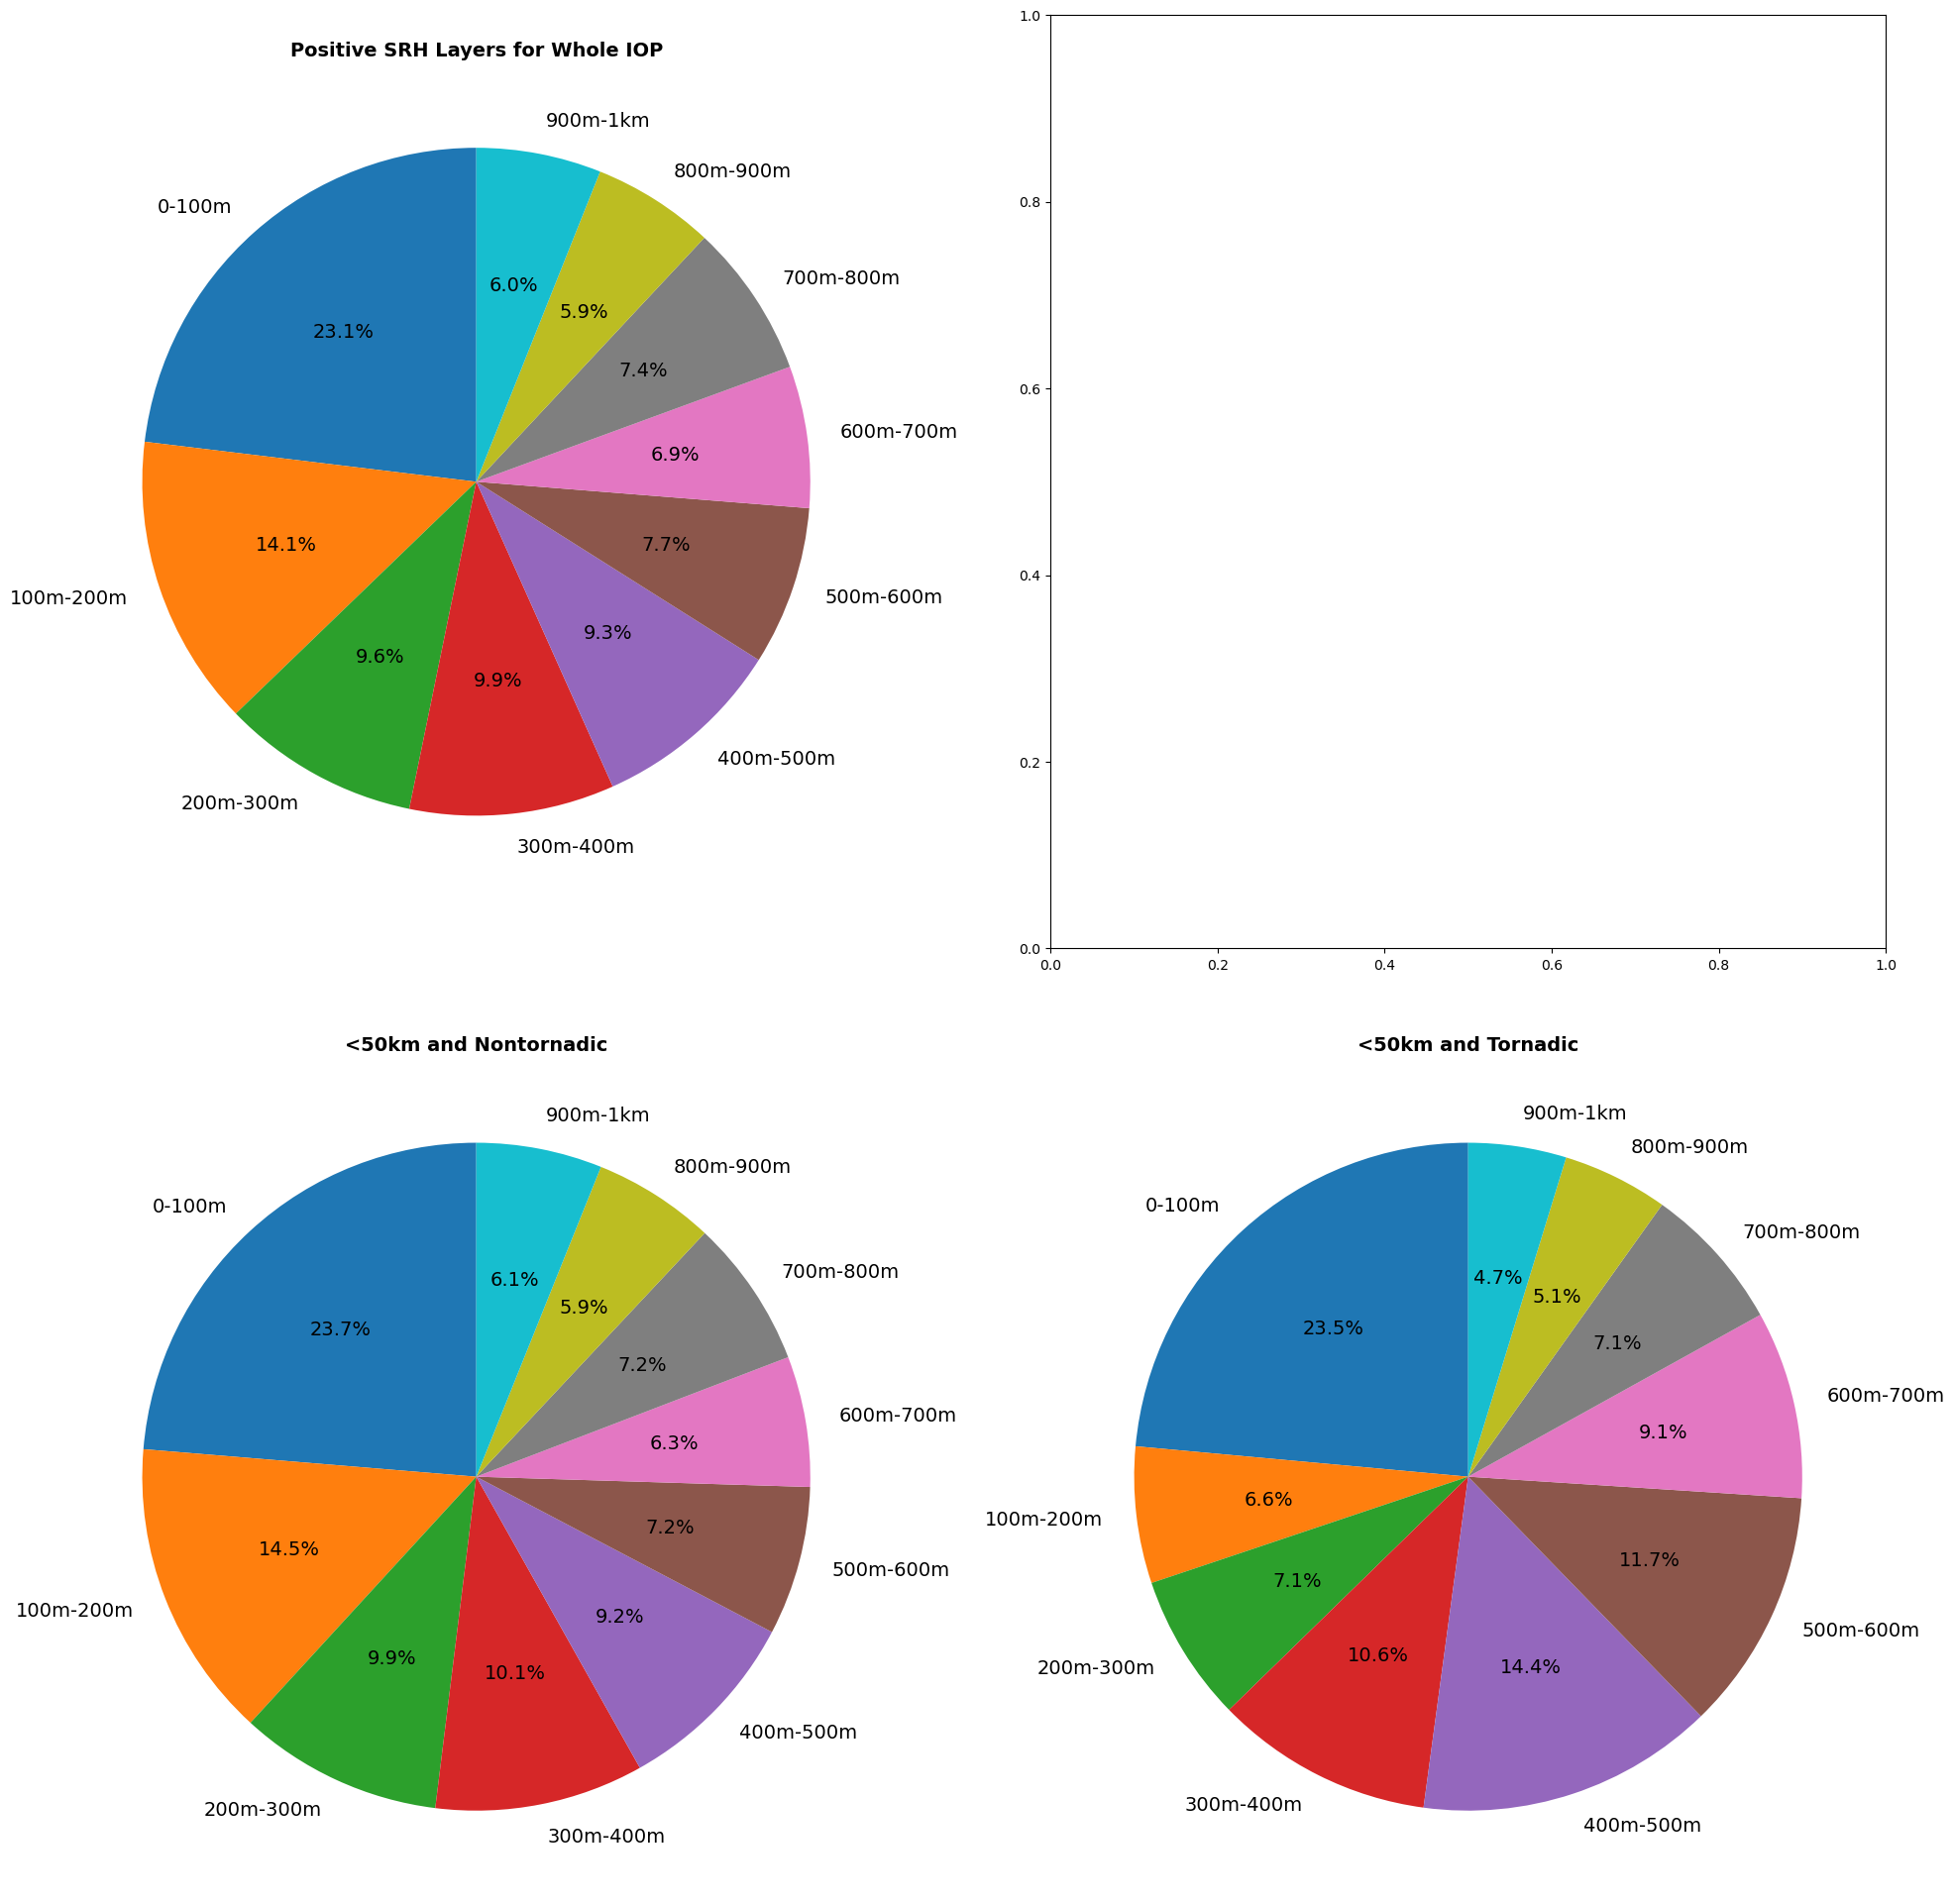

In [28]:
percent0_ka1 = 0
percent1_ka1 = 0
percent2_ka1 = 0
percent3_ka1 = 0
percent4_ka1 = 0
percent5_ka1 = 0
percent6_ka1 = 0
percent7_ka1 = 0
percent8_ka1 = 0
percent9_ka1 = 0
p0_ka1_T = 0
p1_ka1_T = 0
p2_ka1_T = 0
p3_ka1_T = 0
p4_ka1_T = 0
p5_ka1_T = 0
p6_ka1_T = 0
p7_ka1_T = 0
p8_ka1_T = 0
p9_ka1_T = 0
p0_ka1_NT = 0
p1_ka1_NT = 0
p2_ka1_NT = 0
p3_ka1_NT = 0
p4_ka1_NT = 0
p5_ka1_NT = 0
p6_ka1_NT = 0
p7_ka1_NT = 0
p8_ka1_NT = 0
p9_ka1_NT = 0
p0_ka1_50 = 0
p1_ka1_50 = 0
p2_ka1_50 = 0
p3_ka1_50 = 0
p4_ka1_50 = 0
p5_ka1_50 = 0
p6_ka1_50 = 0
p7_ka1_50 = 0
p8_ka1_50 = 0
p9_ka1_50 = 0
p50_countka1=0
p50T_countka1=0
p50NT_countka1=0
percent_countka1 = 0


for thefile in vad_fileska1[9:]:
    radar = pyart.io.read_cfradial(thefile)
    print(thefile,radar.fixed_angle['data'])
    
    
    ka1gps['ddmmyy']+ka1gps['hhmmss[UTC]']
    ka1gps['datetime'] = [datetime.strptime(d,'%d%m%y%H%M%S') for d in ka1gps['ddmmyy']+ka1gps['hhmmss[UTC]']]
    beginscanindex = ka1gps.loc[ka1gps['datetime'] == datetime.strptime(radar.time['units'],'seconds since %Y-%m-%dT%H:%M:%SZ')].index+np.amin(np.unique(radar.time['data']))
    endscanindex = ka1gps.loc[ka1gps['datetime'] == datetime.strptime(radar.time['units'],'seconds since %Y-%m-%dT%H:%M:%SZ')].index+np.amax(np.unique(radar.time['data']))
    dfscan = ka1gps.iloc[beginscanindex[0].astype(int):endscanindex[0].astype(int)]
    dfscan = dfscan.astype({'Bearing[degrees]': 'float'})

    #print('velocity [kts]',dfscan['Velocity[knots]'].astype(float).mean(),'+-',dfscan['Velocity[knots]'].astype(float).var())
    speed = dfscan['Velocity[knots]'].astype(float).mean()
    #print('bearing',dfscan['Bearing[degrees]'].astype(float).mean(),'+-',dfscan['Bearing[degrees]'].astype(float).var())
    
#    bearing = 84.6
    if int(ka1scan.loc[ka1scan['Datetime'] == dfscan.datetime.values[0]].Deployment.values[0]) != 0:
        bearing = float(ka1scan.loc[ka1scan['Datetime'] == dfscan.datetime.values[0]].Heading.values[0])
    else:
        bearing = dfscan['Bearing[degrees]'].mean()
        
    if bearing == 80.06703703703703:
        bearing = 190
    elif (bearing == 64.25037037037036):
        bearing = 9.980000000000002
    elif (bearing == 89.28925925925924):
        bearing = 92.6
    elif bearing == 269.9640740740741:
        bearing = 90.6
    elif bearing == 206.84615384615387:
        bearing = 149.0
    elif bearing == 263.8211111111111:
        bearing = 90.2
    
    print('Bearing used: '+str(bearing))
    
    #print('latitude',dfscan['Latitude'].astype(float).mean(),'+-',dfscan['Latitude'].astype(float).var())
    lat = dfscan['Latitude'].astype(float).mean()
    #print('longitude',dfscan['Longitude'].astype(float).mean(),'+-',dfscan['Longitude'].astype(float).var())
    lon = dfscan['Longitude'].astype(float).mean()
    
    display = pyart.graph.RadarMapDisplay(radar)
    
    radar.azimuth['data']+=(bearing)%360
#     if (bearing>=0)&(bearing<=90):
#         (radar.azimuth['data'])+=(bearing*(-1)+90)%360
#     else:
#         (radar.azimuth['data'])+=360-(bearing*(-1)+90)%360

    VAD = pyart.retrieve.vad_browning(radar, 'corrected_velocity', z_want=np.arange(50,5001,10),gatefilter=None)
    u1 = VAD.u_wind
    v1 = VAD.v_wind
    z1 = VAD.height

    u_storm,v_storm = (wind_components(storm_location.iloc[(storm_location['datetime']-dfscan['datetime'].values[0]).abs().argsort()[:1]]['storm_vel'].values 
                                * units('m/s'), 
                               storm_location.iloc[(storm_location['datetime']-dfscan['datetime'].values[0]).abs().argsort()[:1]]['storm_dir'].values 
                                * units.deg))
    
    
    SRH1km = storm_relative_helicity(z1*units('m'),units.Quantity(u1,'m/s'),units.Quantity(v1,'m/s'),
                                  100*units('m'),bottom=900*units('m'),storm_u=u_storm,storm_v=v_storm)[0]
    SRH900m = storm_relative_helicity(z1*units('m'),units.Quantity(u1,'m/s'),units.Quantity(v1,'m/s'),
                                  100*units('m'),bottom=800*units('m'),storm_u=u_storm,storm_v=v_storm)[0]
    SRH700m = storm_relative_helicity(z1*units('m'),units.Quantity(u1,'m/s'),units.Quantity(v1,'m/s'),
                                  100*units('m'),bottom=600*units('m'),storm_u=u_storm,storm_v=v_storm)[0]
    SRH500m = storm_relative_helicity(z1*units('m'),units.Quantity(u1,'m/s'),units.Quantity(v1,'m/s'),
                                  100*units('m'),bottom=400*units('m'),storm_u=u_storm,storm_v=v_storm)[0]
    SRH300m = storm_relative_helicity(z1*units('m'),units.Quantity(u1,'m/s'),units.Quantity(v1,'m/s'),
                                  100*units('m'),bottom=200*units('m'),storm_u=u_storm,storm_v=v_storm)[0]
    SRH100m = storm_relative_helicity(z1*units('m'),units.Quantity(u1,'m/s'),units.Quantity(v1,'m/s'),
                                  100*units('m'),bottom=0*units('m'),storm_u=u_storm,storm_v=v_storm)[0]
    SRH200m = storm_relative_helicity(z1*units('m'),units.Quantity(u1,'m/s'),units.Quantity(v1,'m/s'),
                                  100*units('m'),bottom=100*units('m'),storm_u=u_storm,storm_v=v_storm)[0]
    SRH400m = storm_relative_helicity(z1*units('m'),units.Quantity(u1,'m/s'),units.Quantity(v1,'m/s'),
                                  100*units('m'),bottom=300*units('m'),storm_u=u_storm,storm_v=v_storm)[0]
    SRH600m = storm_relative_helicity(z1*units('m'),units.Quantity(u1,'m/s'),units.Quantity(v1,'m/s'),
                                  100*units('m'),bottom=500*units('m'),storm_u=u_storm,storm_v=v_storm)[0]
    SRH800m = storm_relative_helicity(z1*units('m'),units.Quantity(u1,'m/s'),units.Quantity(v1,'m/s'),
                                  100*units('m'),bottom=700*units('m'),storm_u=u_storm,storm_v=v_storm)[0]
     
    fwd_azimuth,back_azimuth,distance = geodesic.inv(dfscan['Longitude'].values[0], dfscan['Latitude'].values[0], 
                                                     storm_location.iloc[(storm_location['datetime']
                                                                          -dfscan['datetime'].values[0]).abs().argsort()[:1]]['Lon'].values, 
                                                     storm_location.iloc[(storm_location['datetime']
                                                                          -dfscan['datetime'].values[0]).abs().argsort()[:1]]['Lat'].values)

    dist = distance/1000
    bear = back_azimuth
    c = dfscan['datetime'].values[0]
    #print(c,dist,np.logical_and(c>=tor_paths.start_tor,c<=tor_paths.end_tor).any())
    if bear == np.nan:
        continue
        
    
     
    if dist >= 50.0:
        total_srh = storm_relative_helicity(z1*units('m'),units.Quantity(u1,'m/s'),units.Quantity(v1,'m/s'),
                                            1*units('km'),bottom=0*units('m'),storm_u=u_storm,storm_v=v_storm)[0]
        if total_srh.magnitude == 0.0:
            continue
        p50_countka1+=1 
        p0_ka1_50 += ((SRH100m/total_srh)*100)
        p1_ka1_50 += ((SRH200m/total_srh)*100)
        p2_ka1_50 += ((SRH300m/total_srh)*100)
        p3_ka1_50 += ((SRH400m/total_srh)*100)
        p4_ka1_50 += ((SRH500m/total_srh)*100)
        p5_ka1_50 += ((SRH600m/total_srh)*100)
        p6_ka1_50 += ((SRH700m/total_srh)*100)
        p7_ka1_50 += ((SRH800m/total_srh)*100)
        p8_ka1_50 += ((SRH900m/total_srh)*100)
        p9_ka1_50 += ((SRH1km/total_srh)*100)
    
    if np.logical_and((dist < 50.0),(np.logical_and(c>=tor_paths.start_tor,c<=tor_paths.end_tor).any()==True)):
        total_srh = storm_relative_helicity(z1*units('m'),units.Quantity(u1,'m/s'),units.Quantity(v1,'m/s'),
                                            1*units('km'),bottom=0*units('m'),storm_u=u_storm,storm_v=v_storm)[0]
        if total_srh.magnitude == 0.0:
            continue
        p50T_countka1 +=1
        p0_ka1_T += ((SRH100m/total_srh)*100)
        p1_ka1_T += ((SRH200m/total_srh)*100)
        p2_ka1_T += ((SRH300m/total_srh)*100)
        p3_ka1_T += ((SRH400m/total_srh)*100)
        p4_ka1_T += ((SRH500m/total_srh)*100)
        p5_ka1_T += ((SRH600m/total_srh)*100)
        p6_ka1_T += ((SRH700m/total_srh)*100)
        p7_ka1_T += ((SRH800m/total_srh)*100)
        p8_ka1_T += ((SRH900m/total_srh)*100)
        p9_ka1_T += ((SRH1km/total_srh)*100)
                            
    if np.logical_and((dist < 50.0),(np.logical_and(c>=tor_paths.start_tor,c<=tor_paths.end_tor).any()==True))==False:
        total_srh = storm_relative_helicity(z1*units('m'),units.Quantity(u1,'m/s'),units.Quantity(v1,'m/s'),
                                          1*units('km'),bottom=0*units('m'),storm_u=u_storm,storm_v=v_storm)[0]
        if total_srh.magnitude == 0.0:
            continue
        p50NT_countka1+=1
        p0_ka1_NT += ((SRH100m/total_srh)*100)
        p1_ka1_NT += ((SRH200m/total_srh)*100)
        p2_ka1_NT += ((SRH300m/total_srh)*100)
        p3_ka1_NT += ((SRH400m/total_srh)*100)
        p4_ka1_NT += ((SRH500m/total_srh)*100)
        p5_ka1_NT += ((SRH600m/total_srh)*100)
        p6_ka1_NT += ((SRH700m/total_srh)*100)
        p7_ka1_NT += ((SRH800m/total_srh)*100)
        p8_ka1_NT += ((SRH900m/total_srh)*100)
        p9_ka1_NT += ((SRH1km/total_srh)*100)

    total_srh = storm_relative_helicity(z1*units('m'),units.Quantity(u1,'m/s'),units.Quantity(v1,'m/s'),
                                  1*units('km'),bottom=0*units('m'),storm_u=u_storm,storm_v=v_storm)[0]
    if total_srh.magnitude == 0.0:
        continue
    percent_countka1+=1
    percent0_ka1+=((SRH100m/total_srh)*100)
    percent1_ka1+=((SRH200m/total_srh)*100)
    percent2_ka1+=((SRH300m/total_srh)*100)
    percent3_ka1+=((SRH400m/total_srh)*100)
    percent4_ka1+=((SRH500m/total_srh)*100)
    percent5_ka1+=((SRH600m/total_srh)*100)
    percent6_ka1+=((SRH700m/total_srh)*100)
    percent7_ka1+=((SRH800m/total_srh)*100)
    percent8_ka1+=((SRH900m/total_srh)*100)
    percent9_ka1+=((SRH1km/total_srh)*100)
        
percent0_ka2 = 0
percent1_ka2 = 0
percent2_ka2 = 0
percent3_ka2 = 0
percent4_ka2 = 0
percent5_ka2 = 0
percent6_ka2 = 0
percent7_ka2 = 0
percent8_ka2 = 0
percent9_ka2 = 0
p0_ka2_T = 0
p1_ka2_T = 0
p2_ka2_T = 0
p3_ka2_T = 0
p4_ka2_T = 0
p5_ka2_T = 0
p6_ka2_T = 0
p7_ka2_T = 0
p8_ka2_T = 0
p9_ka2_T = 0
p0_ka2_NT = 0
p1_ka2_NT = 0
p2_ka2_NT = 0
p3_ka2_NT = 0
p4_ka2_NT = 0
p5_ka2_NT = 0
p6_ka2_NT = 0
p7_ka2_NT = 0
p8_ka2_NT = 0
p9_ka2_NT = 0
p0_ka2_50 = 0
p1_ka2_50 = 0
p2_ka2_50 = 0
p3_ka2_50 = 0
p4_ka2_50 = 0
p5_ka2_50 = 0
p6_ka2_50 = 0
p7_ka2_50 = 0
p8_ka2_50 = 0
p9_ka2_50 = 0
p50_countka2=0
p50T_countka2=0
p50NT_countka2=0
percent_countka2 = 0
        
for thefile in vad_fileska2[28:]:
    radar = pyart.io.read_cfradial(thefile)
    print(thefile,radar.fixed_angle['data'])
    
    
    ka2gps['ddmmyy']+ka2gps['hhmmss[UTC]']
    ka2gps['datetime'] = [datetime.strptime(d,'%d%m%y%H%M%S') for d in ka2gps['ddmmyy']+ka2gps['hhmmss[UTC]']]
    beginscanindex = ka2gps.loc[ka2gps['datetime'] == datetime.strptime(radar.time['units'],'seconds since %Y-%m-%dT%H:%M:%SZ')].index+np.amin(np.unique(radar.time['data']))
    endscanindex = ka2gps.loc[ka2gps['datetime'] == datetime.strptime(radar.time['units'],'seconds since %Y-%m-%dT%H:%M:%SZ')].index+np.amax(np.unique(radar.time['data']))
    dfscan = ka2gps.iloc[beginscanindex[0].astype(int):endscanindex[0].astype(int)]
    dfscan = dfscan.astype({'Bearing[degrees]': 'float'})

    #print('velocity [kts]',dfscan['Velocity[knots]'].astype(float).mean(),'+-',dfscan['Velocity[knots]'].astype(float).var())
    speed = dfscan['Velocity[knots]'].astype(float).mean()
    #print('bearing',dfscan['Bearing[degrees]'].astype(float).mean(),'+-',dfscan['Bearing[degrees]'].astype(float).var())
    
#    bearing = 84.6
    if int(ka2scan.loc[ka2scan['Datetime'] == dfscan.datetime.values[0]].Deployment.values[0]) != 0:
        bearing = float(ka2scan.loc[ka2scan['Datetime'] == dfscan.datetime.values[0]].Heading.values[0])
    else:
        bearing = dfscan['Bearing[degrees]'].mean()
        
    if bearing == 80.06703703703703:
        bearing = 190
    elif (bearing == 64.25037037037036):
        bearing = 9.980000000000002
    elif (bearing == 89.28925925925924):
        bearing = 92.6
    elif bearing == 269.9640740740741:
        bearing = 90.6
    elif bearing == 206.84615384615387:
        bearing = 149.0
    elif bearing == 263.8211111111111:
        bearing = 90.2
 
    print('Bearing used: '+str(bearing))
    
    #print('latitude',dfscan['Latitude'].astype(float).mean(),'+-',dfscan['Latitude'].astype(float).var())
    lat = dfscan['Latitude'].astype(float).mean()
    #print('longitude',dfscan['Longitude'].astype(float).mean(),'+-',dfscan['Longitude'].astype(float).var())
    lon = dfscan['Longitude'].astype(float).mean()
    
    display = pyart.graph.RadarMapDisplay(radar)
    
    radar.azimuth['data']+=(bearing)%360
    
#     if (bearing>=0)&(bearing<=90):
#         (radar.azimuth['data'])+=(bearing*(-1)+90)%360
#     else:
#         (radar.azimuth['data'])+=360-(bearing*(-1)+90)%360

    VAD = pyart.retrieve.vad_browning(radar, 'corrected_velocity', z_want=np.arange(50,5001,10),gatefilter=None)
    u1 = VAD.u_wind
    v1 = VAD.v_wind
    z1 = VAD.height

    u_storm,v_storm = (wind_components(storm_location.iloc[(storm_location['datetime']-dfscan['datetime'].values[0]).abs().argsort()[:1]]['storm_vel'].values 
                                * units('m/s'), 
                               storm_location.iloc[(storm_location['datetime']-dfscan['datetime'].values[0]).abs().argsort()[:1]]['storm_dir'].values 
                                * units.deg))
    
    
    SRH1km = storm_relative_helicity(z1*units('m'),units.Quantity(u1,'m/s'),units.Quantity(v1,'m/s'),
                                  100*units('m'),bottom=900*units('m'),storm_u=u_storm,storm_v=v_storm)[0]
    SRH900m = storm_relative_helicity(z1*units('m'),units.Quantity(u1,'m/s'),units.Quantity(v1,'m/s'),
                                  100*units('m'),bottom=800*units('m'),storm_u=u_storm,storm_v=v_storm)[0]
    SRH700m = storm_relative_helicity(z1*units('m'),units.Quantity(u1,'m/s'),units.Quantity(v1,'m/s'),
                                  100*units('m'),bottom=600*units('m'),storm_u=u_storm,storm_v=v_storm)[0]
    SRH500m = storm_relative_helicity(z1*units('m'),units.Quantity(u1,'m/s'),units.Quantity(v1,'m/s'),
                                  100*units('m'),bottom=400*units('m'),storm_u=u_storm,storm_v=v_storm)[0]
    SRH300m = storm_relative_helicity(z1*units('m'),units.Quantity(u1,'m/s'),units.Quantity(v1,'m/s'),
                                  100*units('m'),bottom=200*units('m'),storm_u=u_storm,storm_v=v_storm)[0]
    SRH100m = storm_relative_helicity(z1*units('m'),units.Quantity(u1,'m/s'),units.Quantity(v1,'m/s'),
                                  100*units('m'),bottom=0*units('m'),storm_u=u_storm,storm_v=v_storm)[0]
    SRH200m = storm_relative_helicity(z1*units('m'),units.Quantity(u1,'m/s'),units.Quantity(v1,'m/s'),
                                  100*units('m'),bottom=100*units('m'),storm_u=u_storm,storm_v=v_storm)[0]
    SRH400m = storm_relative_helicity(z1*units('m'),units.Quantity(u1,'m/s'),units.Quantity(v1,'m/s'),
                                  100*units('m'),bottom=300*units('m'),storm_u=u_storm,storm_v=v_storm)[0]
    SRH600m = storm_relative_helicity(z1*units('m'),units.Quantity(u1,'m/s'),units.Quantity(v1,'m/s'),
                                  100*units('m'),bottom=500*units('m'),storm_u=u_storm,storm_v=v_storm)[0]
    SRH800m = storm_relative_helicity(z1*units('m'),units.Quantity(u1,'m/s'),units.Quantity(v1,'m/s'),
                                  100*units('m'),bottom=700*units('m'),storm_u=u_storm,storm_v=v_storm)[0]
    
    fwd_azimuth,back_azimuth,distance = geodesic.inv(dfscan['Longitude'].values[0], dfscan['Latitude'].values[0], 
                                                     storm_location.iloc[(storm_location['datetime']
                                                                          -dfscan['datetime'].values[0]).abs().argsort()[:1]]['Lon'].values, 
                                                     storm_location.iloc[(storm_location['datetime']
                                                                          -dfscan['datetime'].values[0]).abs().argsort()[:1]]['Lat'].values)

    dist = distance/1000
    bear = back_azimuth
    c = dfscan['datetime'].values[0]
    
    if bear == np.nan:
        continue
     
    if dist >= 50.0:
        total_srh = storm_relative_helicity(z1*units('m'),units.Quantity(u1,'m/s'),units.Quantity(v1,'m/s'),
                                          1*units('km'),bottom=0*units('m'),storm_u=u_storm,storm_v=v_storm)[0]
        if total_srh.magnitude == 0.0:
            continue

        p50_countka2+=1 
        p0_ka2_50 += ((SRH100m/total_srh)*100)
        p1_ka2_50 += ((SRH200m/total_srh)*100)
        p2_ka2_50 += ((SRH300m/total_srh)*100)
        p3_ka2_50 += ((SRH400m/total_srh)*100)
        p4_ka2_50 += ((SRH500m/total_srh)*100)
        p5_ka2_50 += ((SRH600m/total_srh)*100)
        p6_ka2_50 += ((SRH700m/total_srh)*100)
        p7_ka2_50 += ((SRH800m/total_srh)*100)
        p8_ka2_50 += ((SRH900m/total_srh)*100)
        p9_ka2_50 += ((SRH1km/total_srh)*100)
    
    if np.logical_and((dist < 50.0),(np.logical_and(c>=tor_paths.start_tor,c<=tor_paths.end_tor).any()==True)):
        total_srh = storm_relative_helicity(z1*units('m'),units.Quantity(u1,'m/s'),units.Quantity(v1,'m/s'),
                                            1*units('km'),bottom=0*units('m'),storm_u=u_storm,storm_v=v_storm)[0]
        if total_srh.magnitude == 0.0:
            continue

        p50T_countka2 +=1
        p0_ka2_T += ((SRH100m/total_srh)*100)
        p1_ka2_T += ((SRH200m/total_srh)*100)
        p2_ka2_T += ((SRH300m/total_srh)*100)
        p3_ka2_T += ((SRH400m/total_srh)*100)
        p4_ka2_T += ((SRH500m/total_srh)*100)
        p5_ka2_T += ((SRH600m/total_srh)*100)
        p6_ka2_T += ((SRH700m/total_srh)*100)
        p7_ka2_T += ((SRH800m/total_srh)*100)
        p8_ka2_T += ((SRH900m/total_srh)*100)
        p9_ka2_T += ((SRH1km/total_srh)*100)
                            
    if np.logical_and((dist < 50.0),(np.logical_and(c>=tor_paths.start_tor,c<=tor_paths.end_tor).any()==True))==False:
        total_srh = storm_relative_helicity(z1*units('m'),units.Quantity(u1,'m/s'),units.Quantity(v1,'m/s'),
                                            1*units('km'),bottom=0*units('m'),storm_u=u_storm,storm_v=v_storm)[0]
        if total_srh.magnitude == 0.0:
            continue

        p50NT_countka2+=1
        p0_ka2_NT += ((SRH100m/total_srh)*100)
        p1_ka2_NT += ((SRH200m/total_srh)*100)
        p2_ka2_NT += ((SRH300m/total_srh)*100)
        p3_ka2_NT += ((SRH400m/total_srh)*100)
        p4_ka2_NT += ((SRH500m/total_srh)*100)
        p5_ka2_NT += ((SRH600m/total_srh)*100)
        p6_ka2_NT += ((SRH700m/total_srh)*100)
        p7_ka2_NT += ((SRH800m/total_srh)*100)
        p8_ka2_NT += ((SRH900m/total_srh)*100)
        p9_ka2_NT += ((SRH1km/total_srh)*100)

    total_srh = storm_relative_helicity(z1*units('m'),units.Quantity(u1,'m/s'),units.Quantity(v1,'m/s'),
                                        1*units('km'),bottom=0*units('m'),storm_u=u_storm,storm_v=v_storm)[0]
    if total_srh.magnitude == 0.0:
        continue

    percent_countka2+=1
    percent0_ka2+=((SRH100m/total_srh)*100)
    percent1_ka2+=((SRH200m/total_srh)*100)
    percent2_ka2+=((SRH300m/total_srh)*100)
    percent3_ka2+=((SRH400m/total_srh)*100)
    percent4_ka2+=((SRH500m/total_srh)*100)
    percent5_ka2+=((SRH600m/total_srh)*100)
    percent6_ka2+=((SRH700m/total_srh)*100)
    percent7_ka2+=((SRH800m/total_srh)*100)
    percent8_ka2+=((SRH900m/total_srh)*100)
    percent9_ka2+=((SRH1km/total_srh)*100)


percent0_lidar = 0
percent1_lidar = 0
percent2_lidar = 0
percent3_lidar = 0
percent4_lidar = 0
percent5_lidar = 0
percent6_lidar = 0
percent7_lidar = 0
percent8_lidar = 0
percent9_lidar = 0
p0_lidar_T = 0
p1_lidar_T = 0
p2_lidar_T = 0
p3_lidar_T = 0
p4_lidar_T = 0
p5_lidar_T = 0
p6_lidar_T = 0
p7_lidar_T = 0
p8_lidar_T = 0
p9_lidar_T = 0
p0_lidar_NT = 0
p1_lidar_NT = 0
p2_lidar_NT = 0
p3_lidar_NT = 0
p4_lidar_NT = 0
p5_lidar_NT = 0
p6_lidar_NT = 0
p7_lidar_NT = 0
p8_lidar_NT = 0
p9_lidar_NT = 0
p0_lidar_50 = 0
p1_lidar_50 = 0
p2_lidar_50 = 0
p3_lidar_50 = 0
p4_lidar_50 = 0
p5_lidar_50 = 0
p6_lidar_50 = 0
p7_lidar_50 = 0
p8_lidar_50 = 0
p9_lidar_50 = 0
p50_count=0
p50T_count=0
p50NT_count=0
percent_count = 0


for i in np.arange(0,len(testing.time)-2):
#     if i == 178:
#         continue
#     else:
    test = testing.isel(time=slice(i, i+1))
    #print(test.time.values)
#     test1 = test.where(test.wspd < 40, drop=True)
#     test2 = test1.where(test1.r_sq > 0.95, drop=True)
#     test3 = test2.where(test2.height < 3, drop=True)
#     test4 = test3.where(test3.intensity < 1.01, drop=True)

    u_mob,v_mob = (wind_components(lidar_storm.iloc[(lidar_storm['datetime']-test.time.values[0]).abs().argsort()[:1]]['Spd'].values 
                                * units('knots').to((units.m)/(units.s)), 
                               lidar_storm.iloc[(lidar_storm['datetime']-test.time.values[0]).abs().argsort()[:1]]['Dir'].values 
                                * units.deg))
    u = test['u'][0].values[2:]
    v = test['v'][0].values[2:]
    z = test['height'].values[2:]

    u = np.insert(u, 0, u_mob.magnitude, axis=0)
    v = np.insert(v, 0, v_mob.magnitude, axis=0)
    z = np.insert(z, 0, 0., axis=0)

    # define data with variable attributes
    data_vars = {'u':(['height'], u, 
                             {'units': 'm/s', 
                              'long_name':'ucomponent'}),
                 'v':(['height'], v, 
                             {'units': 'm/s', 
                              'long_name':'vcomponent'})}

    # define coordinates
    coords = {'height': (['height'], z)}

    # create dataset
    testnew = xr.Dataset(data_vars=data_vars, coords=coords)

    u1 = testnew['u'].interp(height=np.arange(0,3.010,0.010))
    v1 = testnew['v'].interp(height=np.arange(0,3.010,0.010))
    z1 = np.arange(0,3.010,0.010)

    u_storm,v_storm = (wind_components(storm_location.iloc[(storm_location['datetime']-test.time.values[0]).abs().argsort()[:1]]['storm_vel'].values 
                                * units('m/s'), 
                               storm_location.iloc[(storm_location['datetime']-test.time.values[0]).abs().argsort()[:1]]['storm_dir'].values 
                                * units.deg))


    SRH1km = storm_relative_helicity(z1*units('km'),u1*units('m/s'),v1*units('m/s'),
                                  100*units('m'),bottom=900*units('m'),storm_u=u_storm,storm_v=v_storm)[0]
    SRH900m = storm_relative_helicity(z1*units('km'),u1*units('m/s'),v1*units('m/s'),
                                  100*units('m'),bottom=800*units('m'),storm_u=u_storm,storm_v=v_storm)[0]
    SRH700m = storm_relative_helicity(z1*units('km'),u1*units('m/s'),v1*units('m/s'),
                                  100*units('m'),bottom=600*units('m'),storm_u=u_storm,storm_v=v_storm)[0]
    SRH500m = storm_relative_helicity(z1*units('km'),u1*units('m/s'),v1*units('m/s'),
                                  100*units('m'),bottom=400*units('m'),storm_u=u_storm,storm_v=v_storm)[0]
    SRH300m = storm_relative_helicity(z1*units('km'),u1*units('m/s'),v1*units('m/s'),
                                  100*units('m'),bottom=200*units('m'),storm_u=u_storm,storm_v=v_storm)[0]
    SRH100m = storm_relative_helicity(z1*units('km'),u1*units('m/s'),v1*units('m/s'),
                                  100*units('m'),bottom=0*units('m'),storm_u=u_storm,storm_v=v_storm)[0]
    SRH200m = storm_relative_helicity(z1*units('km'),u1*units('m/s'),v1*units('m/s'),
                                  100*units('m'),bottom=100*units('m'),storm_u=u_storm,storm_v=v_storm)[0]
    SRH400m = storm_relative_helicity(z1*units('km'),u1*units('m/s'),v1*units('m/s'),
                                  100*units('m'),bottom=300*units('m'),storm_u=u_storm,storm_v=v_storm)[0]
    SRH600m = storm_relative_helicity(z1*units('km'),u1*units('m/s'),v1*units('m/s'),
                                  100*units('m'),bottom=500*units('m'),storm_u=u_storm,storm_v=v_storm)[0]
    SRH800m = storm_relative_helicity(z1*units('km'),u1*units('m/s'),v1*units('m/s'),
                                  100*units('m'),bottom=700*units('m'),storm_u=u_storm,storm_v=v_storm)[0]
    
    fwd_azimuth,back_azimuth,distance = geodesic.inv(test.lon.values, test.lat.values, 
                                                         storm_location.iloc[(storm_location['datetime']
                                                                              -test.time.values[0]).abs().argsort()[:1]]['Lon'].values, 
                                                         storm_location.iloc[(storm_location['datetime']
                                                                              -test.time.values[0]).abs().argsort()[:1]]['Lat'].values)

    dist = distance/1000
    bear = back_azimuth
    c = test.time.values[0]

    if bear == np.nan:
        continue
     
    if dist >= 50.0:
        total_srh = storm_relative_helicity(z1*units('km'),u1*units('m/s'),v1*units('m/s'),
                                            1*units('km'),bottom=0*units('m'),storm_u=u_storm,storm_v=v_storm)[0]
        if total_srh.magnitude == 0.0:
            continue
        p50_count+=1 
        p0_lidar_50 += (SRH100m/total_srh)*100
        p1_lidar_50 += (SRH200m/total_srh)*100
        p2_lidar_50 += (SRH300m/total_srh)*100
        p3_lidar_50 += (SRH400m/total_srh)*100
        p4_lidar_50 += (SRH500m/total_srh)*100
        p5_lidar_50 += (SRH600m/total_srh)*100
        p6_lidar_50 += (SRH700m/total_srh)*100
        p7_lidar_50 += (SRH800m/total_srh)*100
        p8_lidar_50 += (SRH900m/total_srh)*100
        p9_lidar_50 += (SRH1km/total_srh)*100
        
    
    if np.logical_and((dist < 50.0),(np.logical_and(c>=tor_paths.start_tor,c<=tor_paths.end_tor).any()==True)):
        total_srh = storm_relative_helicity(z1*units('km'),u1*units('m/s'),v1*units('m/s'),
                                            1*units('km'),bottom=0*units('m'),storm_u=u_storm,storm_v=v_storm)[0]
        if total_srh.magnitude == 0.0:
            continue
        p50T_count +=1
        p0_lidar_T += (SRH100m/total_srh)*100
        p1_lidar_T += (SRH200m/total_srh)*100
        p2_lidar_T += (SRH300m/total_srh)*100
        p3_lidar_T += (SRH400m/total_srh)*100
        p4_lidar_T += (SRH500m/total_srh)*100
        p5_lidar_T += (SRH600m/total_srh)*100
        p6_lidar_T += (SRH700m/total_srh)*100
        p7_lidar_T += (SRH800m/total_srh)*100
        p8_lidar_T += (SRH900m/total_srh)*100
        p9_lidar_T += (SRH1km/total_srh)*100
                            
    if np.logical_and((dist < 50.0),(np.logical_and(c>=tor_paths.start_tor,c<=tor_paths.end_tor).any()==True))==False:
        total_srh = storm_relative_helicity(z1*units('km'),u1*units('m/s'),v1*units('m/s'),
                                            1*units('km'),bottom=0*units('m'),storm_u=u_storm,storm_v=v_storm)[0]
        if total_srh.magnitude == 0.0:
            continue
        p50NT_count+=1
        p0_lidar_NT += (SRH100m/total_srh)*100
        p1_lidar_NT += (SRH200m/total_srh)*100
        p2_lidar_NT += (SRH300m/total_srh)*100
        p3_lidar_NT += (SRH400m/total_srh)*100
        p4_lidar_NT += (SRH500m/total_srh)*100
        p5_lidar_NT += (SRH600m/total_srh)*100
        p6_lidar_NT += (SRH700m/total_srh)*100
        p7_lidar_NT += (SRH800m/total_srh)*100
        p8_lidar_NT += (SRH900m/total_srh)*100
        p9_lidar_NT += (SRH1km/total_srh)*100
        
    if total_srh.magnitude == 0.0:
        continue

    total_srh = storm_relative_helicity(z1*units('km'),u1*units('m/s'),v1*units('m/s'),
                                            1*units('km'),bottom=0*units('m'),storm_u=u_storm,storm_v=v_storm)[0]
    percent_count+=1
    percent0_lidar+=(SRH100m/total_srh)*100
    percent1_lidar+=(SRH200m/total_srh)*100
    percent2_lidar+=(SRH300m/total_srh)*100
    percent3_lidar+=(SRH400m/total_srh)*100
    percent4_lidar+=(SRH500m/total_srh)*100
    percent5_lidar+=(SRH600m/total_srh)*100
    percent6_lidar+=(SRH700m/total_srh)*100
    percent7_lidar+=(SRH800m/total_srh)*100
    percent8_lidar+=(SRH900m/total_srh)*100
    percent9_lidar+=(SRH1km/total_srh)*100

percent0=((percent0_lidar/(percent_count))+(percent0_ka1/(percent_countka1))+(percent0_ka2/(percent_countka2)))/3
percent1=((percent1_lidar/(percent_count))+(percent1_ka1/(percent_countka1))+(percent1_ka2/(percent_countka2)))/3
percent2=((percent2_lidar/(percent_count))+(percent2_ka1/(percent_countka1))+(percent2_ka2/(percent_countka2)))/3
percent3=((percent3_lidar/(percent_count))+(percent3_ka1/(percent_countka1))+(percent3_ka2/(percent_countka2)))/3
percent4=((percent4_lidar/(percent_count))+(percent4_ka1/(percent_countka1))+(percent4_ka2/(percent_countka2)))/3
percent5=((percent5_lidar/(percent_count))+(percent5_ka1/(percent_countka1))+(percent5_ka2/(percent_countka2)))/3
percent6=((percent6_lidar/(percent_count))+(percent6_ka1/(percent_countka1))+(percent6_ka2/(percent_countka2)))/3
percent7=((percent7_lidar/(percent_count))+(percent7_ka1/(percent_countka1))+(percent7_ka2/(percent_countka2)))/3
percent8=((percent8_lidar/(percent_count))+(percent8_ka1/(percent_countka1))+(percent8_ka2/(percent_countka2)))/3
percent9=((percent9_lidar/(percent_count))+(percent9_ka1/(percent_countka1))+(percent9_ka2/(percent_countka2)))/3


#### Ka's were not doing vads >50km this day
# p0_50=((p0_lidar_50/(p50_count)))
# p1_50=((p1_lidar_50/(p50_count)))
# p2_50=((p2_lidar_50/(p50_count)))
# p3_50=((p3_lidar_50/(p50_count)))
# p4_50=((p4_lidar_50/(p50_count)))
# p5_50=((p5_lidar_50/(p50_count)))
# p6_50=((p6_lidar_50/(p50_count)))
# p7_50=((p7_lidar_50/(p50_count)))
# p8_50=((p8_lidar_50/(p50_count)))
# p9_50=((p9_lidar_50/(p50_count)))

p0_NT=((p0_lidar_NT/(p50NT_count))+(p0_ka1_NT/(p50NT_countka1))+(p0_ka2_NT/(p50NT_countka2)))/3
p1_NT=((p1_lidar_NT/(p50NT_count))+(p1_ka1_NT/(p50NT_countka1))+(p1_ka2_NT/(p50NT_countka2)))/3
p2_NT=((p2_lidar_NT/(p50NT_count))+(p2_ka1_NT/(p50NT_countka1))+(p2_ka2_NT/(p50NT_countka2)))/3
p3_NT=((p3_lidar_NT/(p50NT_count))+(p3_ka1_NT/(p50NT_countka1))+(p3_ka2_NT/(p50NT_countka2)))/3
p4_NT=((p4_lidar_NT/(p50NT_count))+(p4_ka1_NT/(p50NT_countka1))+(p4_ka2_NT/(p50NT_countka2)))/3
p5_NT=((p5_lidar_NT/(p50NT_count))+(p5_ka1_NT/(p50NT_countka1))+(p5_ka2_NT/(p50NT_countka2)))/3
p6_NT=((p6_lidar_NT/(p50NT_count))+(p6_ka1_NT/(p50NT_countka1))+(p6_ka2_NT/(p50NT_countka2)))/3
p7_NT=((p7_lidar_NT/(p50NT_count))+(p7_ka1_NT/(p50NT_countka1))+(p7_ka2_NT/(p50NT_countka2)))/3
p8_NT=((p8_lidar_NT/(p50NT_count))+(p8_ka1_NT/(p50NT_countka1))+(p8_ka2_NT/(p50NT_countka2)))/3
p9_NT=((p9_lidar_NT/(p50NT_count))+(p9_ka1_NT/(p50NT_countka1))+(p9_ka2_NT/(p50NT_countka2)))/3

p0_T=((p0_lidar_T/(p50T_count))+(p0_ka1_T/(p50T_countka1))+(p0_ka2_T/(p50T_countka2)))/3
p1_T=((p1_lidar_T/(p50T_count))+(p1_ka1_T/(p50T_countka1))+(p1_ka2_T/(p50T_countka2)))/3
p2_T=((p2_lidar_T/(p50T_count))+(p2_ka1_T/(p50T_countka1))+(p2_ka2_T/(p50T_countka2)))/3
p3_T=((p3_lidar_T/(p50T_count))+(p3_ka1_T/(p50T_countka1))+(p3_ka2_T/(p50T_countka2)))/3
p4_T=((p4_lidar_T/(p50T_count))+(p4_ka1_T/(p50T_countka1))+(p4_ka2_T/(p50T_countka2)))/3
p5_T=((p5_lidar_T/(p50T_count))+(p5_ka1_T/(p50T_countka1))+(p5_ka2_T/(p50T_countka2)))/3
p6_T=((p6_lidar_T/(p50T_count))+(p6_ka1_T/(p50T_countka1))+(p6_ka2_T/(p50T_countka2)))/3
p7_T=((p7_lidar_T/(p50T_count))+(p7_ka1_T/(p50T_countka1))+(p7_ka2_T/(p50T_countka2)))/3
p8_T=((p8_lidar_T/(p50T_count))+(p8_ka1_T/(p50T_countka1))+(p8_ka2_T/(p50T_countka2)))/3
p9_T=((p9_lidar_T/(p50T_count))+(p9_ka1_T/(p50T_countka1))+(p9_ka2_T/(p50T_countka2)))/3


fig, axs = plt.subplots(figsize=[20,20],ncols=2,nrows=2)
percents = np.array([percent0,percent1,percent2,percent3,percent4,percent5,percent6,percent7,percent8,percent9])
# fifty = np.array([p0_50,p1_50,p2_50,p3_50,p4_50,p5_50,p6_50,p7_50,p8_50,p9_50])
tornadic = np.array([p0_T,p1_T,p2_T,p3_T,p4_T,p5_T,p6_T,p7_T,p8_T,p9_T])
nontornadic = np.array([p0_NT,p1_NT,p2_NT,p3_NT,p4_NT,p5_NT,p6_NT,p7_NT,p8_NT,p9_NT])
labels_per = ['0-100m','100m-200m','200m-300m','300m-400m','400m-500m','500m-600m','600m-700m','700m-800m','800m-900m','900m-1km']
axs[0,0].pie(percents, labels = labels_per, autopct='%1.1f%%',startangle = 90,textprops={'fontsize': 14})
axs[0,0].set_title('Positive SRH Layers for Whole IOP',fontsize=14,fontweight='bold')
# axs[0,1].pie(fifty, labels = labels_per, autopct='%1.1f%%',startangle = 90)
# axs[0,1].set_title('>50km',fontweight='bold')
axs[1,0].pie(nontornadic, labels = labels_per, autopct='%1.1f%%',startangle = 90,textprops={'fontsize': 14})
axs[1,0].set_title('<50km and Nontornadic',fontsize=14,fontweight='bold')
axs[1,1].pie(tornadic, labels = labels_per, autopct='%1.1f%%',startangle = 90,textprops={'fontsize': 14})
axs[1,1].set_title('<50km and Tornadic',fontsize=14,fontweight='bold')

fig.tight_layout()
plt.savefig('E:/Lapenta/20220523/Figs/IOP3_kalidar_SRHpie.png',bbox_inches='tight',format='png',dpi=300)
plt.show()

In [255]:
(p0_lidar_NT/(p50NT_count)),(p0_ka1_NT/(p50NT_countka1)),(p0_ka2_NT/(p50NT_countka2))

(27.141143971249882 <Unit('dimensionless')>,
 -128.72660686869344 <Unit('dimensionless')>,
 -233.97295574229616 <Unit('dimensionless')>)

In [133]:
#Different lidar_storm than above

lidarObs=df.loc[(df.qc2==1)&(df.qc3==0)]
lidar_storm = lidarObs.iloc[((lidarObs['datetime']-testing.time.values[0]).abs().argsort()[:1].values[0]):
                           ((lidarObs['datetime']-testing.time.values[len(testing.time.values)-1]).abs().argsort()[:1].values[0])+1]

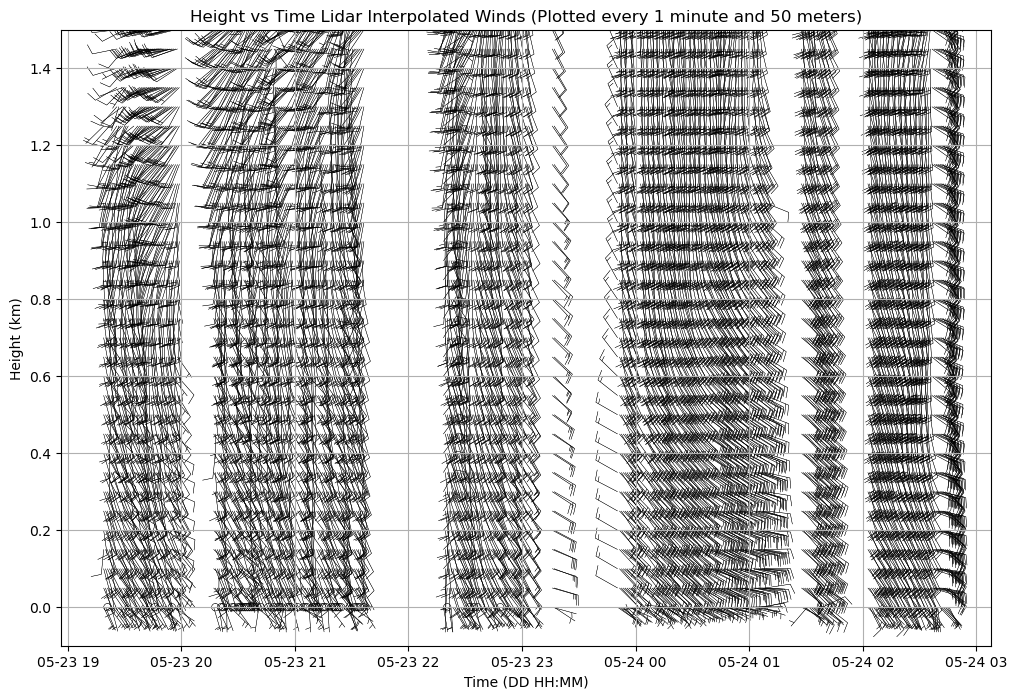

In [189]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

fig,ax = plt.subplots(figsize=[12,8],ncols=1)
ax.grid()
ax.set_xlabel('Time (DD HH:MM)')
ax.set_ylabel('Height (km)')
ax.set_title('Height vs Time Lidar Interpolated Winds (Plotted every 1 minute and 50 meters)')
ax.set_ylim([-0.1,1.5])

for i in np.arange(0,len(testing.time)-2):
    
    #remove bad time
#     if i == 178:
#         continue
    if (i % 10 == 0)|(i % 10 == 2)|(i % 10 == 4)|(i % 10 == 6)|(i % 10 == 8):
        #print(i)
        test = testing.isel(time=slice(i, i+1))
        u_mob,v_mob = (wind_components(lidar_storm.iloc[(lidar_storm['datetime']-test.time.values[0]).abs().argsort()[:1]]['Spd'].values 
                                    * units('knots').to((units.m)/(units.s)), 
                                   lidar_storm.iloc[(lidar_storm['datetime']-test.time.values[0]).abs().argsort()[:1]]['Dir'].values 
                                    * units.deg))

        u = test['u'][0].values[2:]
        v = test['v'][0].values[2:]
        z = test['height'].values[2:]

        u = np.insert(u, 0, u_mob.magnitude, axis=0)
        v = np.insert(v, 0, v_mob.magnitude, axis=0)
        z = np.insert(z, 0, 0., axis=0)

        # define data with variable attributes
        data_vars = {'u':(['height'], u, 
                                 {'units': 'm/s', 
                                  'long_name':'ucomponent'}),
                     'v':(['height'], v, 
                                 {'units': 'm/s', 
                                  'long_name':'vcomponent'})}

        # define coordinates
        coords = {'height': (['height'], z)}

        # create dataset
        testnew = xr.Dataset(data_vars=data_vars, coords=coords)

        u1 = testnew['u'].interp(height=np.arange(0,3.010,0.010))
        v1 = testnew['v'].interp(height=np.arange(0,3.010,0.010))
        z1 = np.arange(0,3.010,0.010)

# u_shear = [u1[10].values-u1[0].values,u1[20].values-u1[0].values,u1[30].values-u1[0].values
#            ,u1[40].values-u1[0].values,u1[50].values-u1[0].values,u1[60].values-u1[0].values
#            ,u1[70].values-u1[0].values,u1[80].values-u1[0].values,u1[90].values-u1[0].values
#            ,u1[100].values-u1[0].values]

# v_shear = [v1[10].values-v1[0].values,v1[20].values-v1[0].values,v1[30].values-v1[0].values
#            ,v1[40].values-v1[0].values,v1[50].values-v1[0].values,v1[60].values-v1[0].values
#            ,v1[70].values-v1[0].values,v1[80].values-v1[0].values,v1[90].values-v1[0].values
#            ,v1[100].values-v1[0].values]
# wspd_shear = wind_speed(u_shear*units('m/s'),v_shear*units('m/s'))
# z_shear = np.arange(0.1,1.1,0.1)

# ax.scatter(u,z,color='lightblue',label='U-component')
# ax.scatter(v,z,color='lime',label='V-component')
# ax.scatter(u_shear,z_shear,color='darkblue', label='U-component shear')
# ax.scatter(v_shear,z_shear,color='darkgreen', label='V-component shear')
# ax.axvline(0,color='r',linestyle='--')


# Xq_shear,Yq_shear = np.meshgrid(25, z_shear)
# ax.barbs(Xq_shear,Yq_shear,u_shear,v_shear,color='darkred',linewidth=1.7)

        Xq1,Yq1 = np.meshgrid(test.time.values, z1)
        ax.barbs(Xq1[::5],Yq1[::5],u1[::5],v1[::5],color='k',linewidth=0.3,length=6,alpha=0.7,label='Lidar Winds Interp (m/s)')

#         Xq,Yq = np.meshgrid(test.time.values, z)
#         ax.barbs(Xq,Yq,u,v,color='k',linewidth=1.2,label='Lidar Winds (m/s)')
# # ax.set_title('NSSL Lidar '+str(test4['time'].values[0]))

# Mytext = ax.text(21,1.02,"\u0332".join('Shear'),fontweight='bold')
# ax.text(19.0,0.97,'0-1.0km: '+str(wspd_shear[9].round(1).magnitude))
# ax.text(19.0,0.87,'0-900m: '+str(wspd_shear[8].round(1).magnitude))
# ax.text(19.0,0.77,'0-800m: '+str(wspd_shear[7].round(1).magnitude))
# ax.text(19.0,0.67,'0-700m: '+str(wspd_shear[6].round(1).magnitude))
# ax.text(19.0,0.57,'0-600m: '+str(wspd_shear[5].round(1).magnitude))
# ax.text(19.0,0.47,'0-500m: '+str(wspd_shear[4].round(1).magnitude))
# ax.text(19.0,0.37,'0-400m: '+str(wspd_shear[3].round(1).magnitude))
# ax.text(19.0,0.27,'0-300m: '+str(wspd_shear[2].round(1).magnitude))
# ax.text(19.0,0.17,'0-200m: '+str(wspd_shear[1].round(1).magnitude))
# ax.text(19.0,0.07,'0-100m: '+str(wspd_shear[0].round(1).magnitude))

#ax.legend(ncol=2,loc=1)
plt.savefig('/Users/joshu/Desktop/IOP3_lidartimeheight.png',bbox_inches='tight',format='png',dpi=300)
plt.show()


In [194]:
count =0
for i in np.arange(0,len(testing.time)-2):
    count+=1
    #remove bad time
    if i == 178:
        continue
    elif (i % 10 == 0)|(i % 10 == 2)|(i % 10 == 4)|(i % 10 == 6)|(i % 10 == 8):
        #print(i)
        
        test = testing.isel(time=slice(i, i+1))
        u_mob,v_mob = (wind_components(lidar_storm.iloc[(lidar_storm['datetime']-test.time.values[0]).abs().argsort()[:1]]['Spd'].values 
                                    * units('knots').to((units.m)/(units.s)), 
                                   lidar_storm.iloc[(lidar_storm['datetime']-test.time.values[0]).abs().argsort()[:1]]['Dir'].values 
                                    * units.deg))

        u = test['u'][0].values[2:]
        v = test['v'][0].values[2:]
        z = test['height'].values[2:]

        u = np.insert(u, 0, u_mob.magnitude, axis=0)
        v = np.insert(v, 0, v_mob.magnitude, axis=0)
        z = np.insert(z, 0, 0., axis=0)

        # define data with variable attributes
        data_vars = {'u':(['height'], u, 
                                 {'units': 'm/s', 
                                  'long_name':'ucomponent'}),
                     'v':(['height'], v, 
                                 {'units': 'm/s', 
                                  'long_name':'vcomponent'})}

        # define coordinates
        coords = {'height': (['height'], z)}

        # create dataset
        testnew = xr.Dataset(data_vars=data_vars, coords=coords)

        u1 = testnew['u'].interp(height=np.arange(0,5.010,0.010))
        v1 = testnew['v'].interp(height=np.arange(0,5.010,0.010))
        z1 = np.arange(0,5.010,0.010)

        fig = plt.figure(figsize=(20, 20),facecolor='white')
        ax4 = fig.add_subplot(2,2,4)
        hodo = Hodograph(ax4,component_range=80.)
        hodo.add_grid(increment=5)
        hodo.plot(u1[0:301]*1.94384,v1[0:301]*1.94384)
        ax4.set_title('NSSL Lidar '+str(test.time.values[0]))
        ax4.set_xlabel('U-component Wind [knots]')
        ax4.set_ylabel('V-component Wind [knots]')
#         for i,z in zip([0,.2,.4,.6,.8,1,1.2,1.4],[0,20,40,60,80,100,120,140]):
#             circle = plt.Circle((u1.values[0:151][z]*1.94384, v1.values[0:151][z]*1.94384), radius=1.5,color='k',zorder=30)
#             ax4.add_patch(circle)
#             label = ax4.annotate(i, xy=(u1.values[0:151][z]*1.94384, v1.values[0:151][z]*1.94384), fontsize=7, ha="center",va='center',color='white',zorder=30,weight="bold")
        
        for i,z in enumerate([0,100,200,300]):
            if (np.isnan(u1.values[z]))|(np.isnan(v1.values[z])):
                pass
            else:
                circle = plt.Circle((u1[0:301].values[z]*1.94384, v1[0:301].values[z]*1.94384), radius=1.5,color='k',zorder=30)
                ax4.add_patch(circle)
                label = ax4.annotate(i, xy=(u1[0:301].values[z]*1.94384, v1[0:301].values[z]*1.94384), fontsize=7, ha="center",va='center',color='white',zorder=30,weight="bold")

        
        plt.savefig('/Users/joshu/Desktop/Lapenta/20220523/hodos/lidar/IOP13_lidarhodonew'+str(count)+'.png',bbox_inches='tight',format='png',dpi=300)
        plt.close('all')
        fig.clf()
    #gc.collect()
        #plt.show()

In [11]:
ka1 = pd.read_csv('E:/Lapenta/20220523/KaRadars/20220523_Ka1_scan_log.txt', header=0,parse_dates=[0])
ka2 = pd.read_csv('E:/Lapenta/20220523/KaRadars/20220523_Ka2_scan_log.txt', header=0,parse_dates=[0])

# ka1['hhmmss[UTC]']=ka1['hhmmss[UTC]'].astype(str).str.zfill(6)
# ka1['ddmmyy']=ka1['ddmmyy'].astype(str).str[:4]+str(20)+ka1['ddmmyy'].astype(str).str[-2:]
# ka1['datetime'] = pd.to_datetime(ka1['ddmmyy'].astype(str)+ka1['hhmmss[UTC]'].astype(str),format='%d%m%Y%H%M%S')

# ka2['hhmmss[UTC]']=ka2['hhmmss[UTC]'].astype(str).str.zfill(6)
# ka2['ddmmyy']=ka2['ddmmyy'].astype(str).str[:4]+str(20)+ka2['ddmmyy'].astype(str).str[-2:]
# ka2['datetime'] = pd.to_datetime(ka2['ddmmyy'].astype(str)+ka2['hhmmss[UTC]'].astype(str),format='%d%m%Y%H%M%S')

In [12]:
ka1 = ka1.loc[ka1.Scantype=='vad']
ka1 = ka1.loc[ka1.Speed<5]
ka2 = ka2.loc[ka2.Scantype=='vad']
ka2 = ka2.loc[ka2.Speed<5]

In [13]:
ka1_storm = ka1.loc[(ka1['Datetime'] >= storm_location.datetime[0]) & 
        (ka1['Datetime'] <= storm_location.datetime[len(storm_location)-1])]
ka2_storm = ka2.loc[(ka2['Datetime'] >= storm_location.datetime[0]) & 
        (ka2['Datetime'] <= storm_location.datetime[len(storm_location)-1])]
lidar_storm = lidarObs.loc[(lidarObs['datetime'] >= storm_location.datetime[0]) & 
        (lidarObs['datetime'] <= storm_location.datetime[len(storm_location)-1])]

In [14]:
lidar_deploy_numb = lidar_storm.loc[(lidar_storm.index.isin(lidar_storm.Lat.drop_duplicates().index))&(lidar_storm.index.isin(lidar_storm.Lon.drop_duplicates().index))]

ka1_deploy_numb = ka1_storm.loc[(ka1_storm.index.isin(ka1_storm.round(decimals=4).Latitude.drop_duplicates().index))&(ka1_storm.index.isin(ka1_storm.round(decimals=4).Longitude.drop_duplicates().index))&(ka1_storm.round(decimals=4).Latitude>0)]
ka2_deploy_numb = ka2_storm.loc[(ka2_storm.index.isin(ka2_storm.round(decimals=4).Latitude.drop_duplicates().index))&(ka2_storm.index.isin(ka2_storm.round(decimals=4).Longitude.drop_duplicates().index))&(ka2_storm.round(decimals=4).Latitude>0)]

import geopandas as gpd

tor_paths = gpd.read_file('nws_dat_damage_paths.shp')

tor_paths['start_tor']=pd.to_datetime(tor_paths['starttime'].astype(str)+tor_paths['starttimez'].astype(str).str[0:4],format='%Y-%m-%d%H%M')
tor_paths['end_tor']=pd.to_datetime(tor_paths['endtime'].astype(str)+tor_paths['endtimez'].astype(str).str[0:4],format='%Y-%m-%d%H%M')

tor_paths = tor_paths.sort_values(by='start_tor')

tor_paths = tor_paths.replace(pd.to_datetime('2022-05-26 00:45:00',format='%Y-%m-%d %H:%M:%S'), pd.to_datetime('2022-05-24 00:45:00',format='%Y-%m-%d %H:%M:%S'))

C:\Users\joshu\AppData\Local\Temp\ipykernel_12568\2425670951.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_xticklabels(fff)


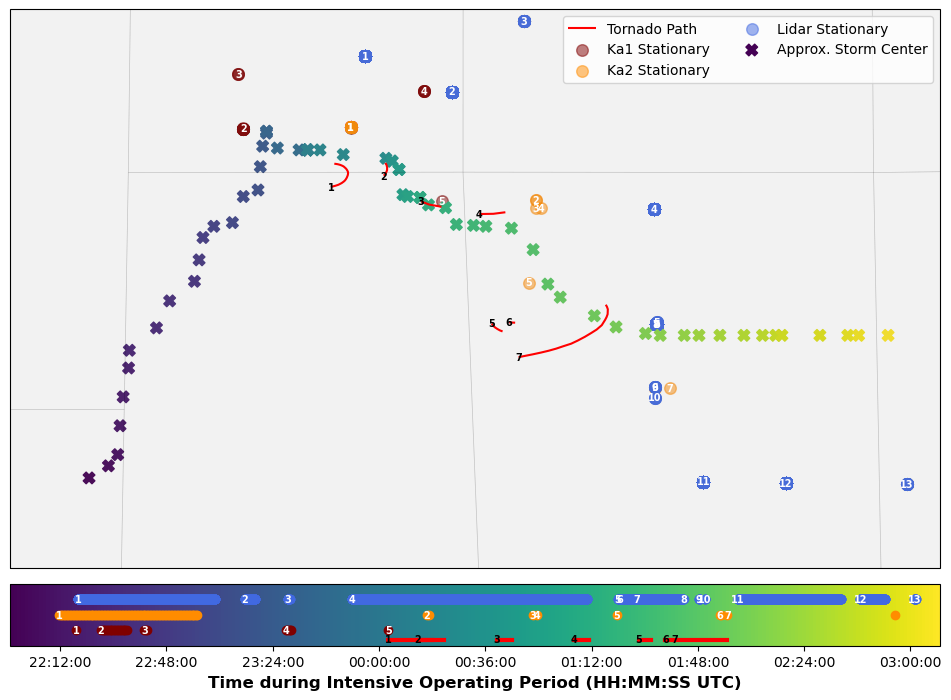

In [211]:
import cartopy.crs as ccrs
import cartopy
import cartopy.feature as cfeature
from metpy.plots import USCOUNTIES
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.dates as mdates

fig = plt.figure(figsize=(12,10))
ax = plt.axes(projection=ccrs.PlateCarree())
norm = mpl.colors.Normalize(vmin=mdates.date2num(storm_location.datetime)[0], vmax=mdates.date2num(storm_location.datetime[len(storm_location)-1]))
ax.set_extent([-103.2, -102, 33.4, 34])
#ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=2, edgecolor="black")
ax.add_feature(USCOUNTIES.with_scale('20m'), linewidth=.5, edgecolor="black",facecolor='gray',alpha=0.1)
tor_paths.plot(ax=ax,color='r', label='Tornado Path')
ax.scatter(ka1_storm.Longitude.values,ka1_storm.Latitude.values,s=70,color='maroon',alpha=0.5,label='Ka1 Stationary')
ax.scatter(ka2_storm.Longitude.values,ka2_storm.Latitude.values,s=70,color='darkorange',alpha=0.5,label='Ka2 Stationary')
ax.scatter(lidar_storm['Lon'].values,lidar_storm['Lat'].values,alpha=0.5,s=70,color='royalblue',label='Lidar Stationary')
times1 = ax.scatter(storm_location.Lon.values,storm_location.Lat.values,c=mdates.date2num(storm_location.datetime),
                    marker="X",s=70,label='Approx. Storm Center',norm=norm)

for i in np.arange(1,len(lidar_deploy_numb)+1,1):
    ax.annotate(i, xy=(lidar_deploy_numb.iloc[i-1].Lon, lidar_deploy_numb.iloc[i-1].Lat), fontsize=7, ha="center",va='center',color='white',zorder=30,weight="bold")

for i in np.arange(1,len(ka1_deploy_numb)+1,1):
    ax.annotate(i, xy=(ka1_deploy_numb.iloc[i-1].Longitude, ka1_deploy_numb.iloc[i-1].Latitude), fontsize=7, ha="center",va='center',color='white',zorder=30,weight="bold")

    
for i in np.arange(1,len(ka2_deploy_numb)+1,1):
    ax.annotate(i, xy=(ka2_deploy_numb.iloc[i-1].Longitude, ka2_deploy_numb.iloc[i-1].Latitude), fontsize=7, ha="center",va='center',color='white',zorder=30,weight="bold")

    
for i in np.arange(1,len(tor_paths)+1,1):
    ax.annotate(i, xy=(tor_paths.iloc[i-1].startlon, tor_paths.iloc[i-1].startlat), fontsize=7, ha="center",va='center',color='k',zorder=30,weight="bold")

# ax.scatter(sounding_farfield1['Filtered Longitude'][0],sounding_farfield1['Filtered Latitude'][0],marker="*",color='olive',
#            s=100,alpha=0.8,label='Farfield Sounding')
# ax.scatter(sounding_Lidar['Filtered Longitude'][0],sounding_Lidar['Filtered Latitude'][0],marker="*",color='red',
#            s=100,alpha=0.8,label='Lidar Sounding')
# ax.scatter(sounding_farfield2['Filtered Longitude'][0],sounding_farfield2['Filtered Latitude'][0],marker="*",color='green',
#            s=100,alpha=0.8,label='Farfield Sounding')
# ax.scatter(sounding_farfield3['Filtered Longitude'][0],sounding_farfield3['Filtered Latitude'][0],marker="*",color='orange',
#            s=100,alpha=0.8,label='Farfield Sounding')

cbar = fig.colorbar(times1,location='bottom',aspect=15,pad=0.02)
ff = mdates.num2date(cbar.ax.get_xticks())
fff = [date_obj.strftime('%H:%M:%S') for date_obj in ff]
cbar.ax.set_xticklabels(fff)

lidar1=(mdates.date2num(lidar_storm.datetime))
cbar.ax.scatter(lidar1,np.linspace(0.75,0.75,len(lidar1)),color='royalblue')

ka1=(mdates.date2num(ka1_storm.Datetime))
cbar.ax.scatter(ka1,np.linspace(0.25,0.25,len(ka1)),color='maroon')

ka2=(mdates.date2num(ka2_storm.Datetime))
cbar.ax.scatter(ka2,np.linspace(0.5,0.5,len(ka2)),color='darkorange')

torbegin=(mdates.date2num(tor_paths.start_tor))
torend=(mdates.date2num(tor_paths.end_tor))
for i,j in zip(torbegin,torend):
    cbar.ax.plot([i,j],[.1,.1],color='red',linewidth=3)

lidarstop=(mdates.date2num(lidar_deploy_numb.datetime))
for i in np.arange(1,len(lidar_deploy_numb)+1,1):
    cbar.ax.annotate(i, xy=(lidarstop[i-1], np.linspace(0.75,0.75,len(lidarstop))[i-1]), fontsize=7, ha="center",va='center',color='white',zorder=30,weight="bold")

ka1stop=(mdates.date2num(ka1_deploy_numb.Datetime))
for i in np.arange(1,len(ka1_deploy_numb)+1,1):
    cbar.ax.annotate(i, xy=(ka1stop[i-1], np.linspace(0.25,0.25,len(ka1stop))[i-1]), fontsize=7, ha="center",va='center',color='white',zorder=30,weight="bold")

ka2stop=(mdates.date2num(ka2_deploy_numb.Datetime))
for i in np.arange(1,len(ka2_deploy_numb)+1,1):
    cbar.ax.annotate(i, xy=(ka2stop[i-1], np.linspace(0.5,0.5,len(ka2stop))[i-1]), fontsize=7, ha="center",va='center',color='white',zorder=30,weight="bold")

torbegin=(mdates.date2num(tor_paths.start_tor))
for i in np.arange(1,len(tor_paths)+1,1):
    cbar.ax.annotate(i, xy=(torbegin[i-1], np.linspace(0.1,0.1,len(torbegin))[i-1]), fontsize=7, ha="center",va='center',color='k',zorder=30,weight="bold")

# soundingff1 = (mdates.date2num(pd.to_datetime(sounding_farfield1['GPS Time Record'][0],format='%d-%b-%Y %H:%M:%S')))
# cbar.ax.scatter(soundingff1,0.6,marker='*',s=100,color='olive')

# soundingff2 = (mdates.date2num(pd.to_datetime(sounding_farfield2['GPS Time Record'][0],format='%d-%b-%Y %H:%M:%S')))
# cbar.ax.scatter(soundingff2,0.6,marker='*',s=100,color='green')

# soundingff3 = (mdates.date2num(pd.to_datetime(sounding_farfield3['GPS Time Record'][0],format='%d-%b-%Y %H:%M:%S')))
# cbar.ax.scatter(soundingff3,0.6,marker='*',s=100,color='orange')

# soundinglid = (mdates.date2num(pd.to_datetime(sounding_Lidar['GPS Time Record'][0],format='%d-%b-%Y %H:%M:%S')))
# cbar.ax.scatter(soundinglid,0.6,marker='*',s=100,color='red')

cbar.set_label('Time during Intensive Operating Period (HH:MM:SS UTC)', fontsize=12, fontweight='bold')
ax.legend(ncol=2,loc=0)

plt.savefig('E:/Lapenta/20220523/Figs/IOP3_TORUS22.png',bbox_inches='tight',format='png',dpi=300)

In [21]:
tor_paths

Id      event_id   stormdate stormtime   starttime starttimez     endtime  \
0   0        Enochs  2022-05-24  0003 UTC  2022-05-24   0003 UTC  2022-05-24   
1   0   County_Line  2022-05-24  0013 UTC  2022-05-24   0013 UTC  2022-05-24   
4   0    NE_Cochran  2022-05-24  0040 UTC  2022-05-24   0040 UTC  2022-05-26   
2   0    NW_Hockley  2022-05-24  0106 UTC  2022-05-24   0106 UTC  2022-05-24   
5   0      Pettit_1  2022-05-24  0128 UTC  2022-05-24   0128 UTC  2022-05-24   
6   0      Pettit_2  2022-05-24  0137 UTC  2022-05-24   0137 UTC  2022-05-24   
3   0  Pettit_Coble  2022-05-24  0140 UTC  2022-05-24   0140 UTC  2022-05-24   

   endtimez  startlat  startlon  ...  qc  maxwind  cropdamage  propdamage  \
0  0018 UTC   33.8093 -102.7860  ...   Y      120         0.0         0.0   
1  0022 UTC   33.8213 -102.7178  ...   Y        0         0.0         0.0   
4  0045 UTC   33.7937 -102.6694  ...   Y        0         0.0         0.0   
2  0111 UTC   33.7802 -102.5942  ...   Y        0         0.0         0.0   
5  0132 UTC   33.6627 -102.5785  ...   Y        0         0.0         0.0   
6  0139 UTC   33.6640 -102.5559  ...   Y        0         0.0         0.0   
3  0158 UTC   33.6266 -102.5438  ...   Y      120         0.0         0.0   

                                            comments  wfo image_full  \
0      Width estimated by images from TTU-Ka1 radar.    0        NaN   
1  Brief, small tornado reported by numerous chas...    0        NaN   
4  Short-lived, small tornado. Track estimated by...    0        NaN   
2  Storm chaser footage of a brief, small tornado...    0        NaN   
5  Short-lived, small tornado. Track estimated by...    0        NaN   
6  Short-lived, small tornado. Track estimated by...    0        NaN   
3  Damage survey limited as roads were closed due...    0        NaN   

                                            geometry           start_tor  \
0  LINESTRING (-102.78595 33.80927, -102.77999 33... 2022-05-24 00:03:00   
1  LINESTRING (-102.71776 33.82133, -102.71510 33... 2022-05-24 00:13:00   
4  LINESTRING (-102.66939 33.79374, -102.65909 33... 2022-05-24 00:40:00   
2  LINESTRING (-102.59416 33.78019, -102.57631 33... 2022-05-24 01:06:00   
5  LINESTRING (-102.57850 33.66272, -102.57618 33... 2022-05-24 01:28:00   
6  LINESTRING (-102.55593 33.66401, -102.55215 33... 2022-05-24 01:37:00   
3  LINESTRING (-102.54380 33.62658, -102.52552 33... 2022-05-24 01:40:00   

              end_tor  
0 2022-05-24 00:18:00  
1 2022-05-24 00:22:00  
4 2022-05-24 00:45:00  
2 2022-05-24 01:11:00  
5 2022-05-24 01:32:00  
6 2022-05-24 01:39:00  
3 2022-05-24 01:58:00  

[7 rows x 28 columns]